# XGBoost

In [1]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import pandas as pd
from pathlib import Path
from typing import List, Dict, Any, Optional, Tuple
import os
from datetime import datetime
import pdb;
from grocery_ml_xgb import GroceryML
from grocery_ml_core import GroceryMLCore
from hidden_layer_param_builder import HiddenLayerParamSetBuilder

pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.float_format", lambda x: f"{x:.6f}")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)

print(os.getcwd())

try:
    groceryML = GroceryML();
    groceryMLCore = GroceryMLCore();
    groceryML.build_training_df()
    if groceryML.training_df is None:
        raise();
    ts = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    groceryML.training_df.to_csv(f"training_df-{ts}.csv");
except Exception as ex: 
    print(ex)
    ts = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    groceryML.training_df.to_csv(f"training_df-{ts}-exception.csv");

C:\Users\steve\source\repos\grocery-ml
build_combined_df()
creating target col: didBuy_target
insert_negative_samples()
compute_expected_gap_ewma()
create_item_supply_level_feat()
add_item_total_purchase_count_feat()
build_trip_level_features()
self._combined_df() done


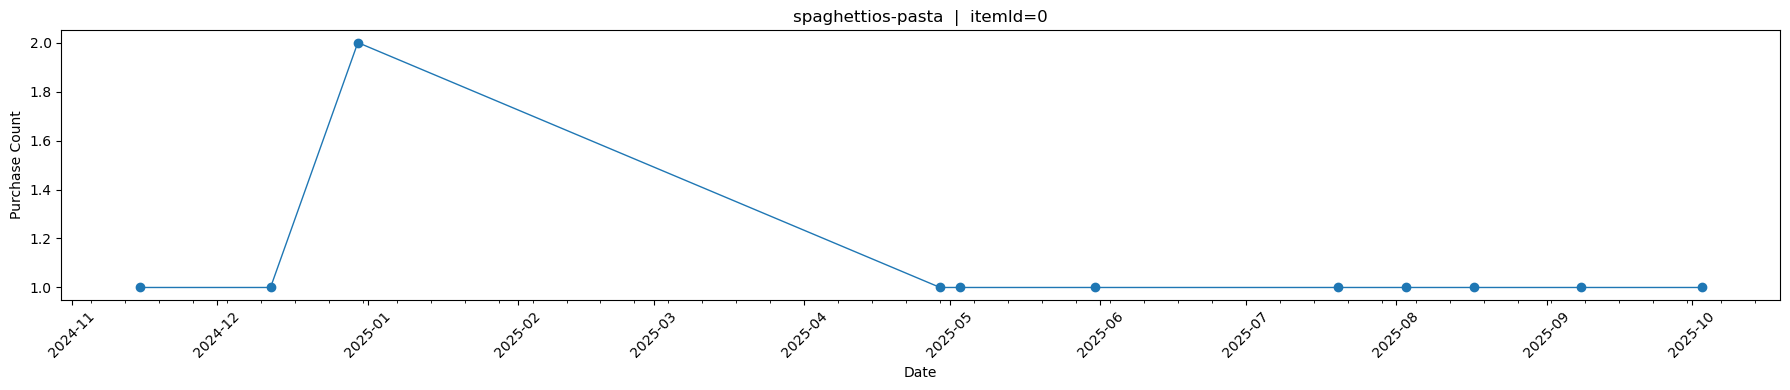

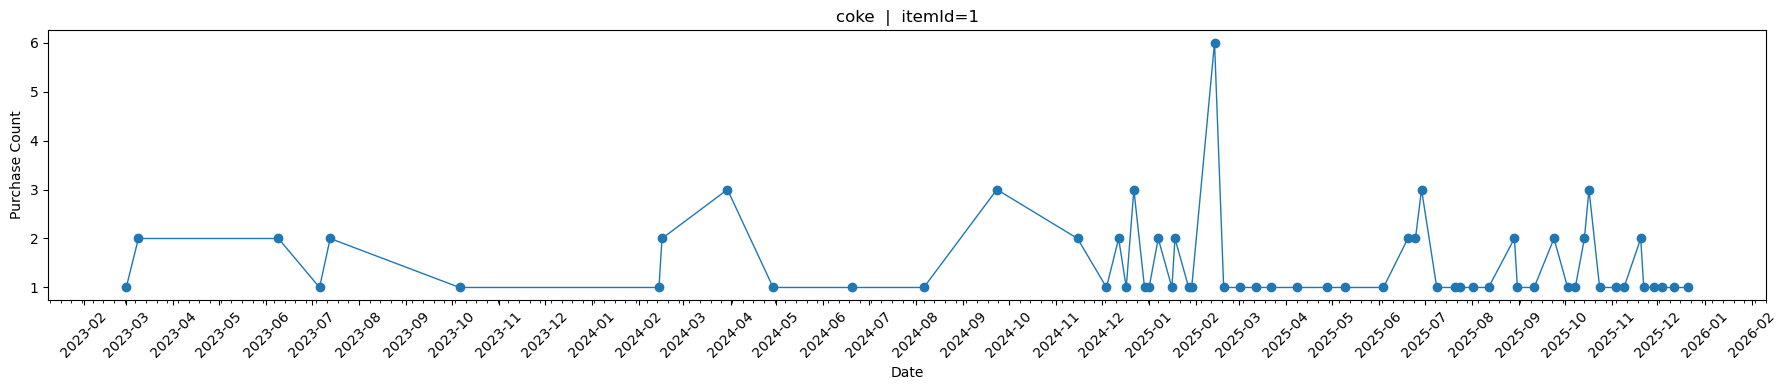

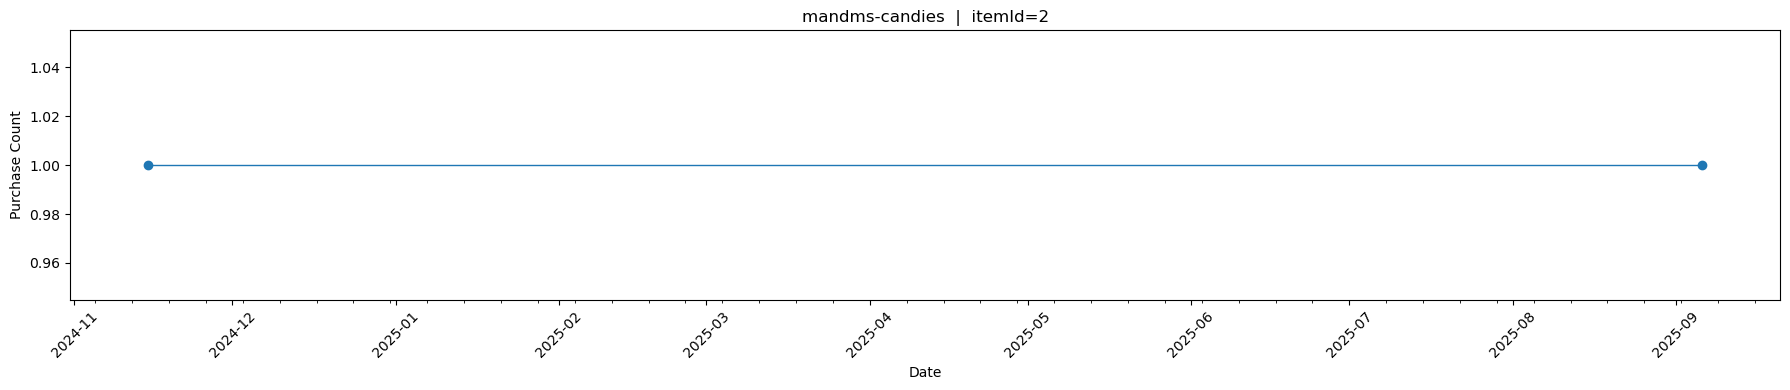

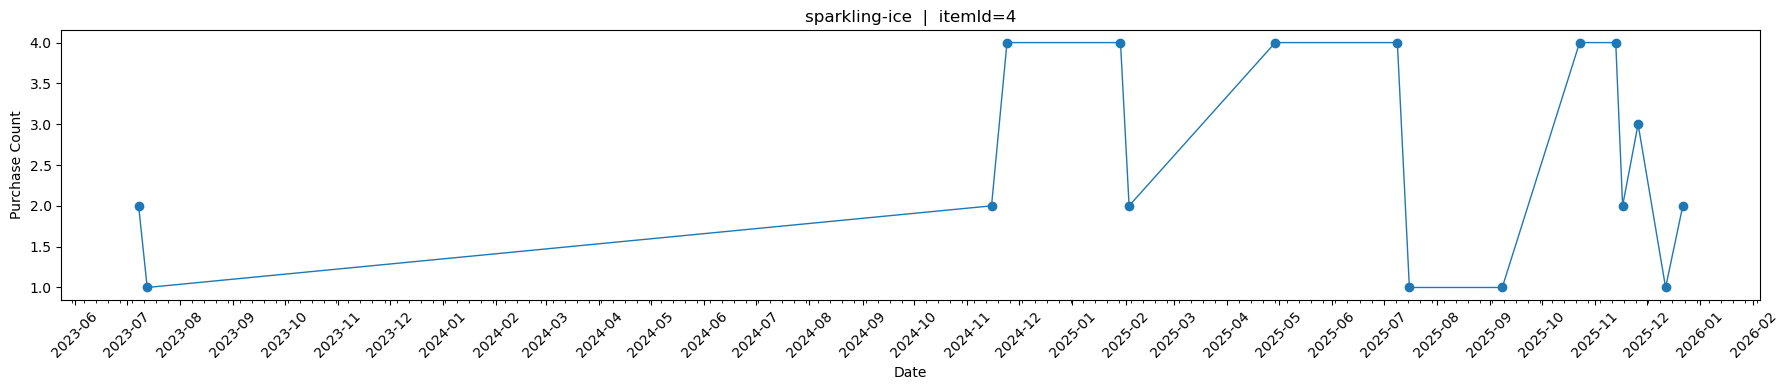

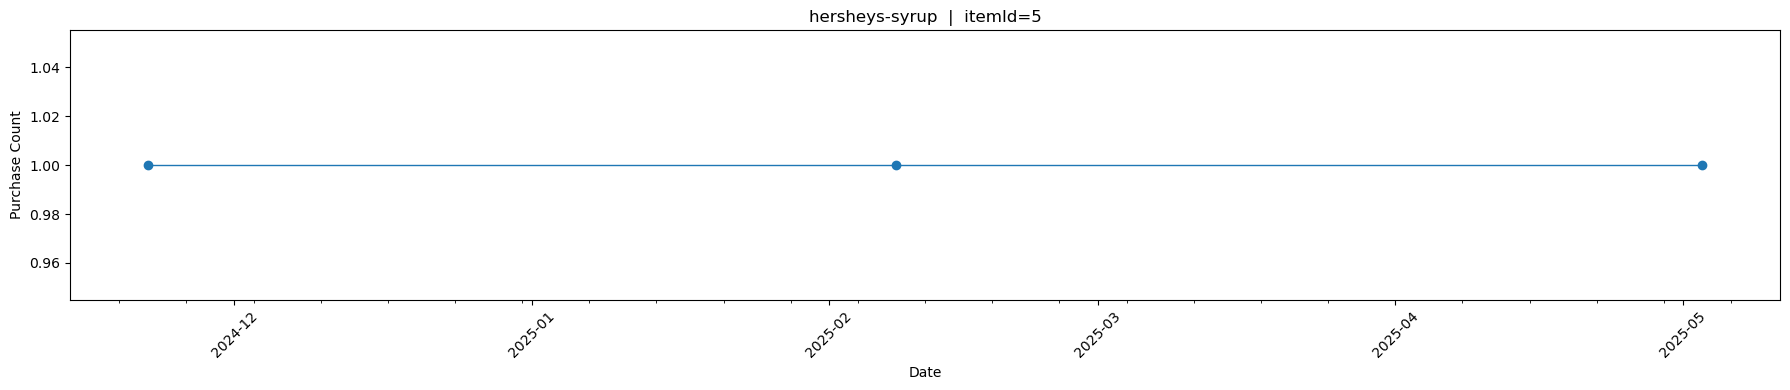

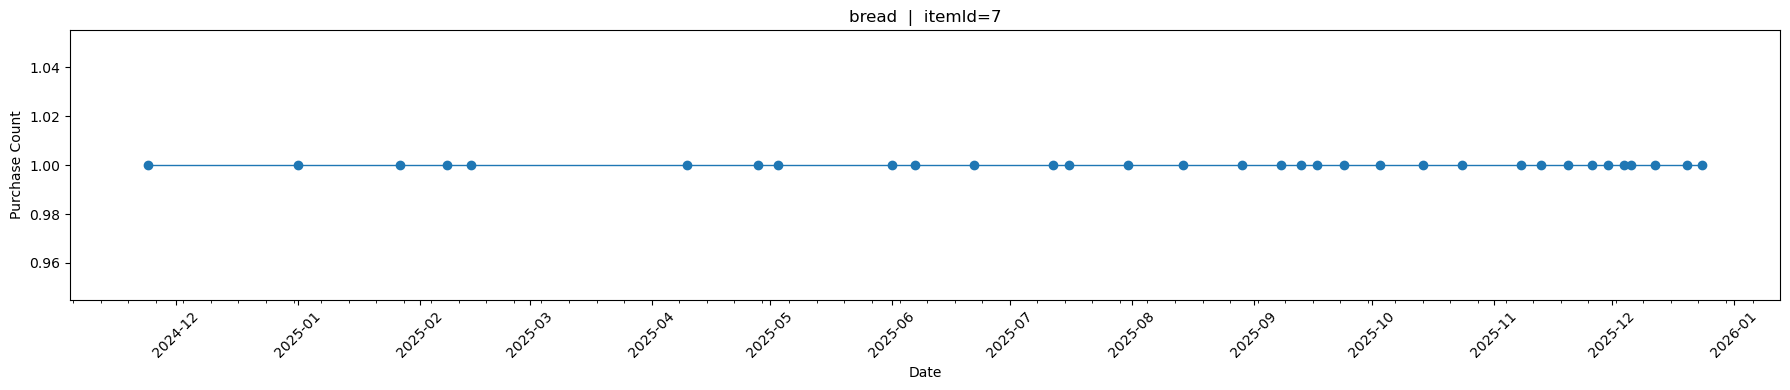

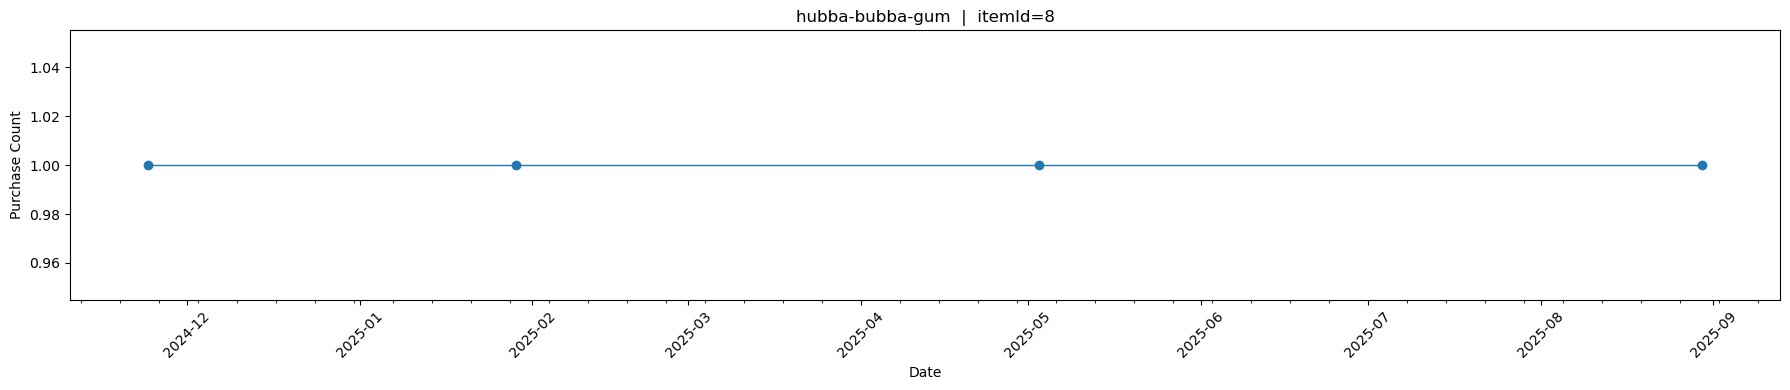

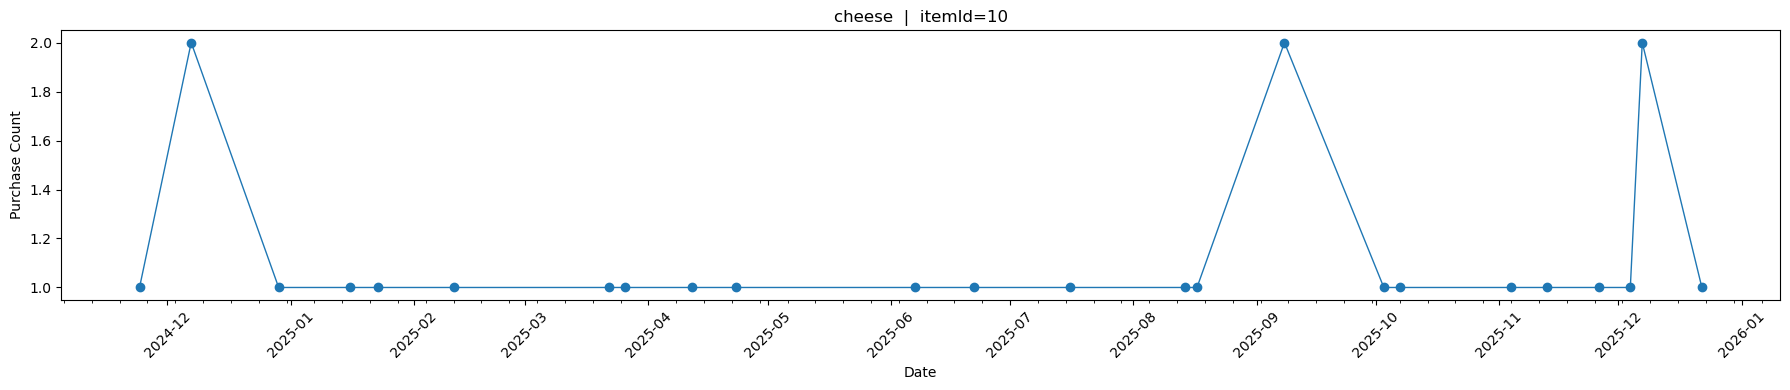

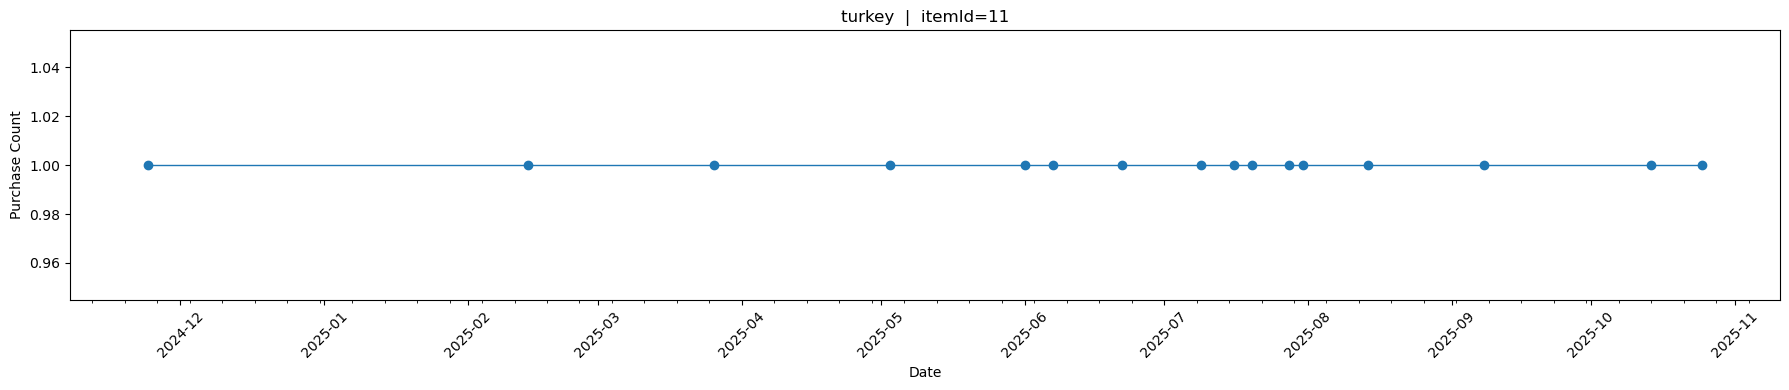

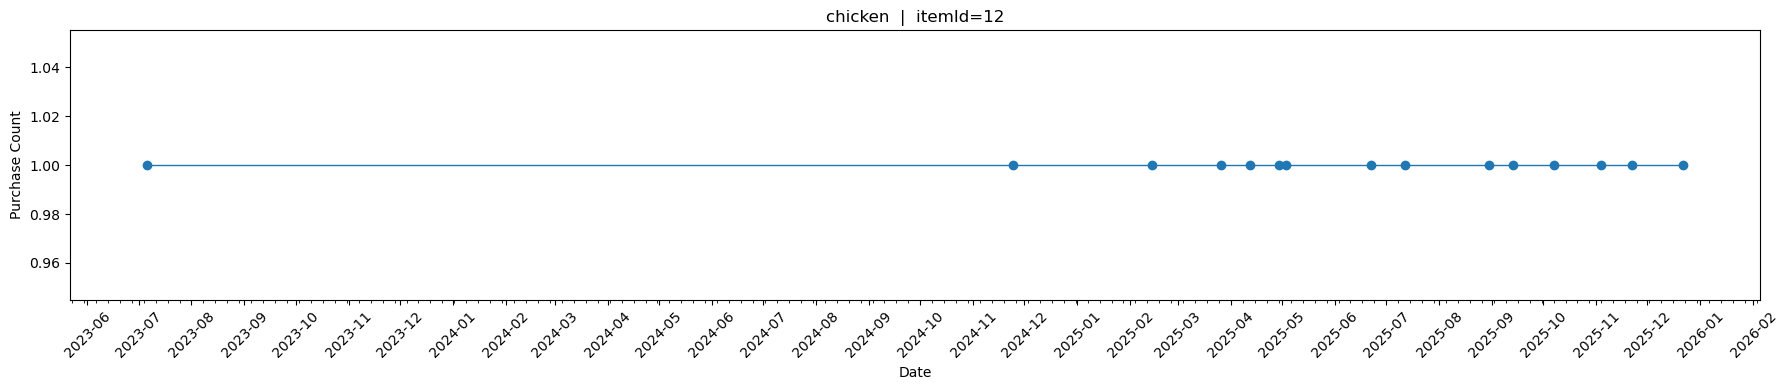

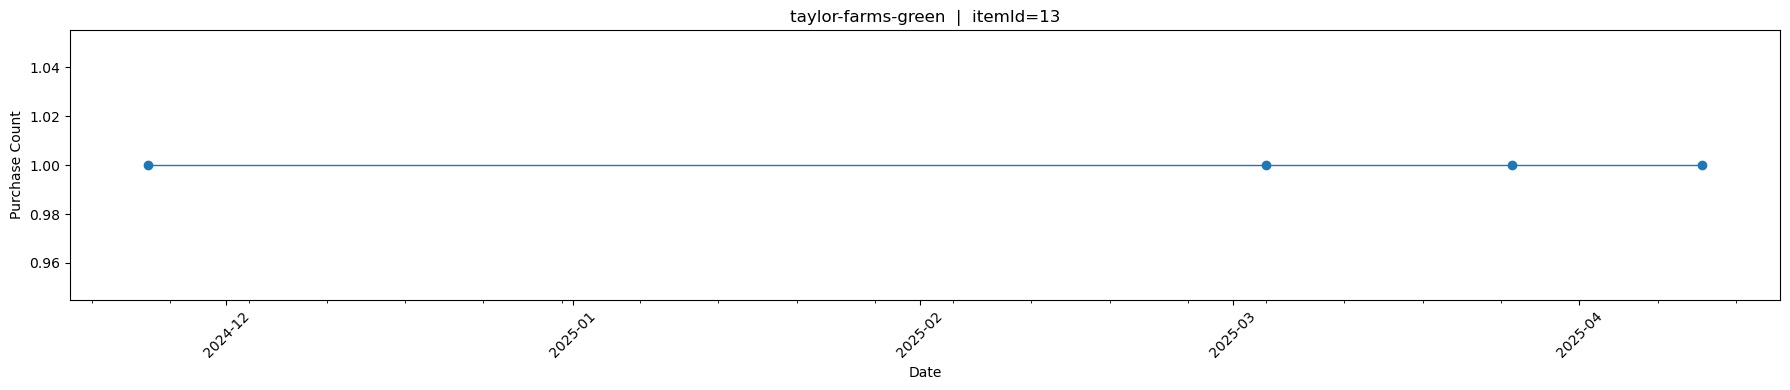

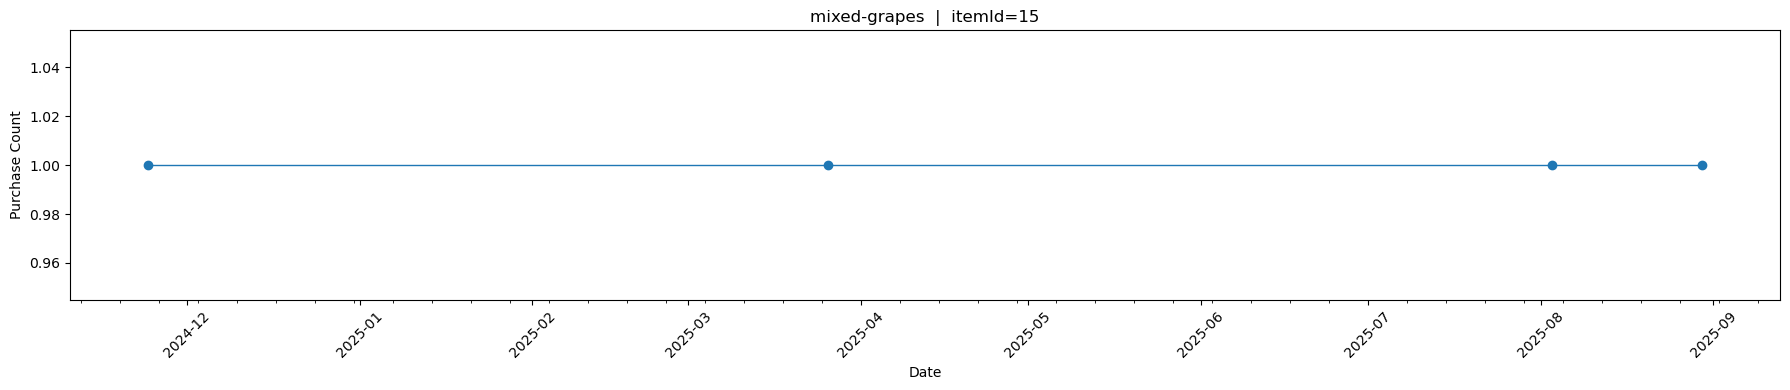

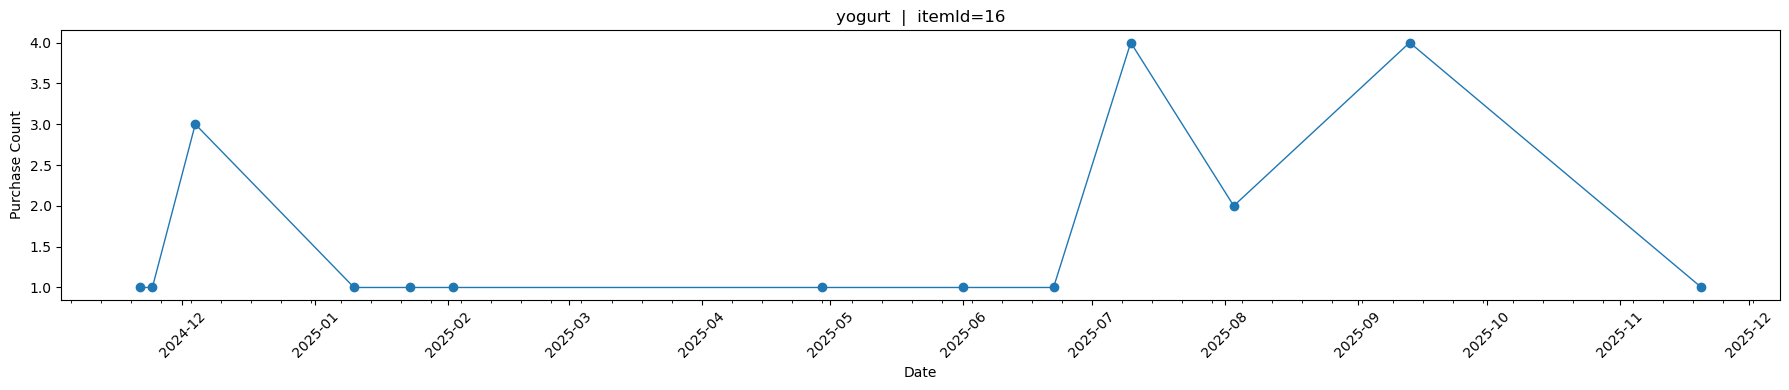

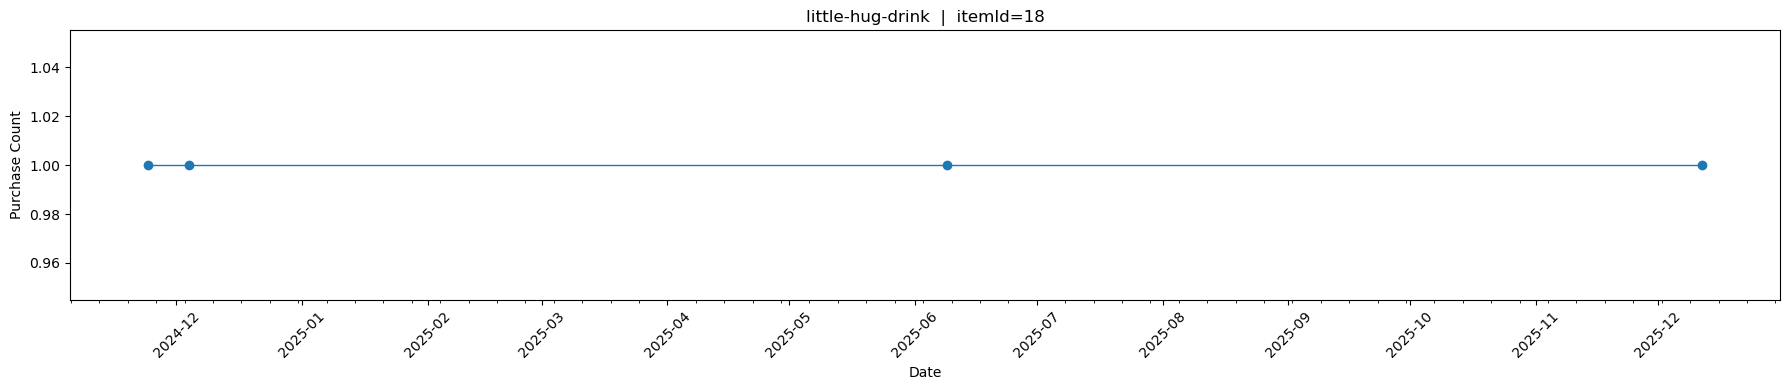

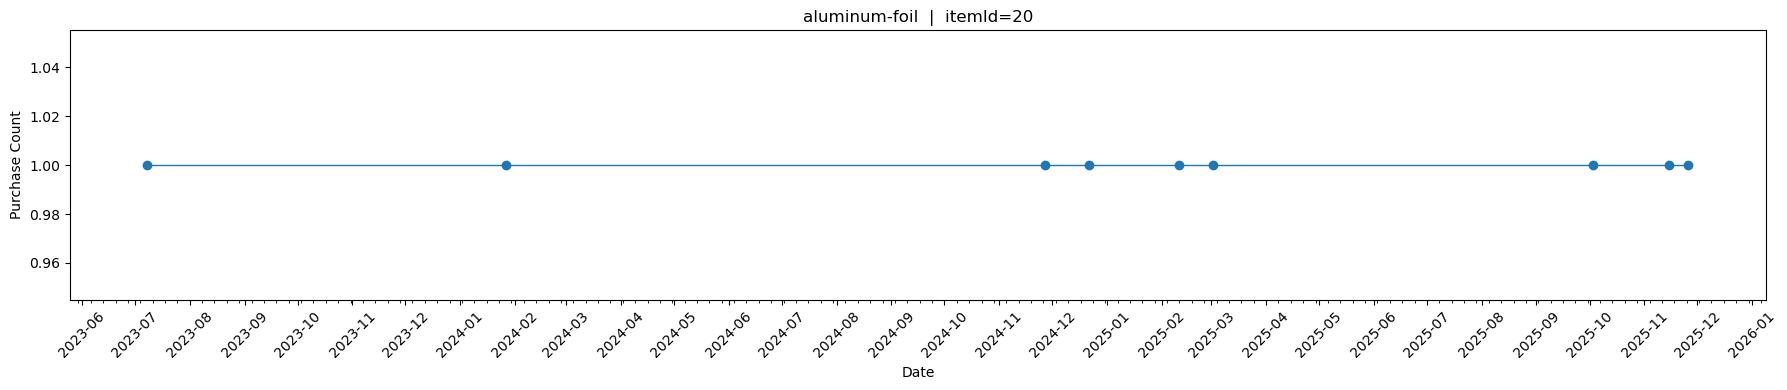

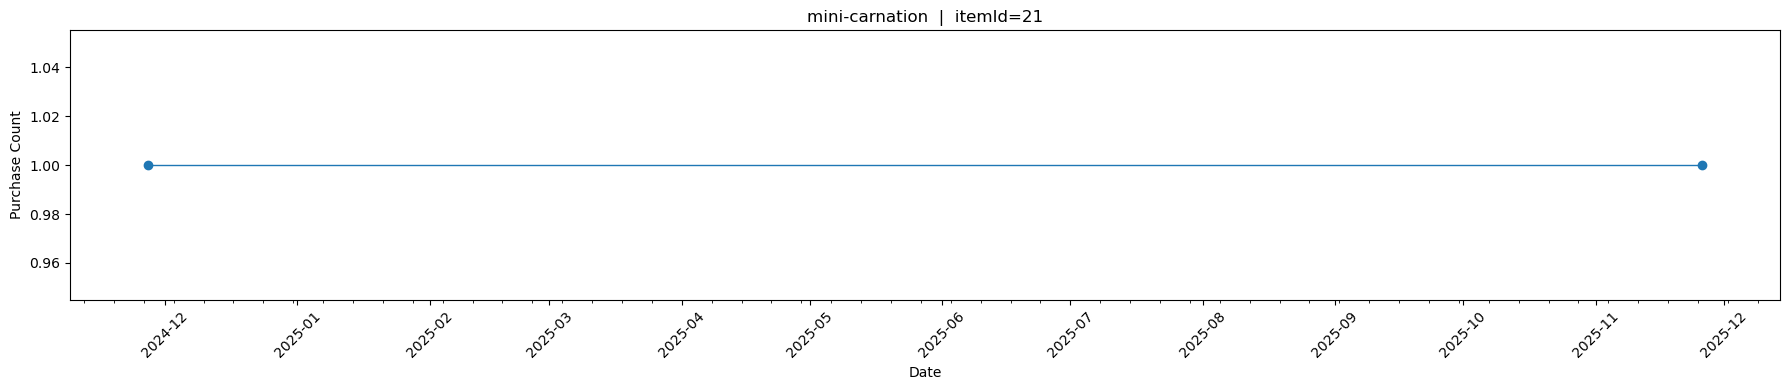

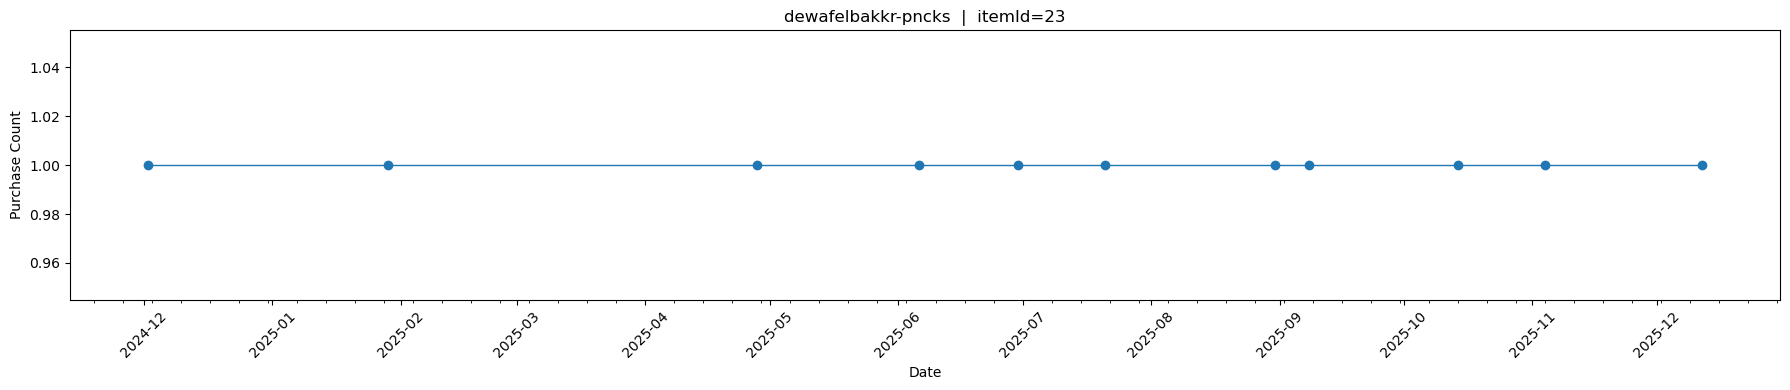

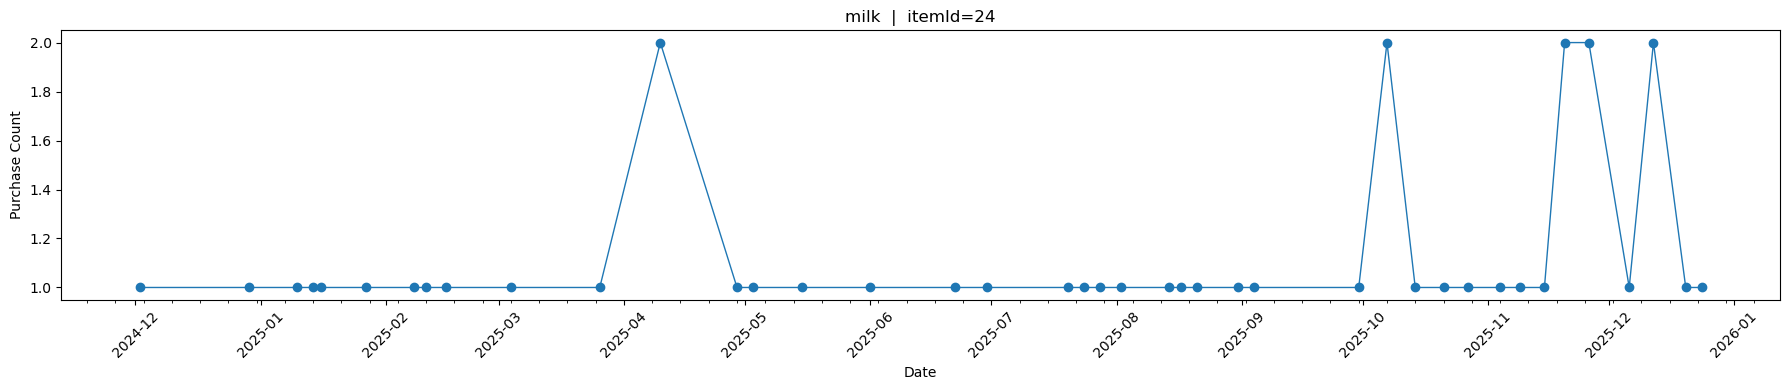

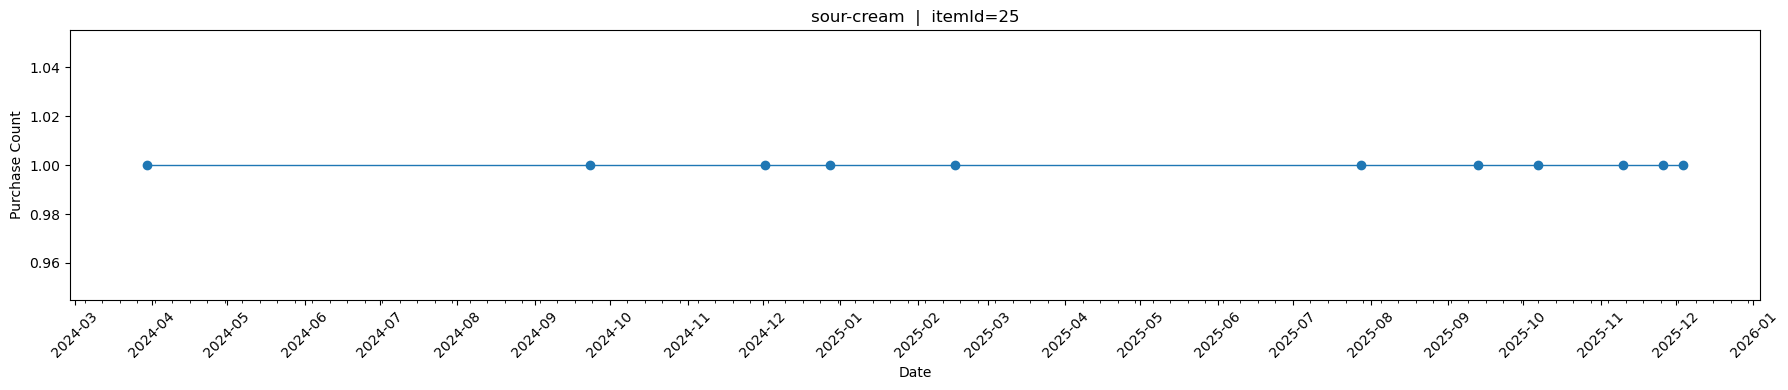

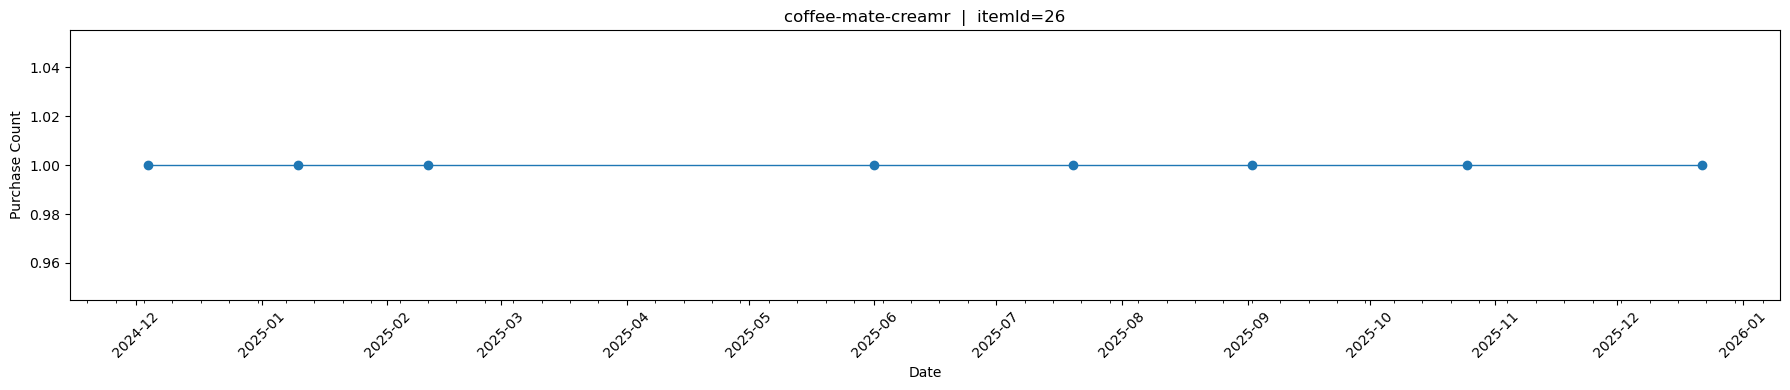

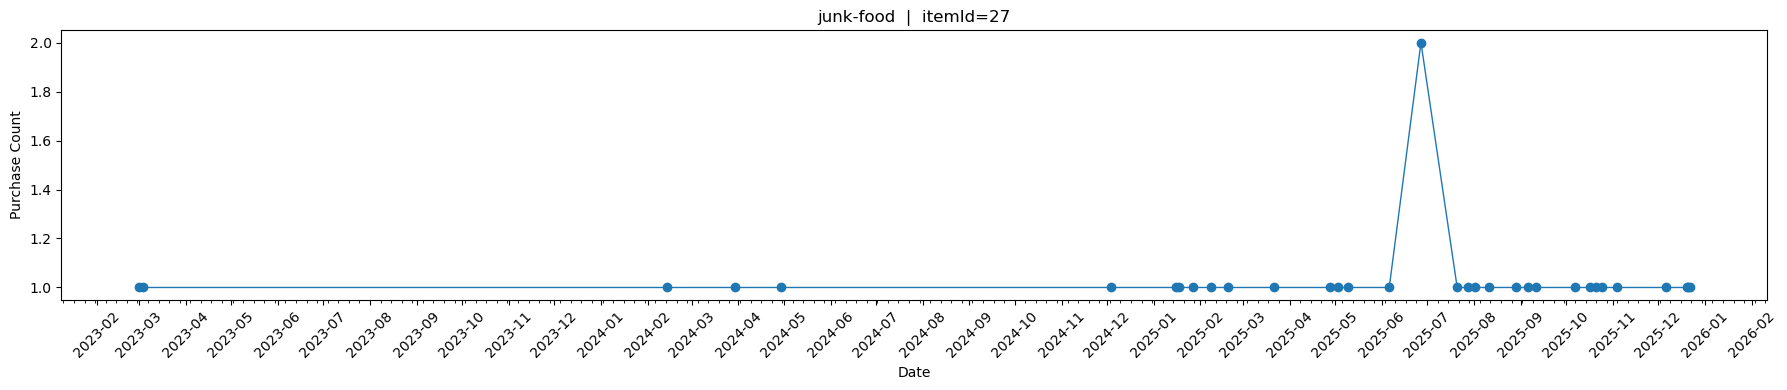

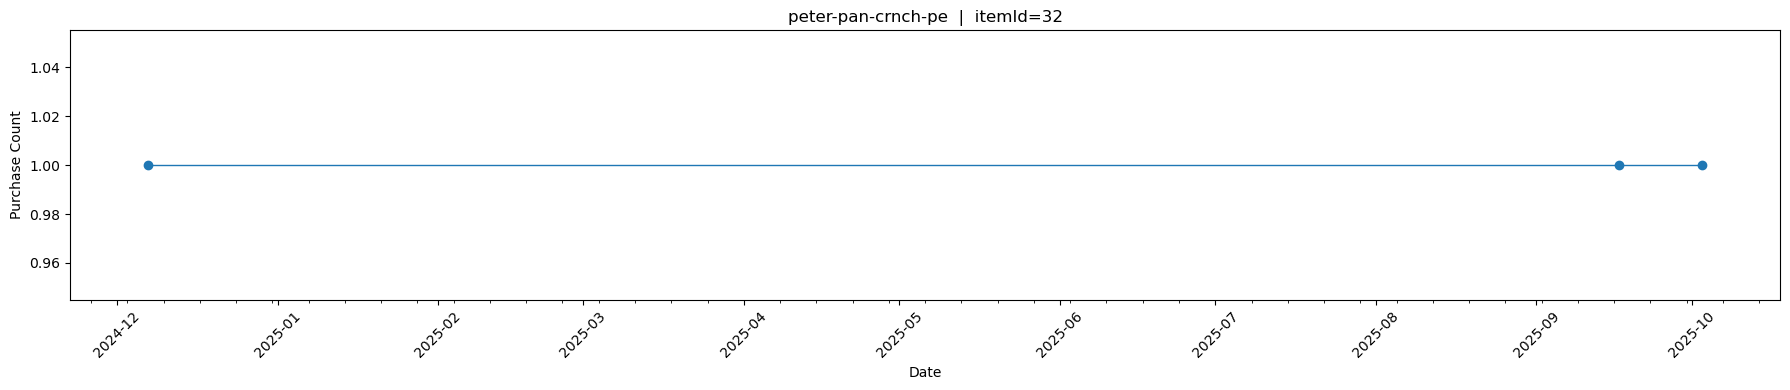

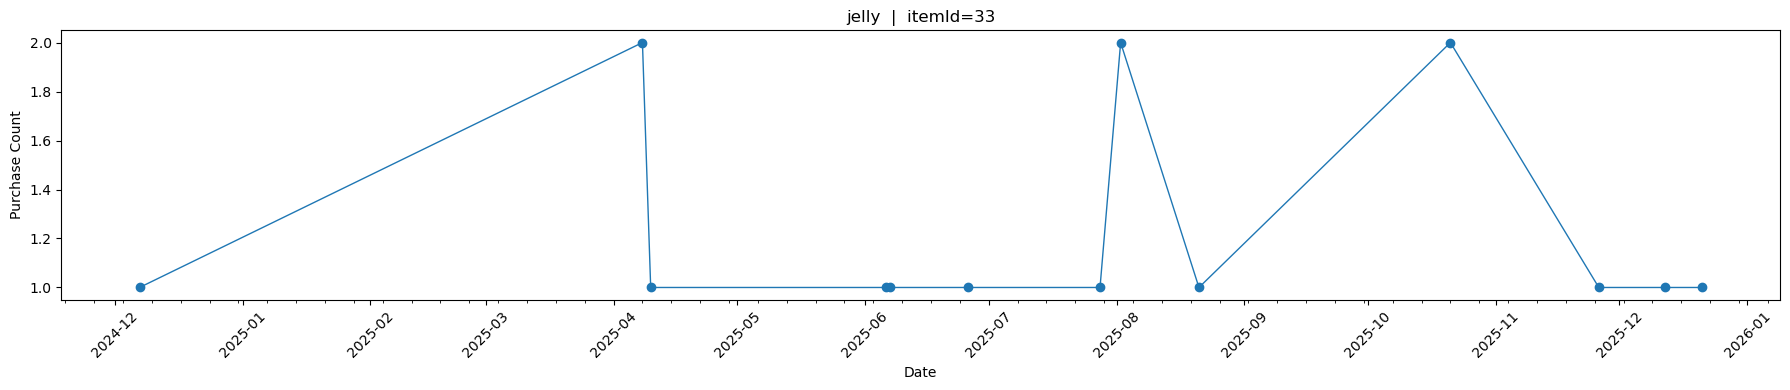

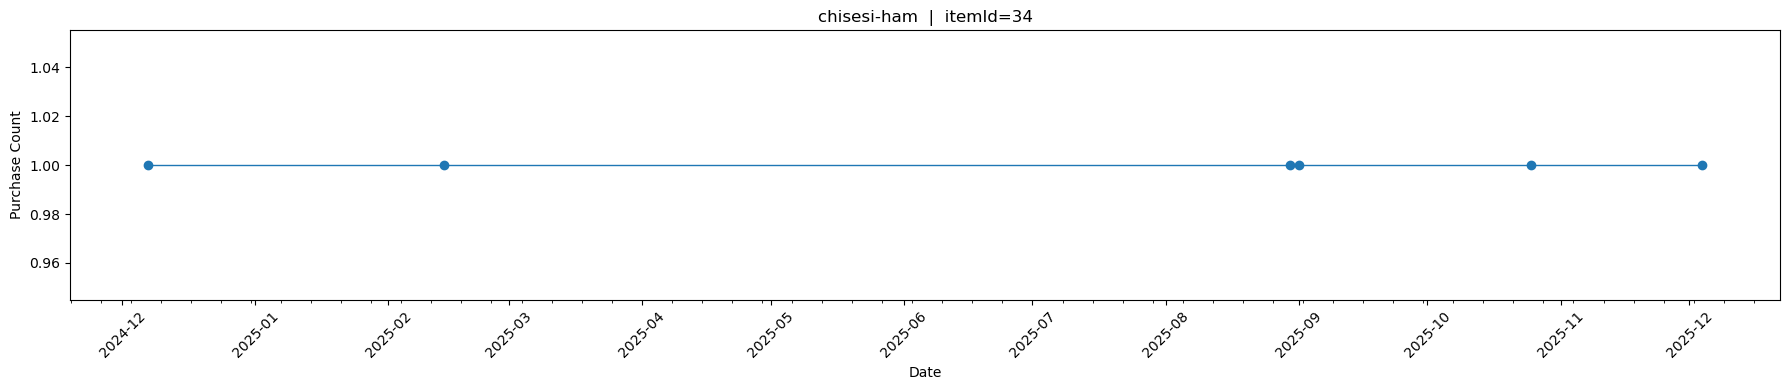

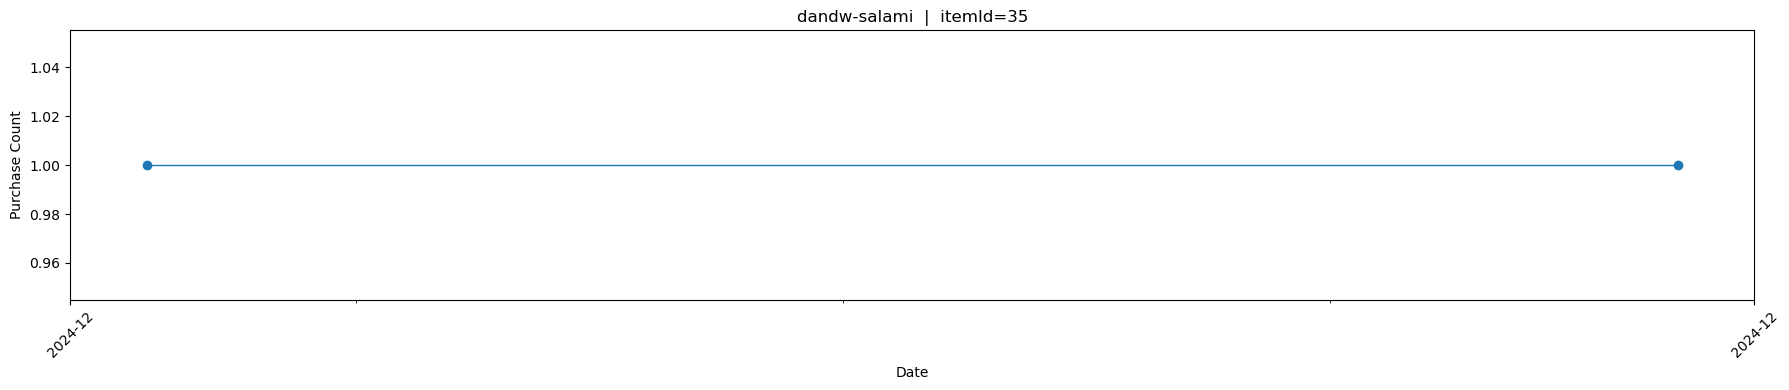

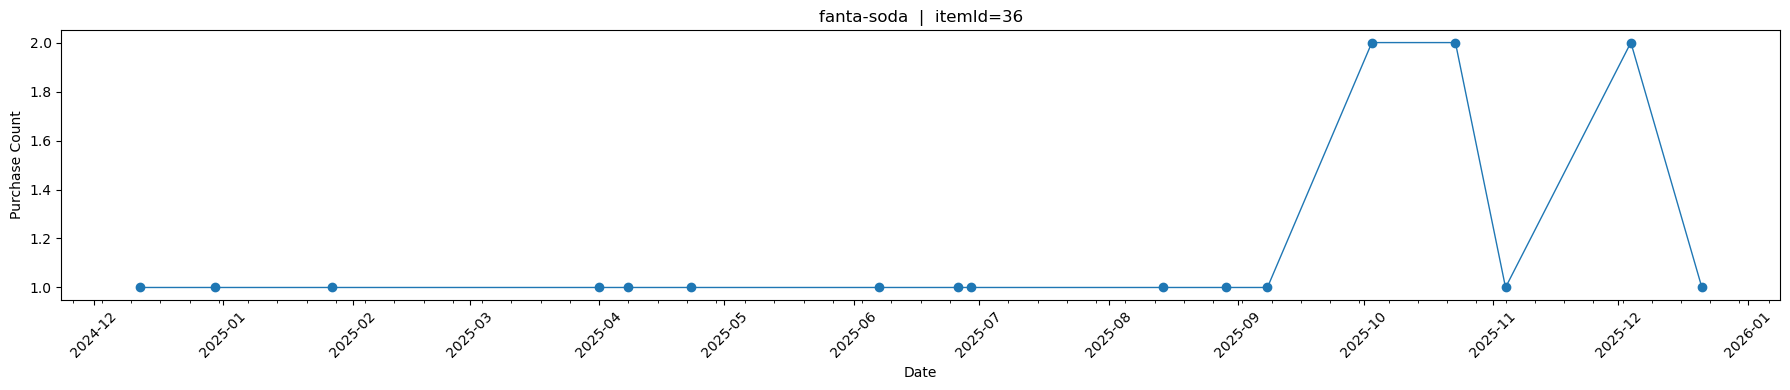

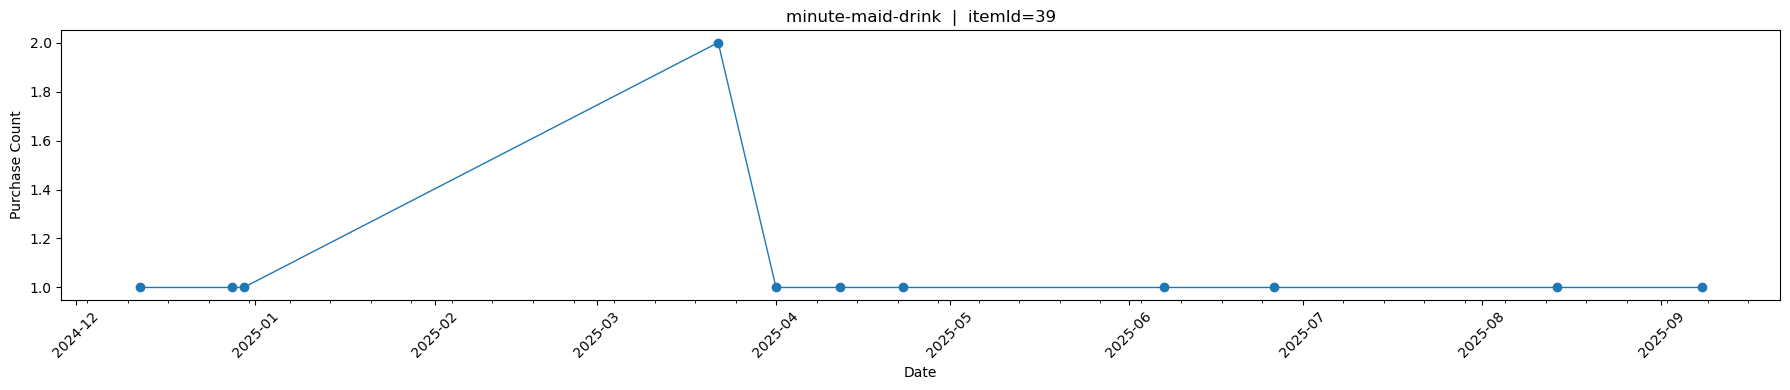

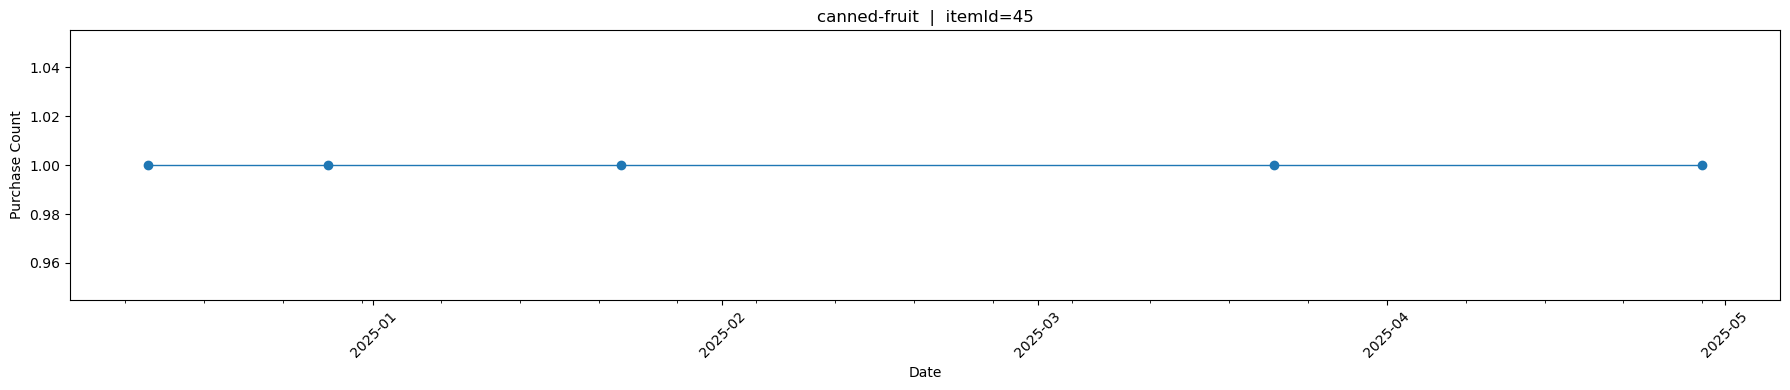

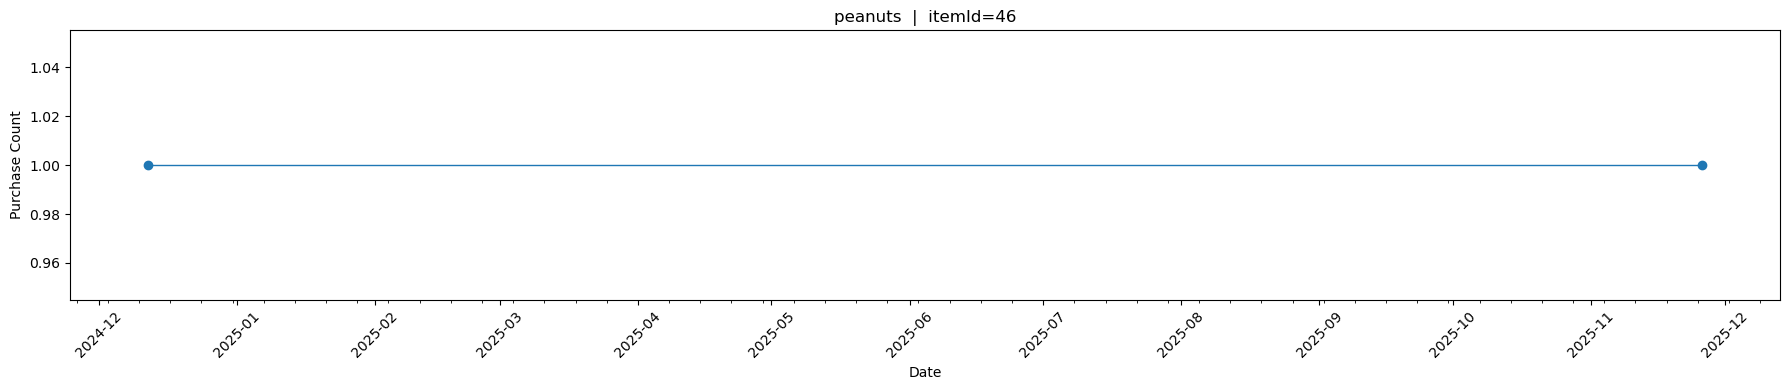

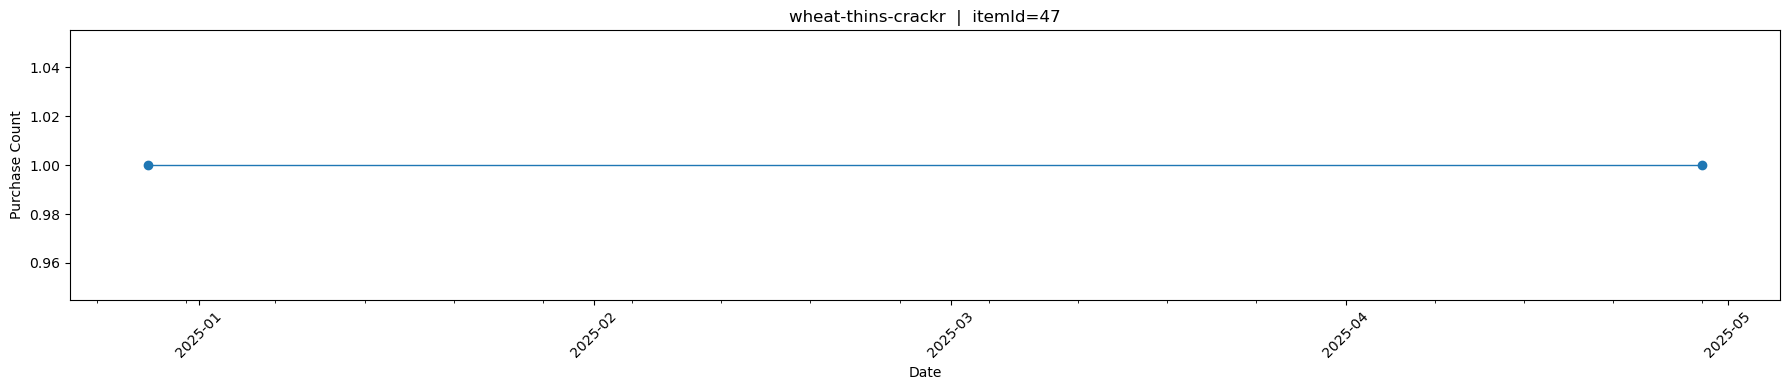

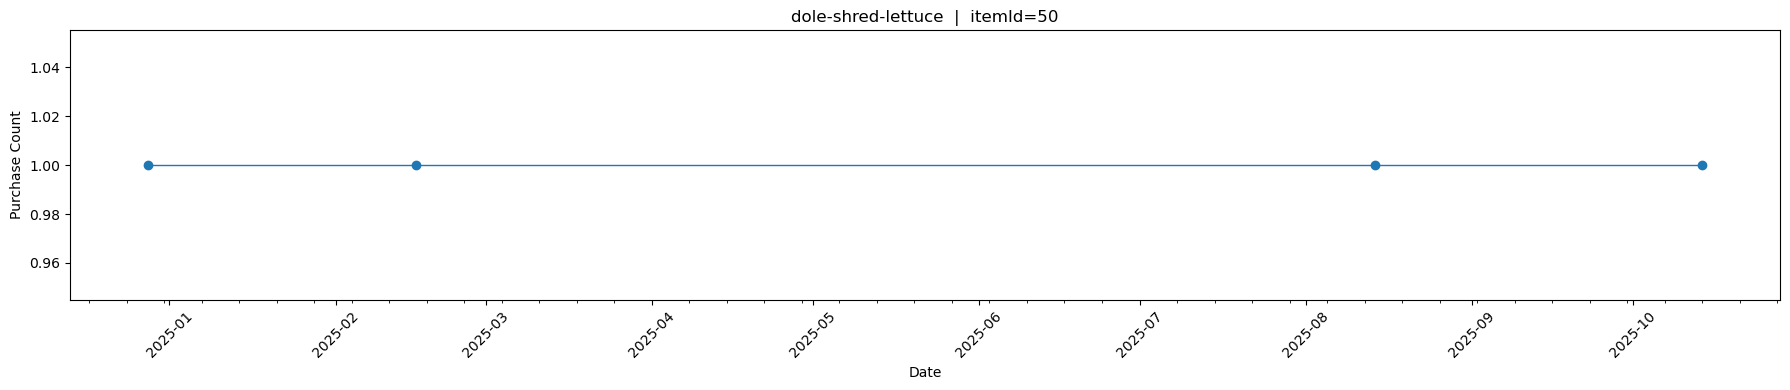

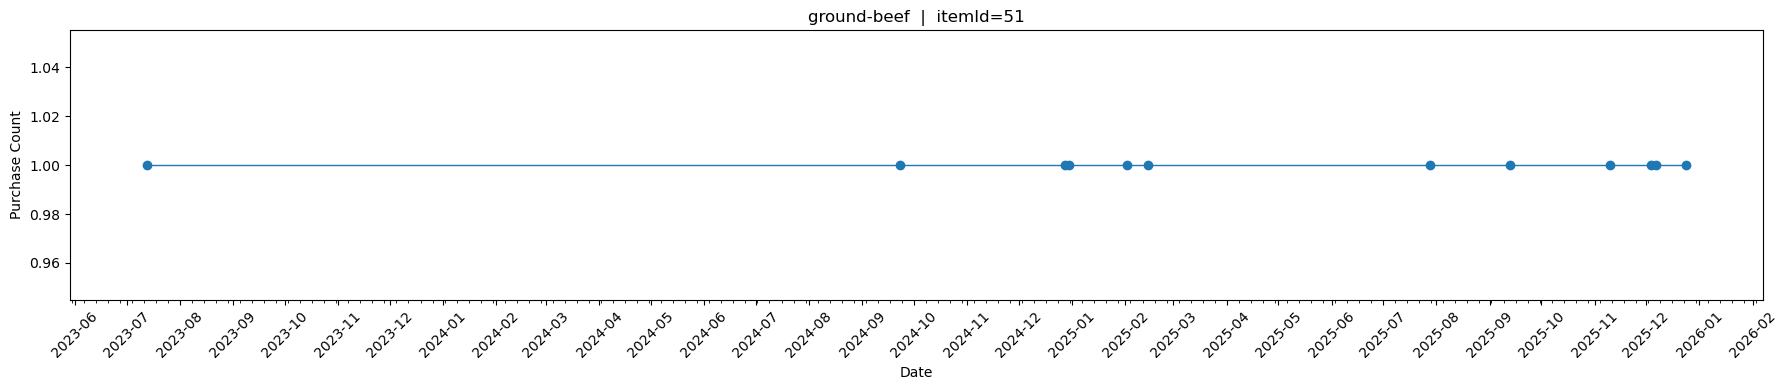

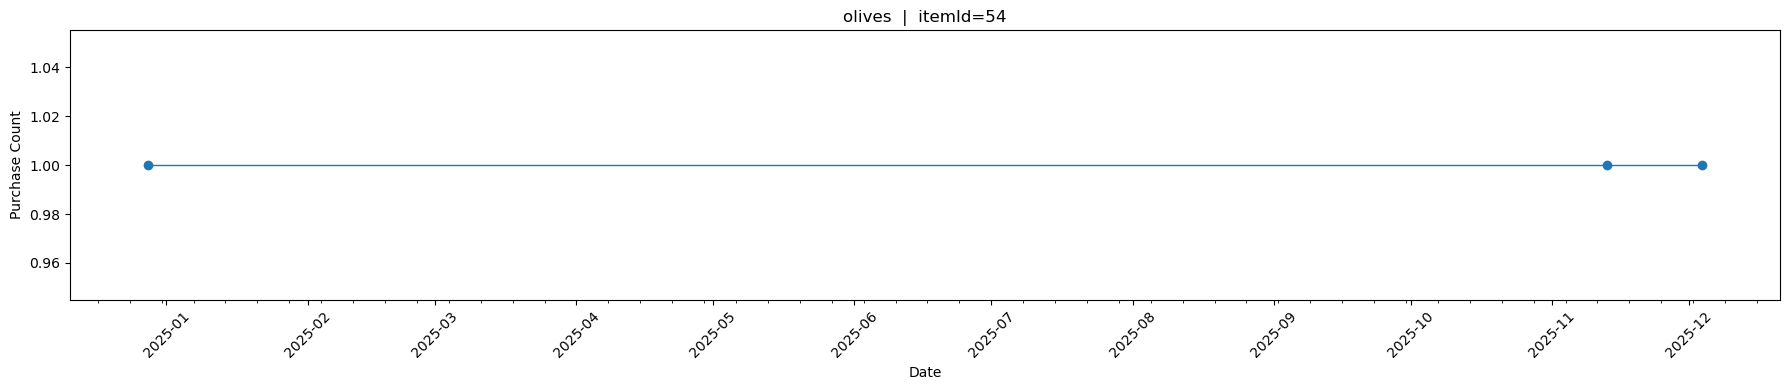

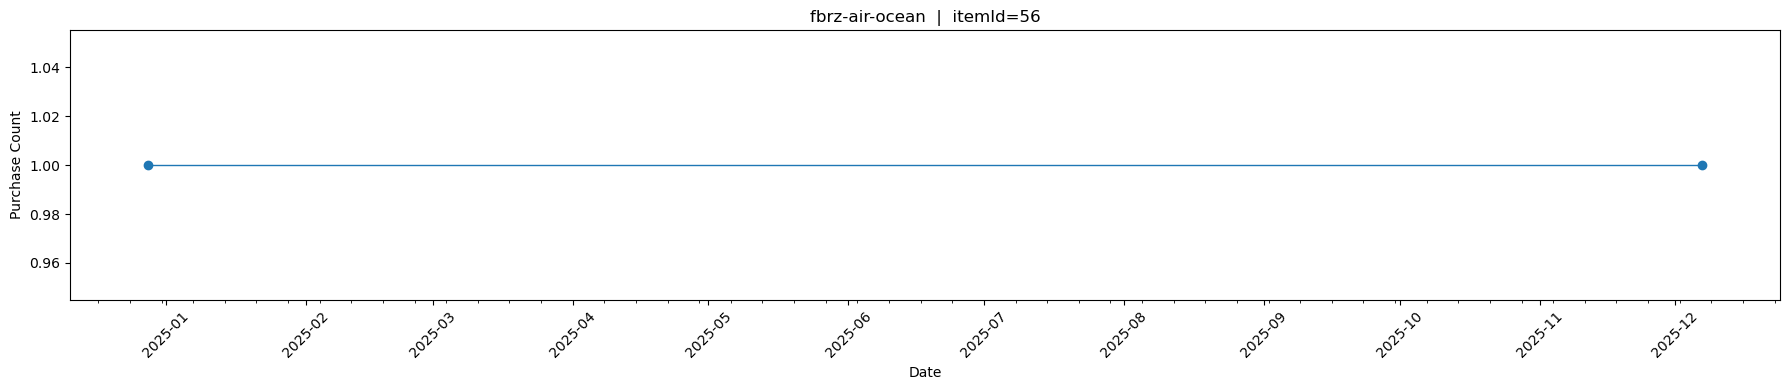

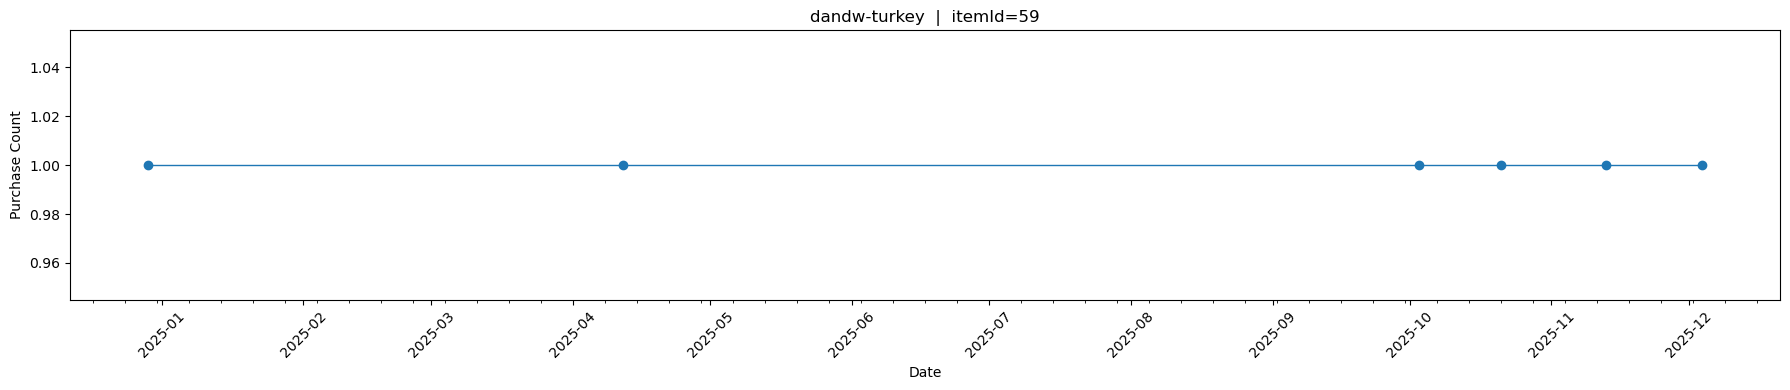

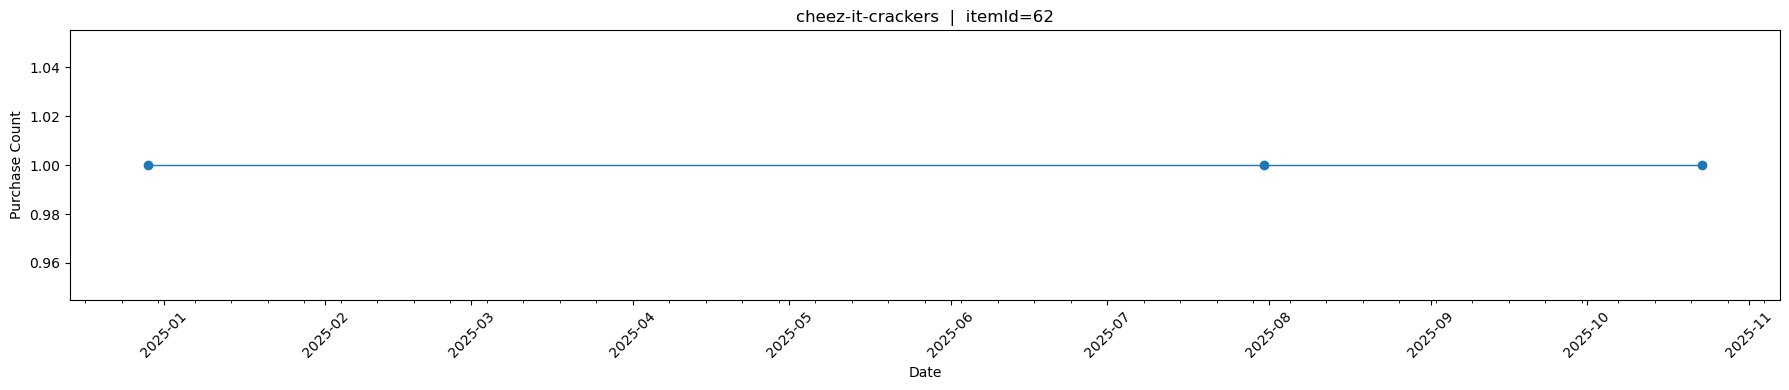

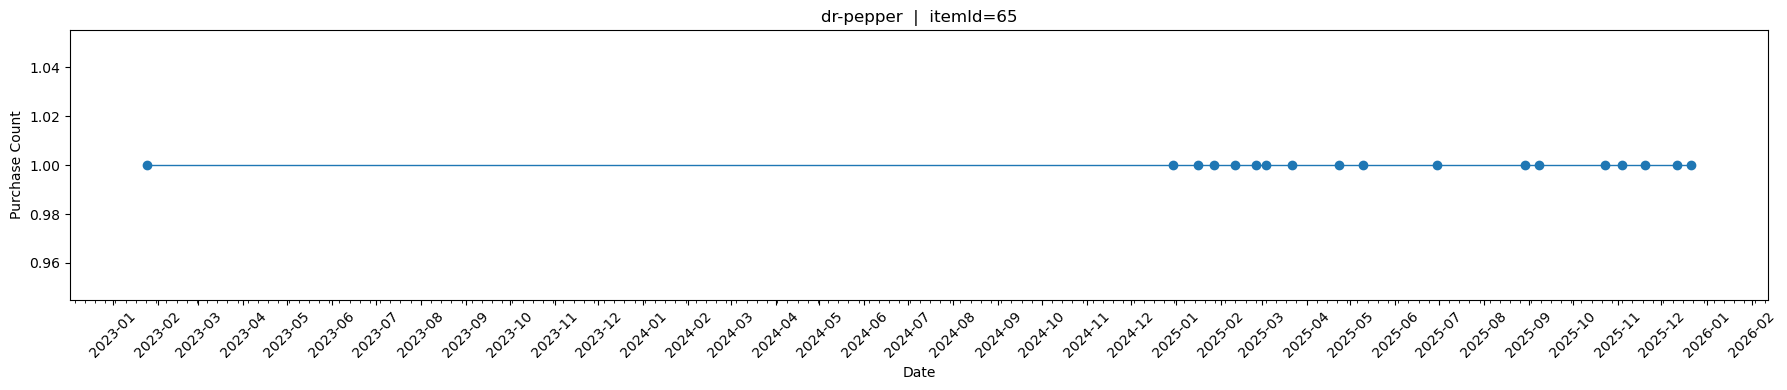

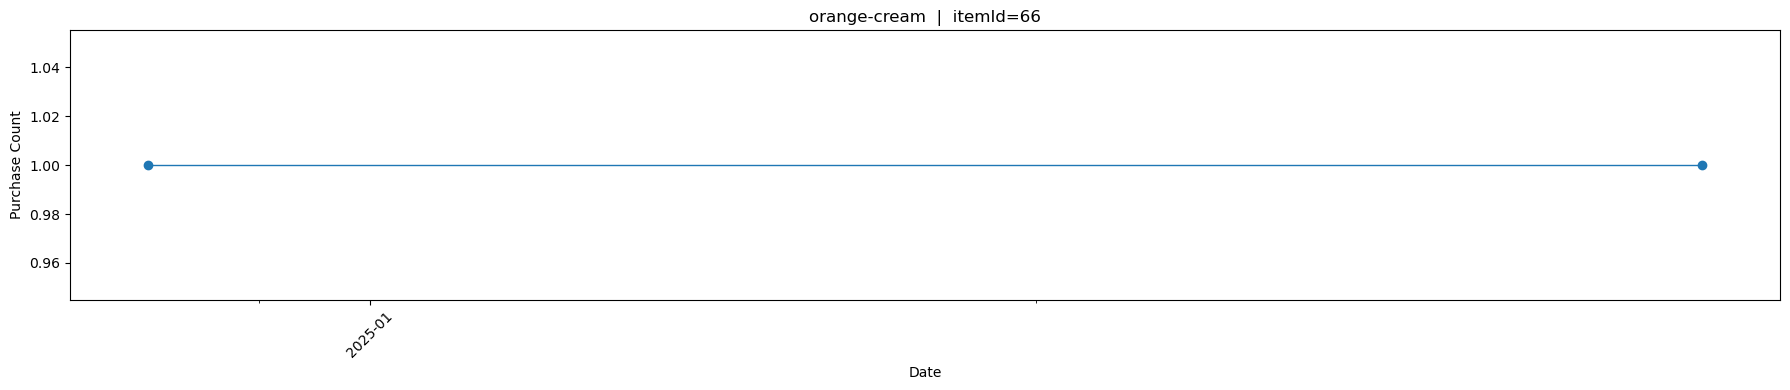

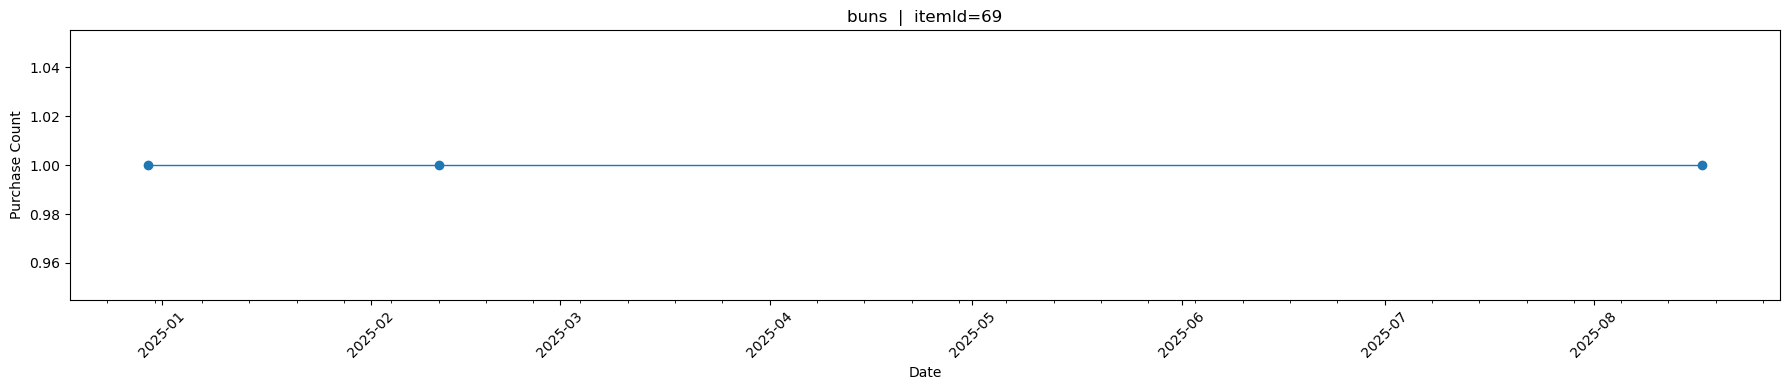

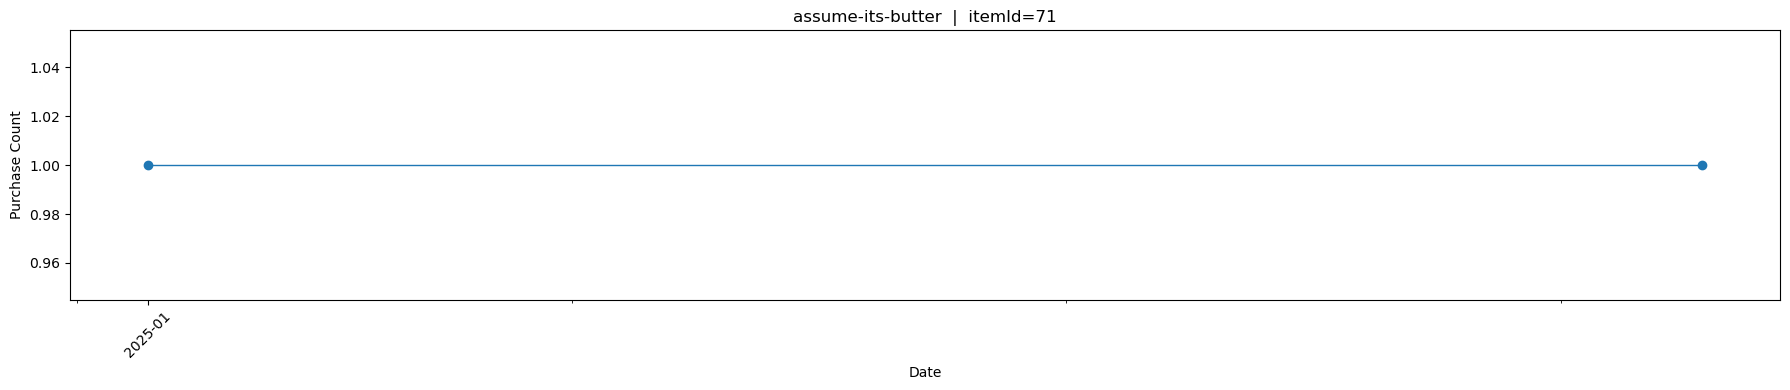

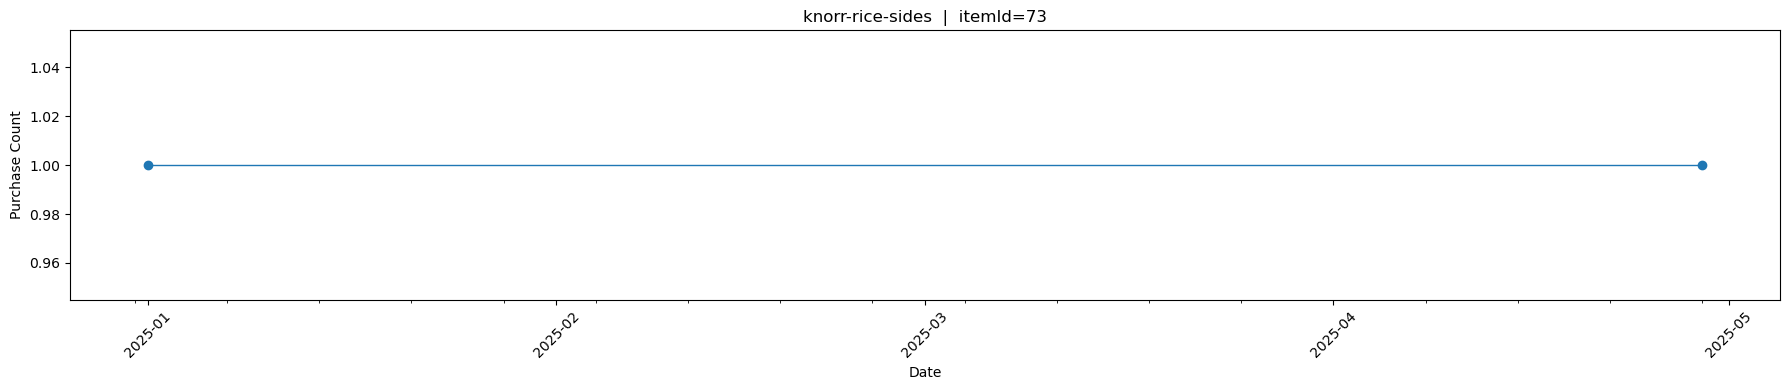

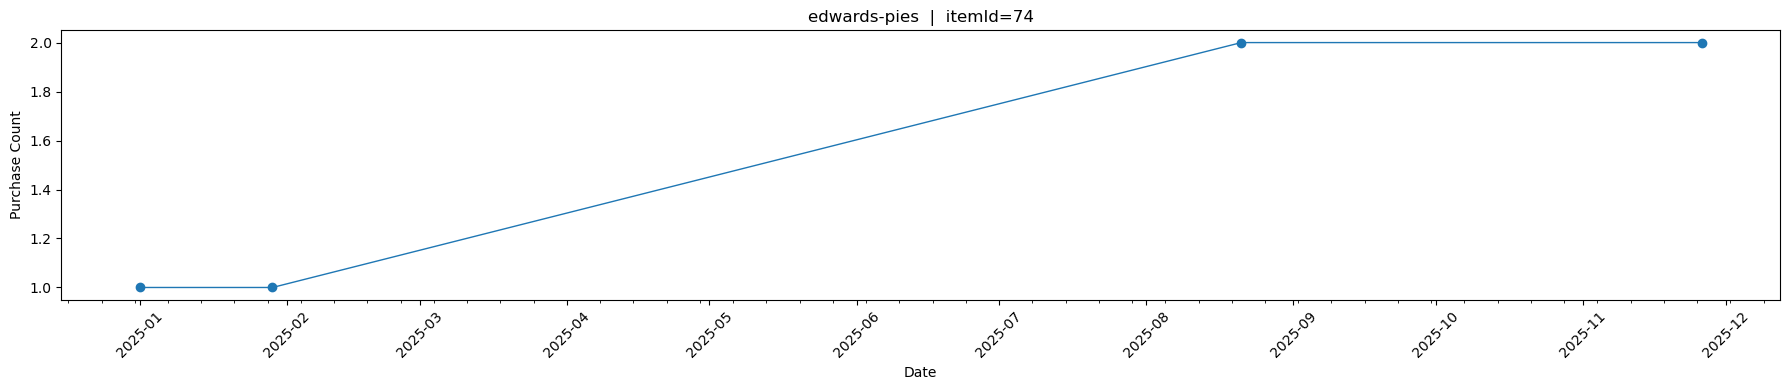

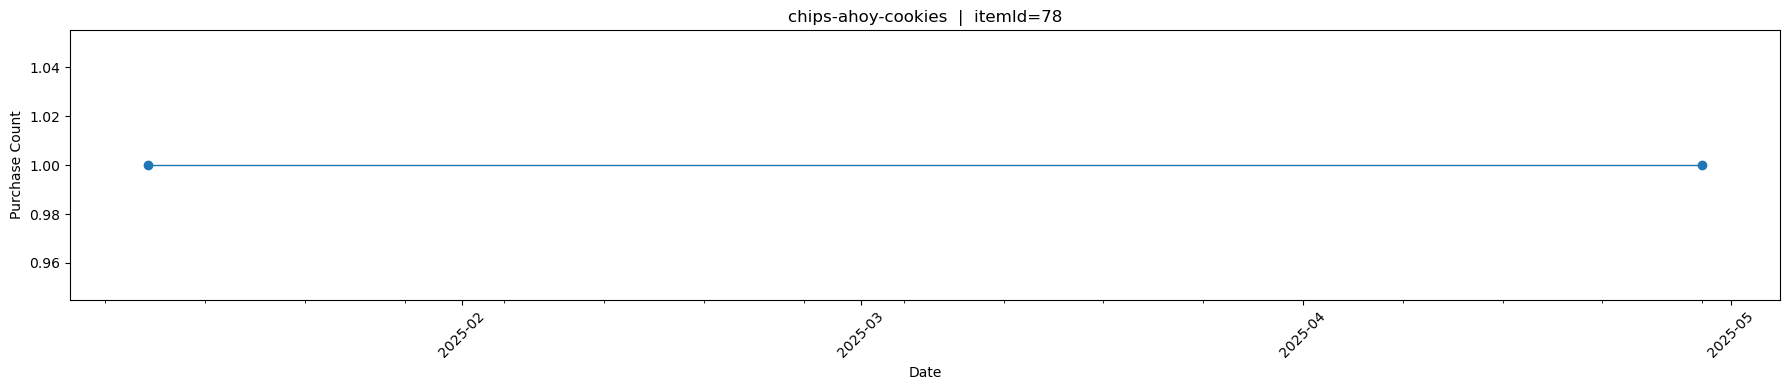

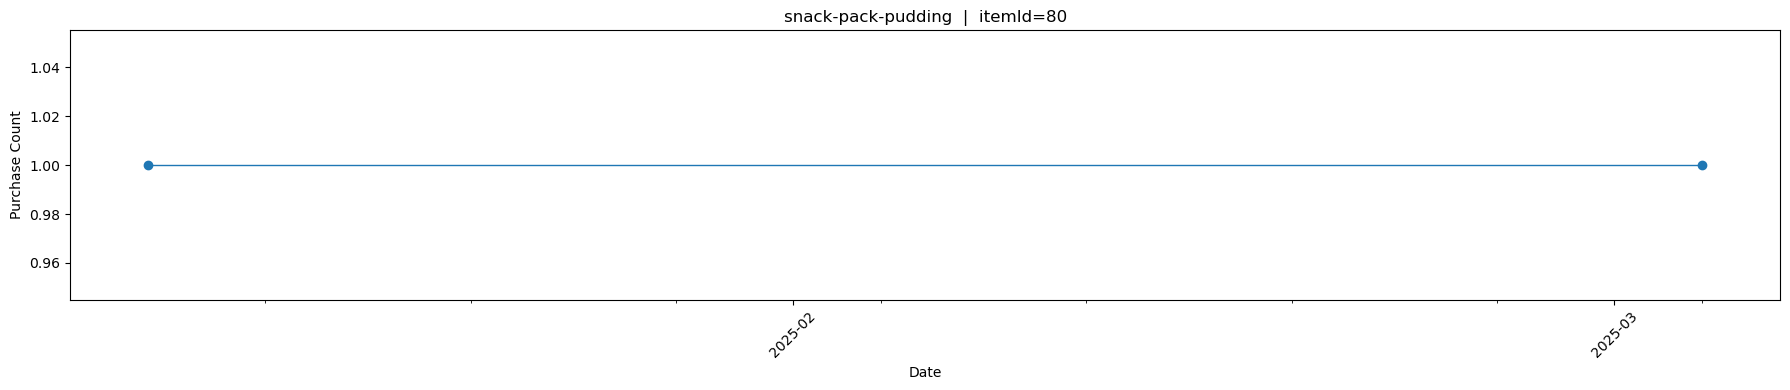

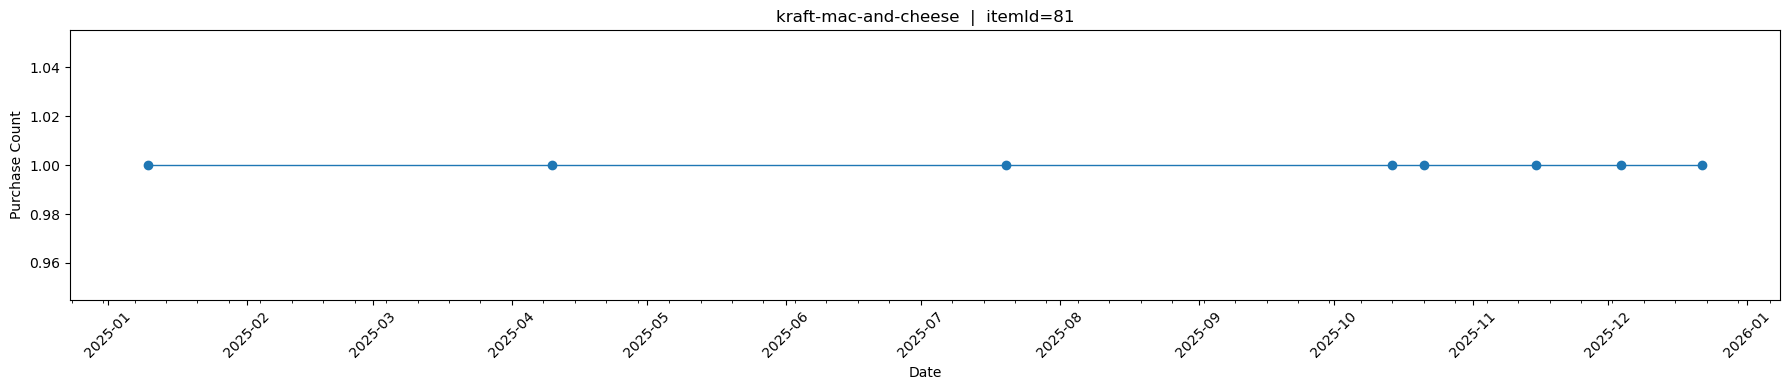

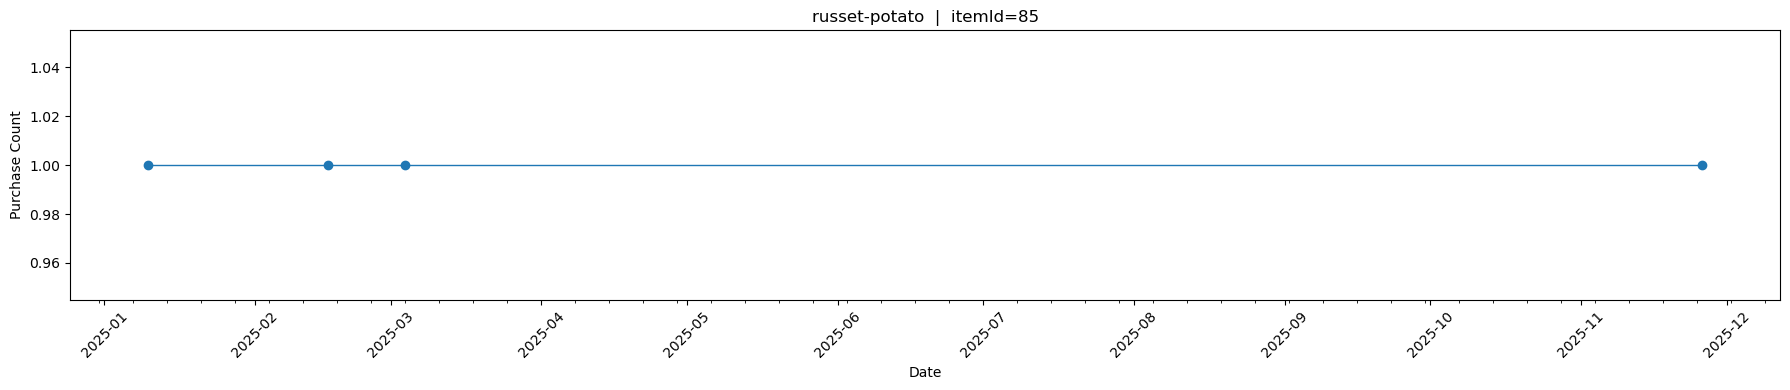

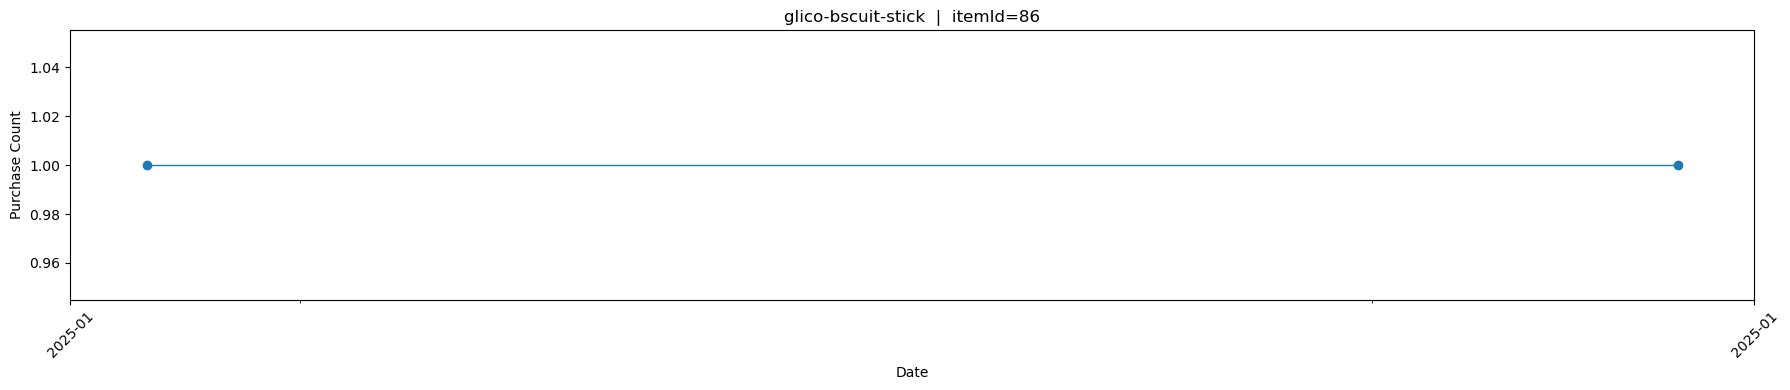

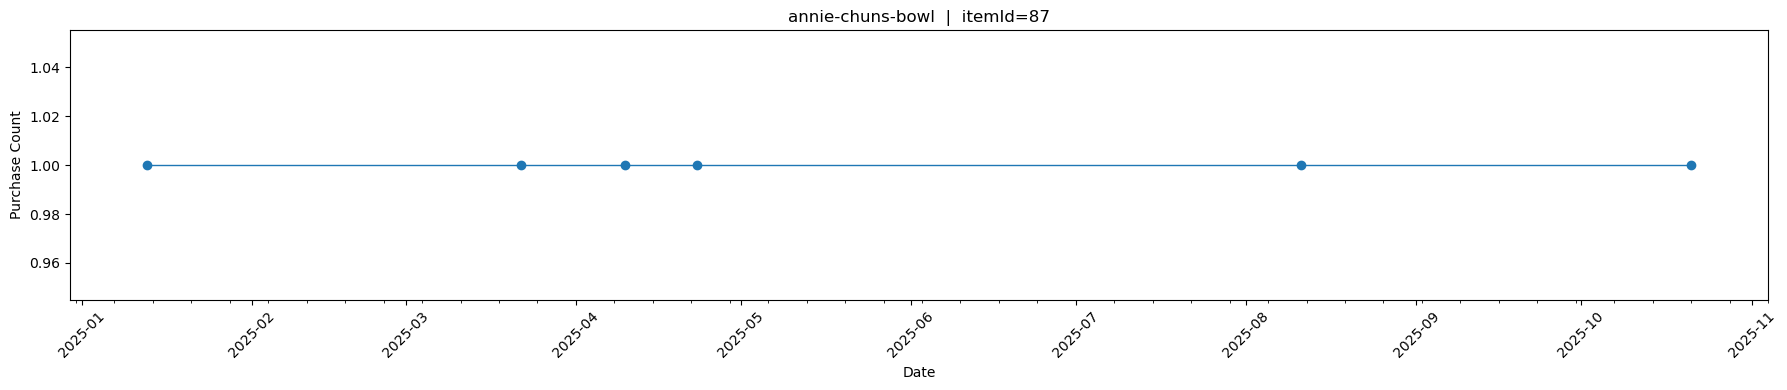

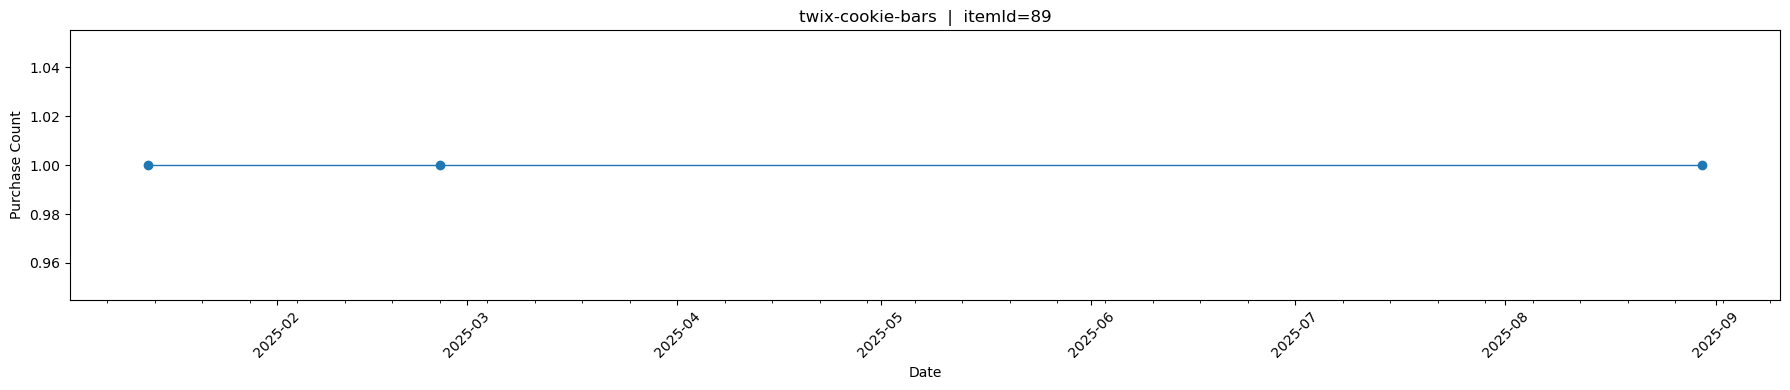

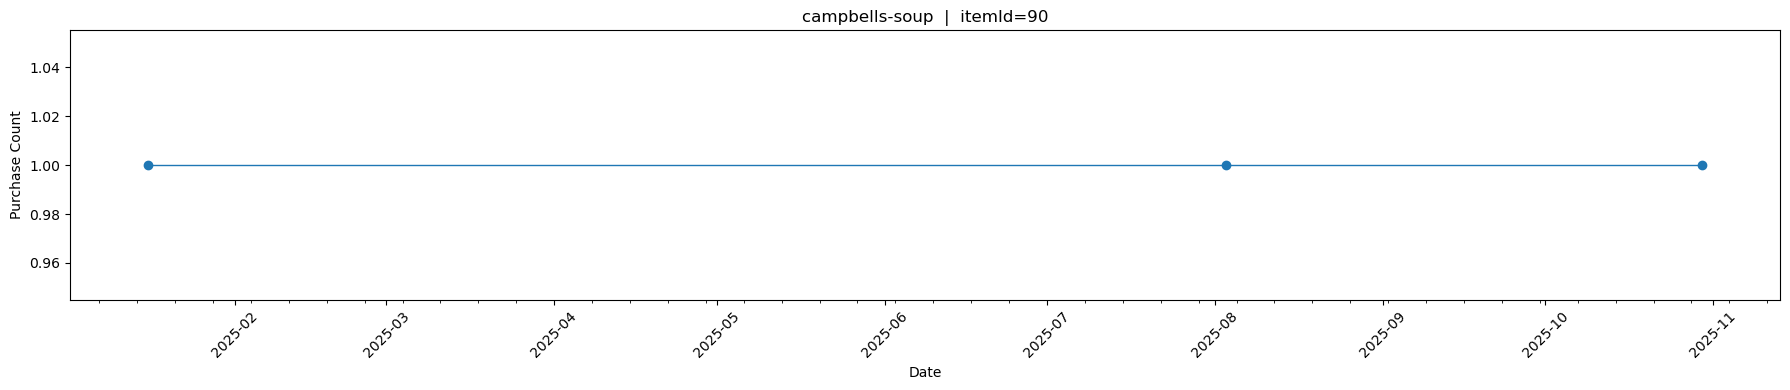

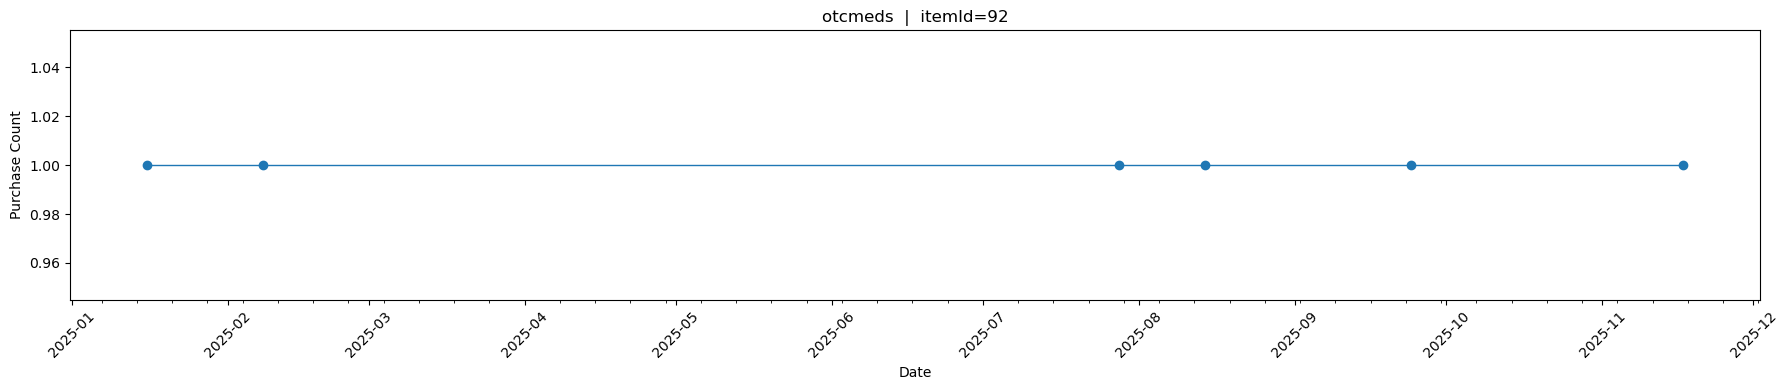

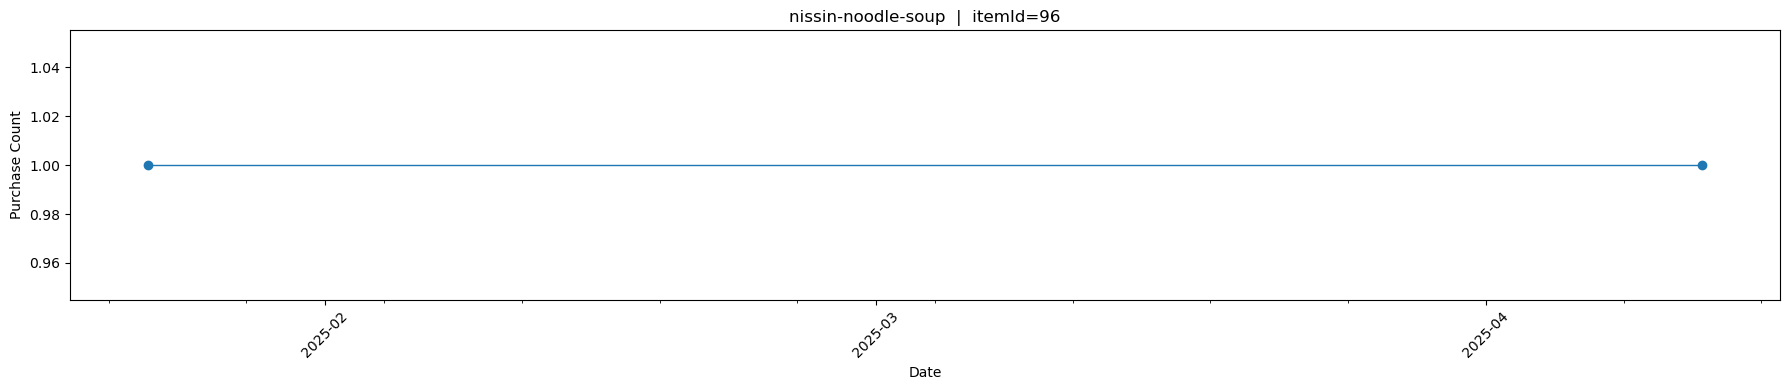

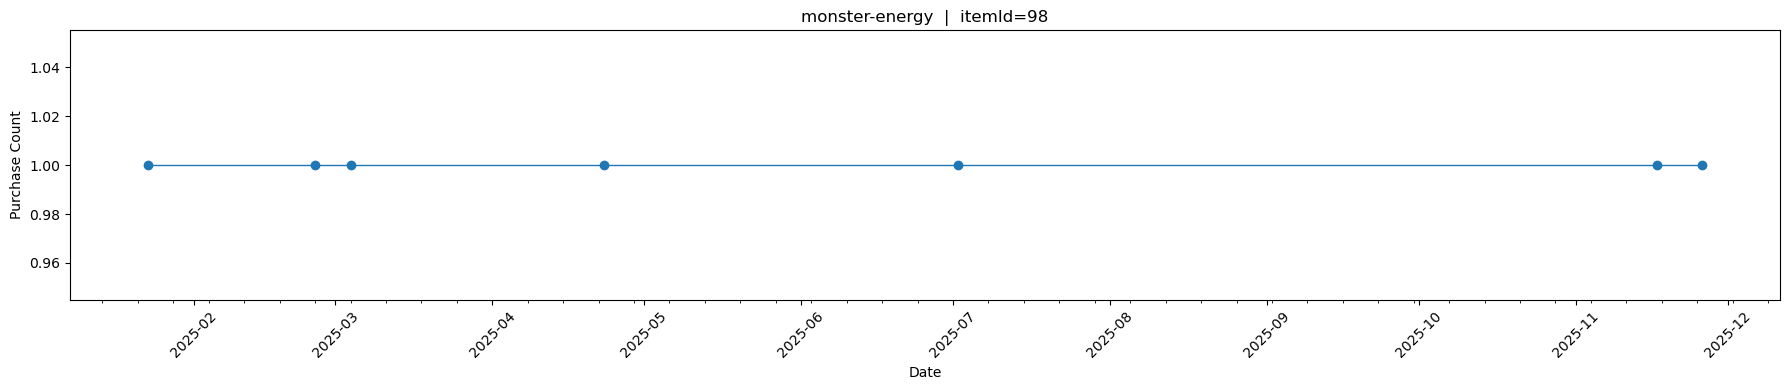

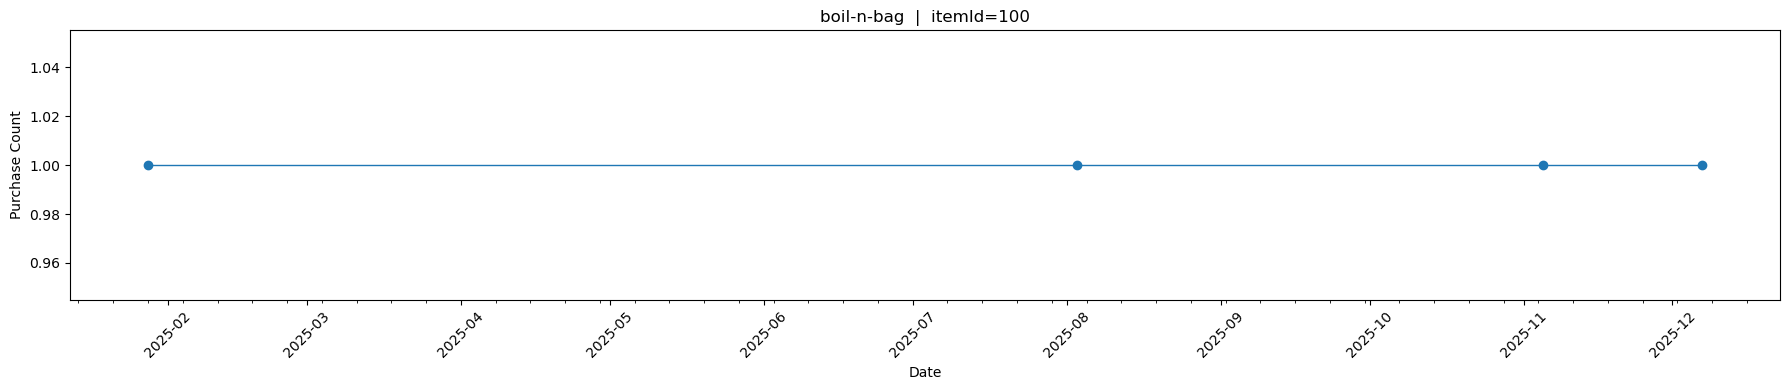

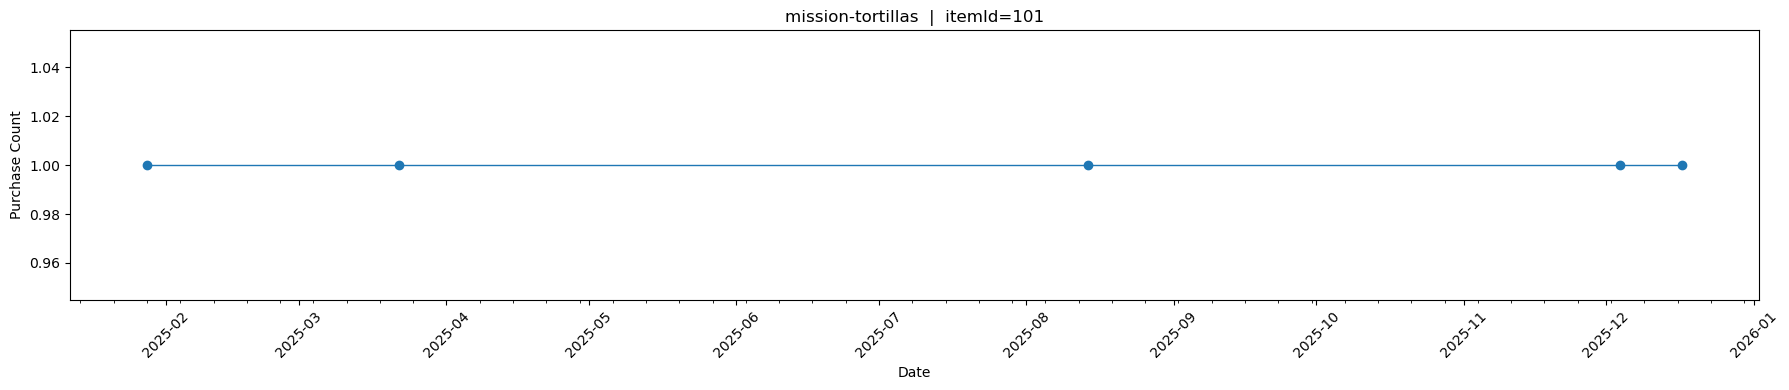

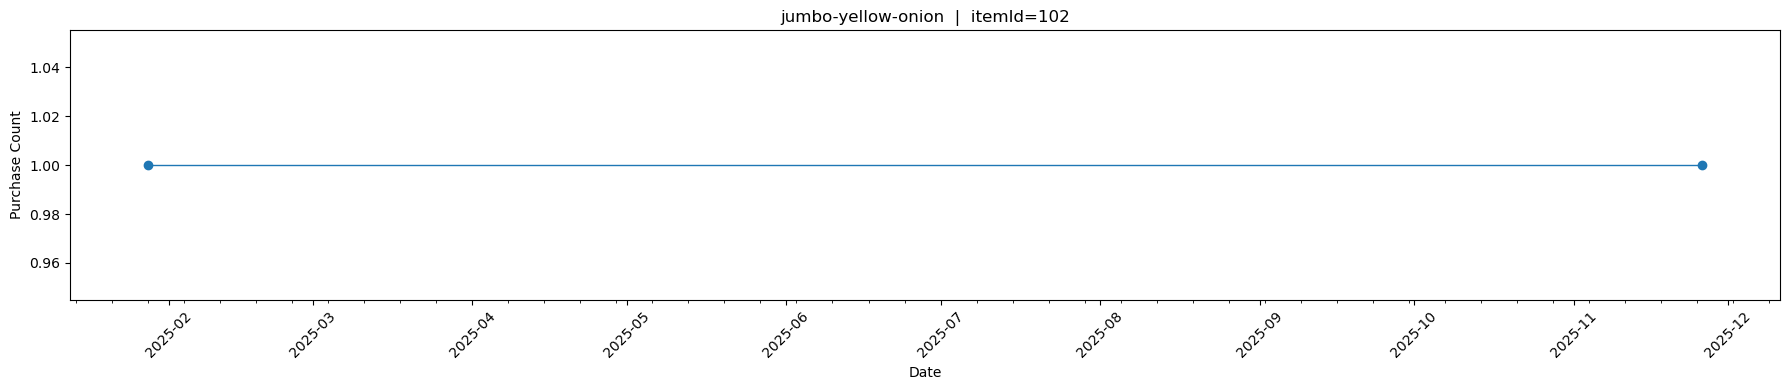

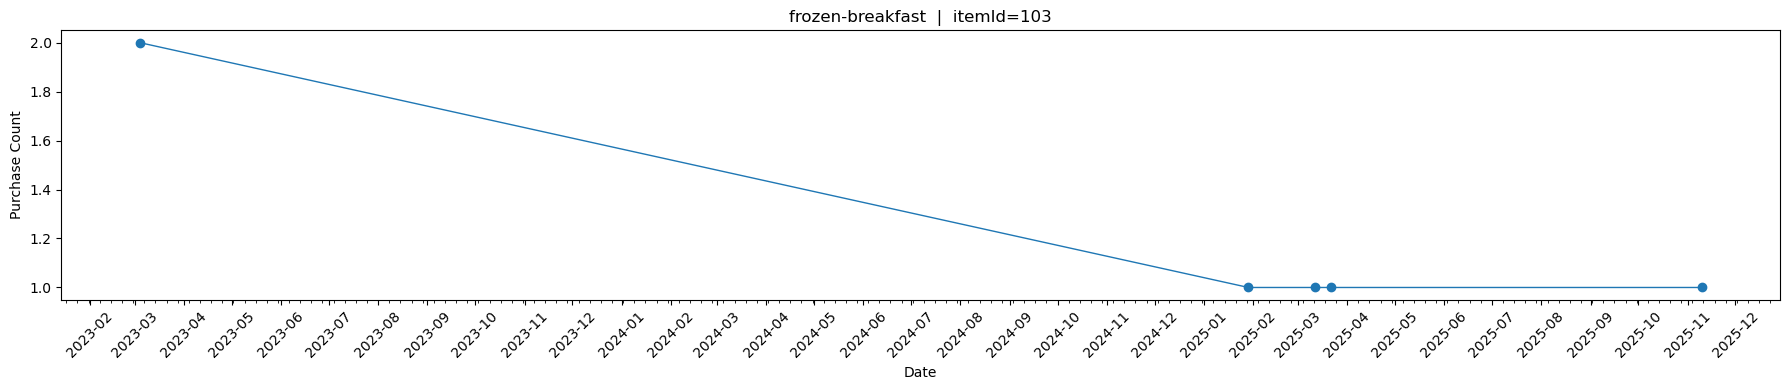

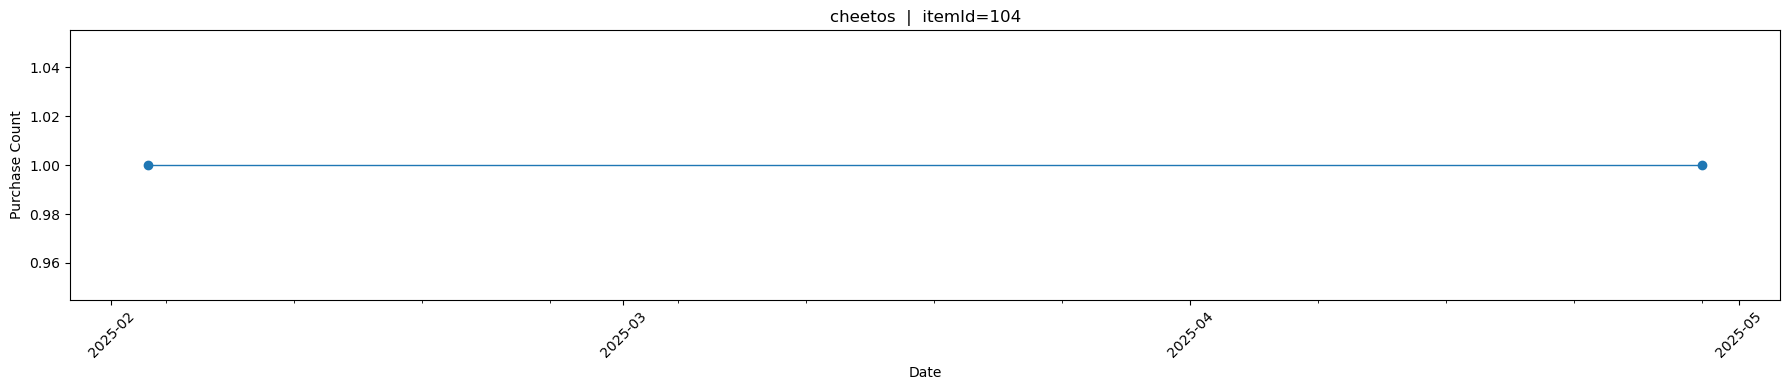

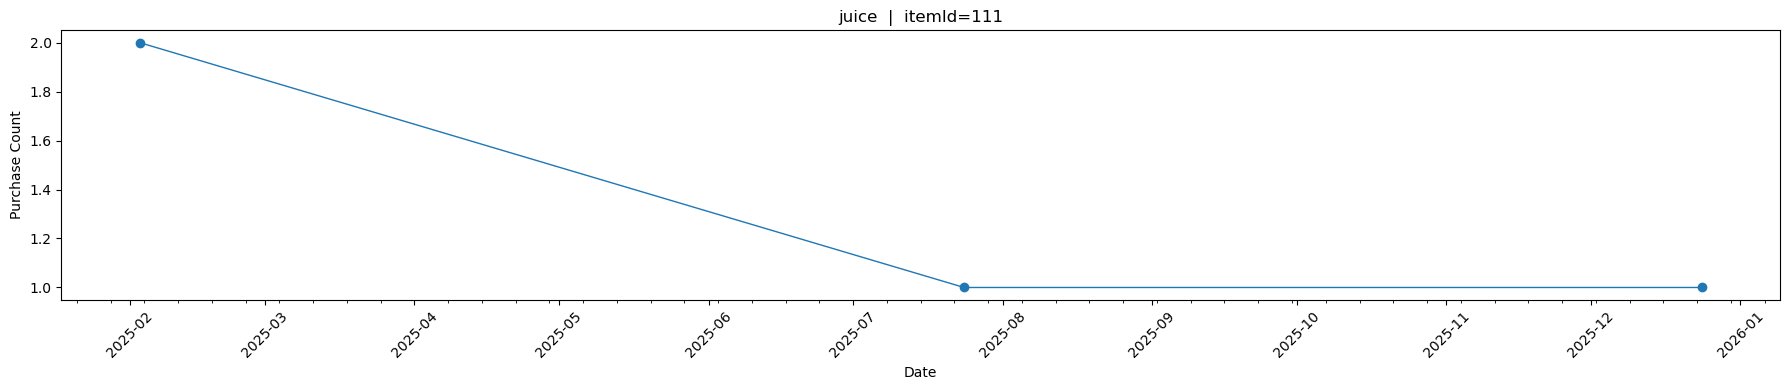

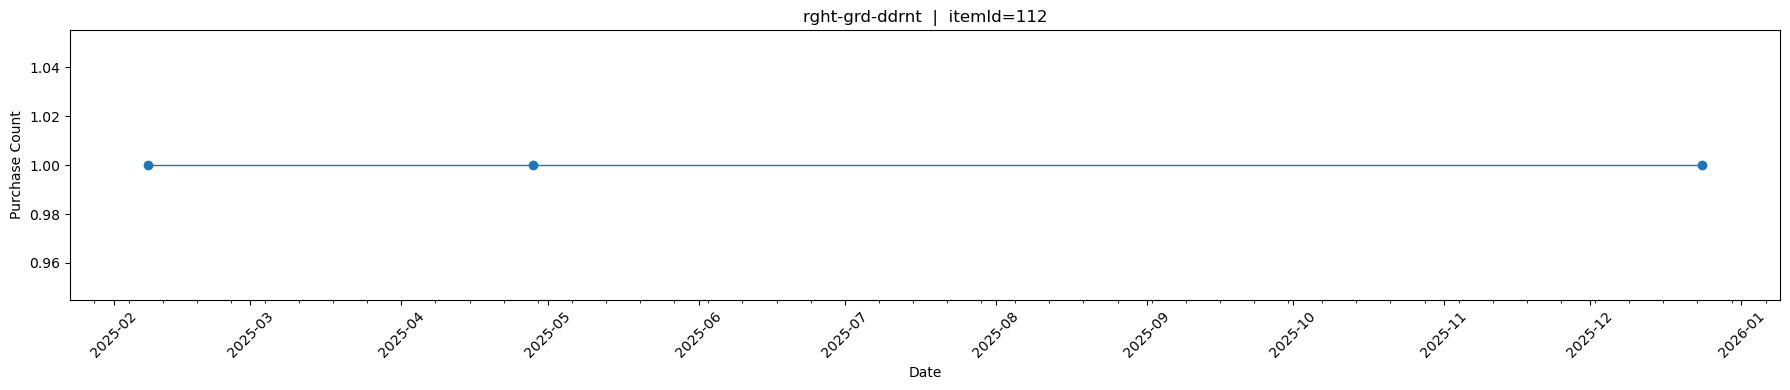

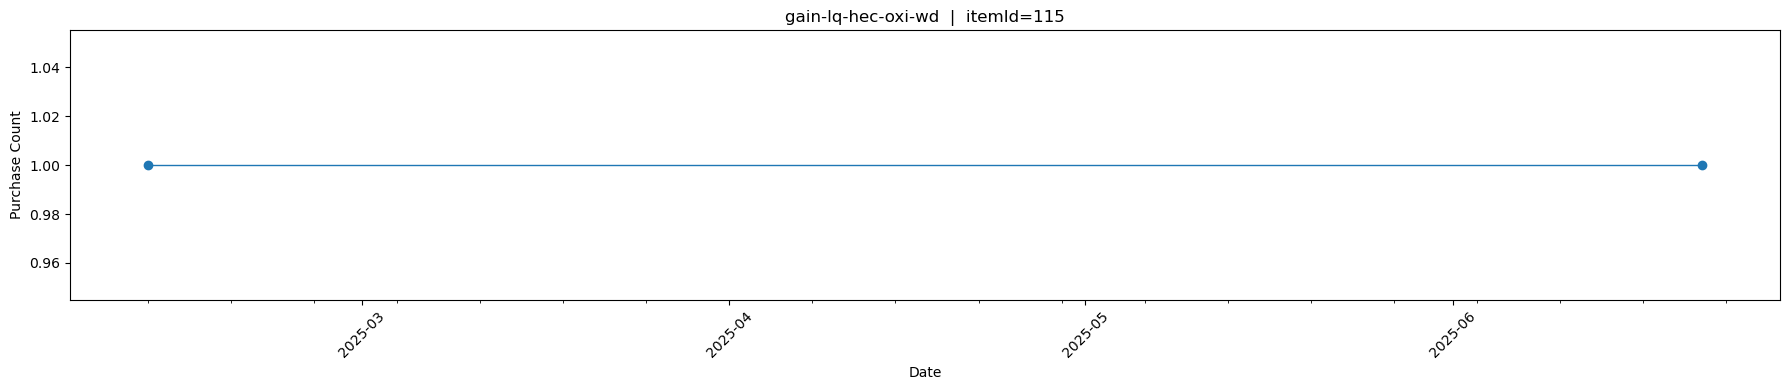

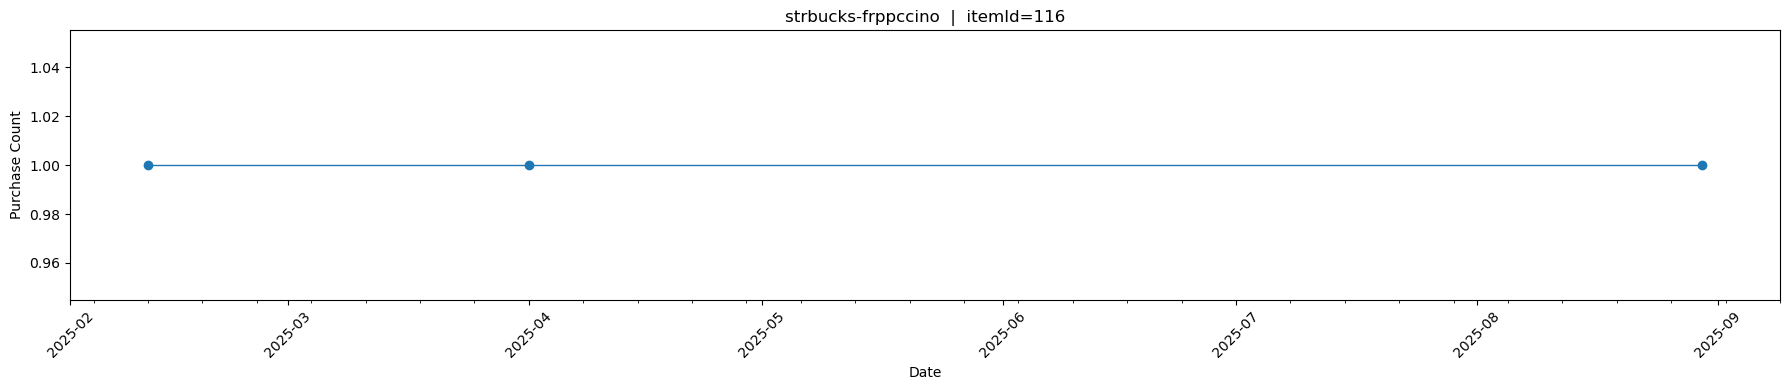

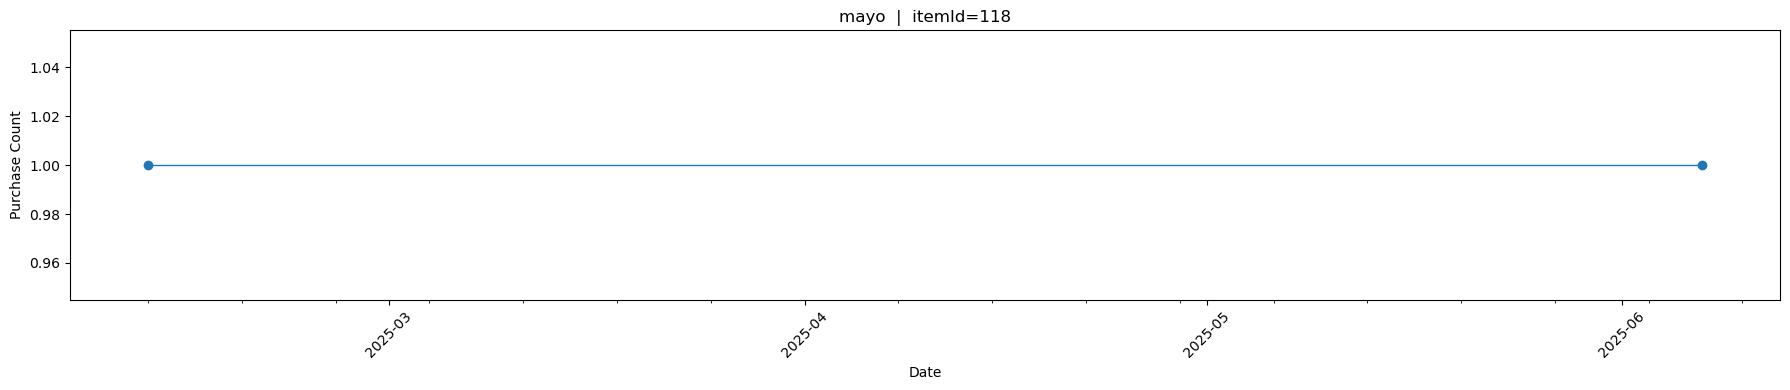

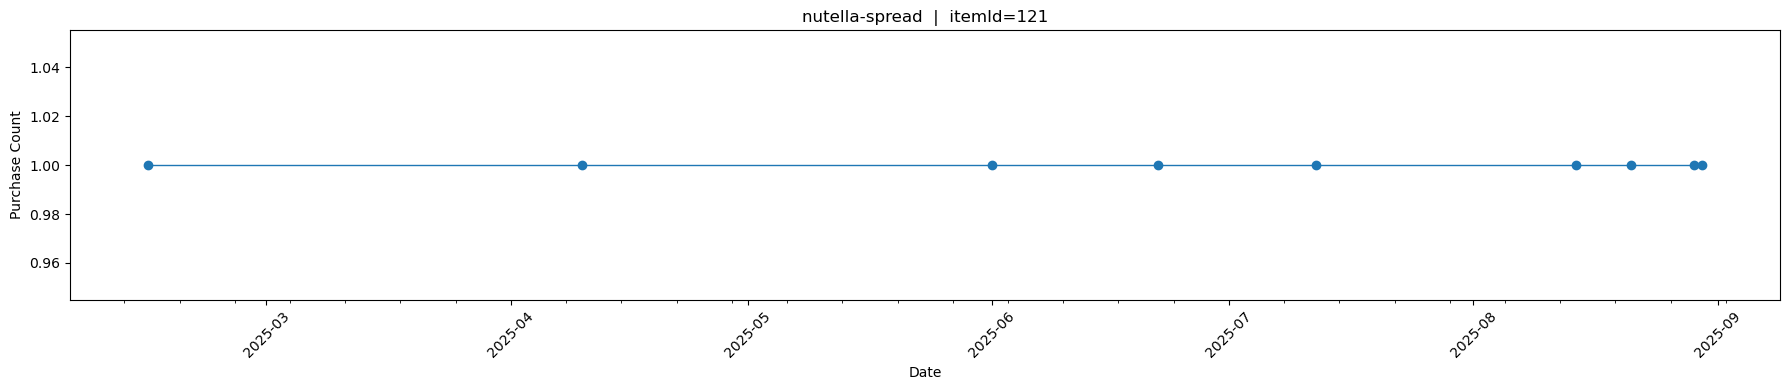

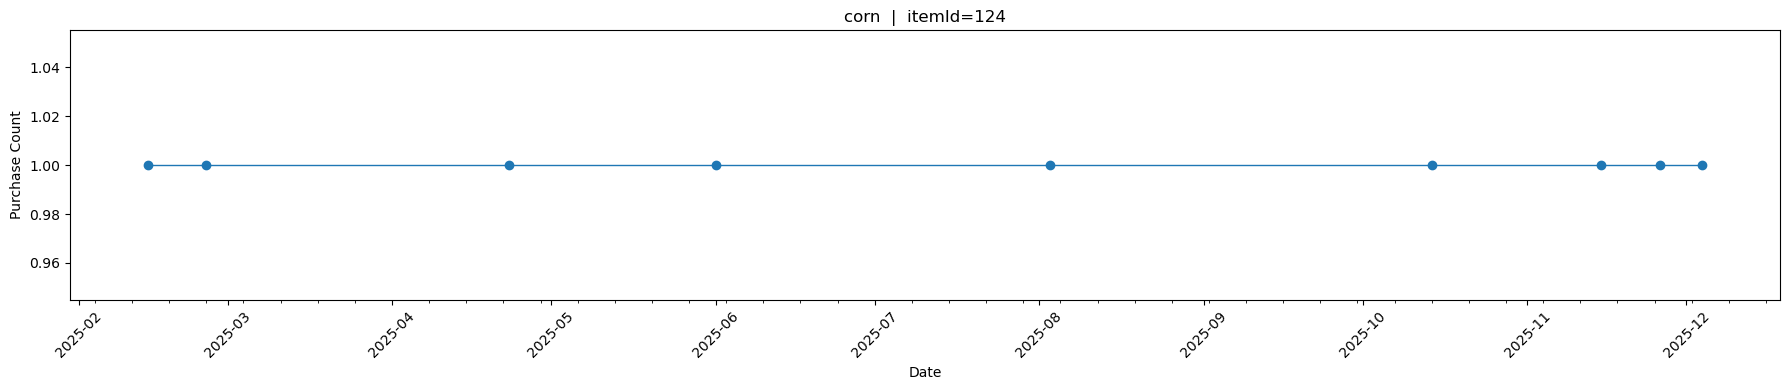

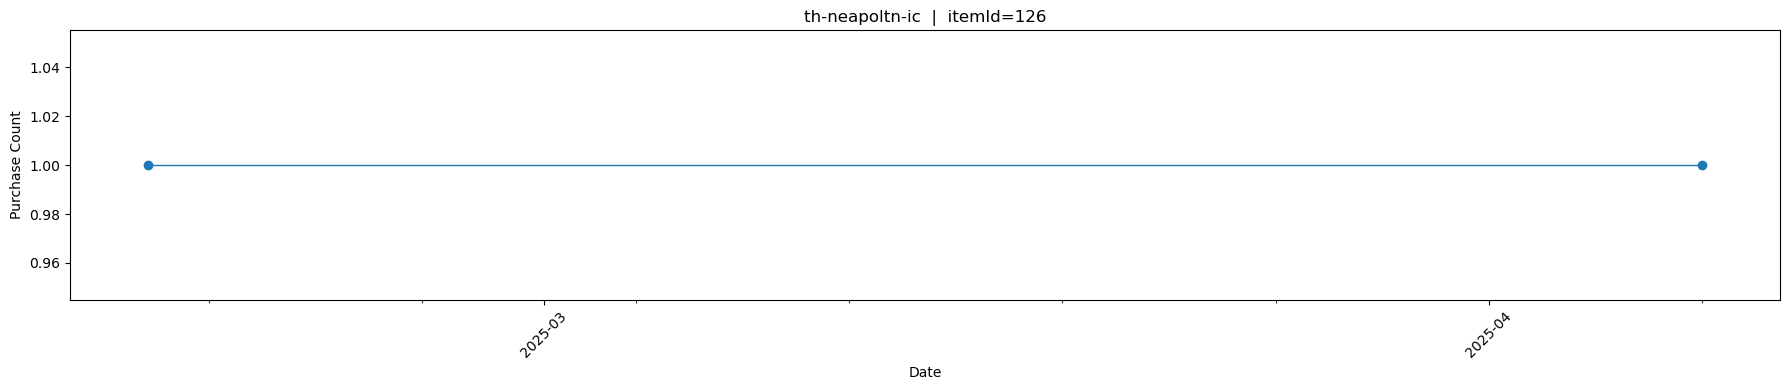

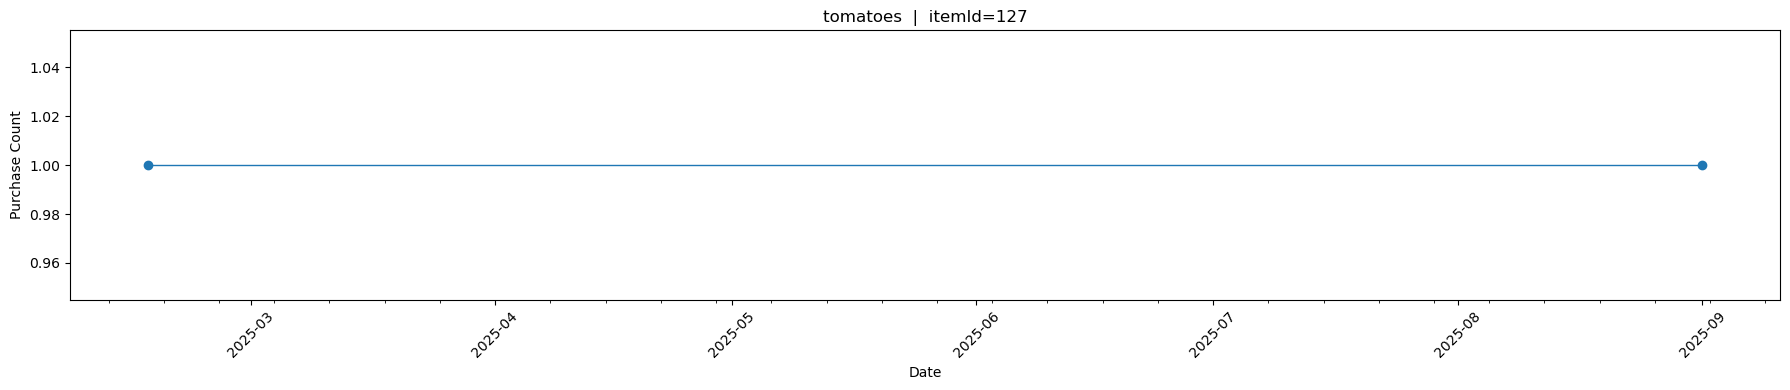

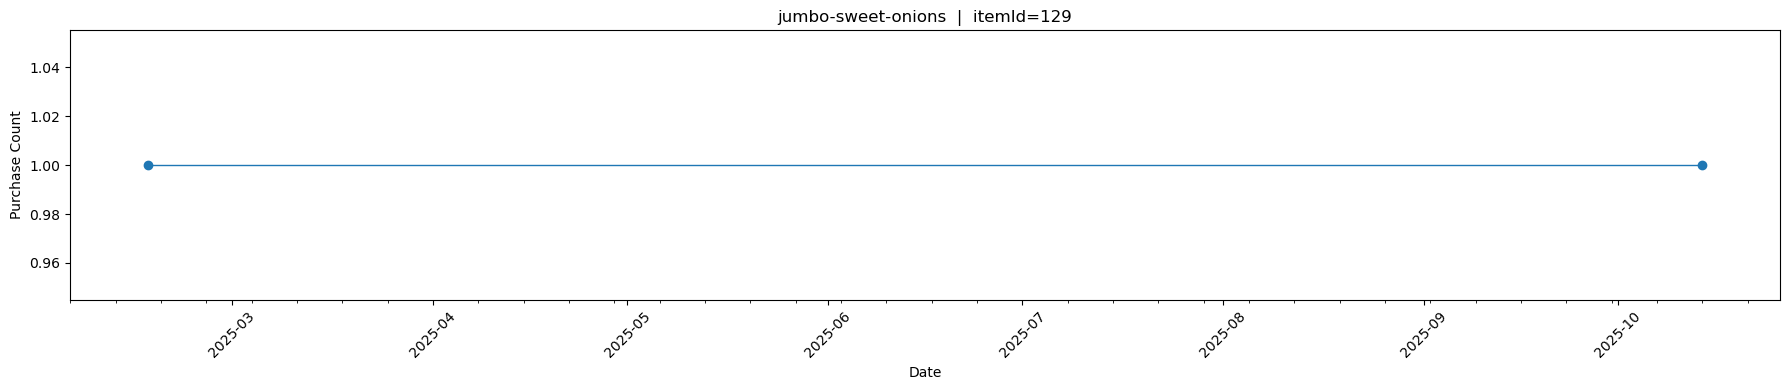

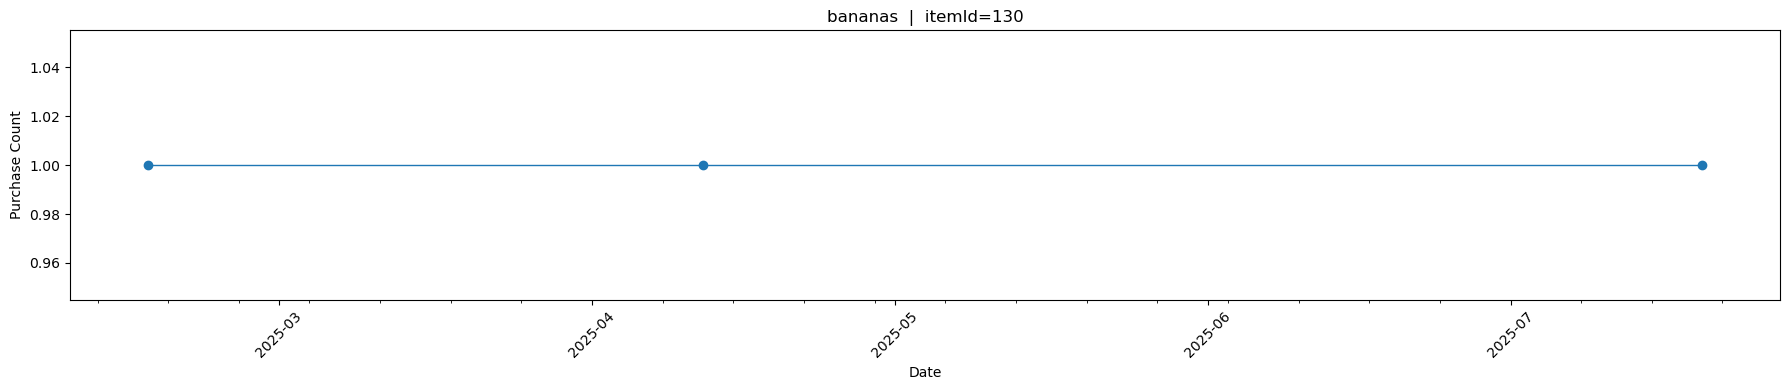

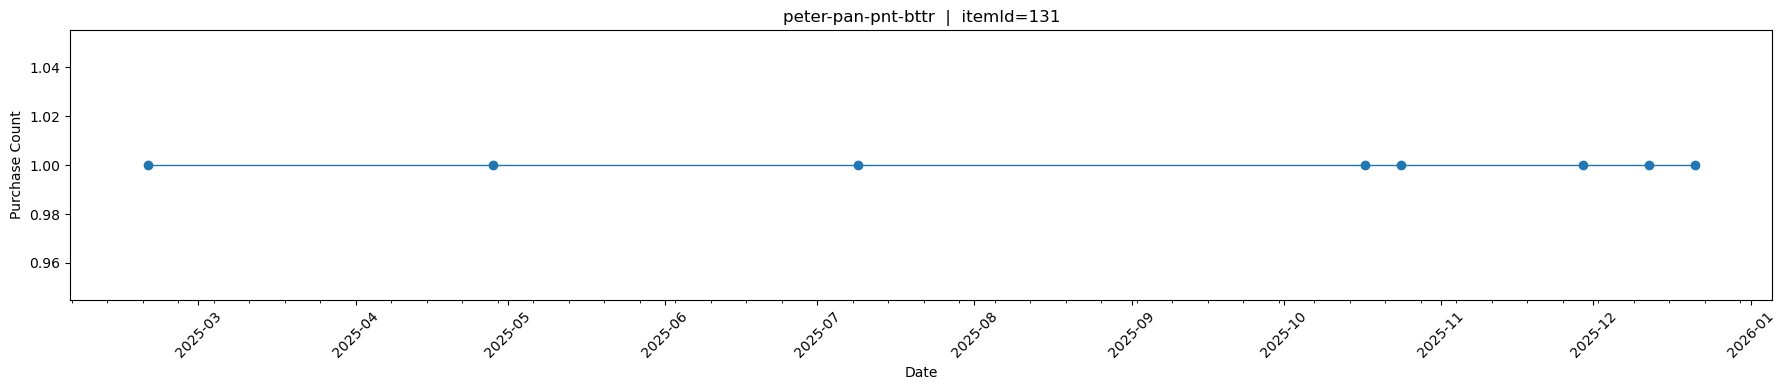

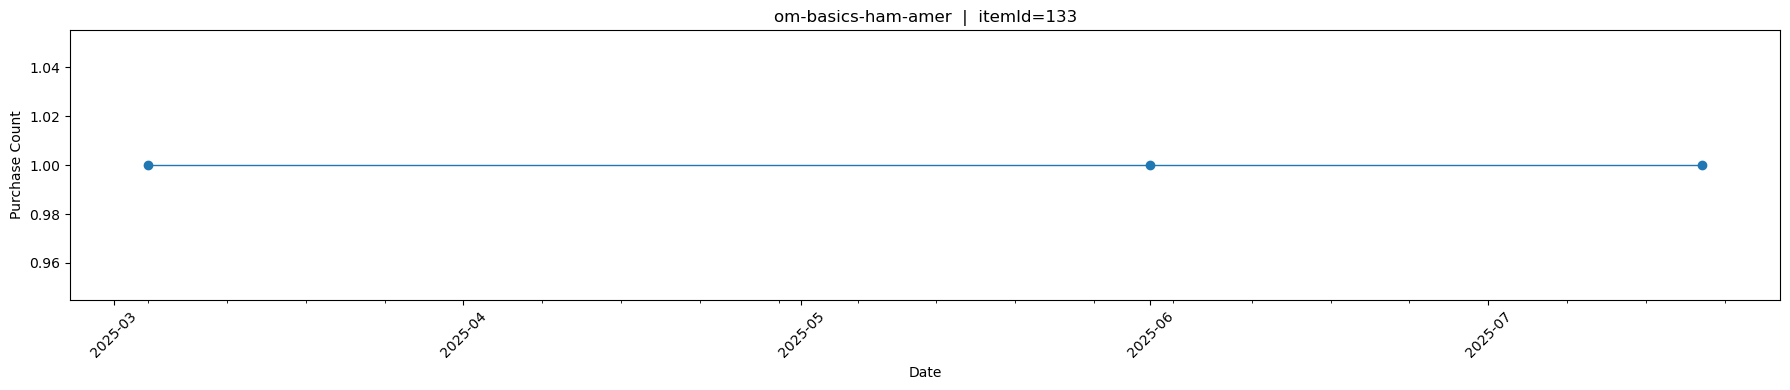

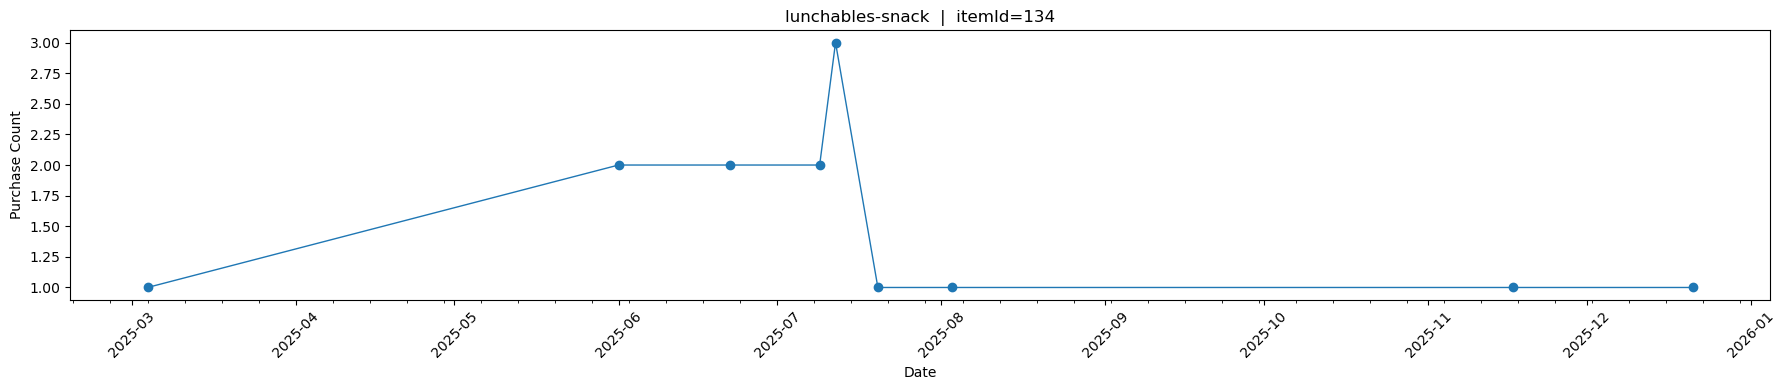

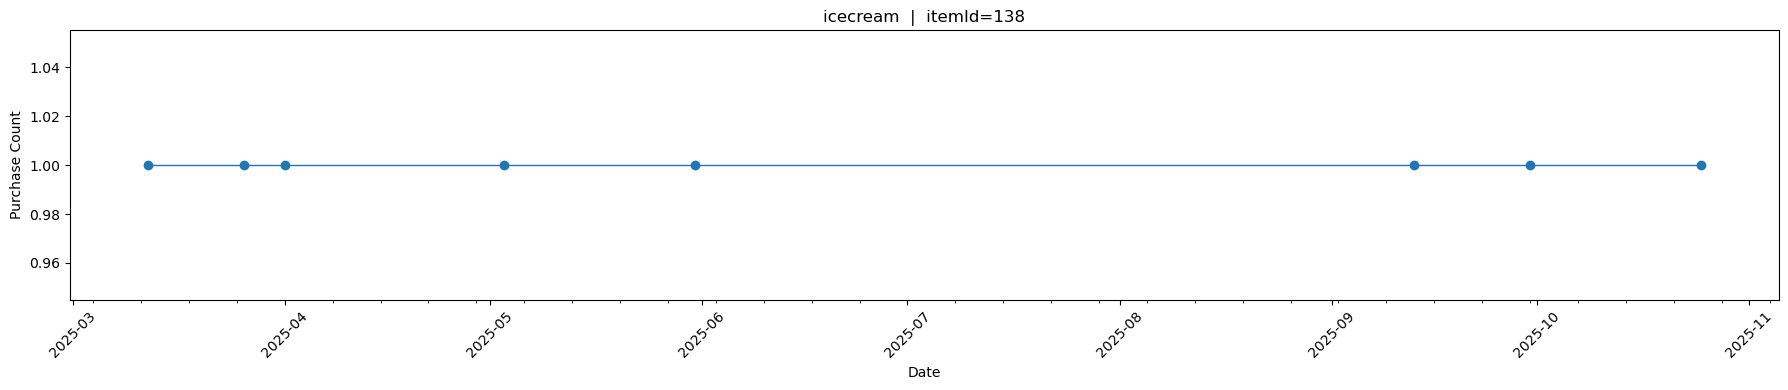

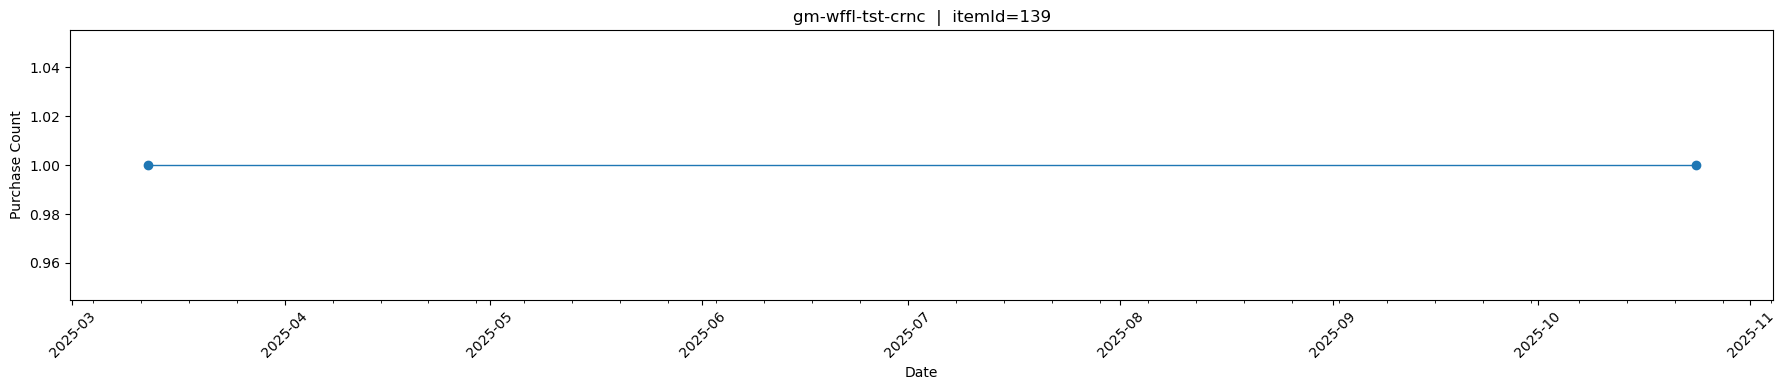

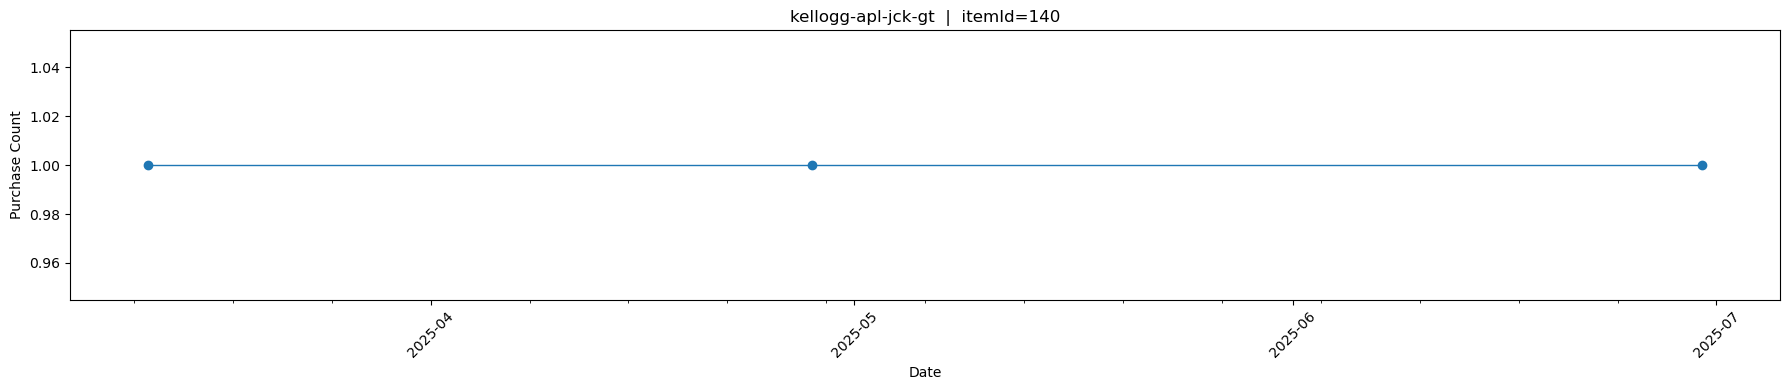

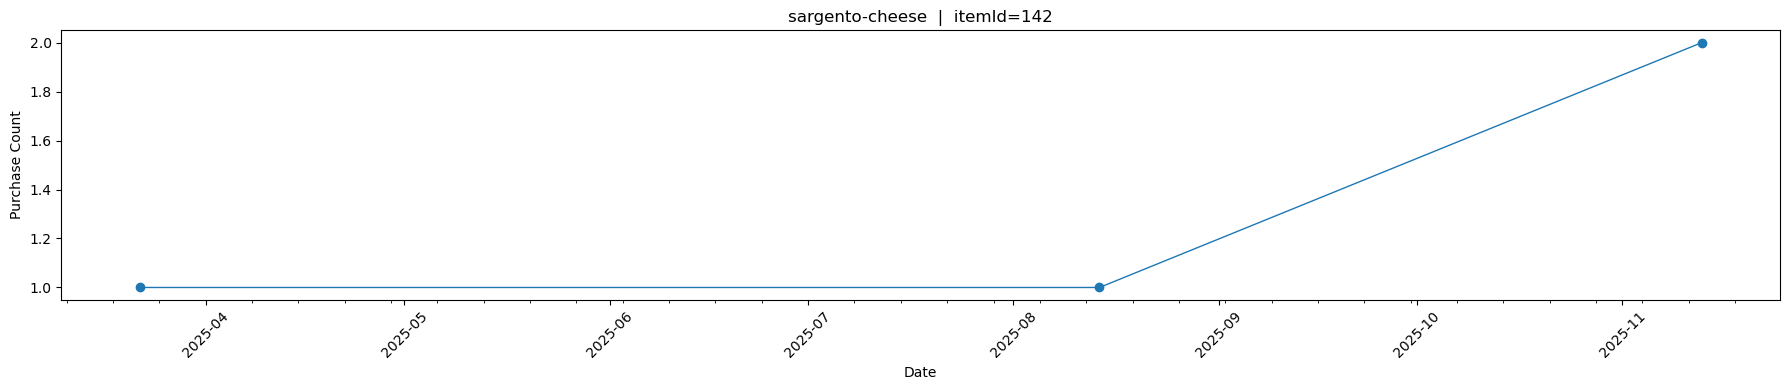

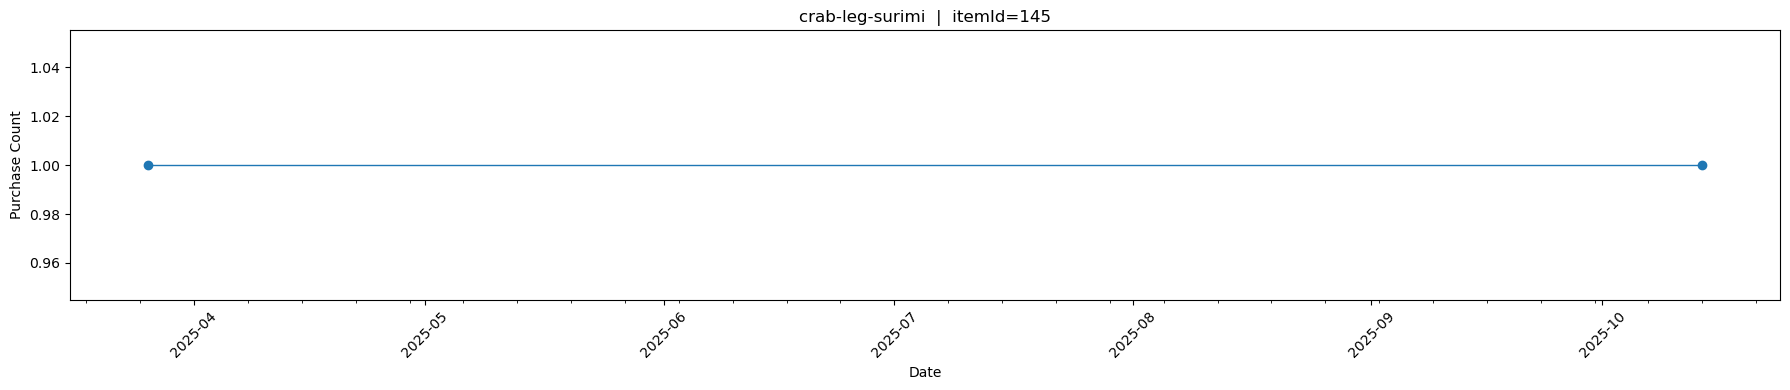

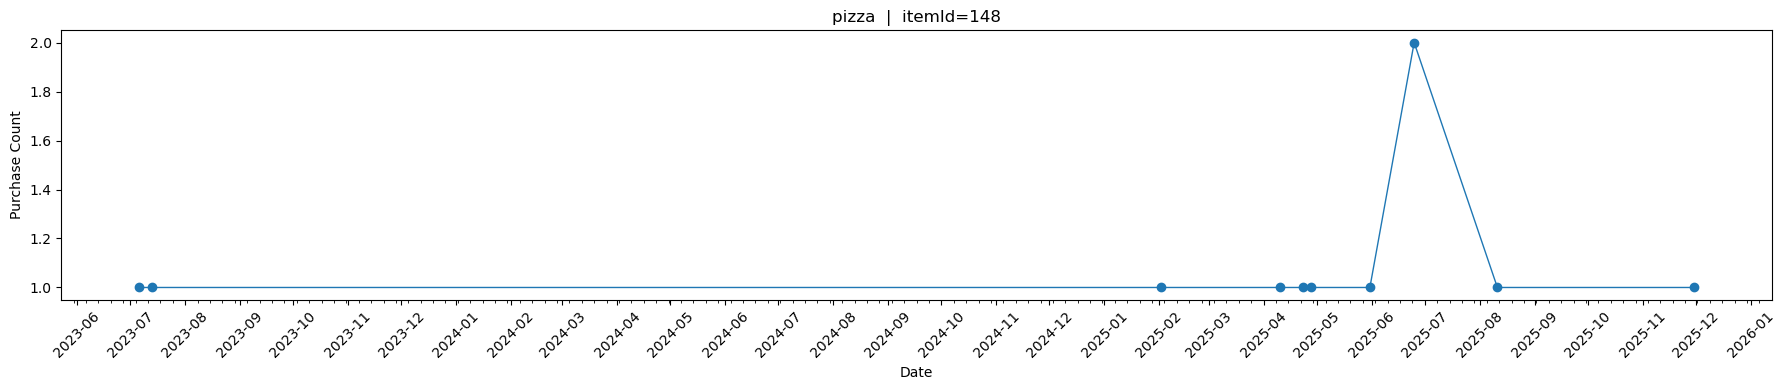

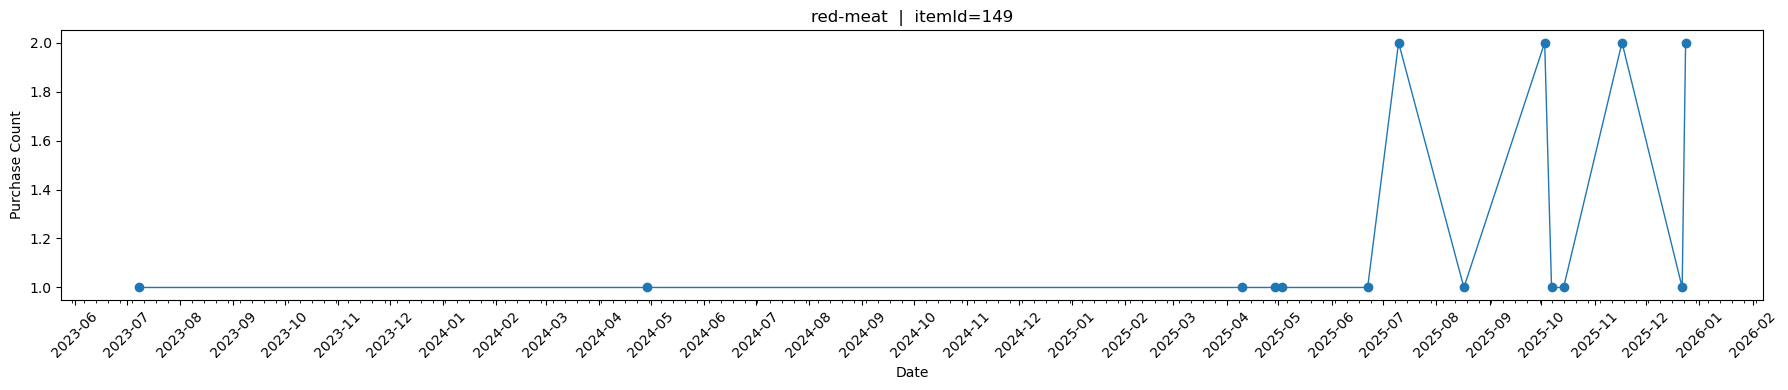

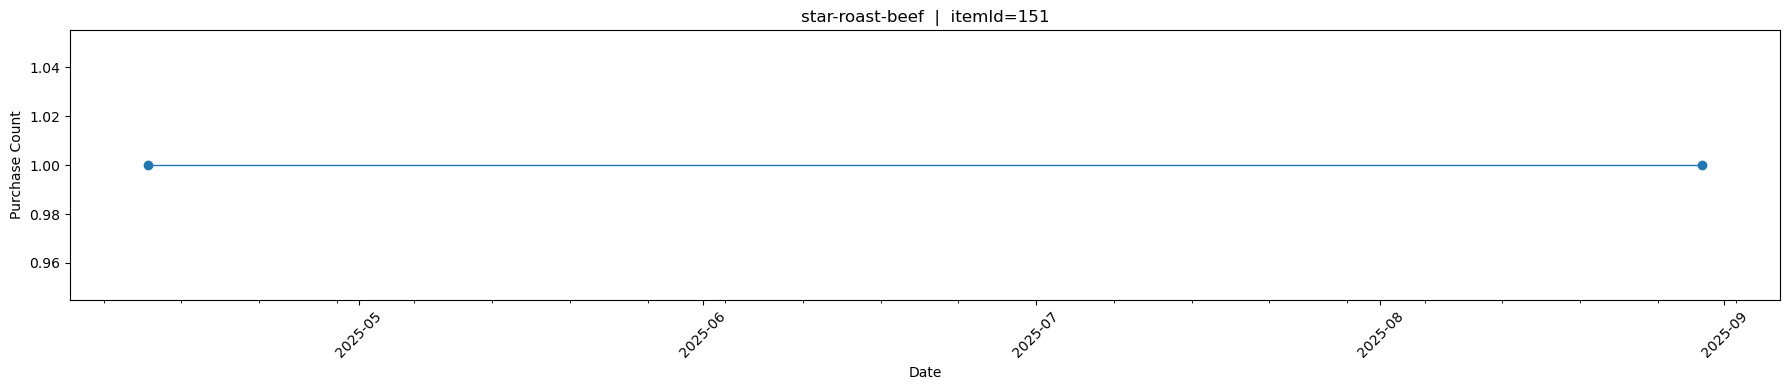

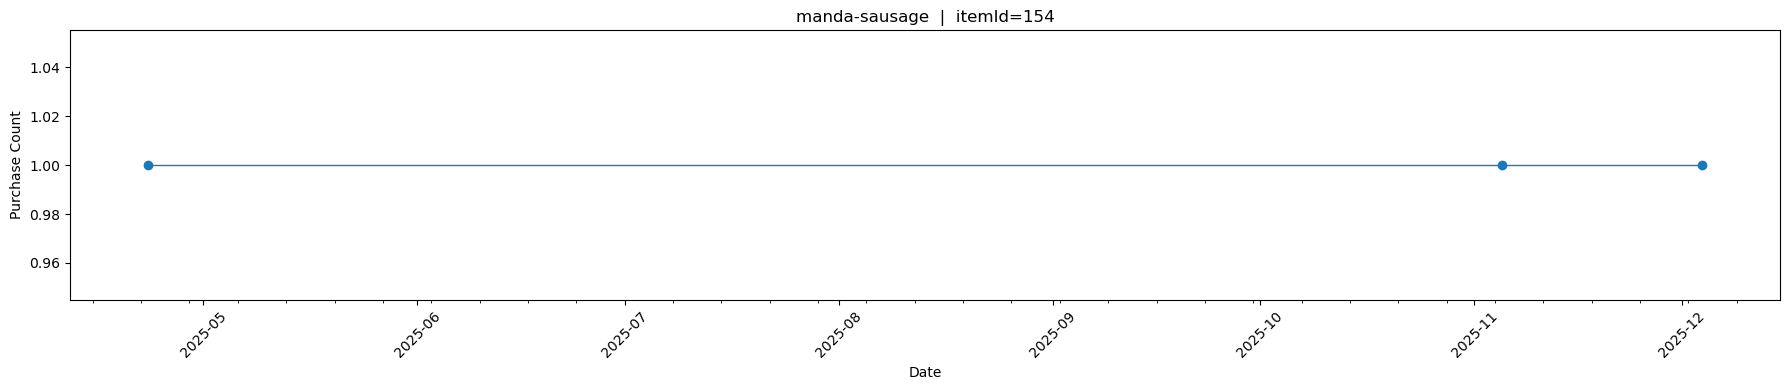

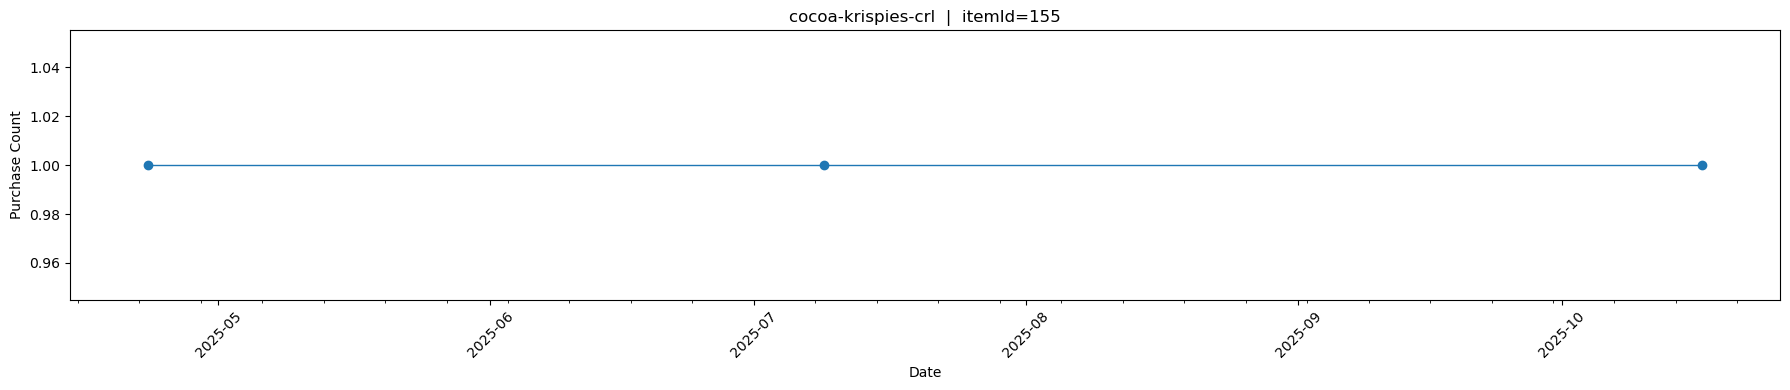

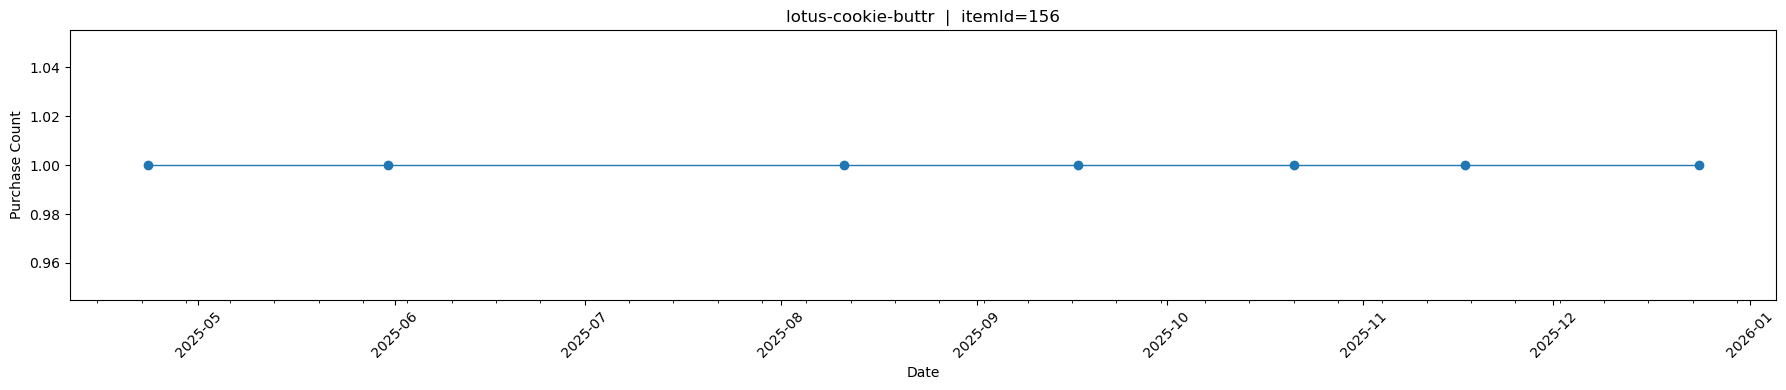

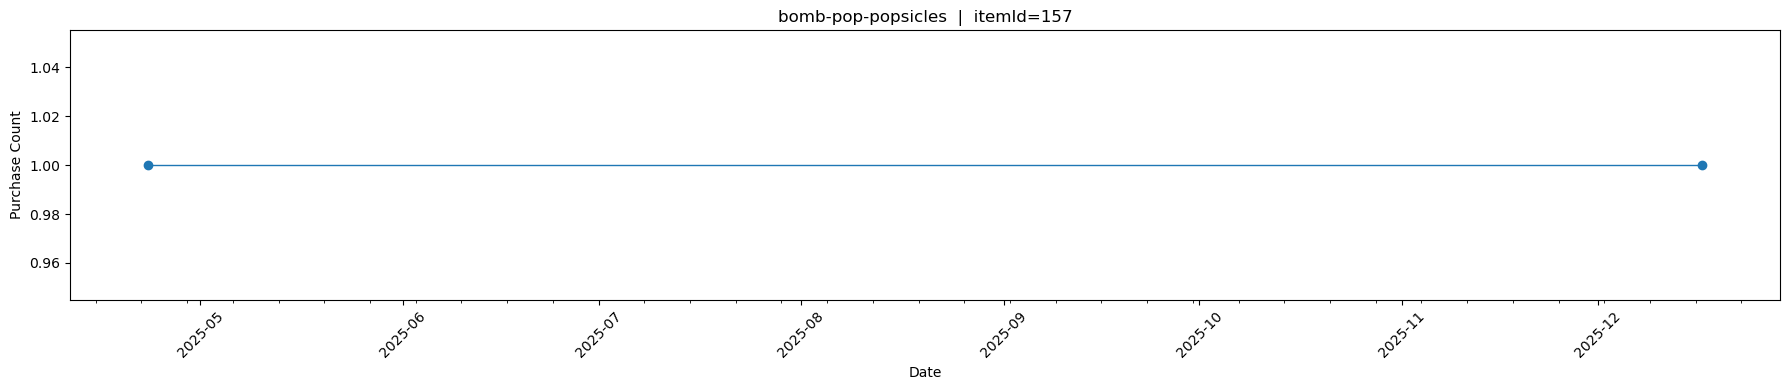

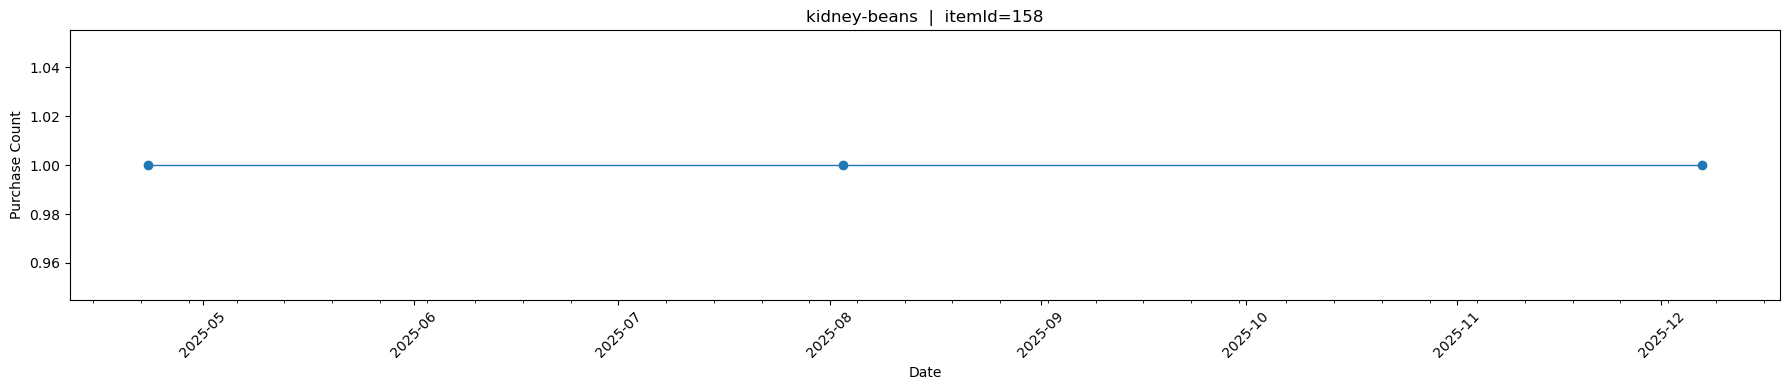

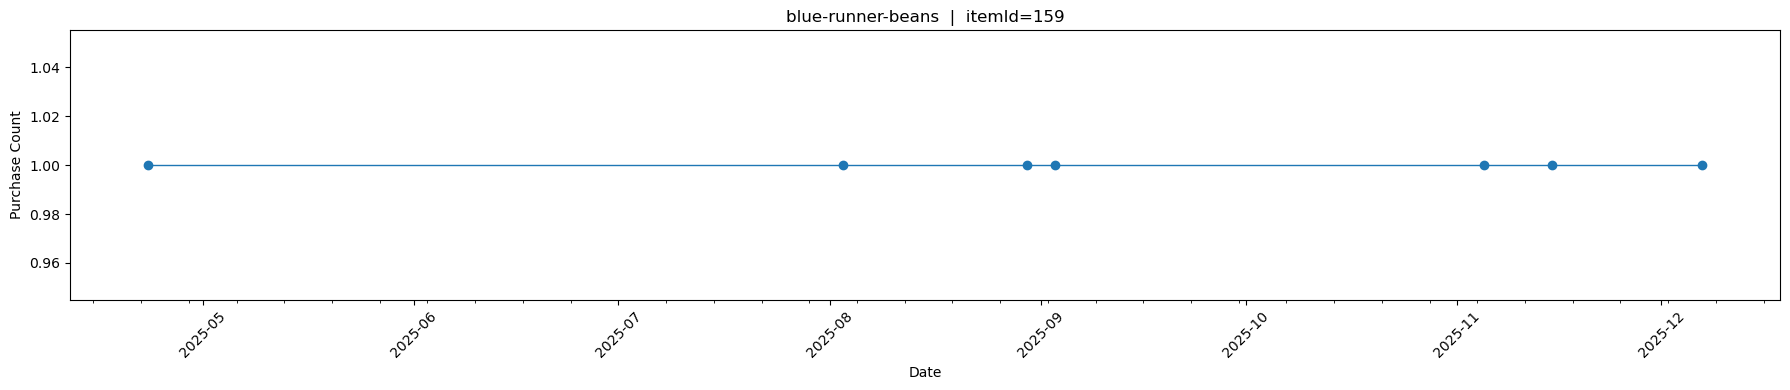

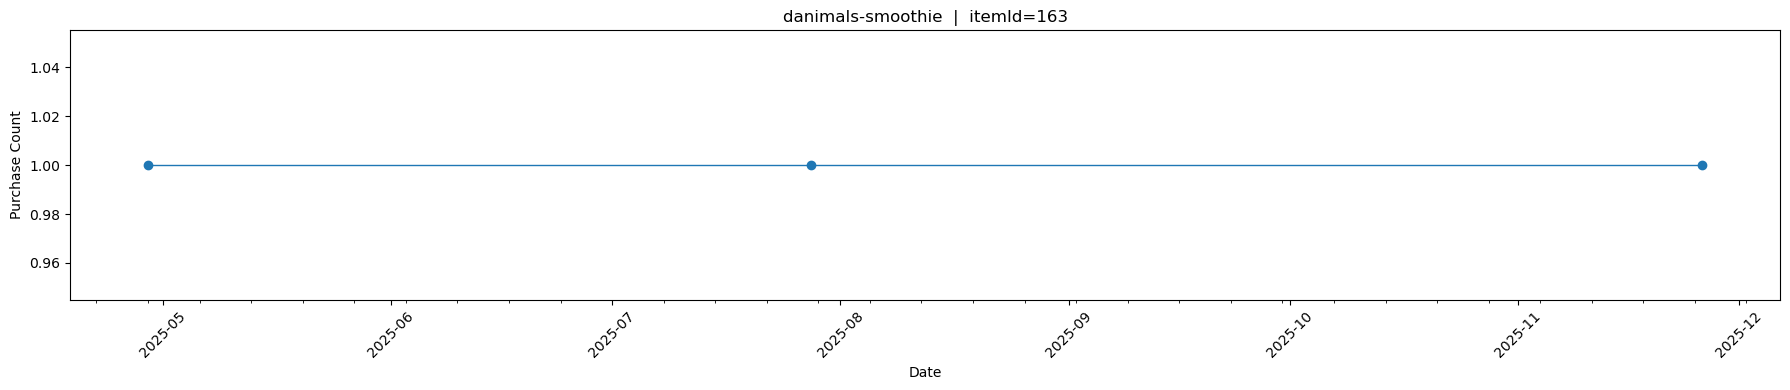

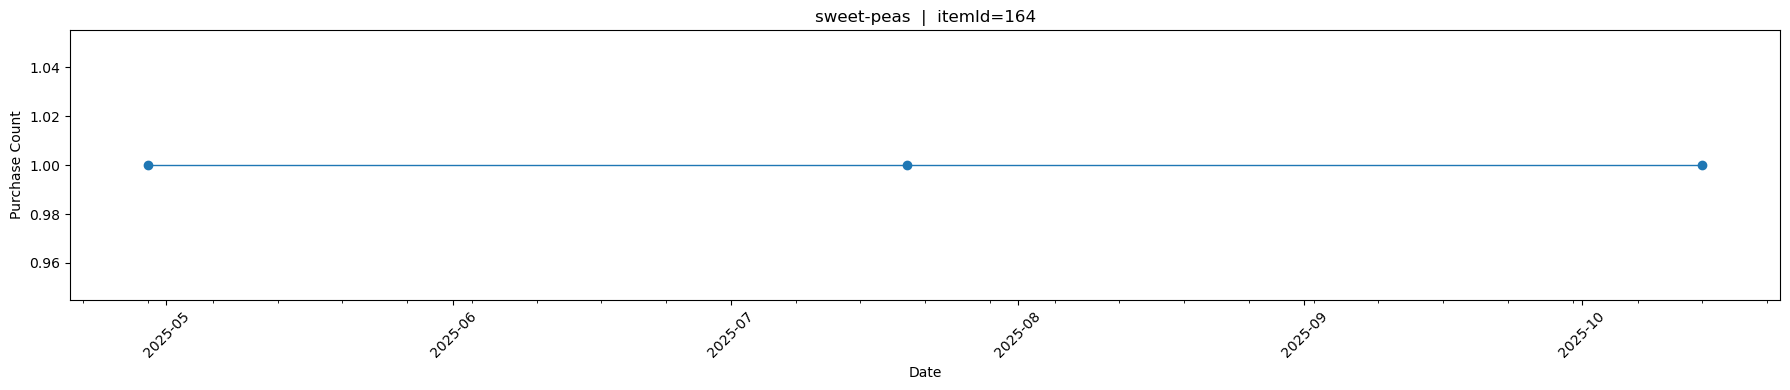

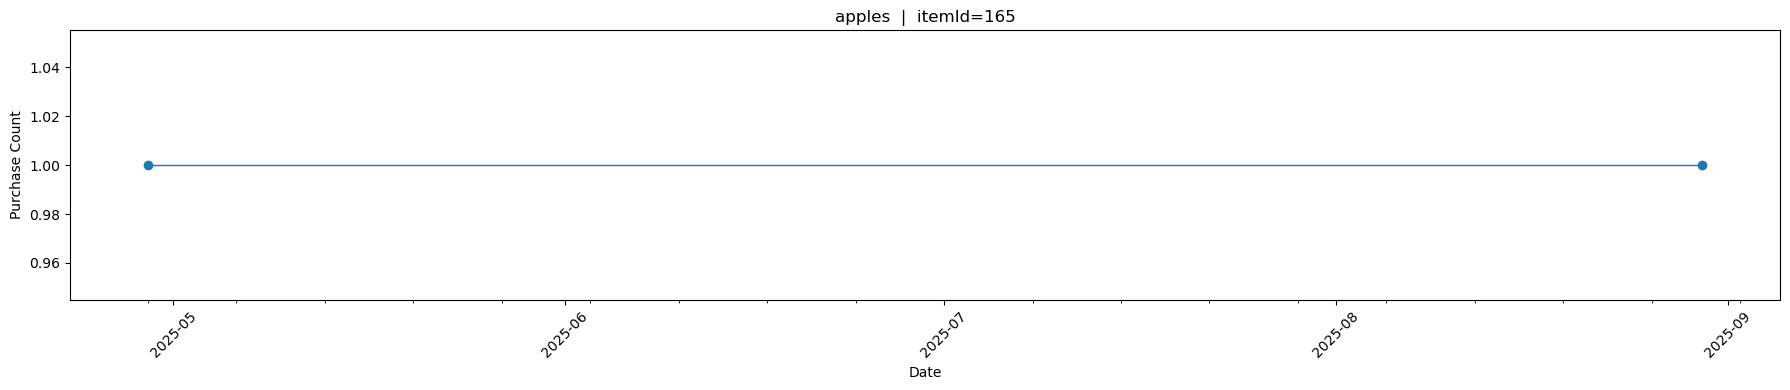

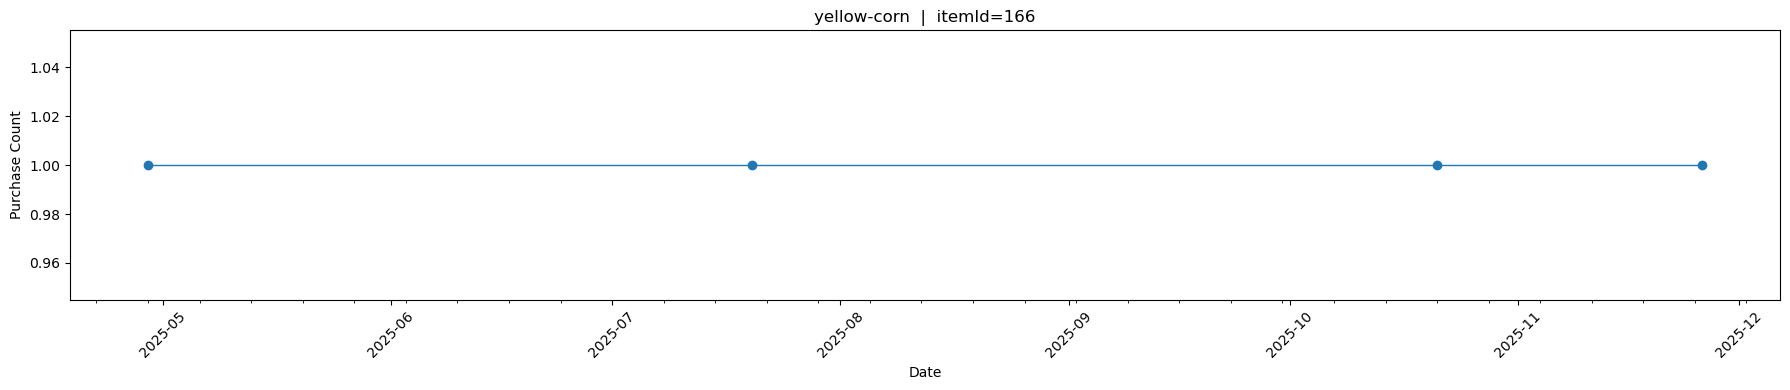

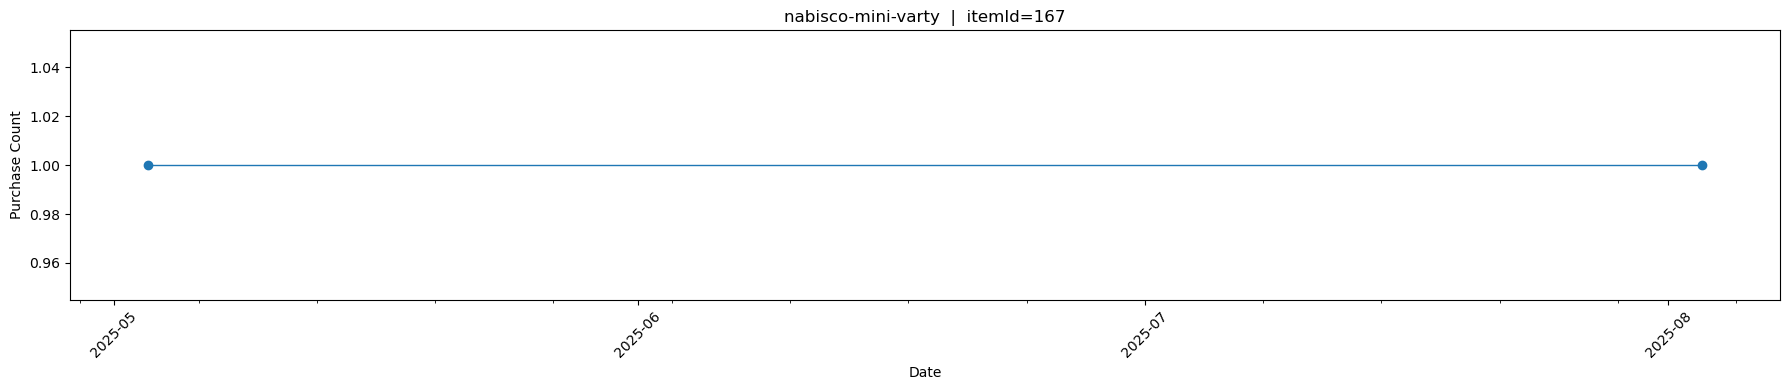

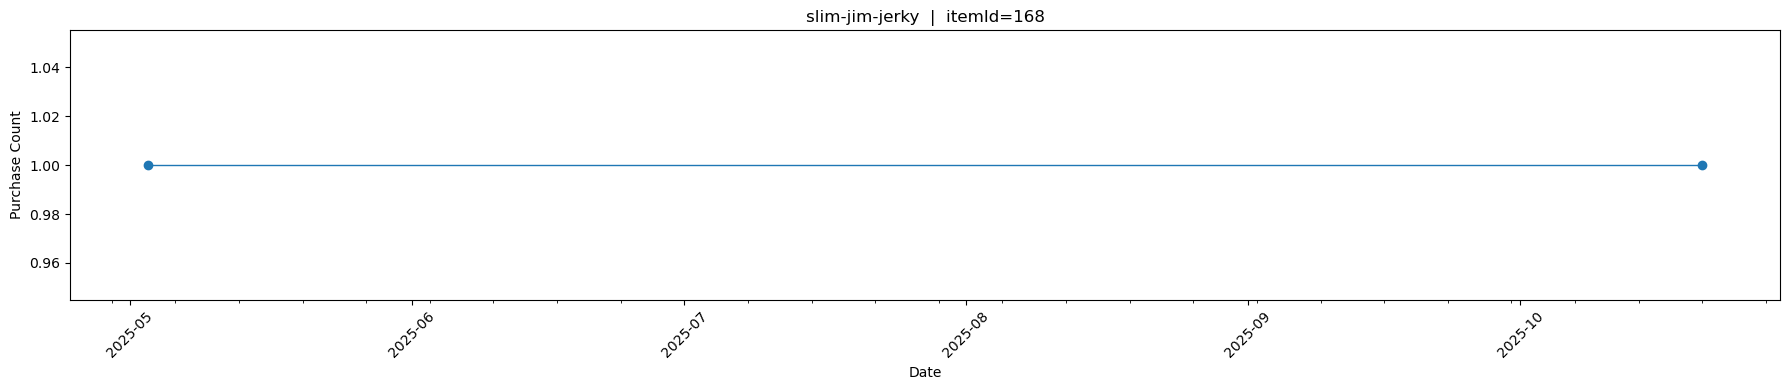

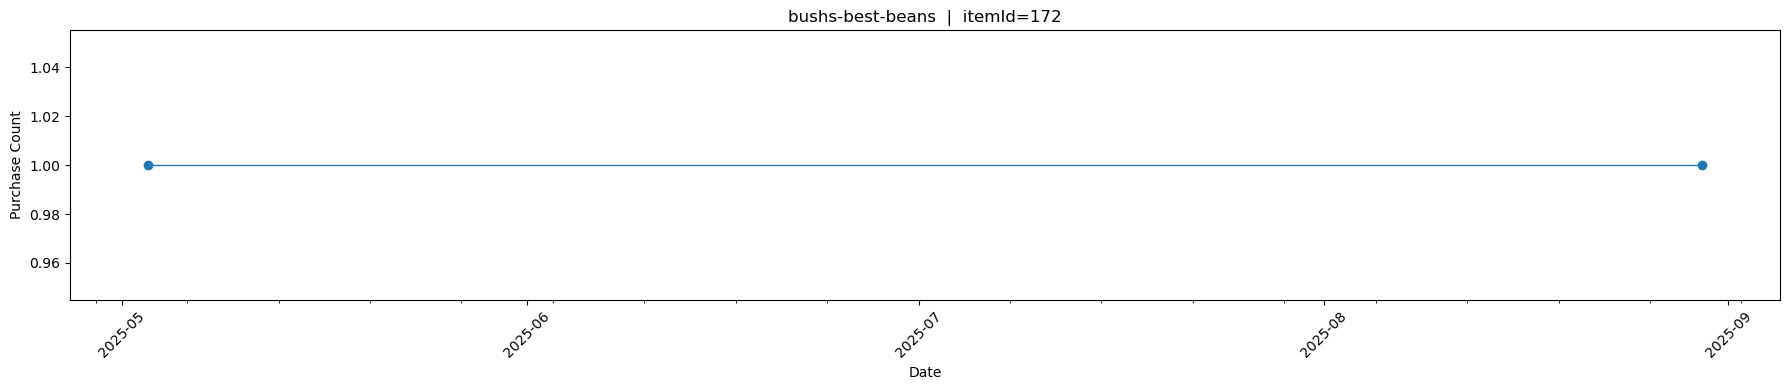

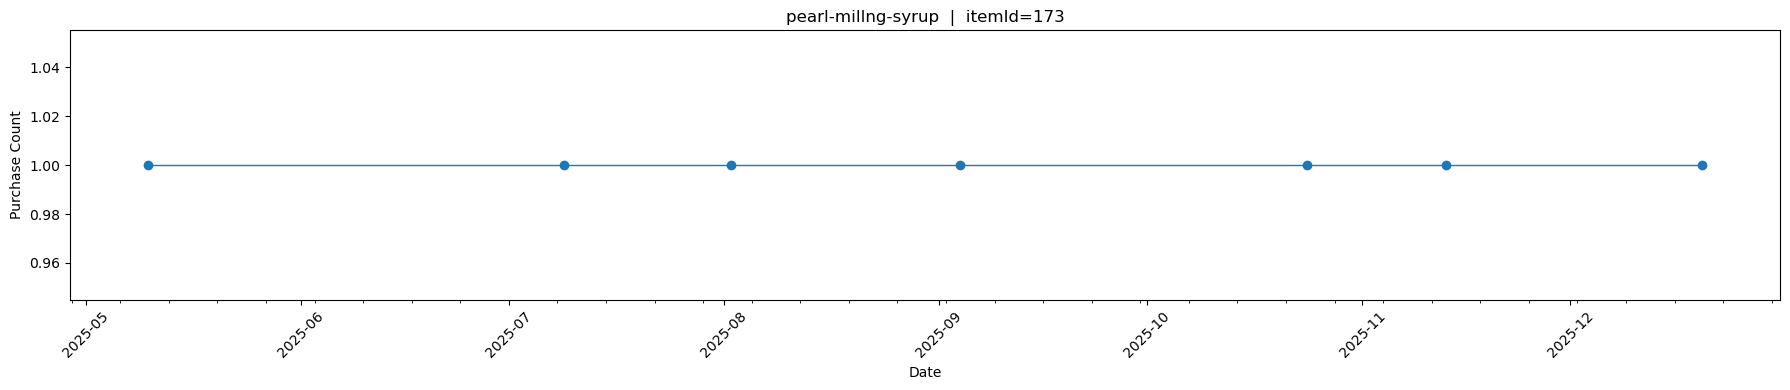

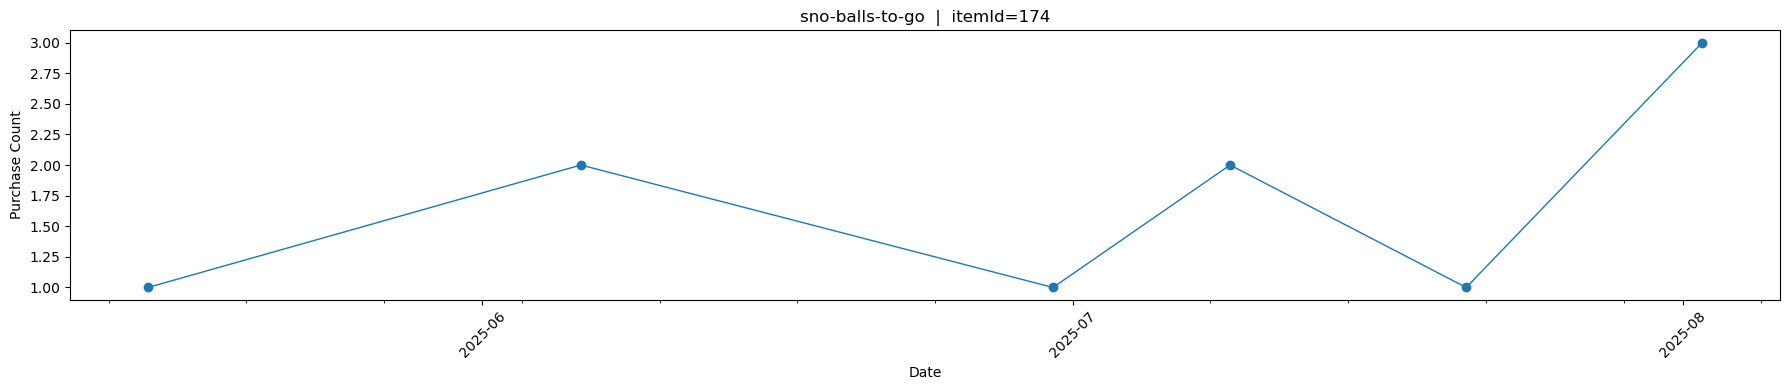

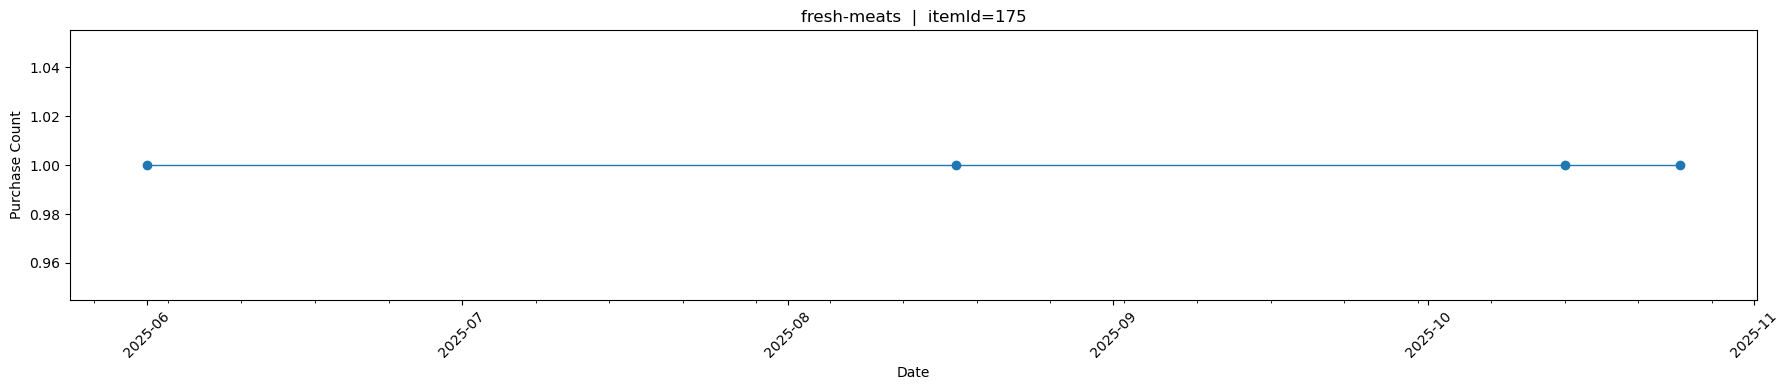

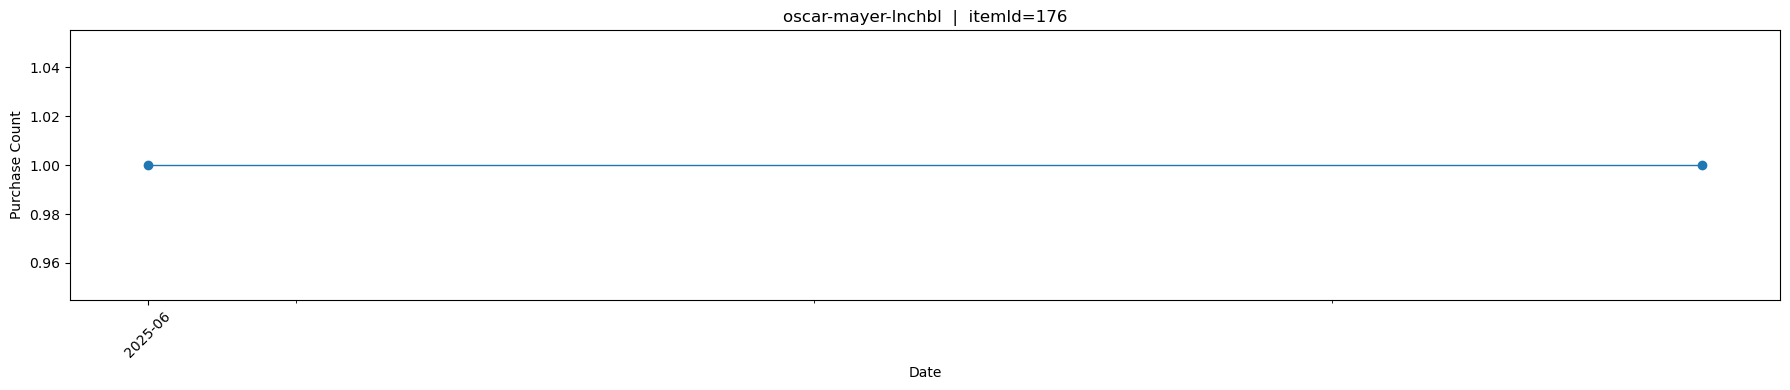

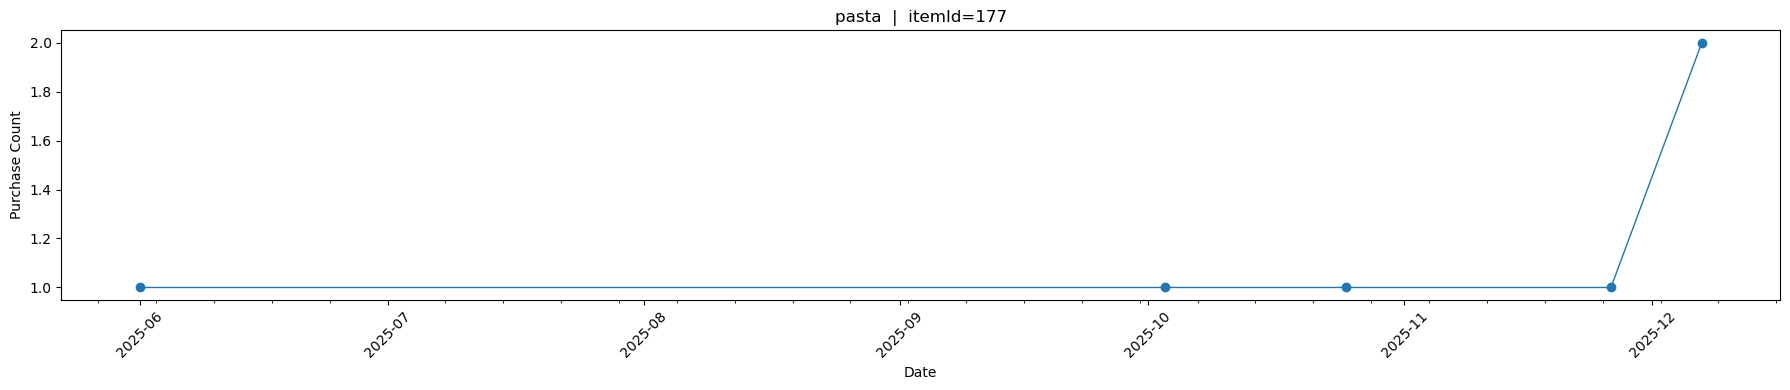

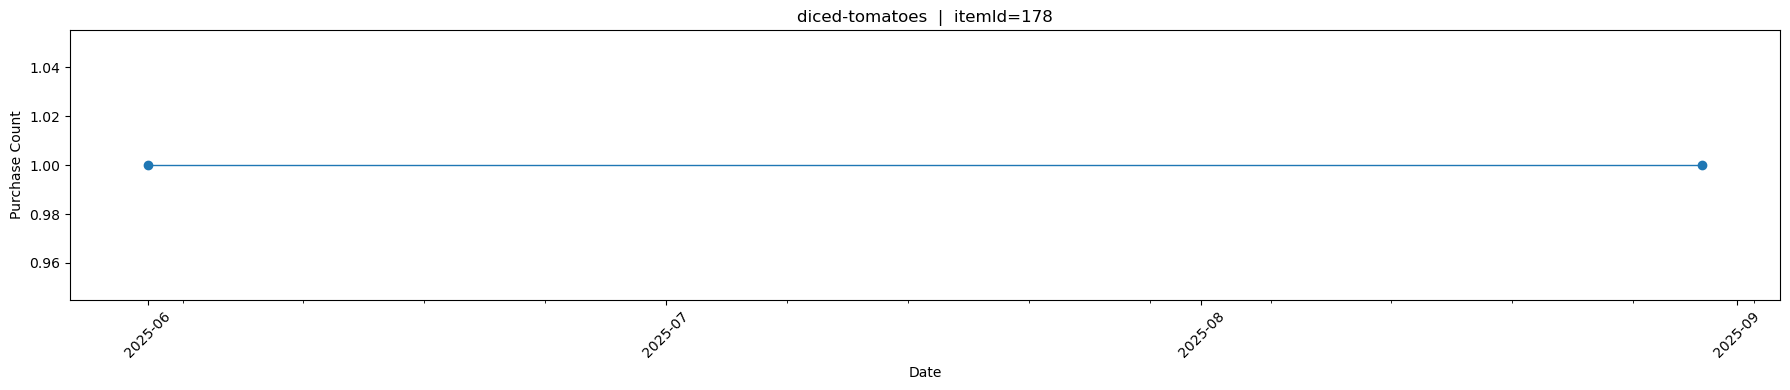

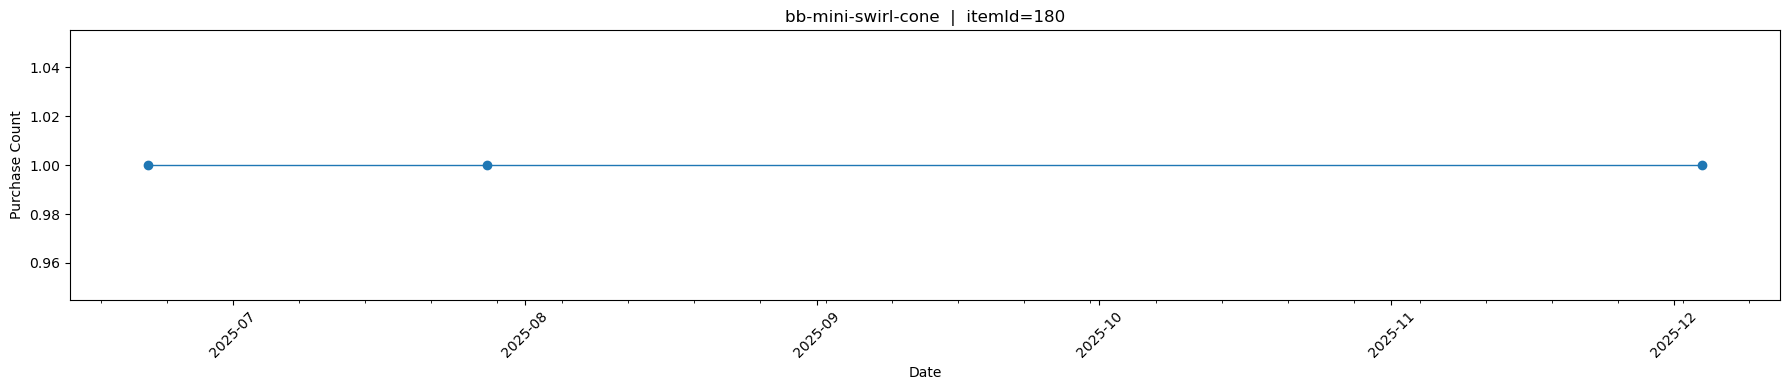

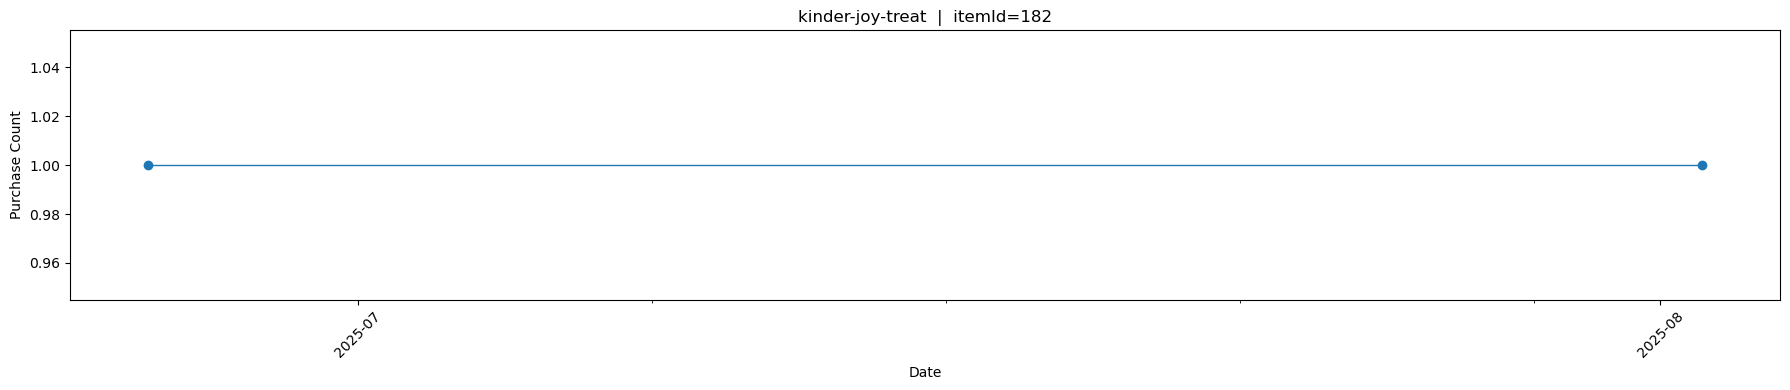

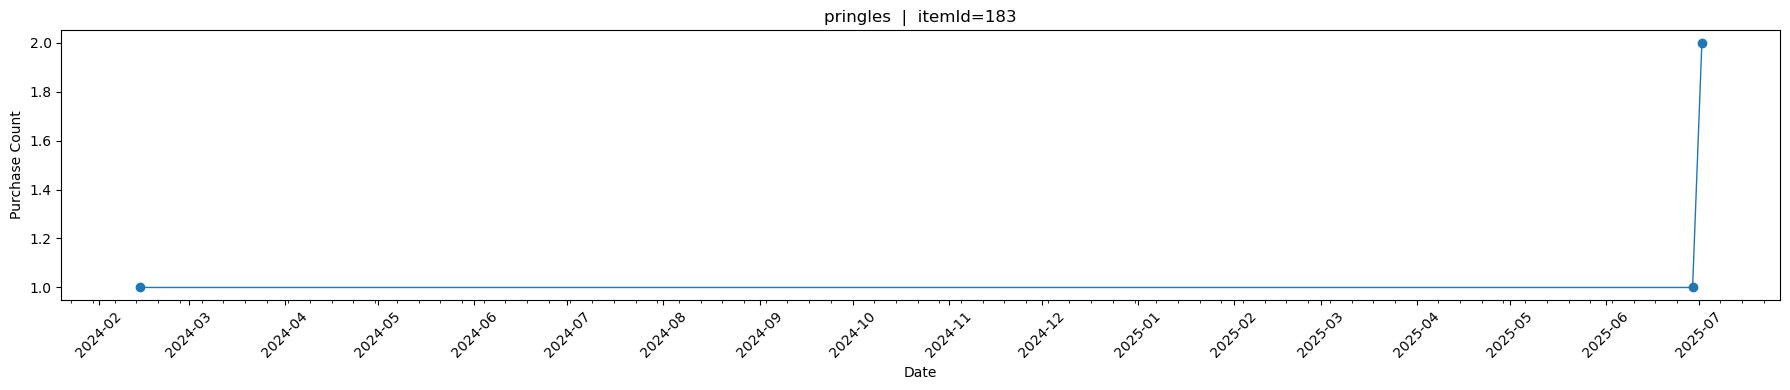

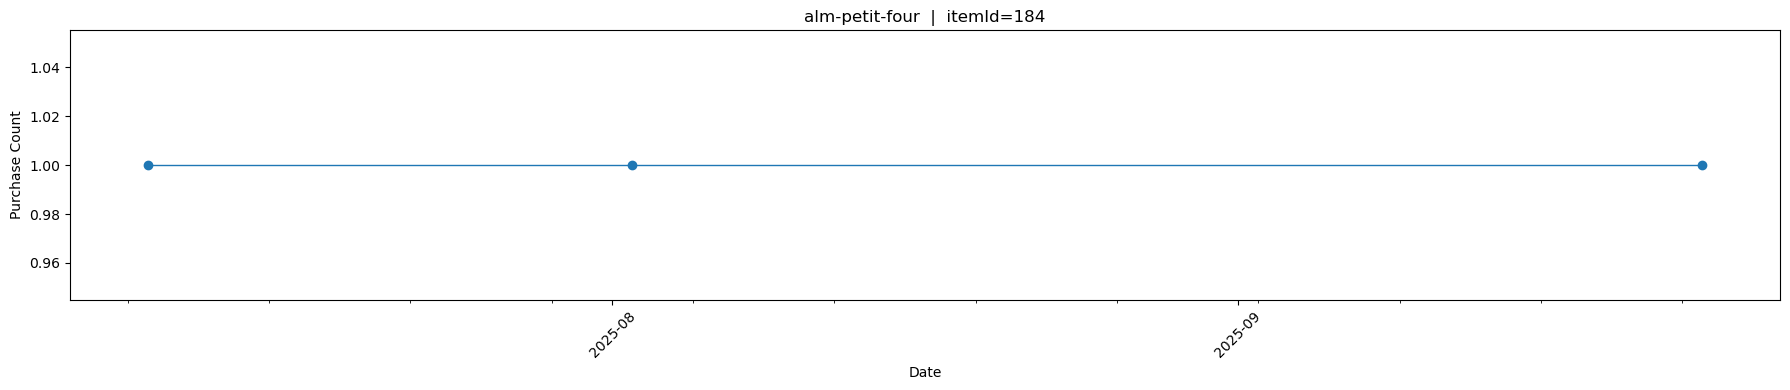

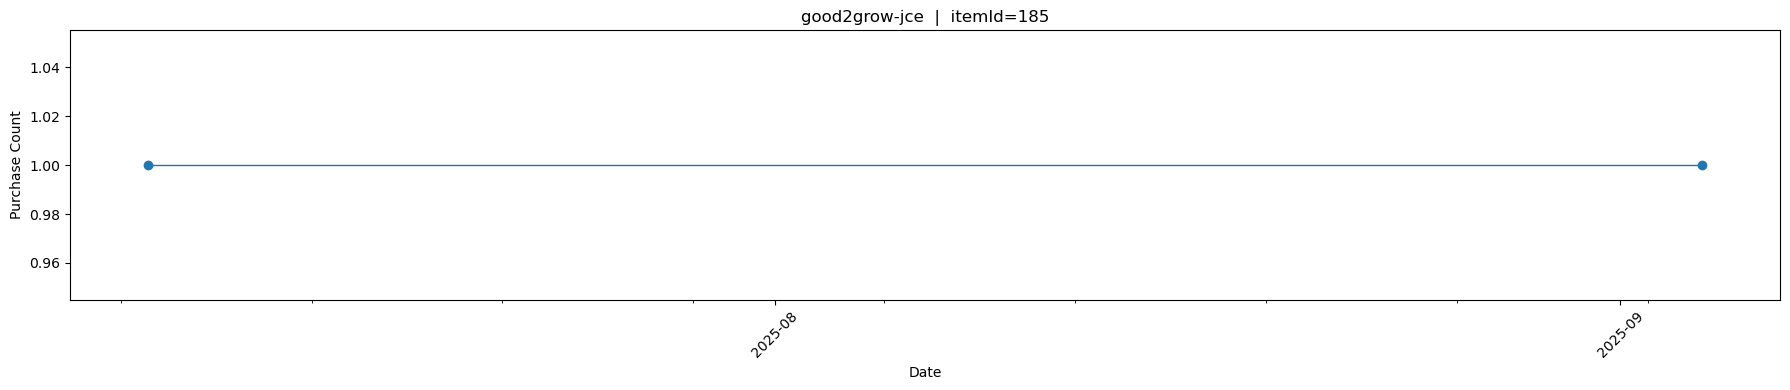

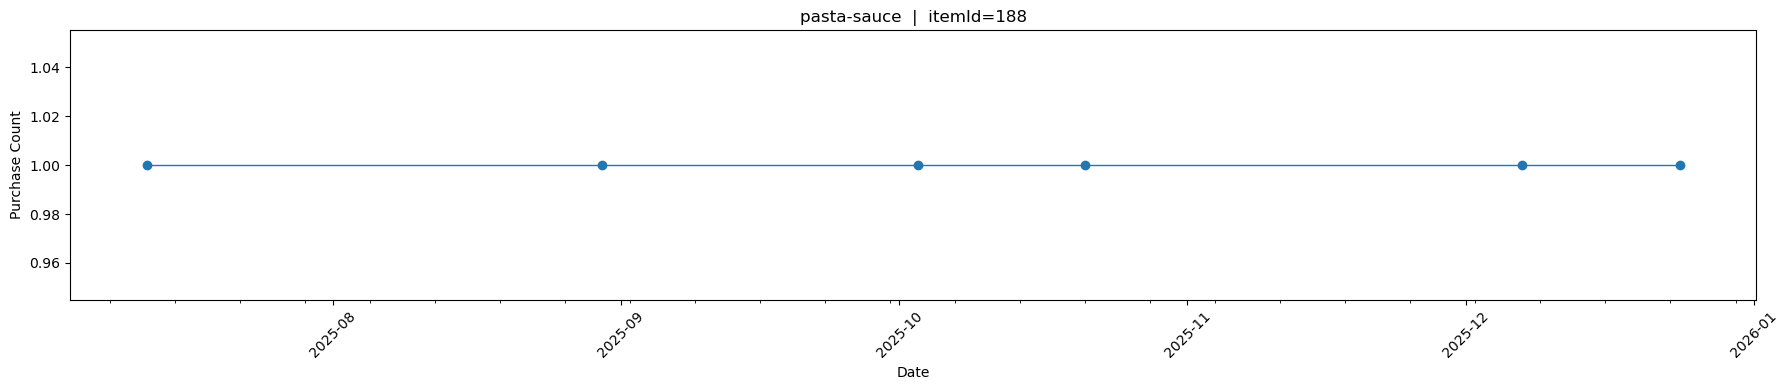

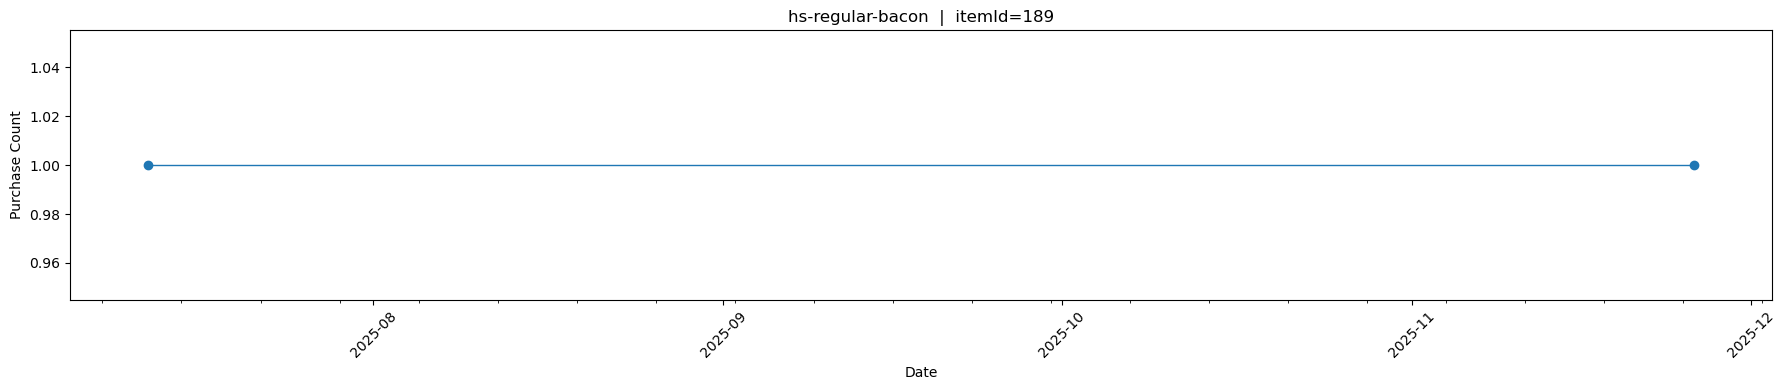

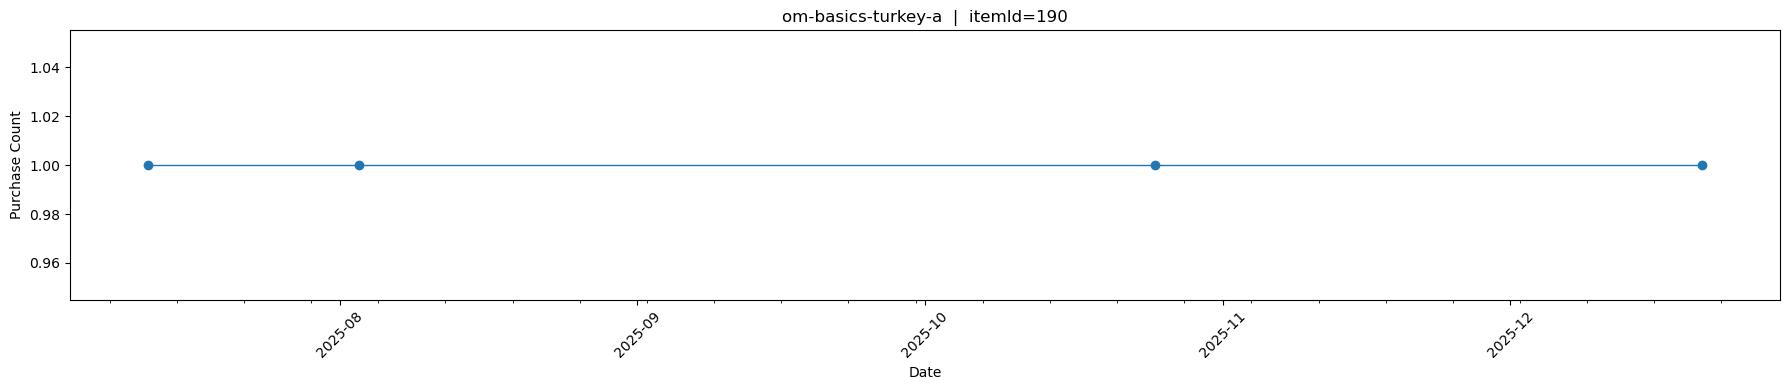

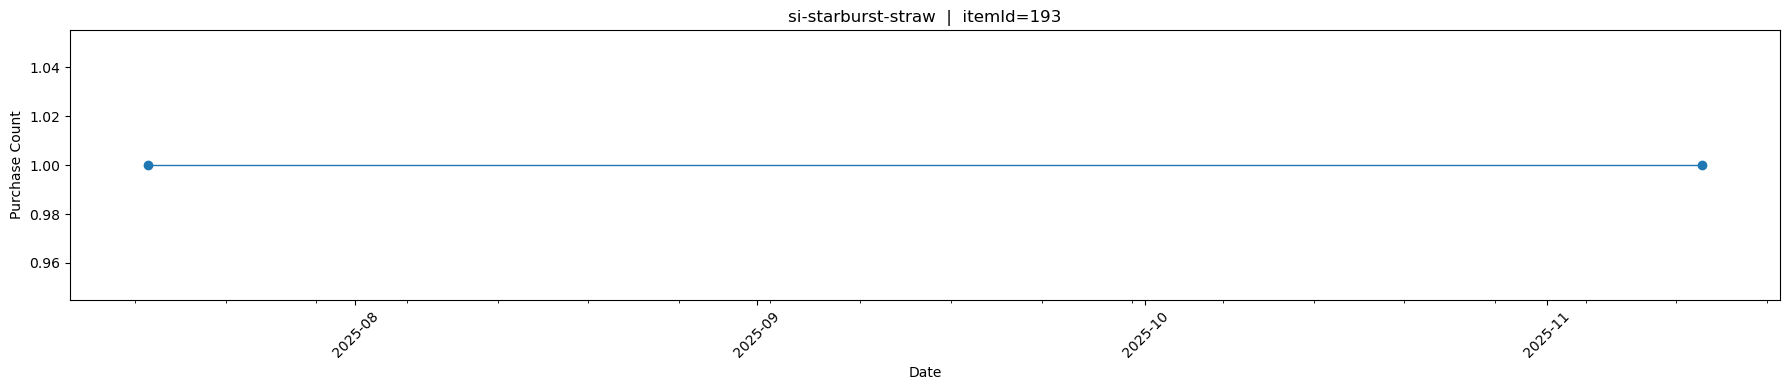

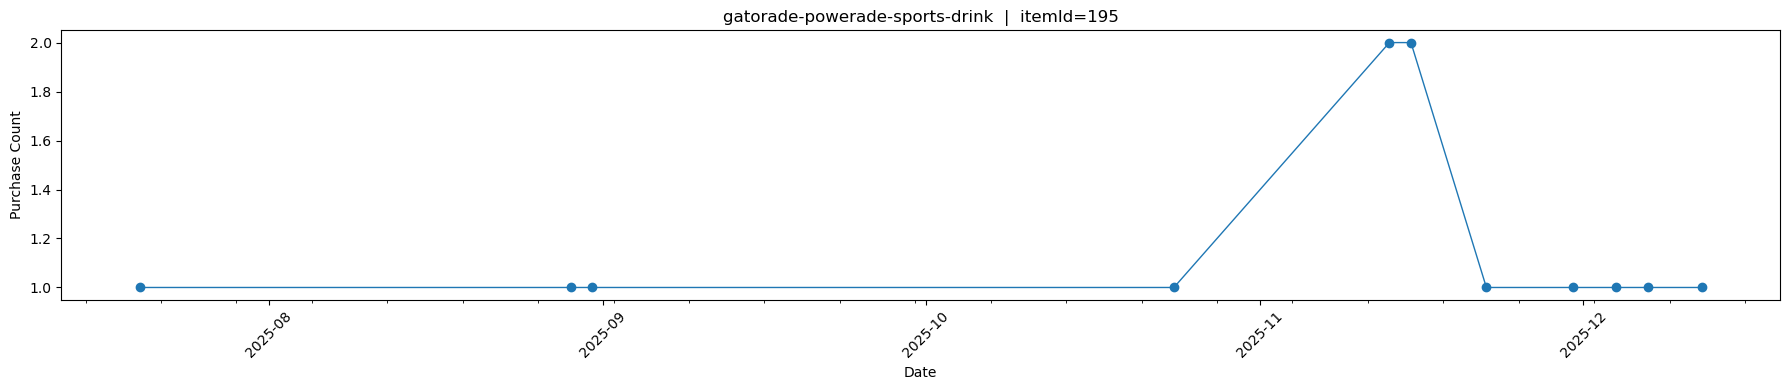

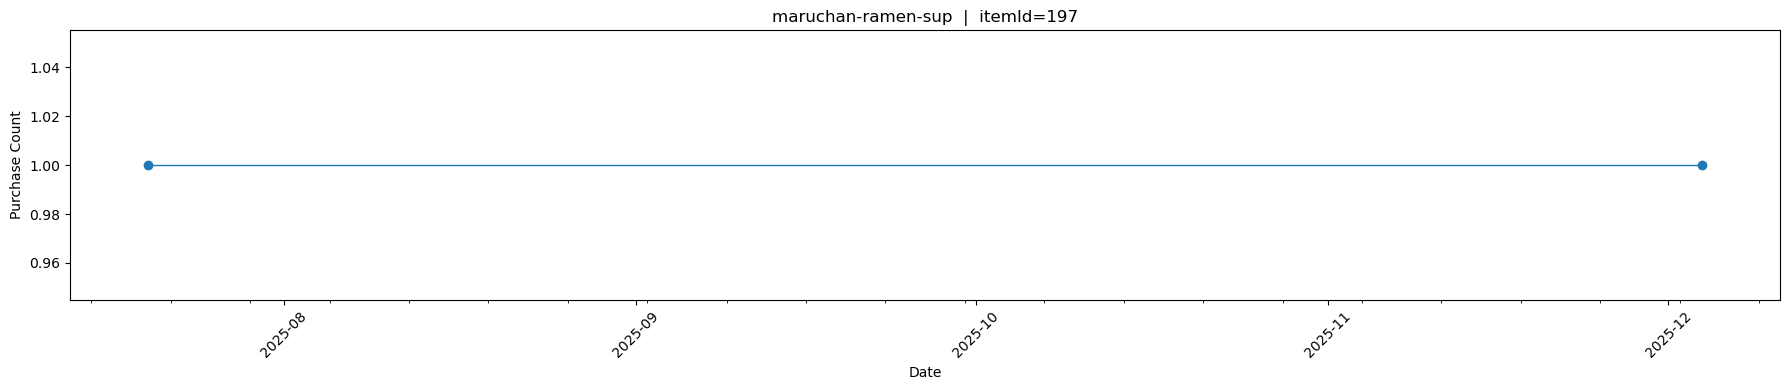

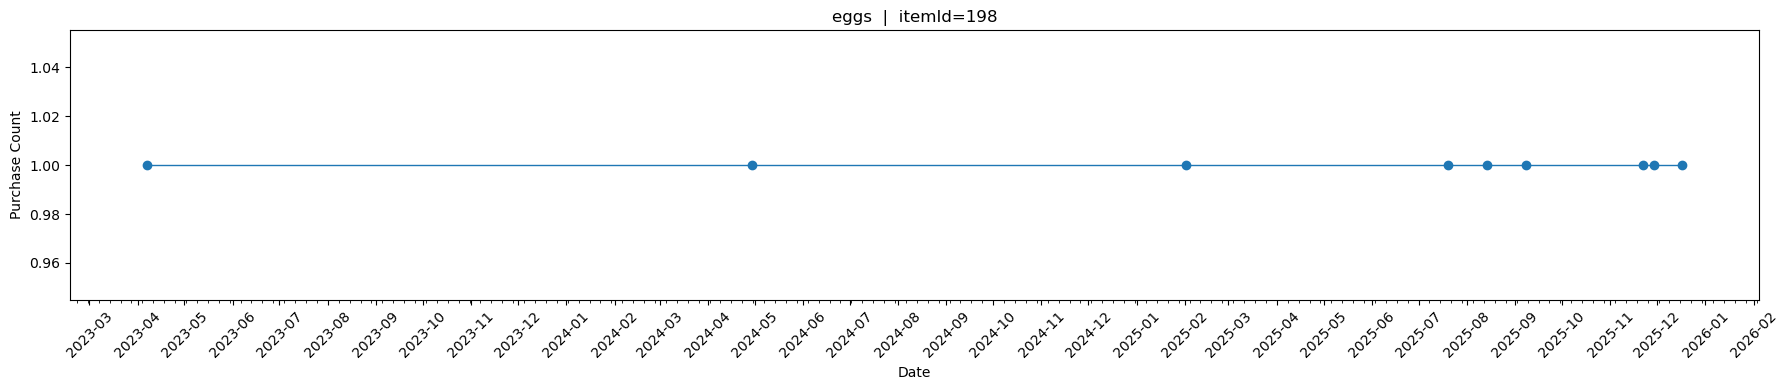

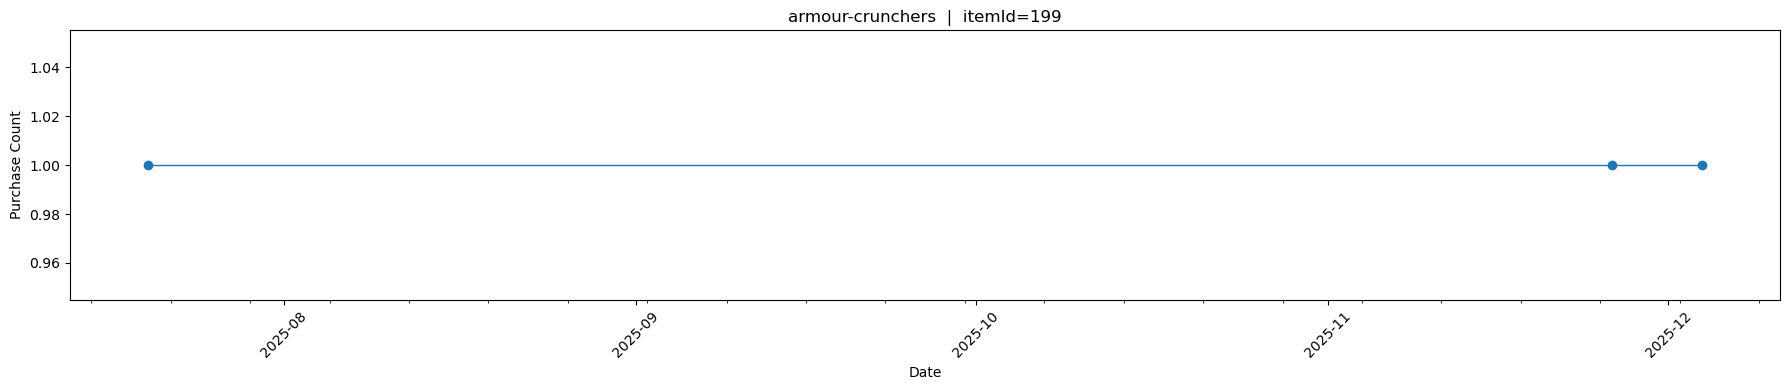

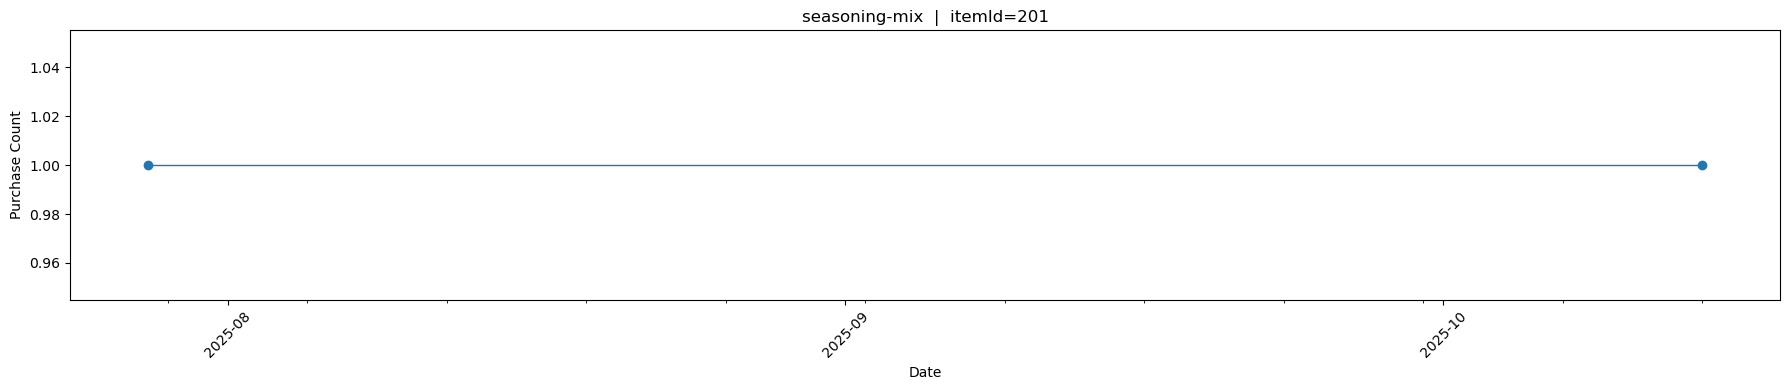

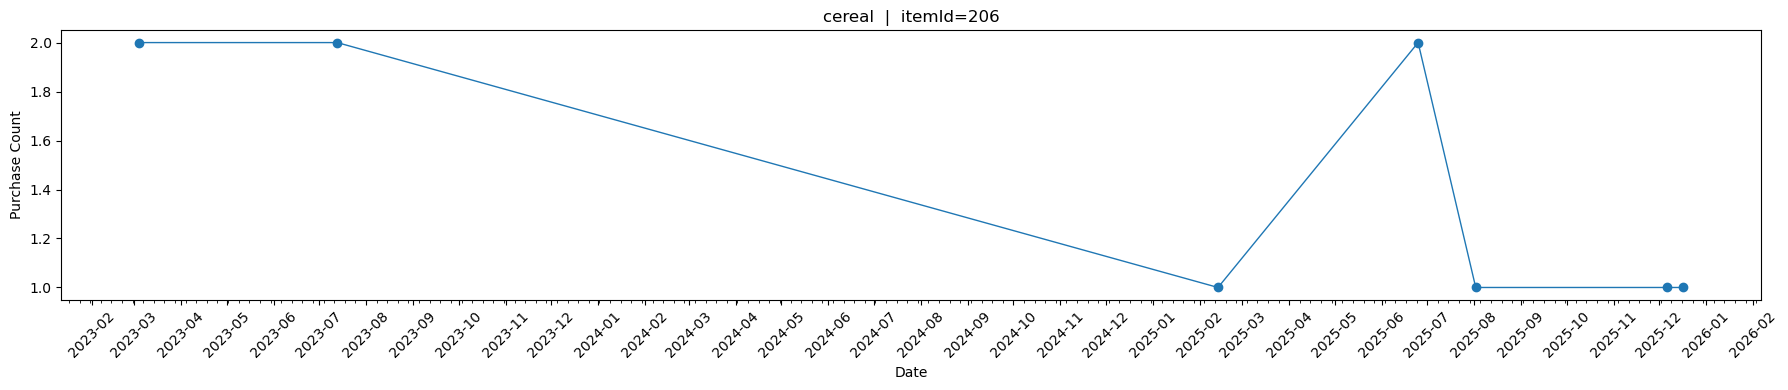

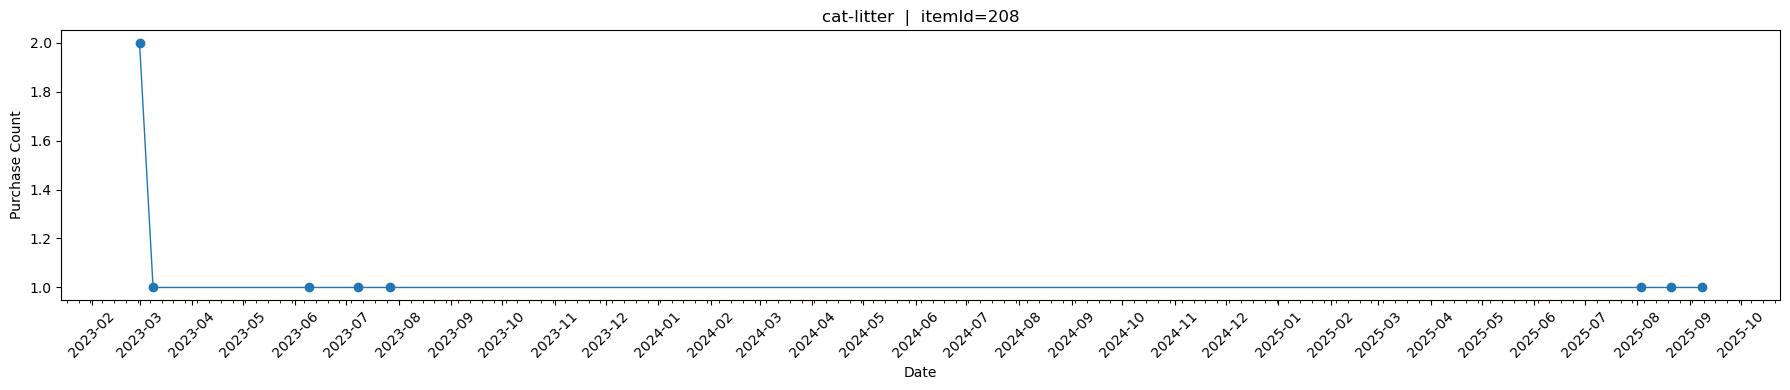

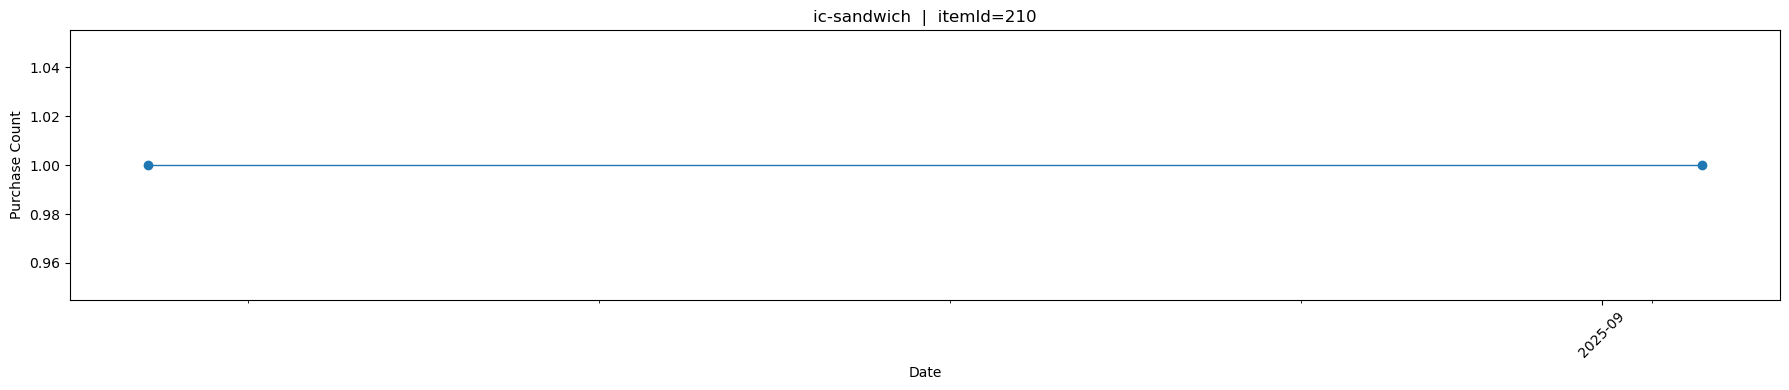

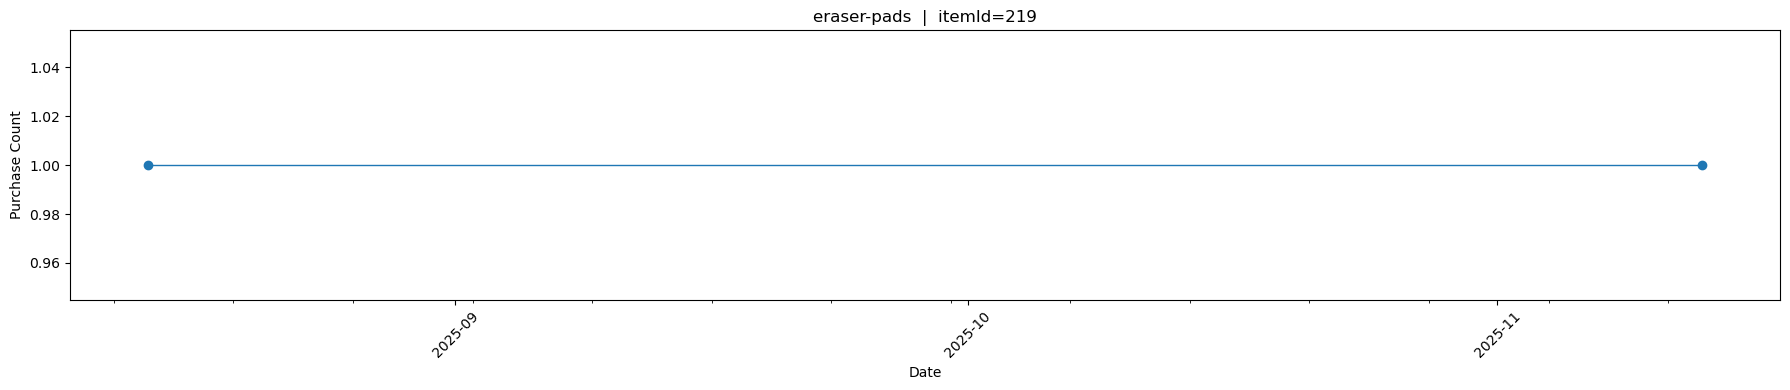

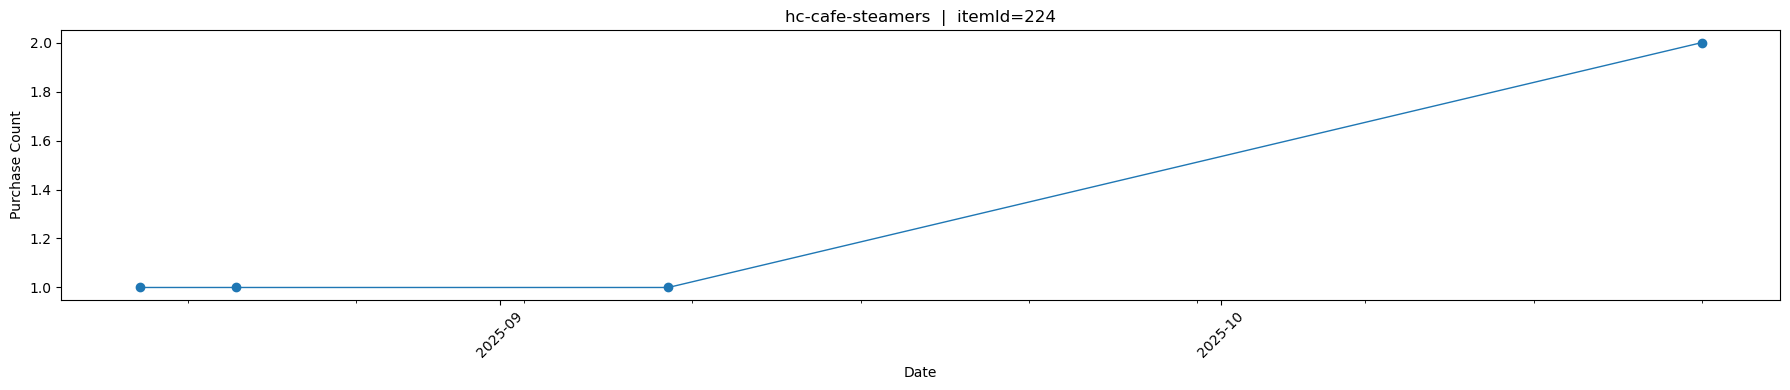

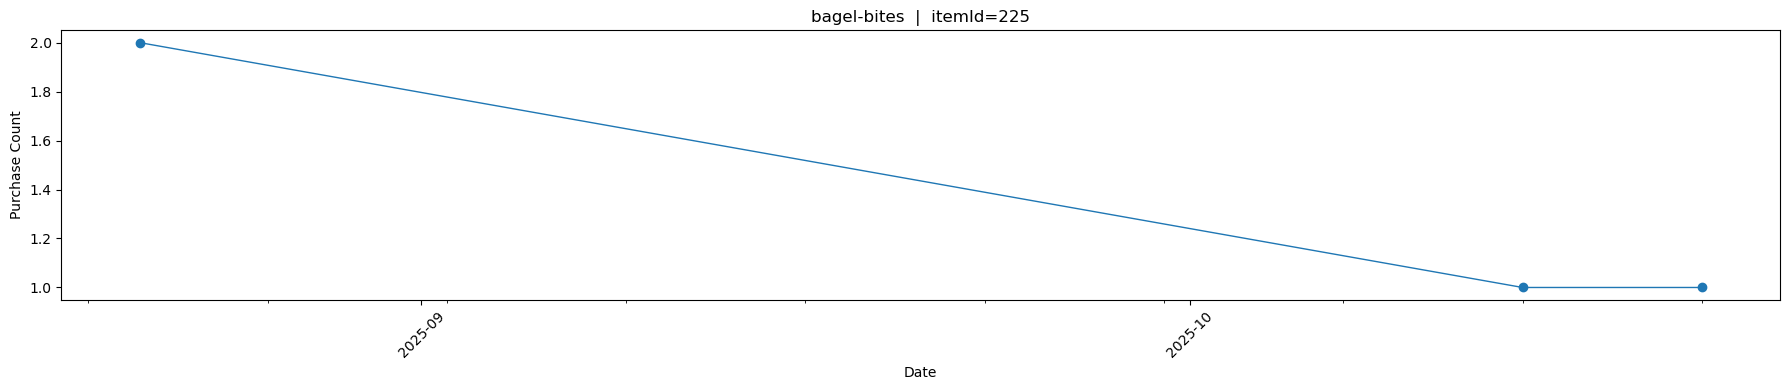

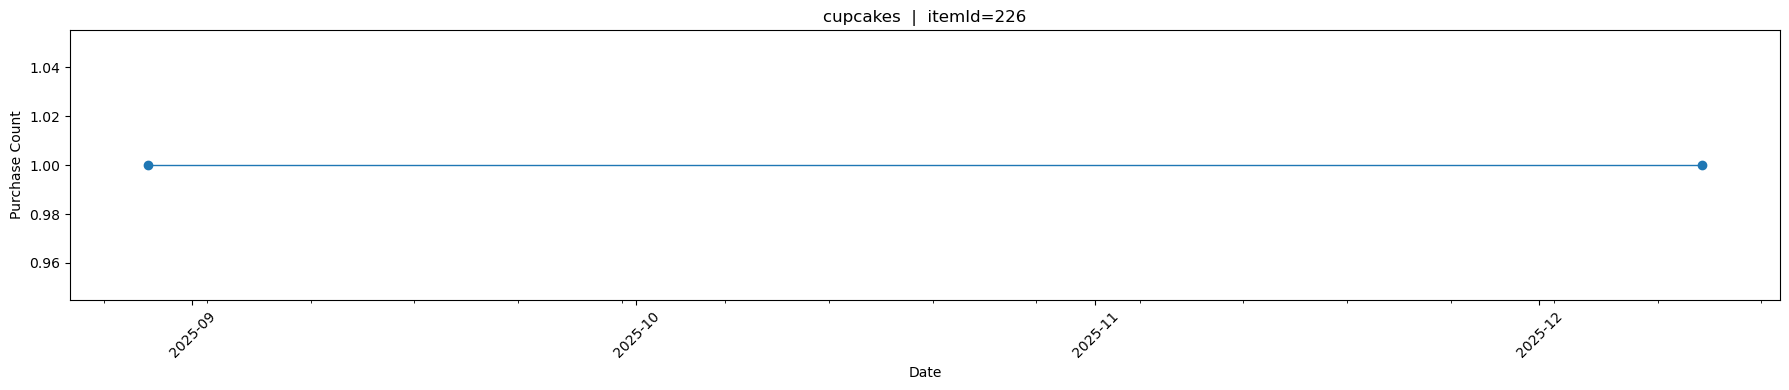

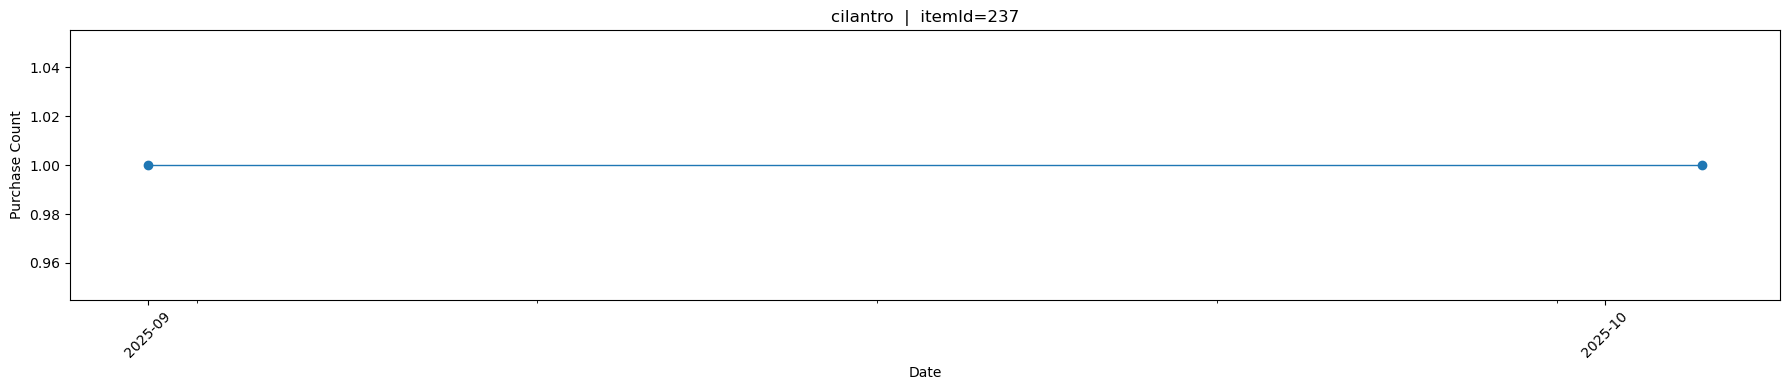

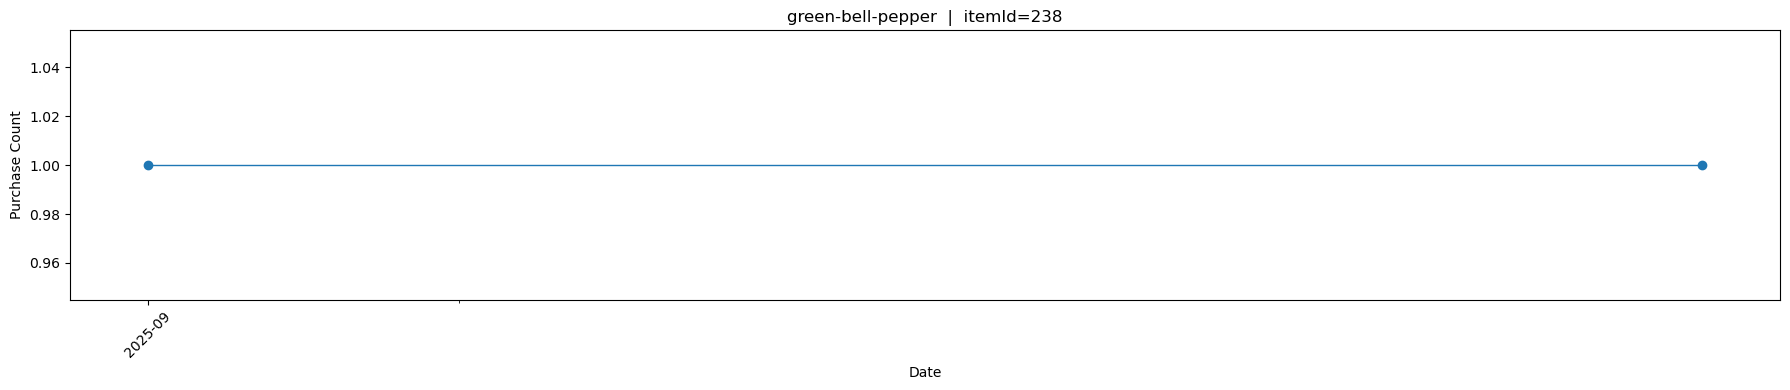

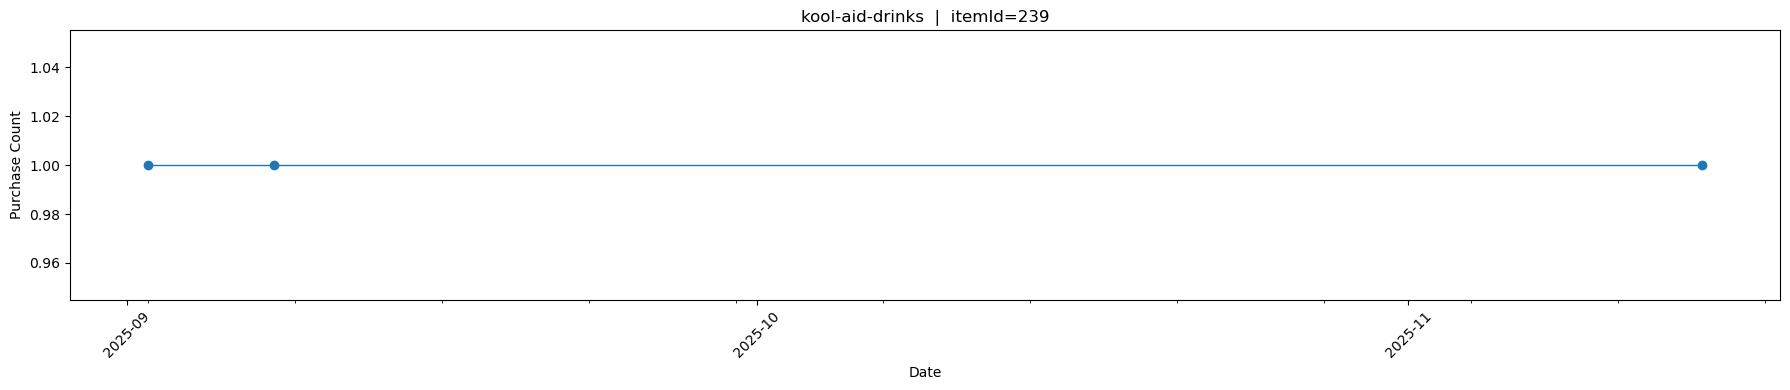

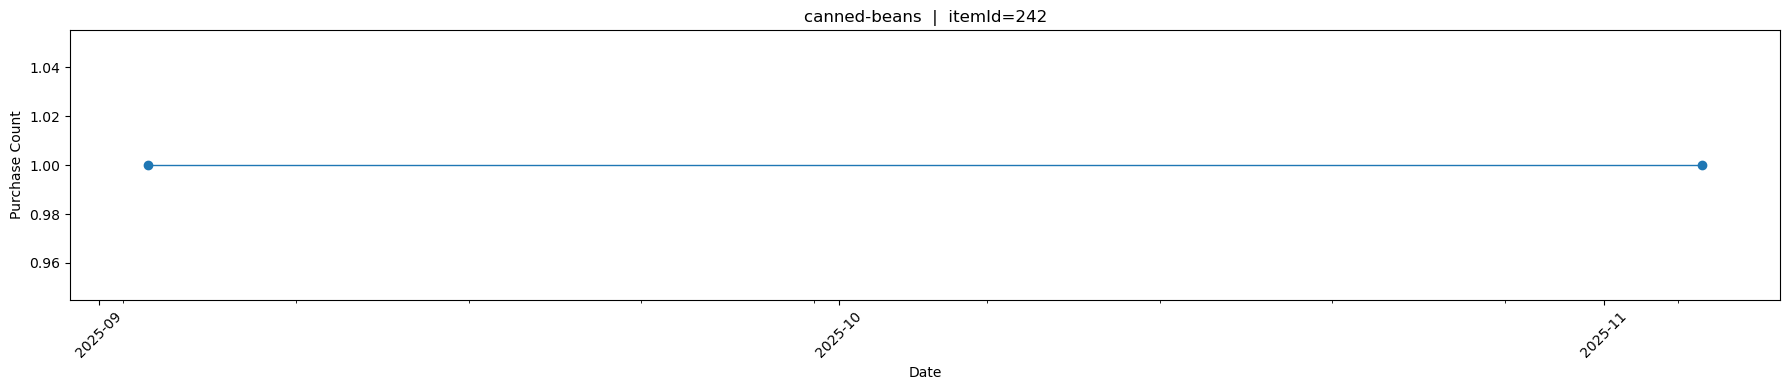

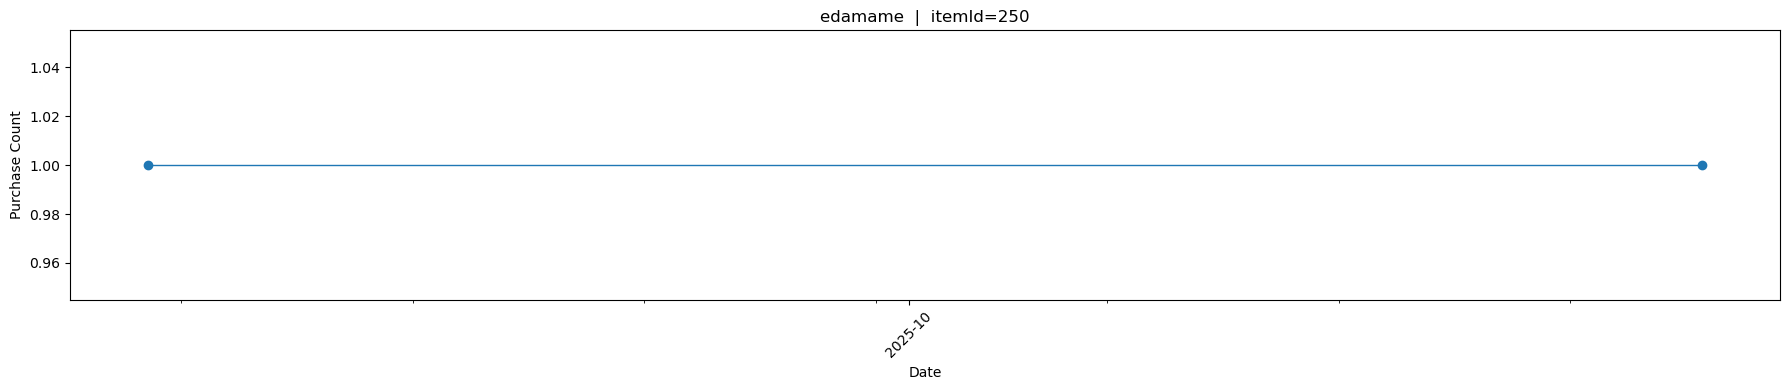

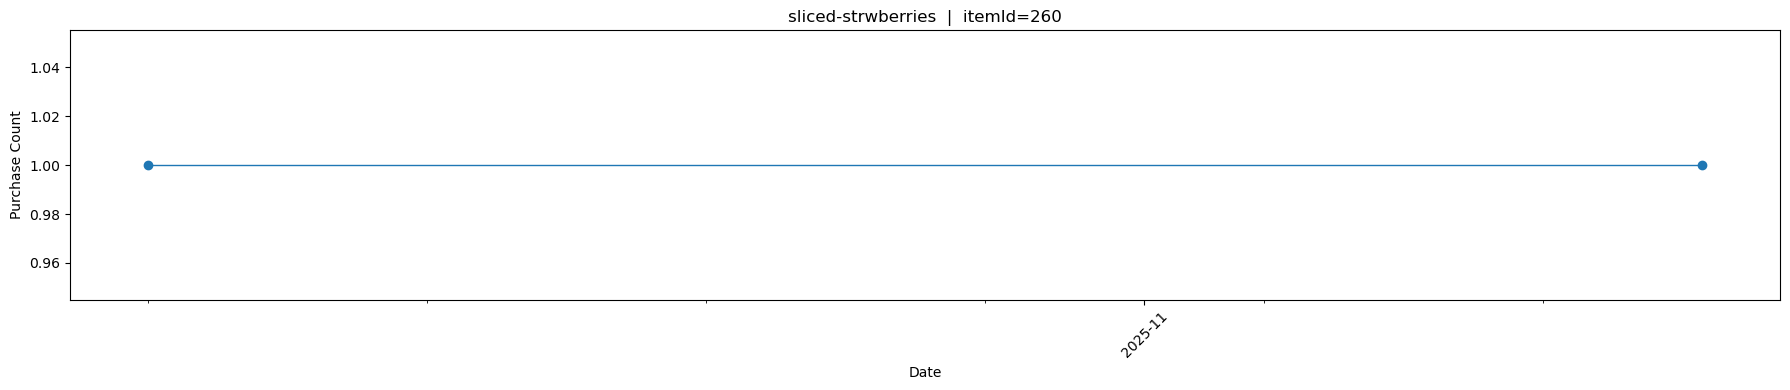

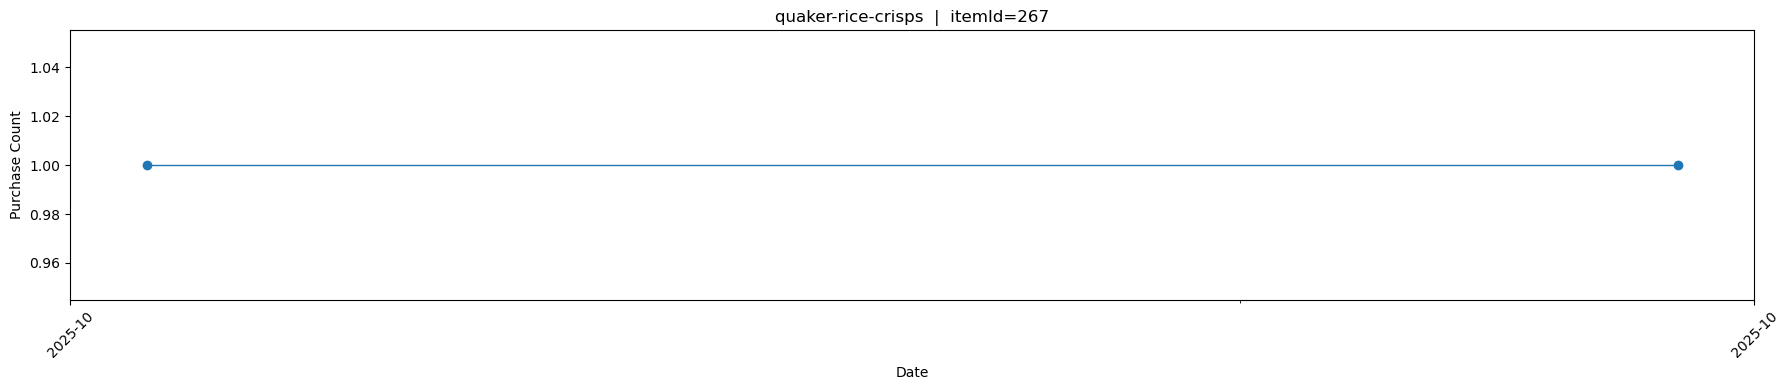

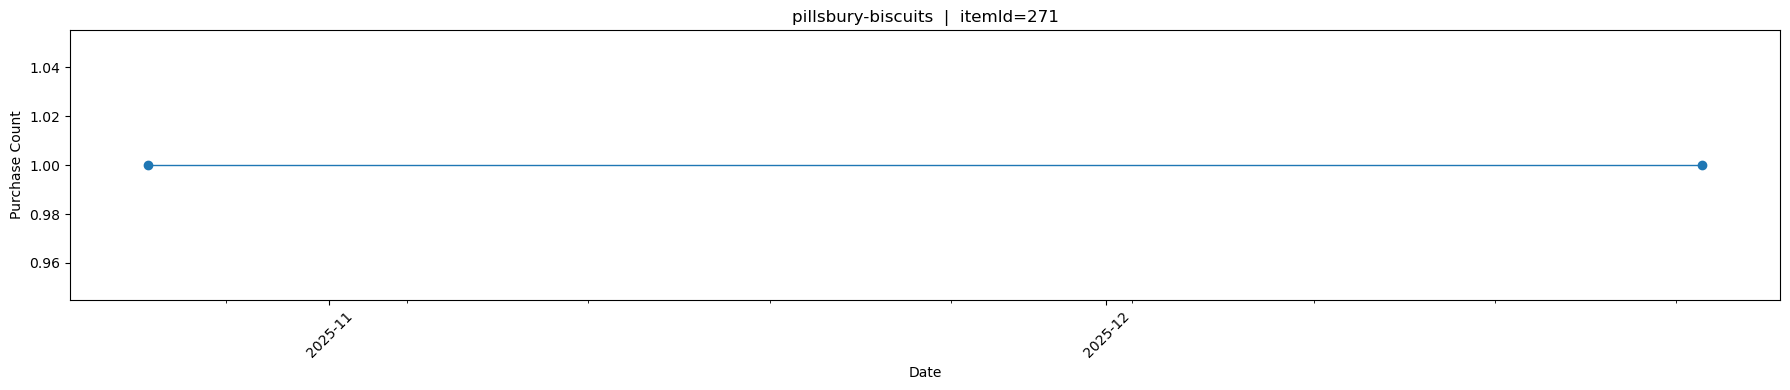

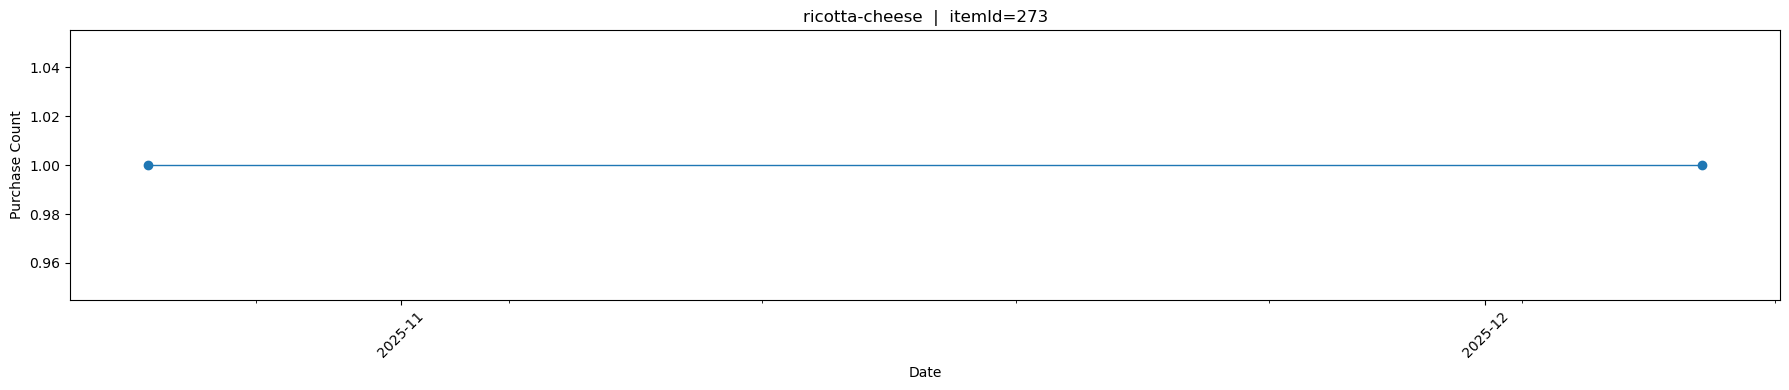

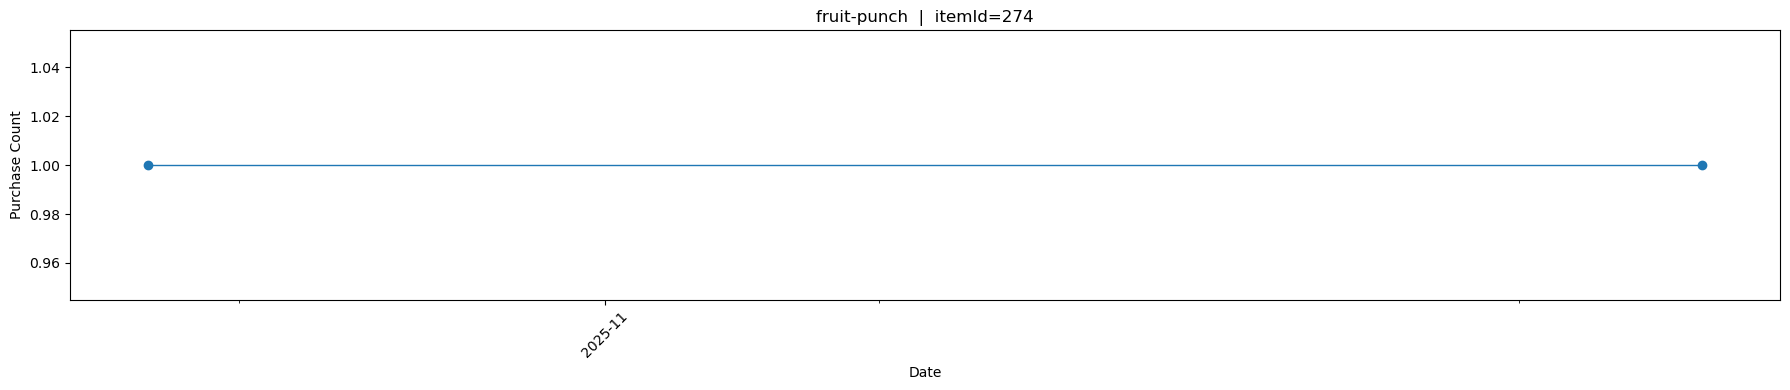

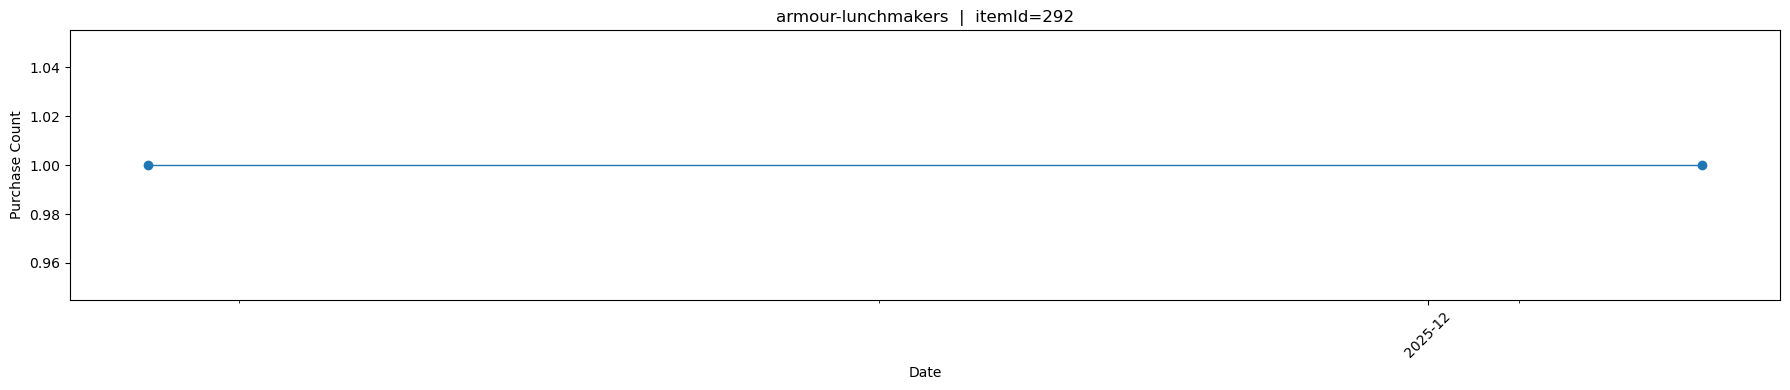

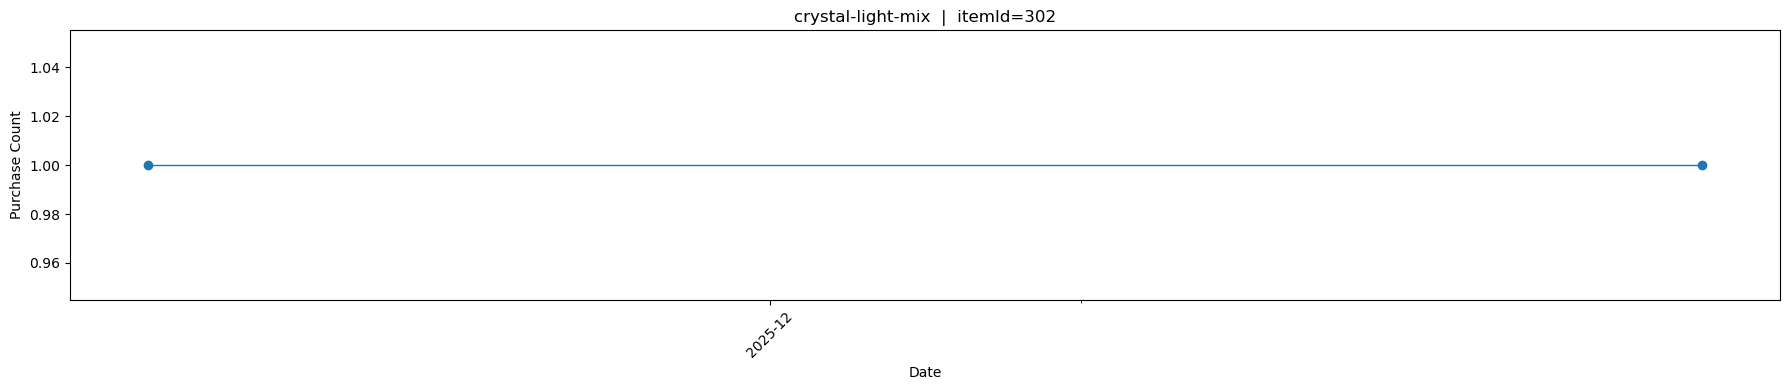

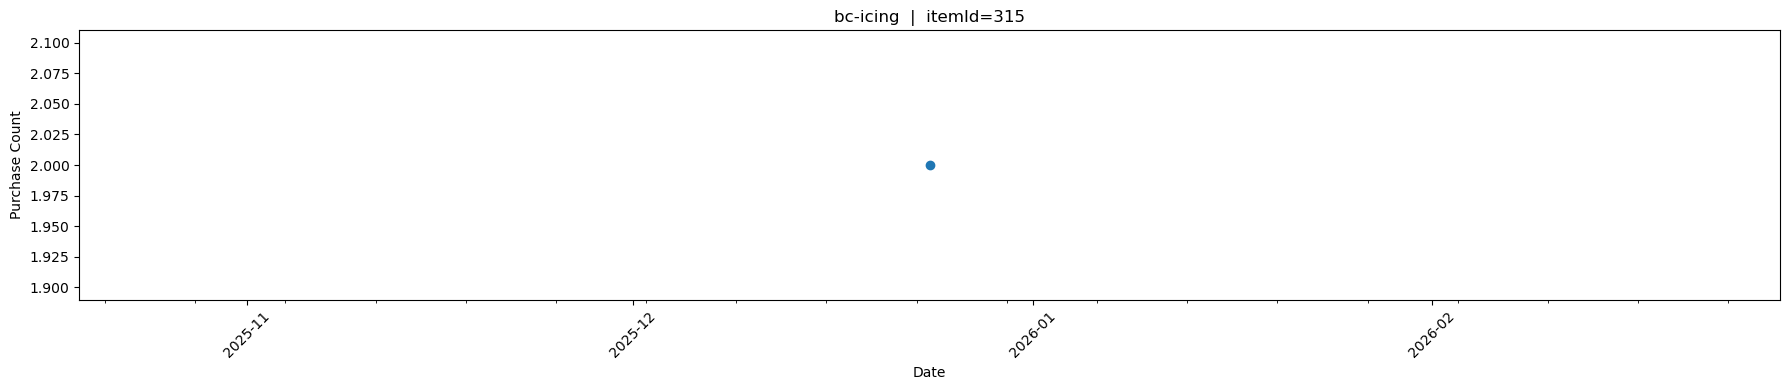

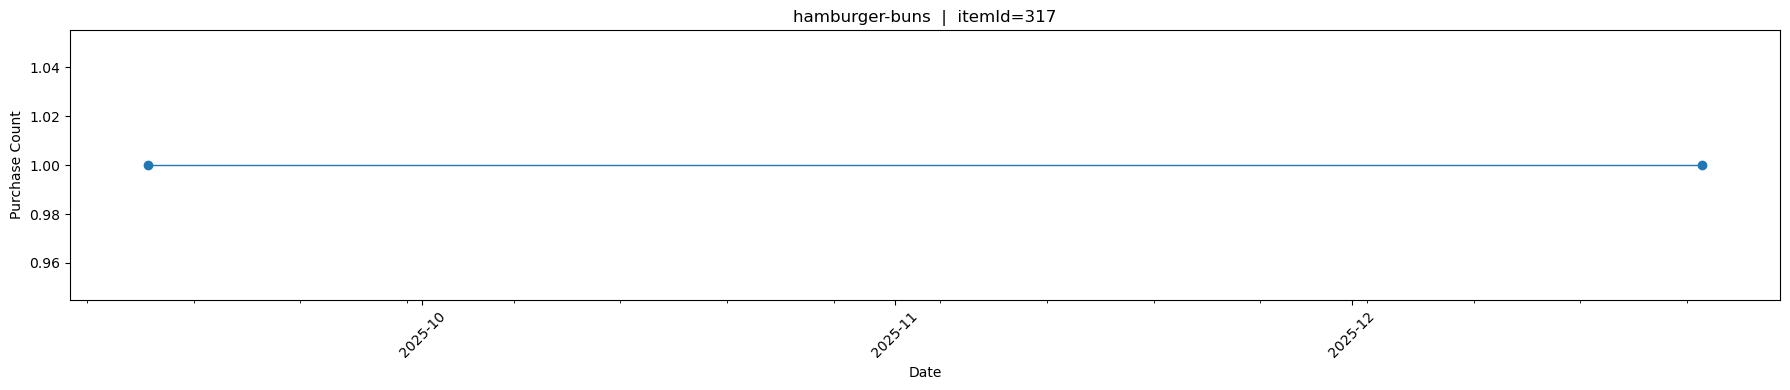

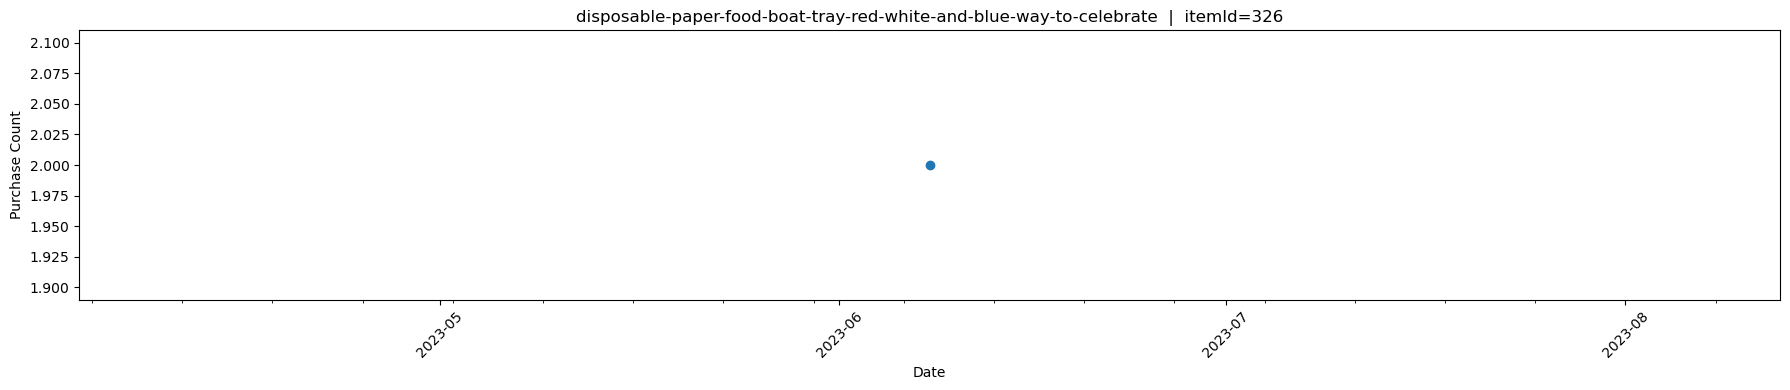

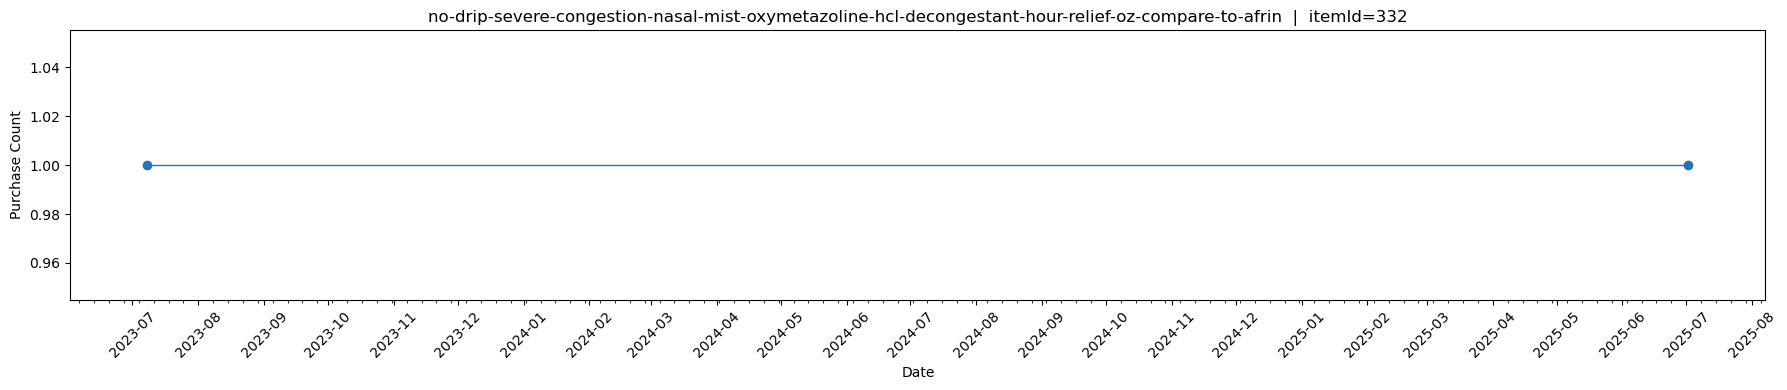

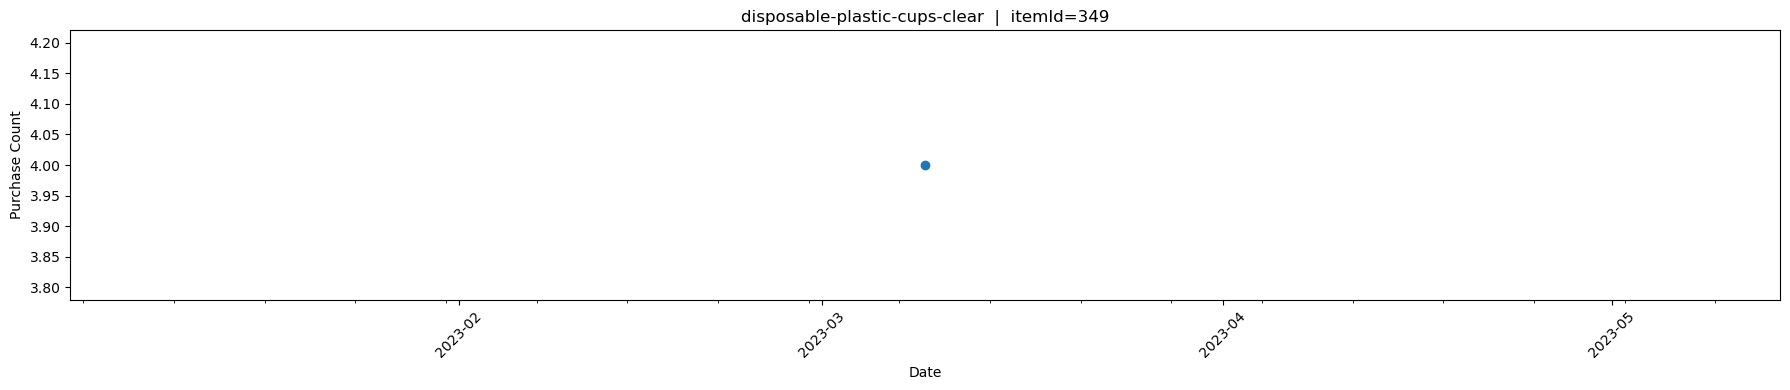

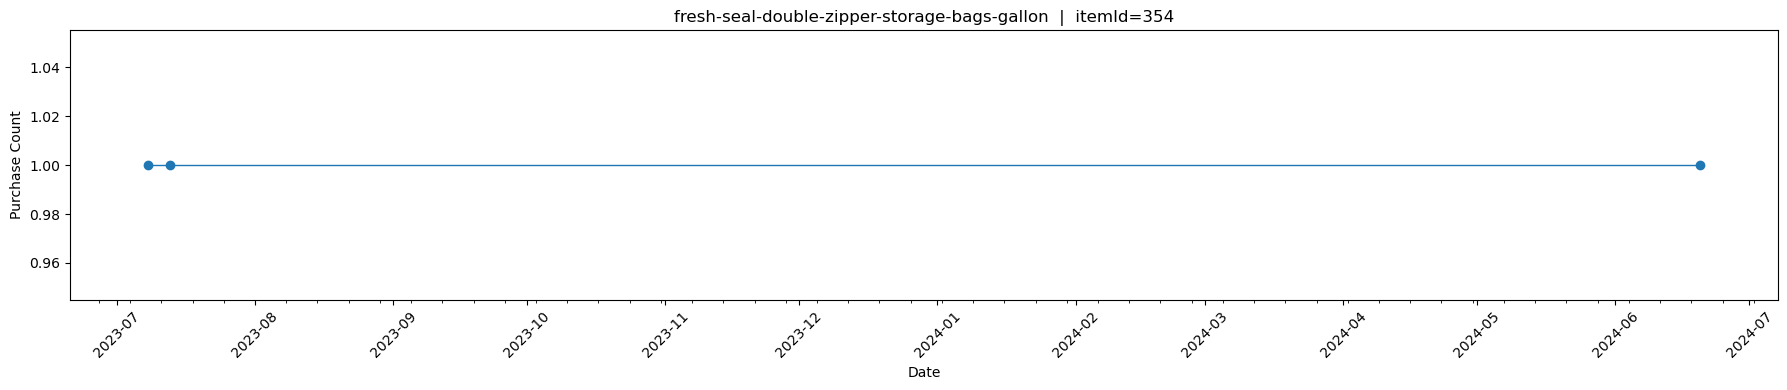

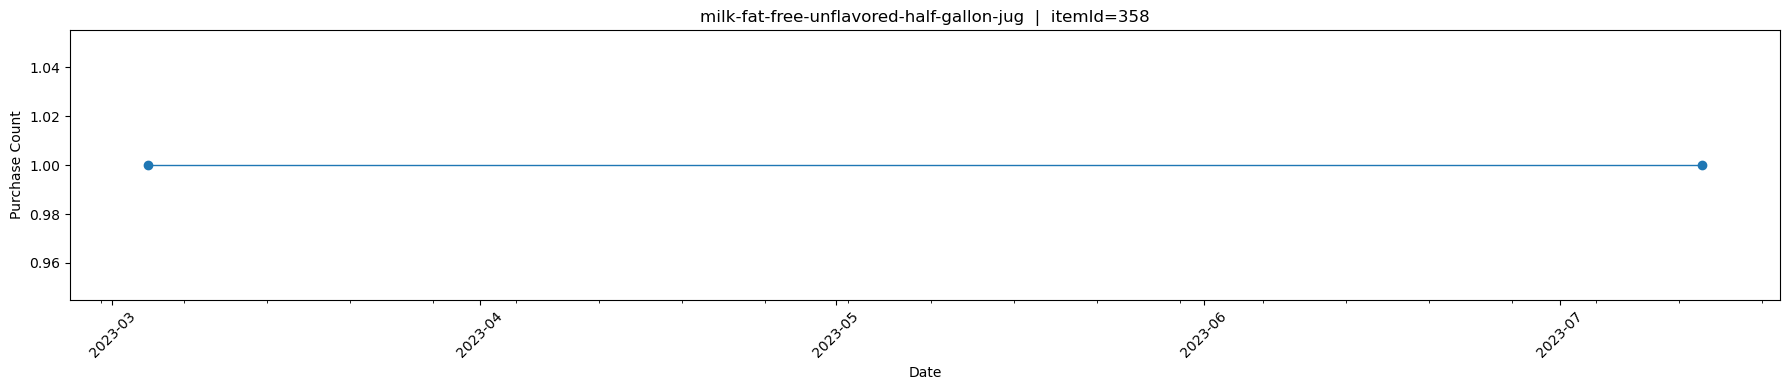

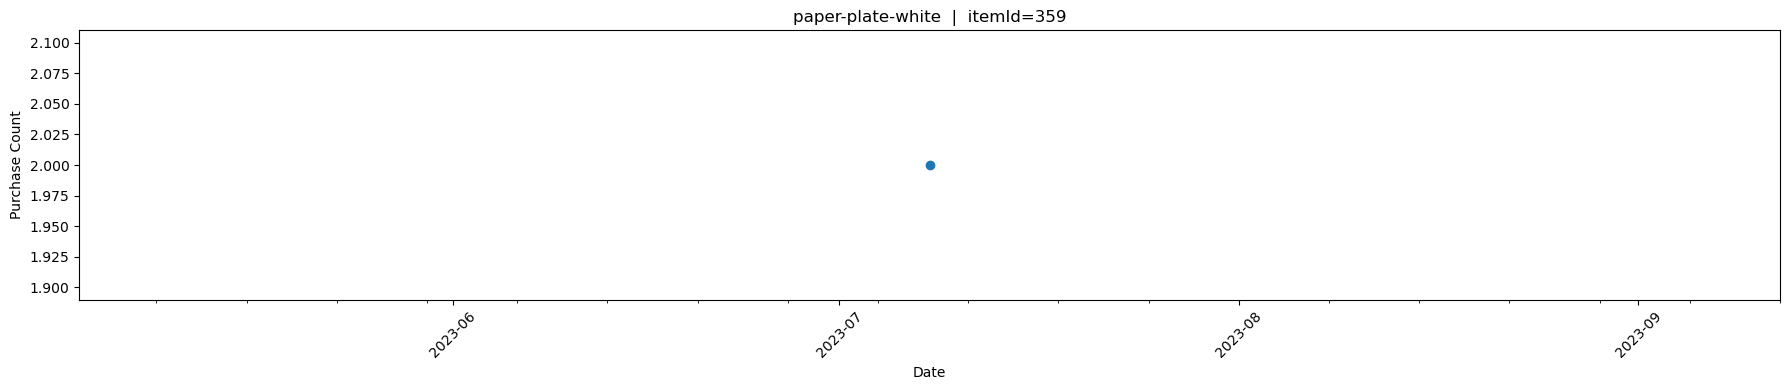

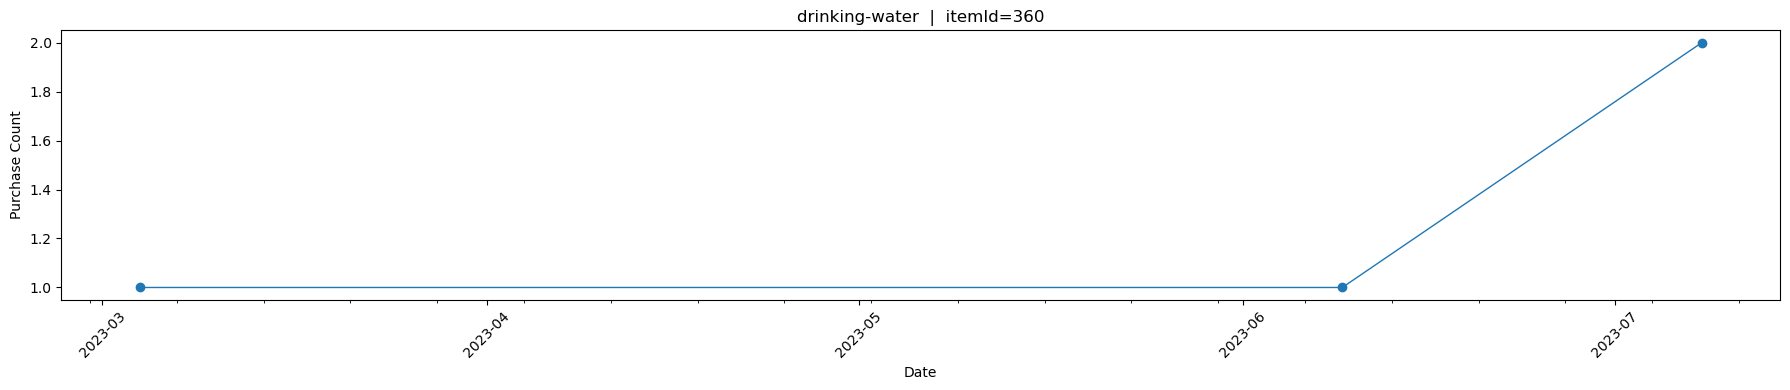

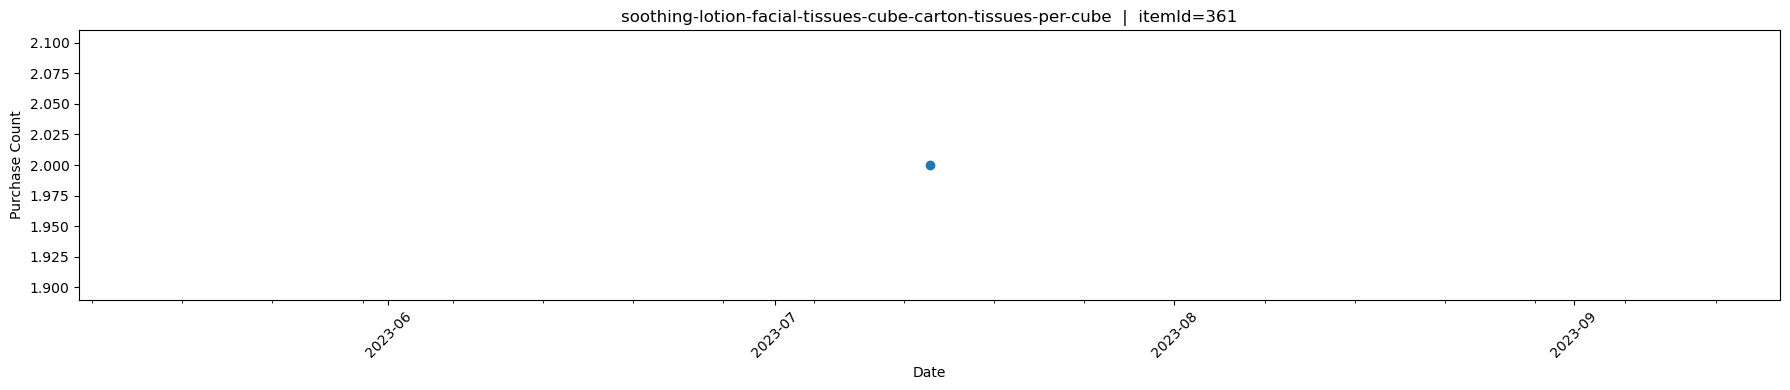

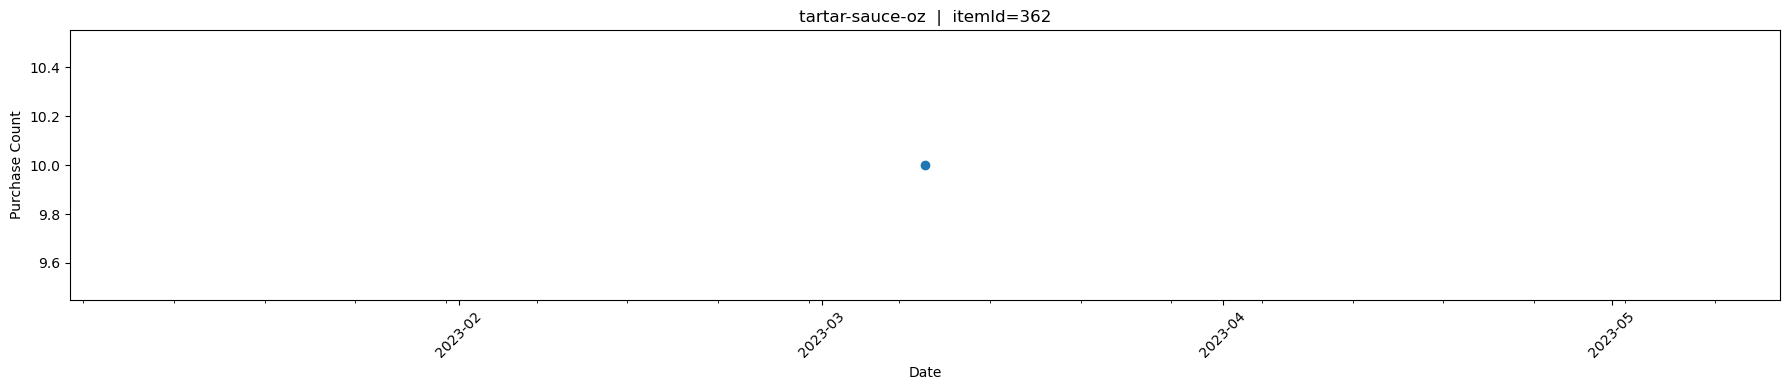

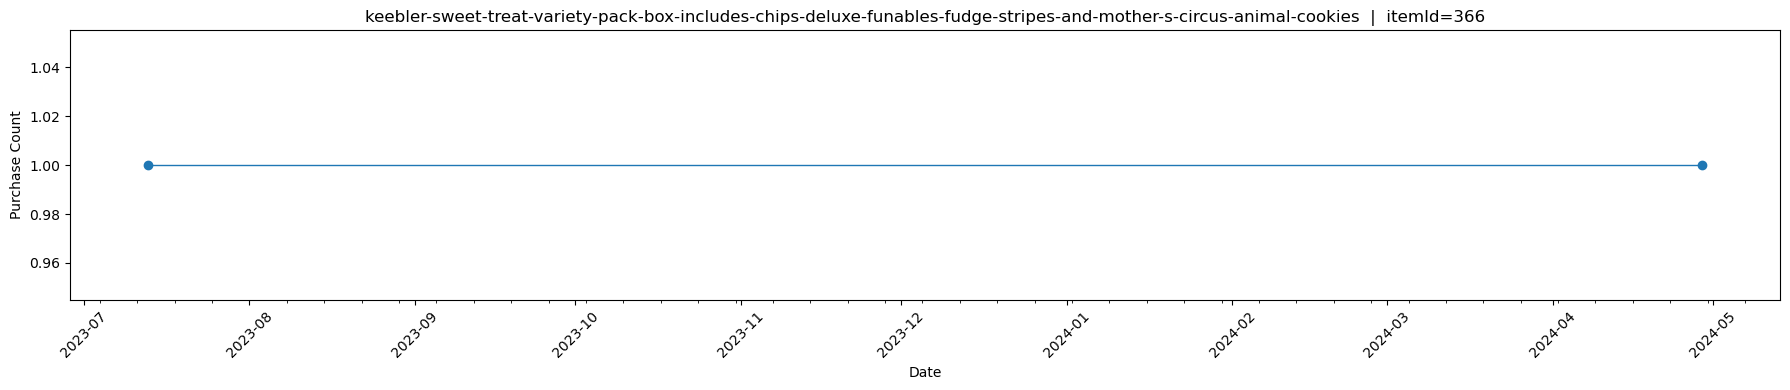

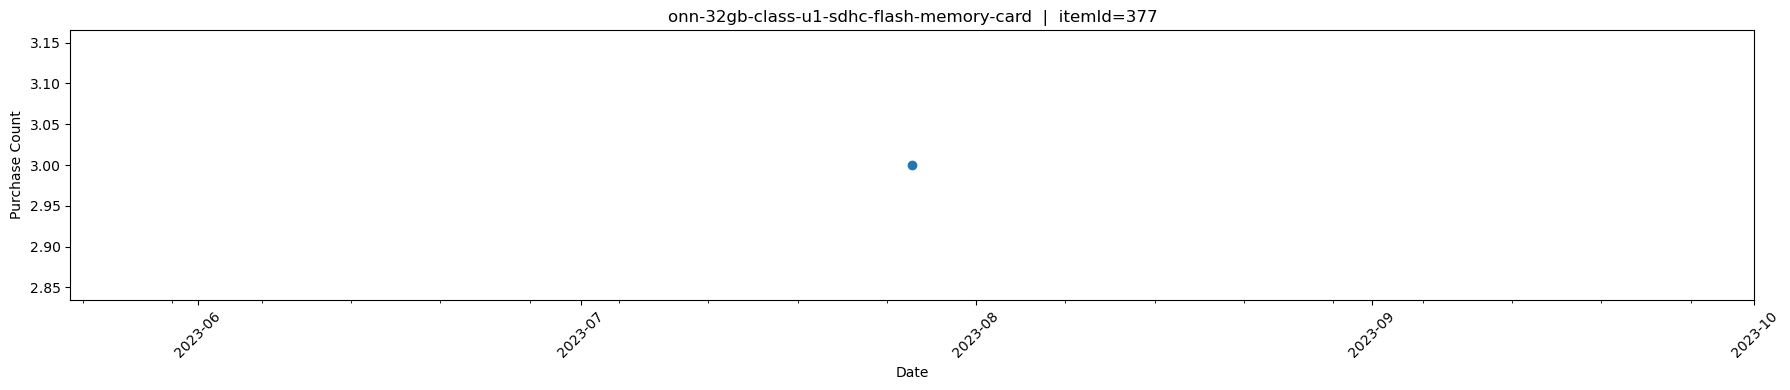

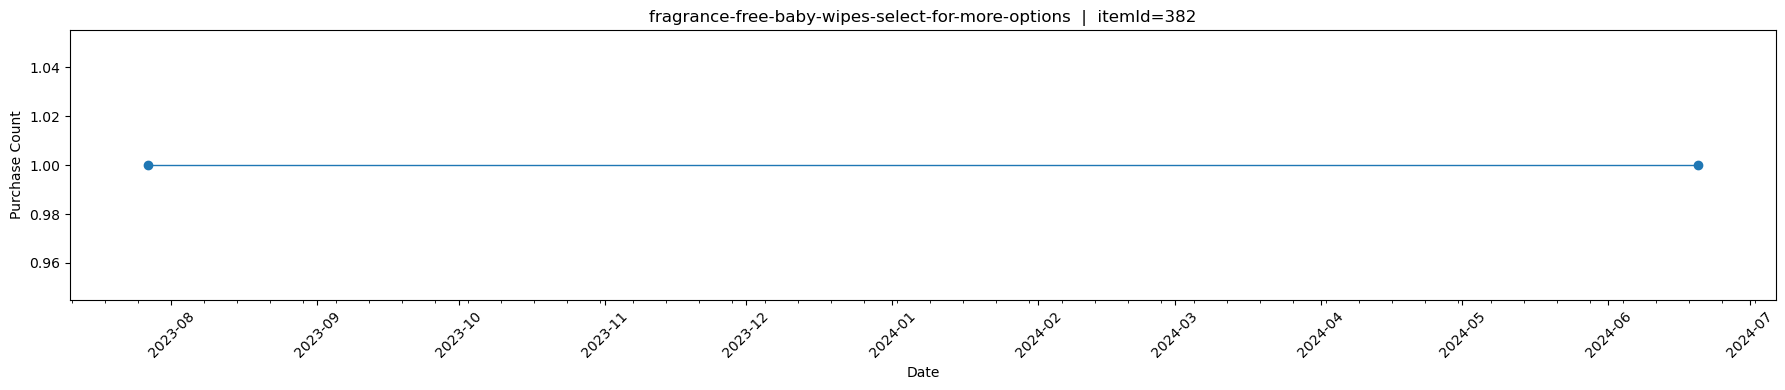

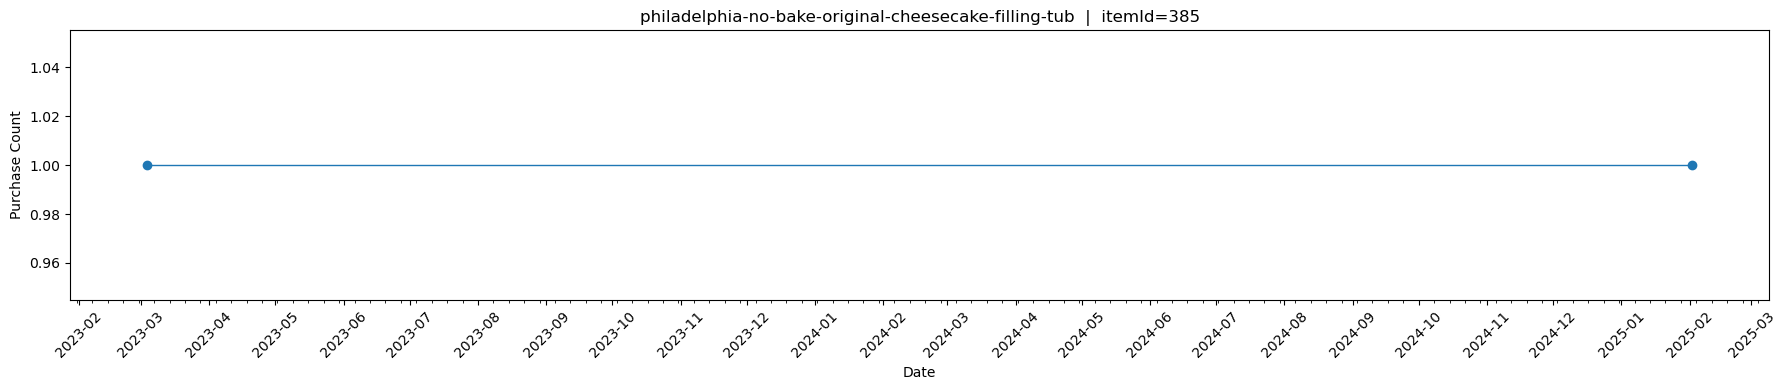

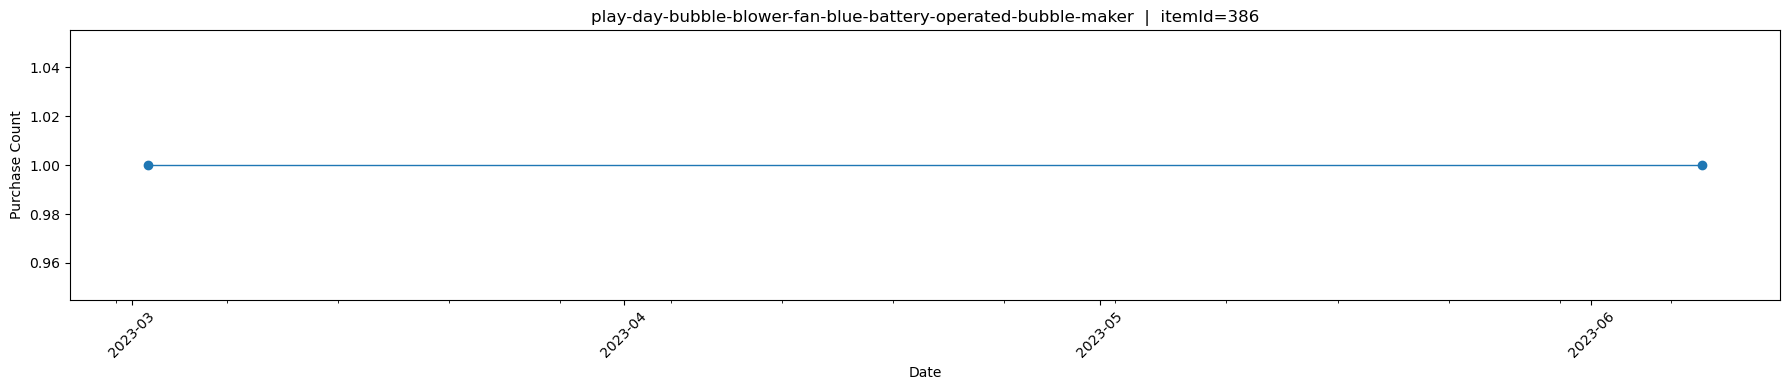

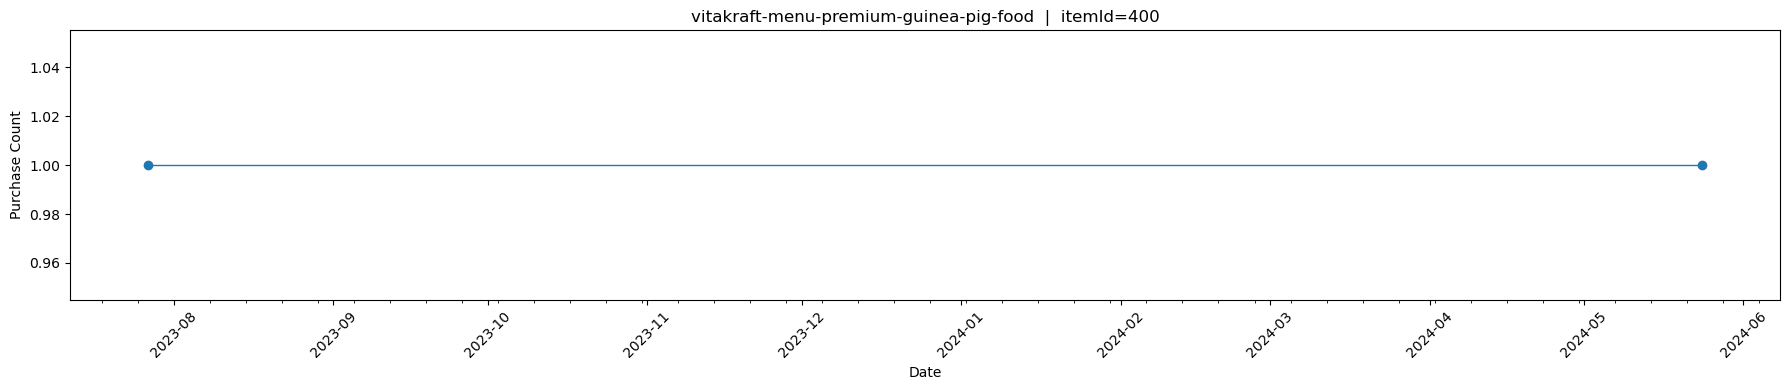

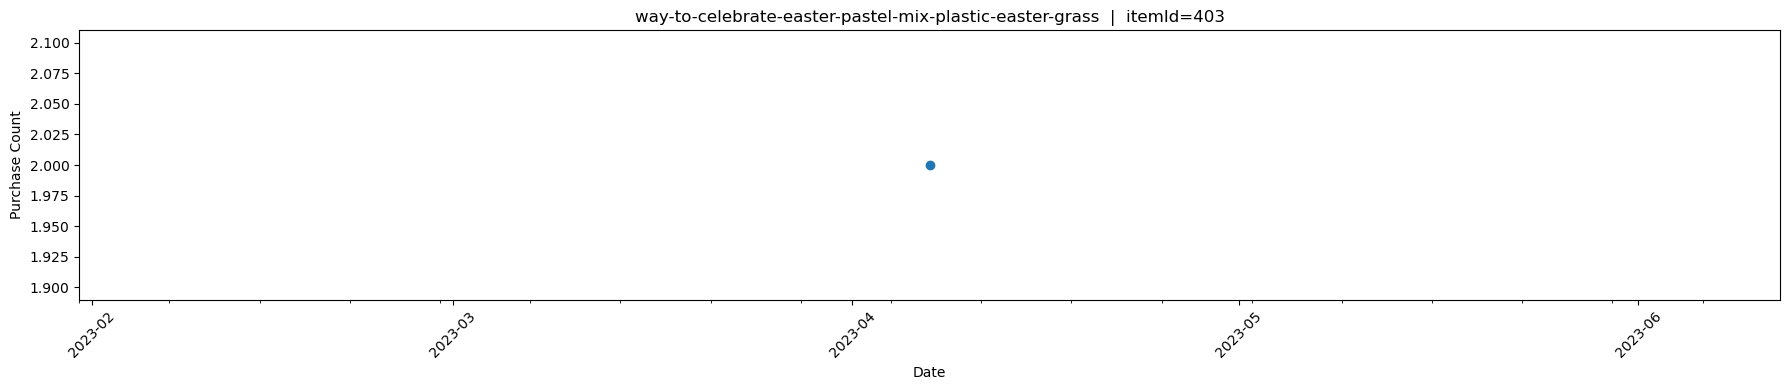

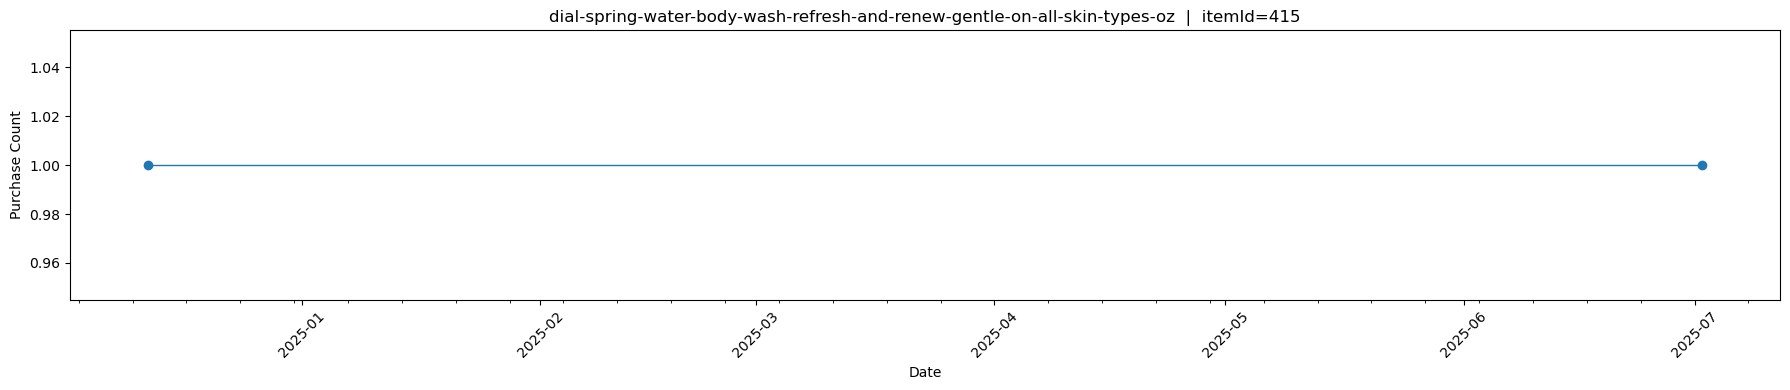

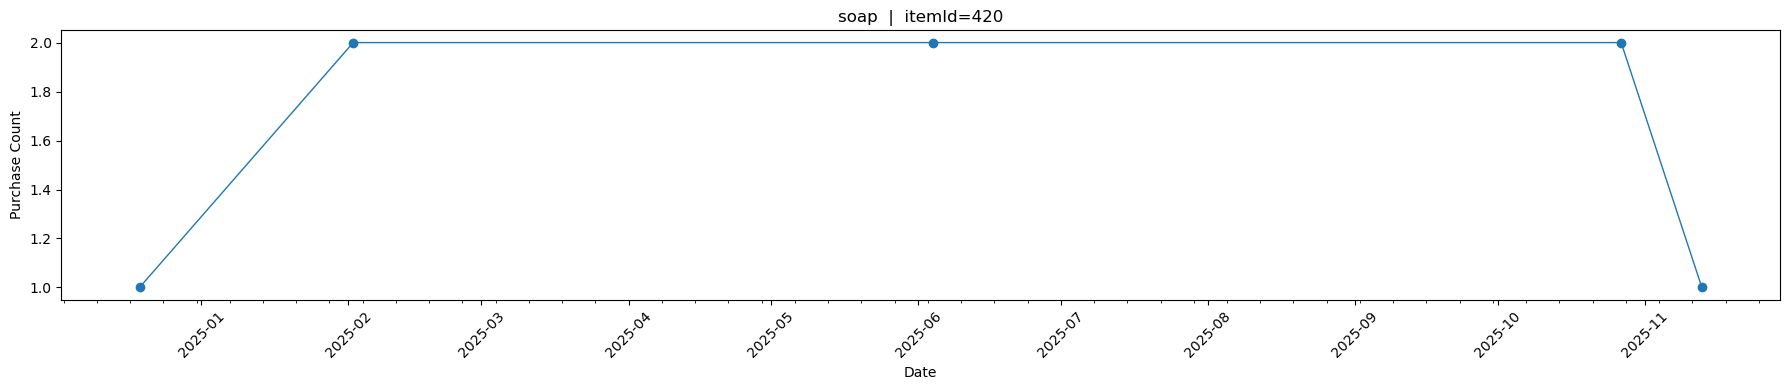

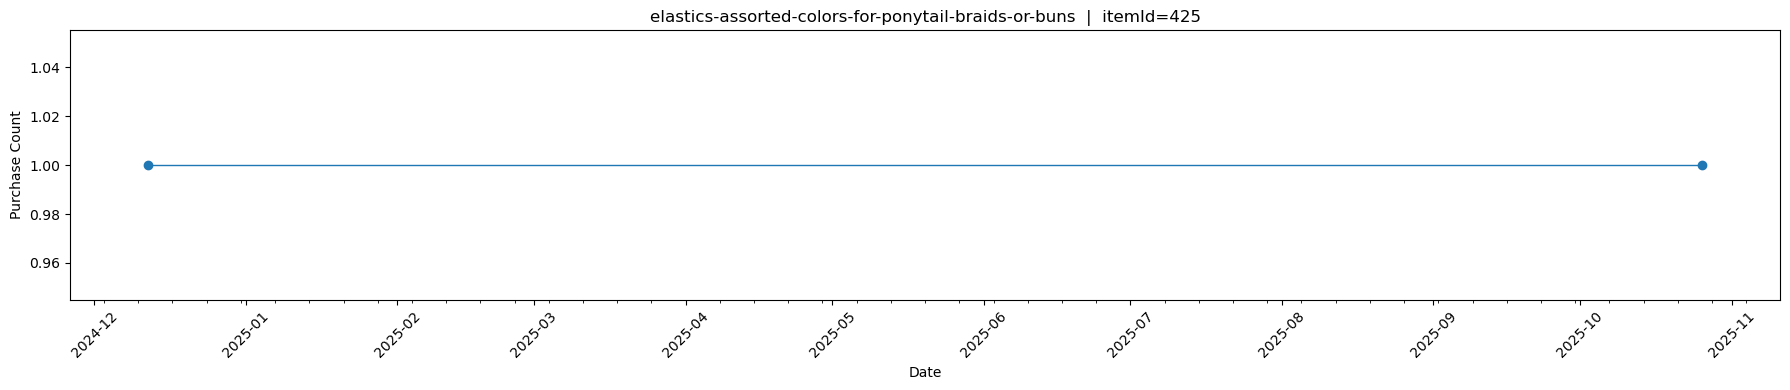

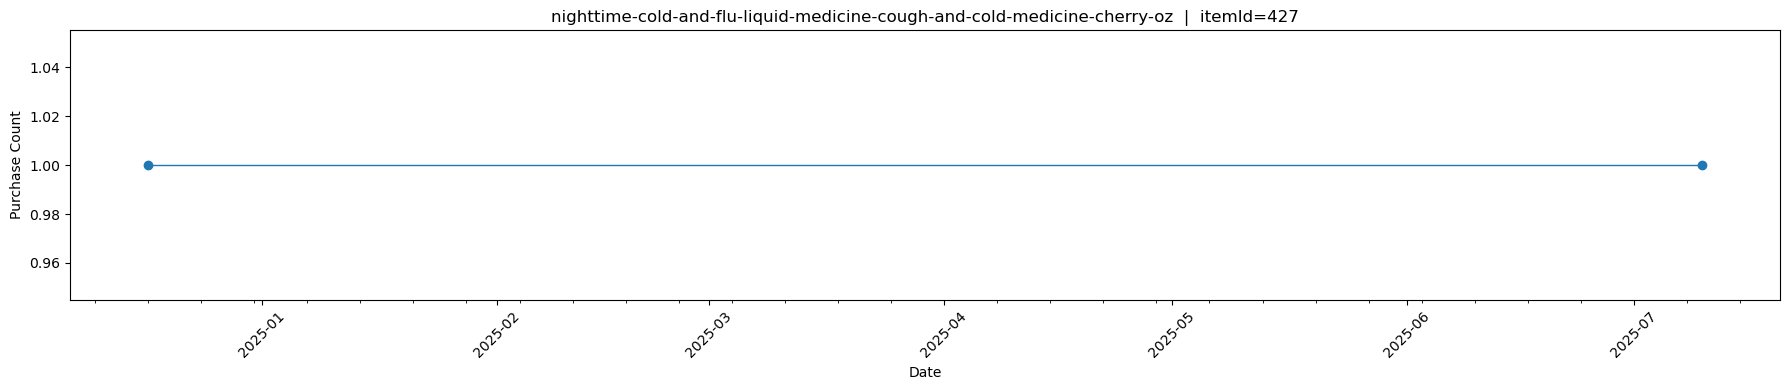

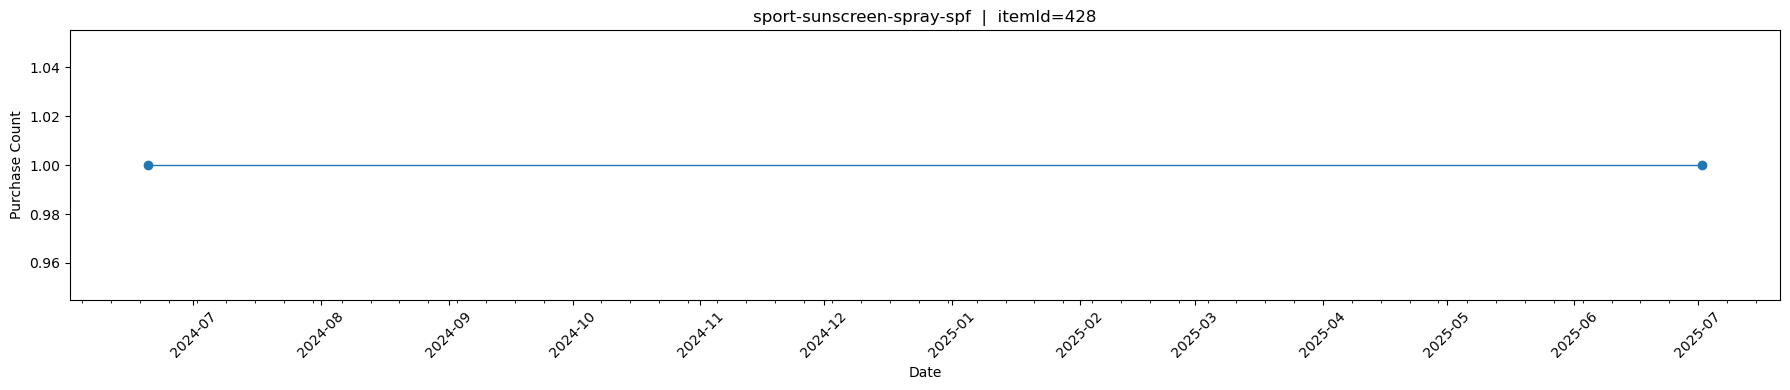

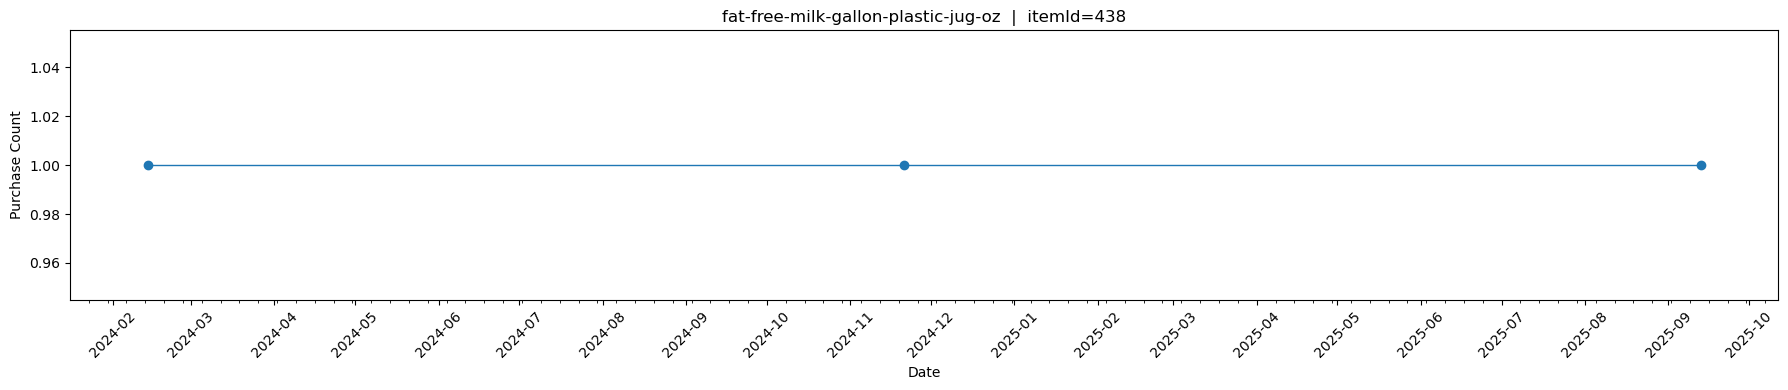

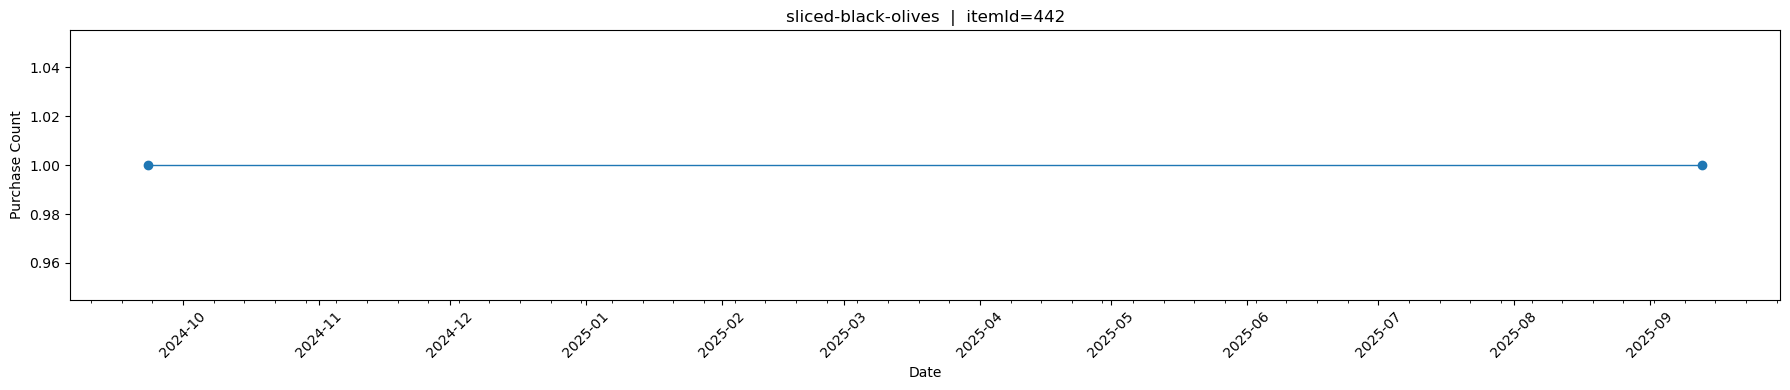

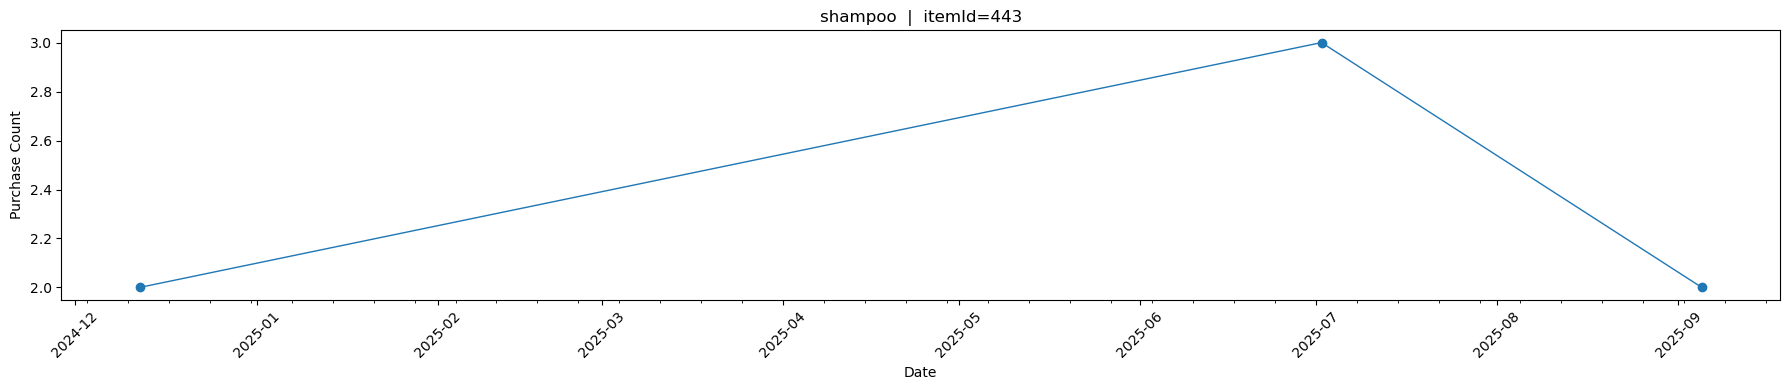

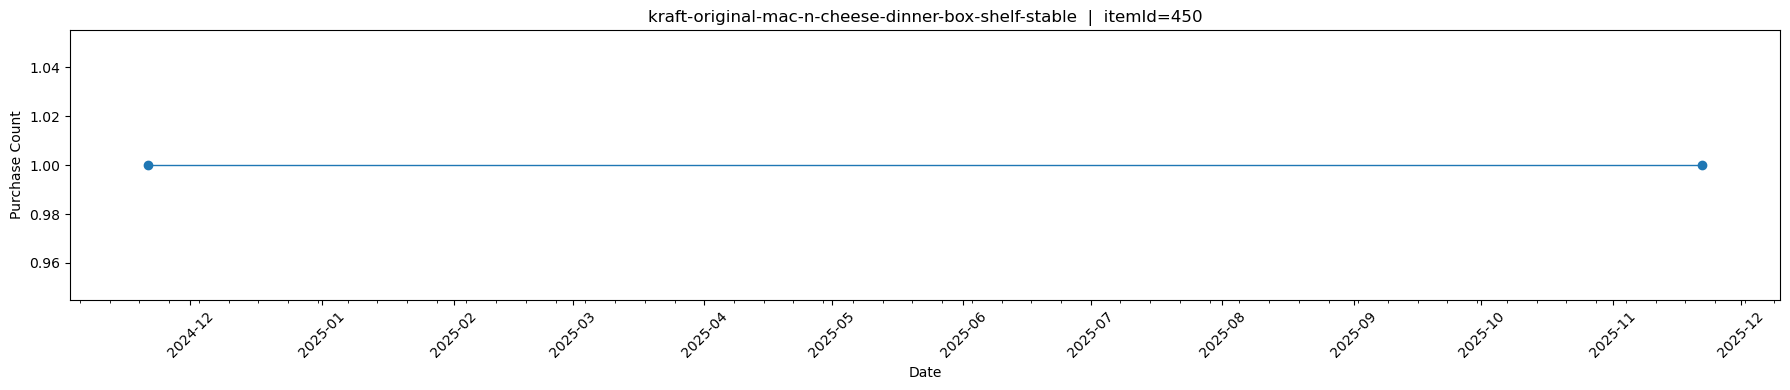

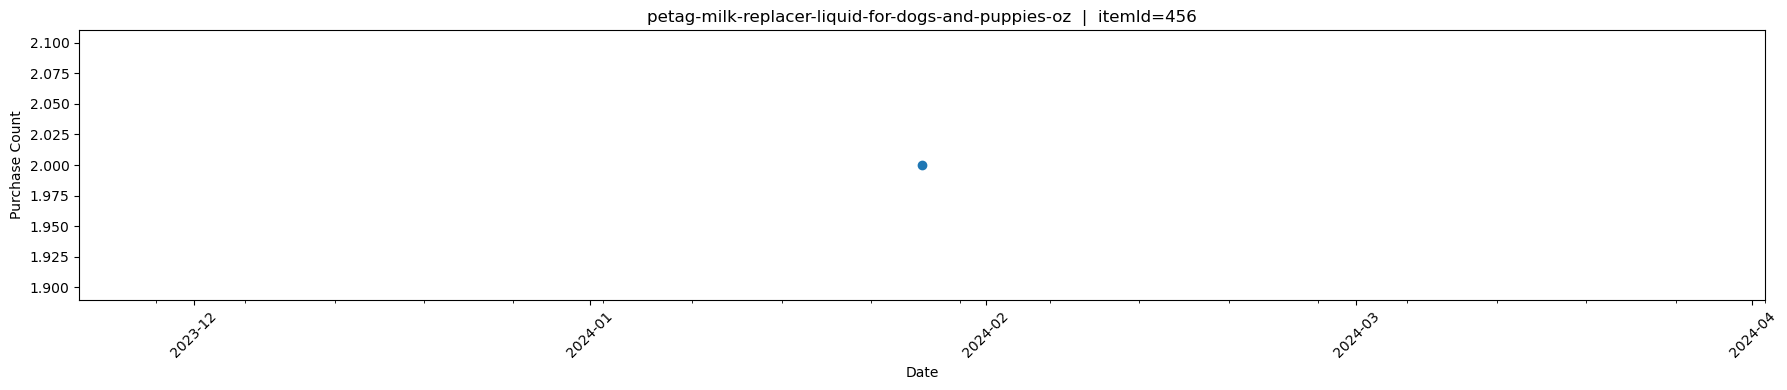

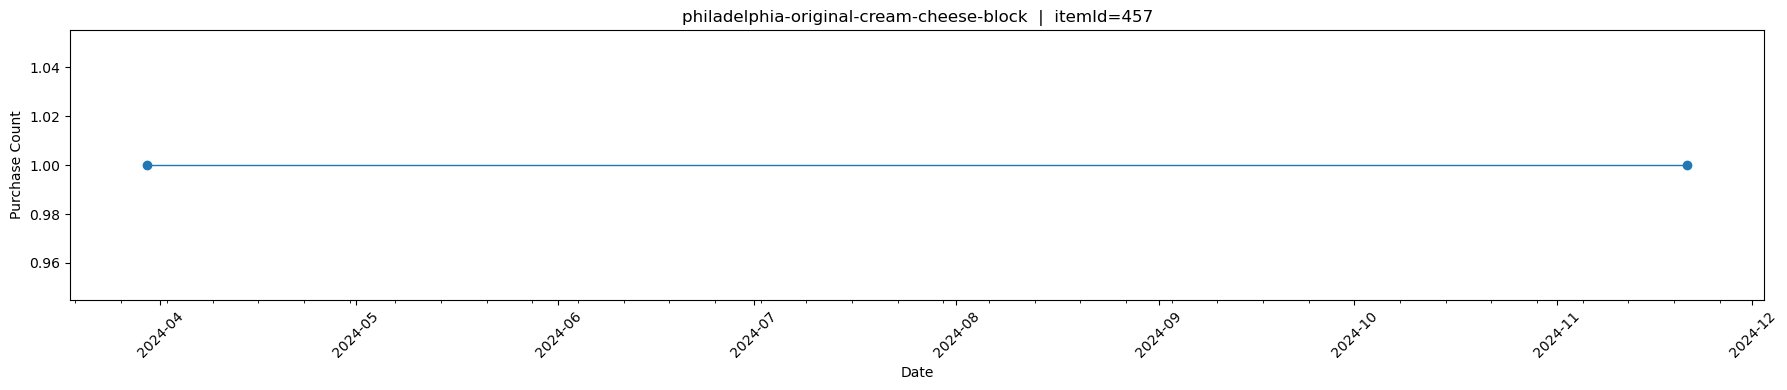

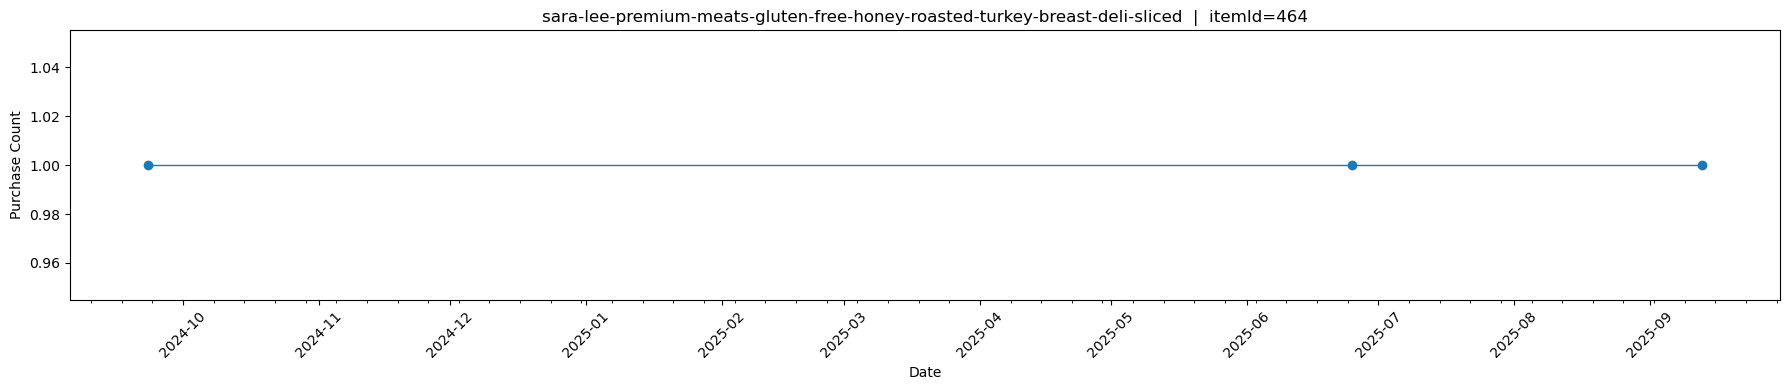

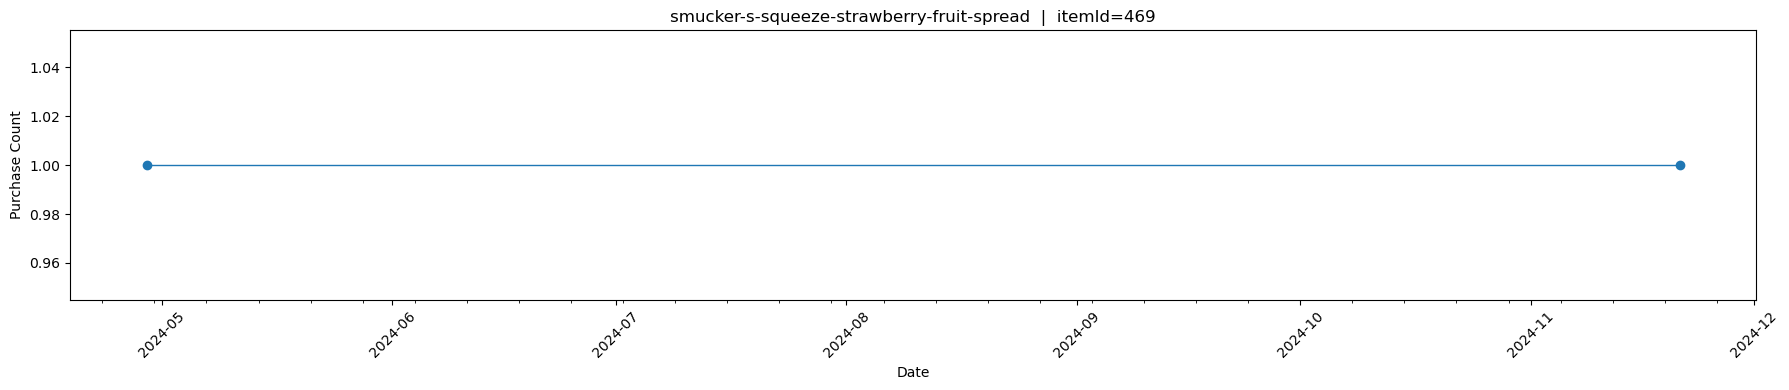

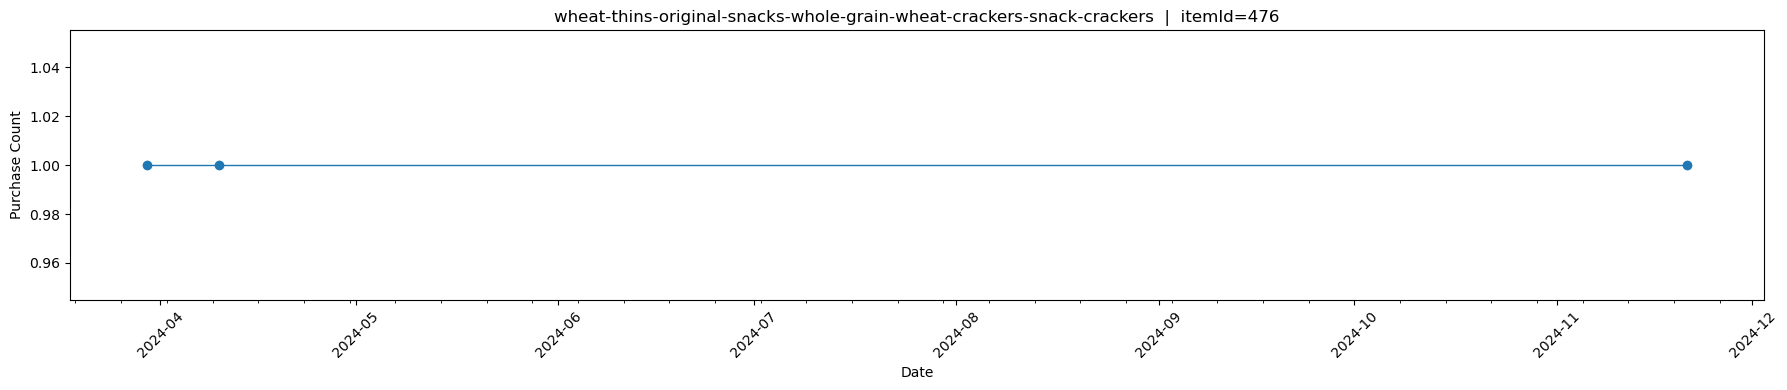

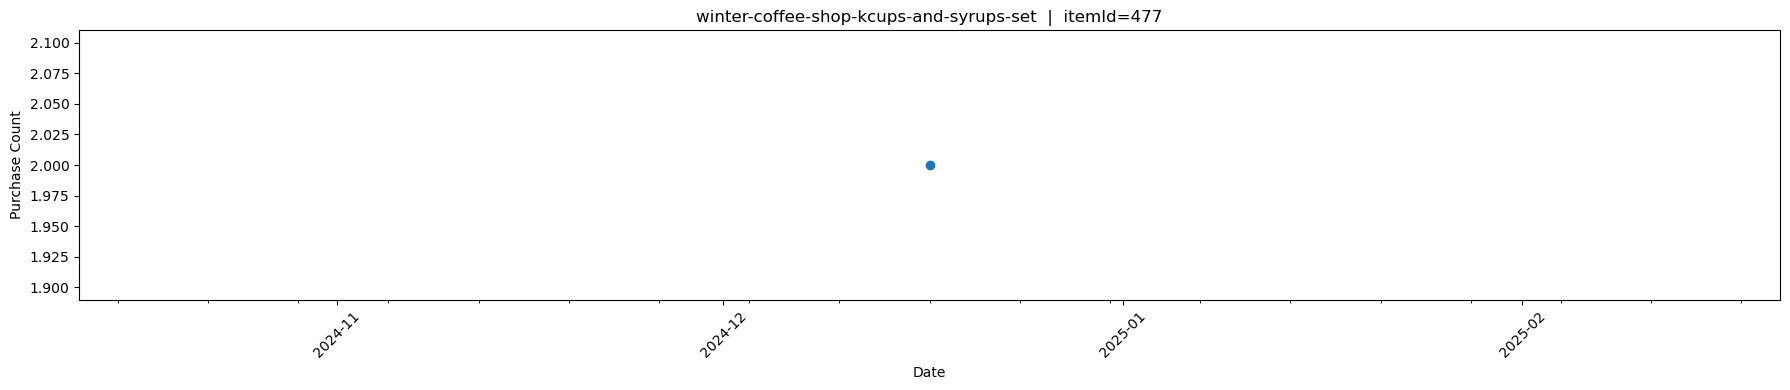

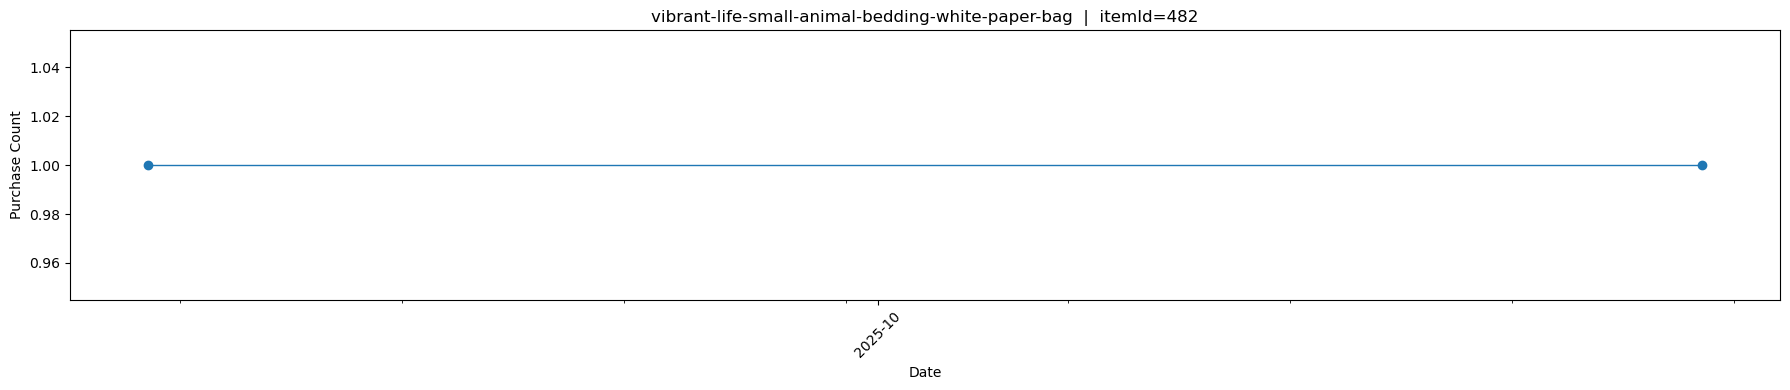

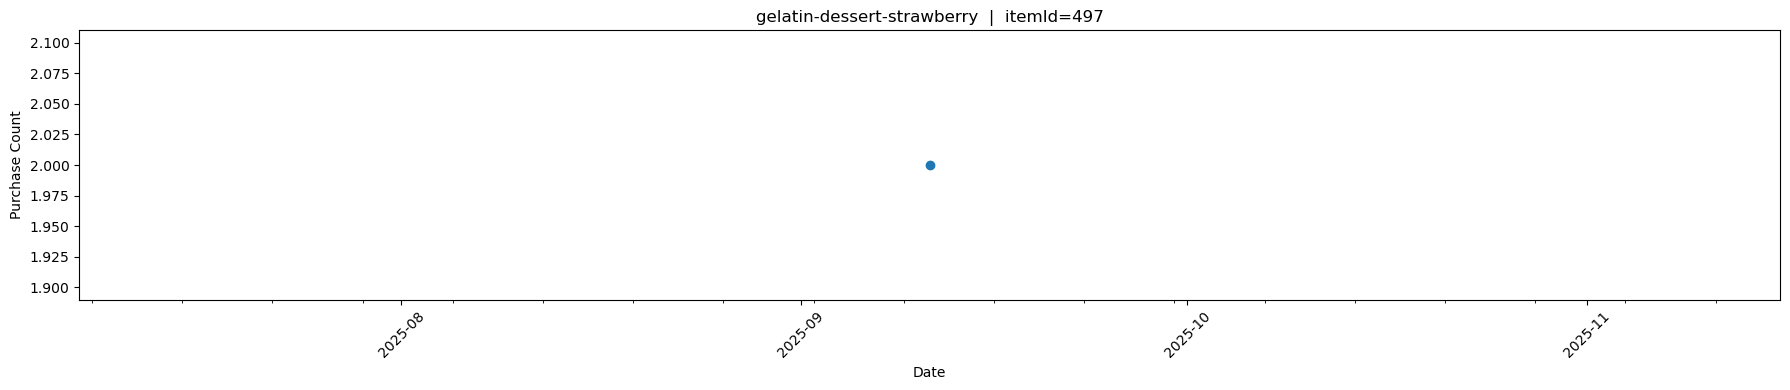

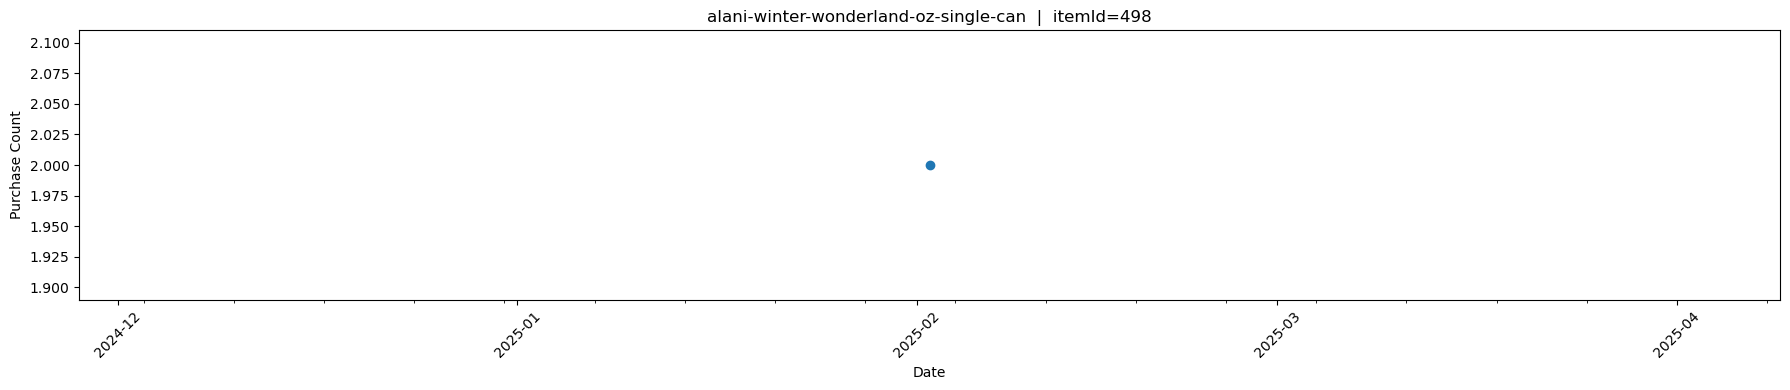

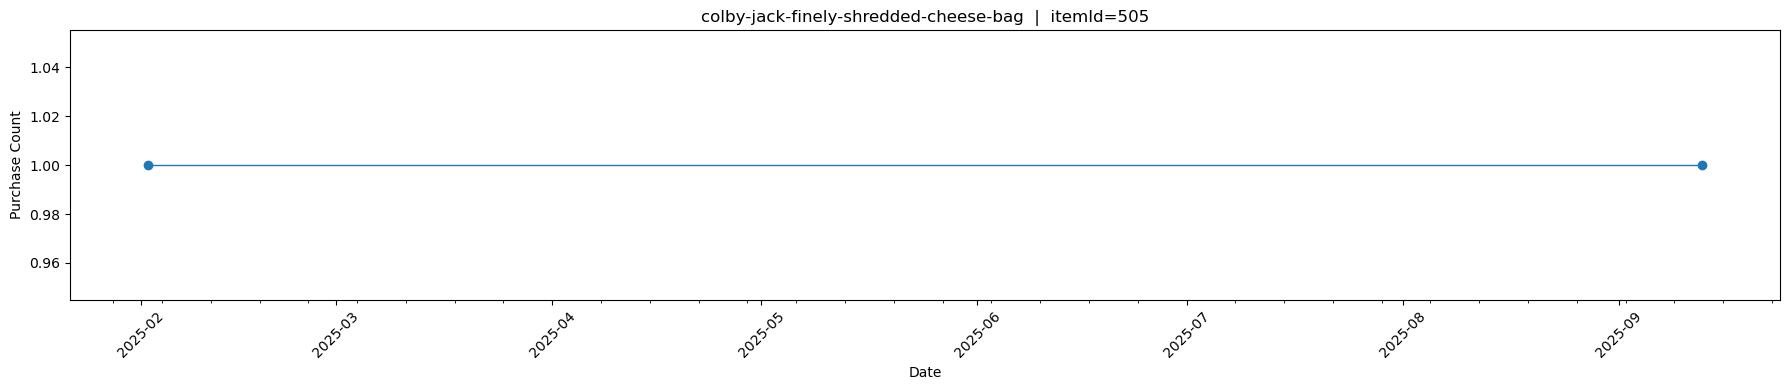

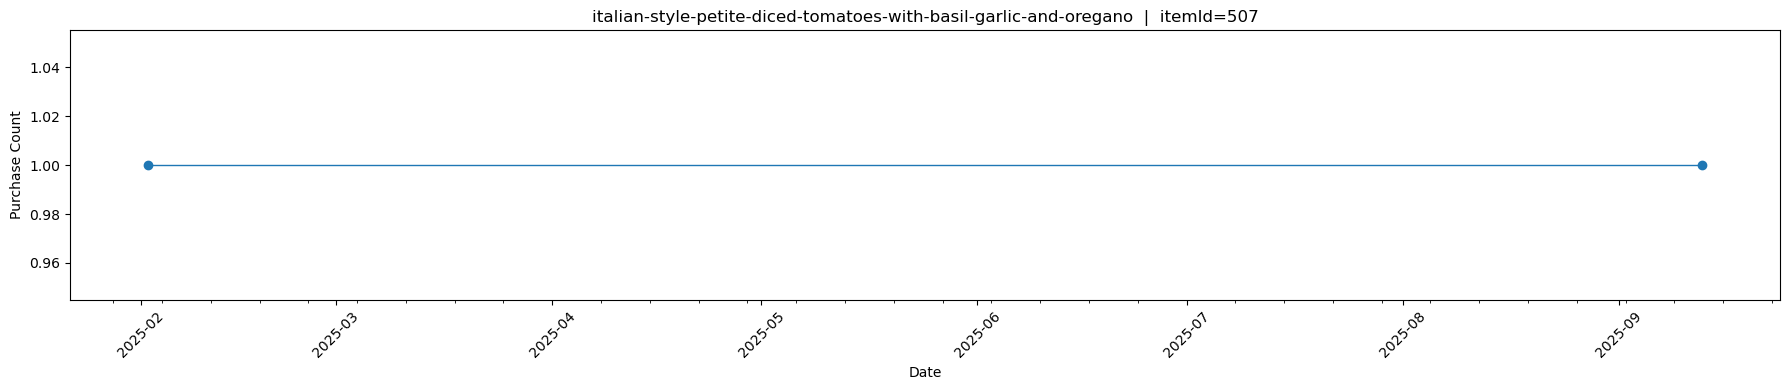

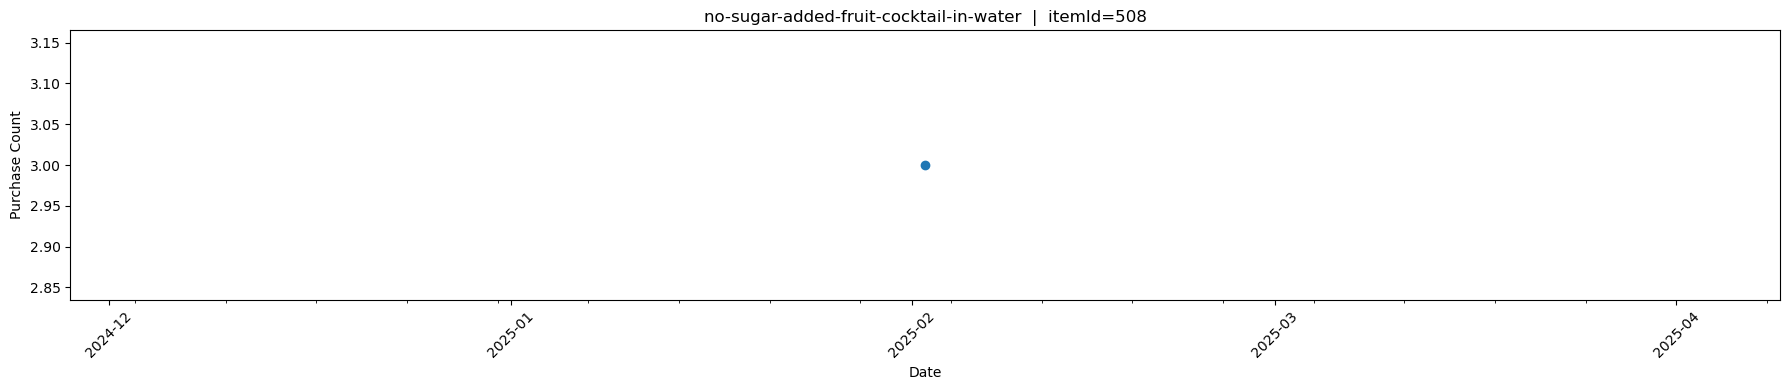

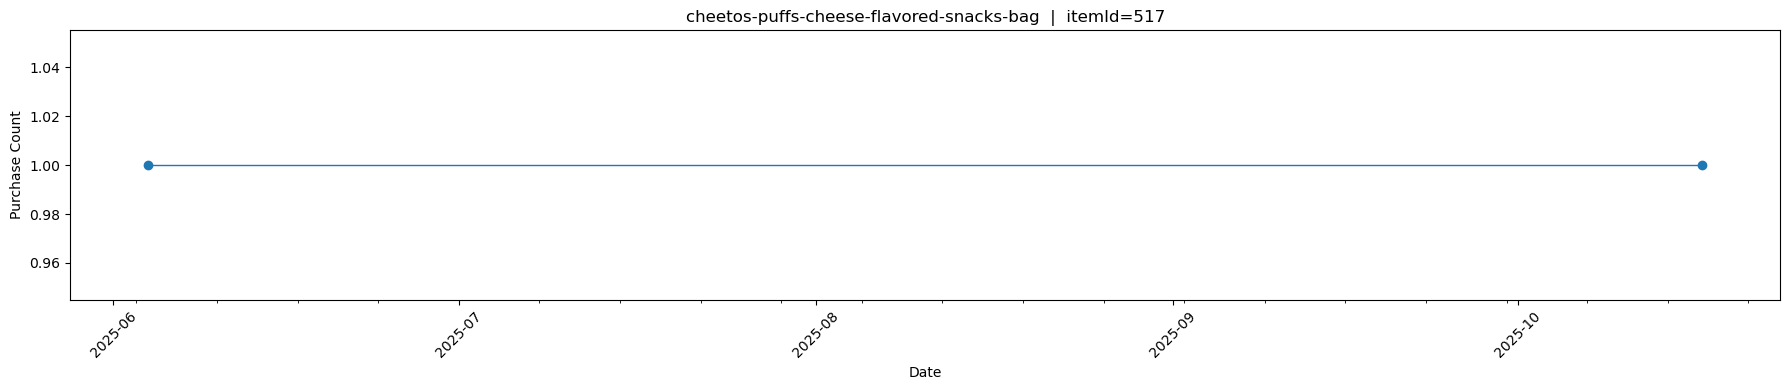

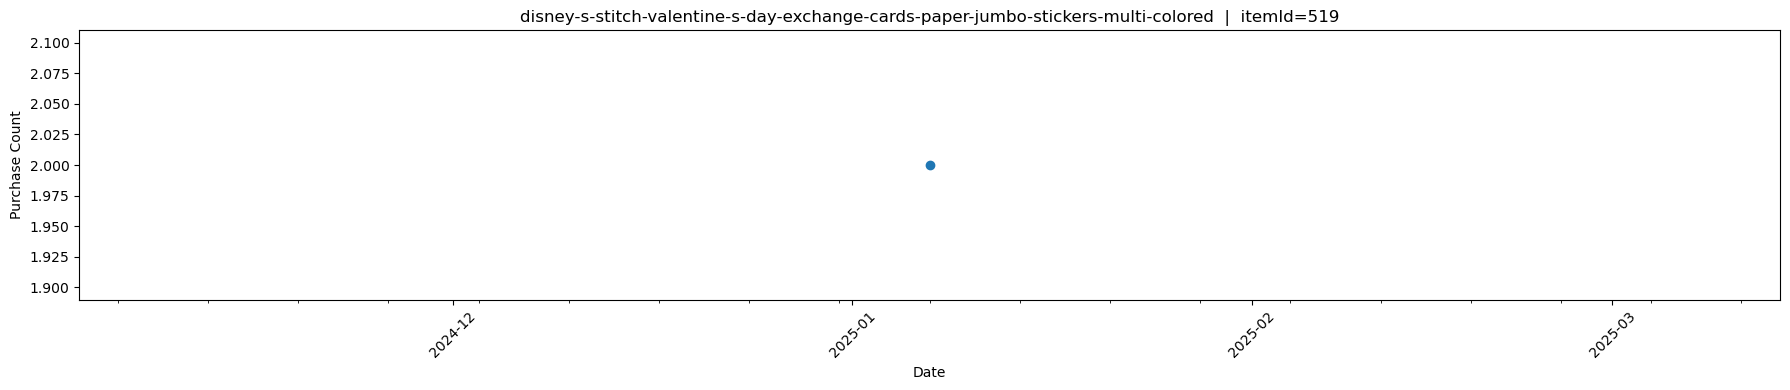

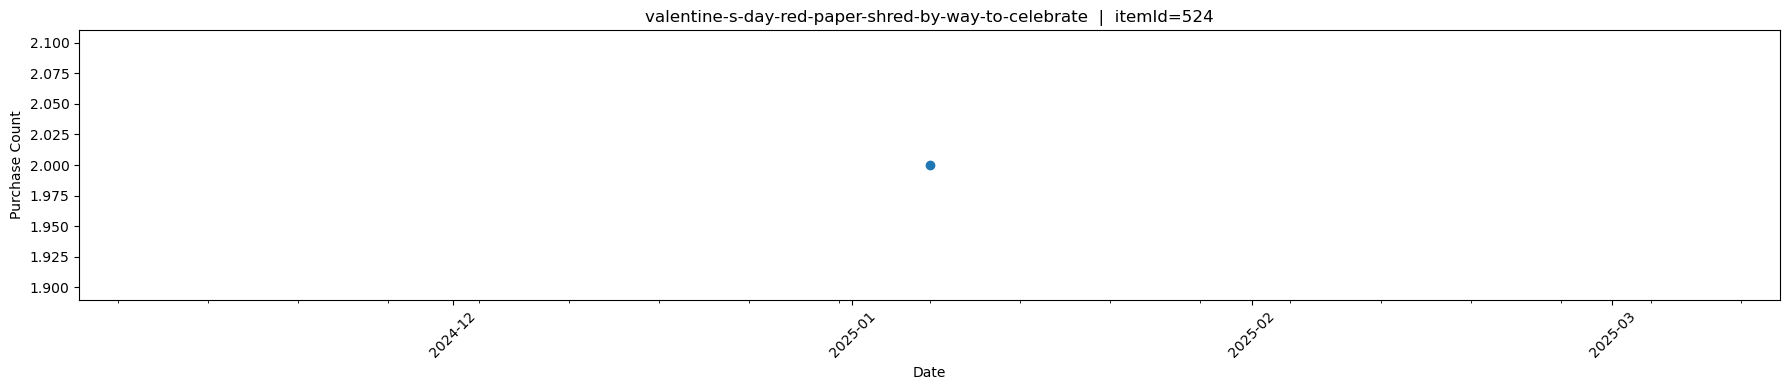

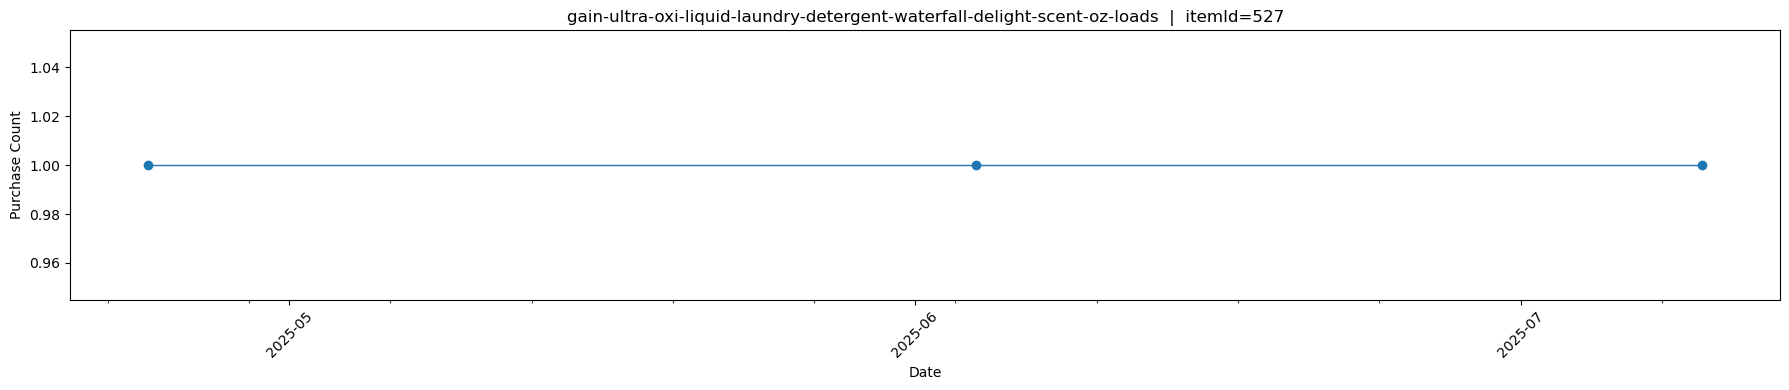

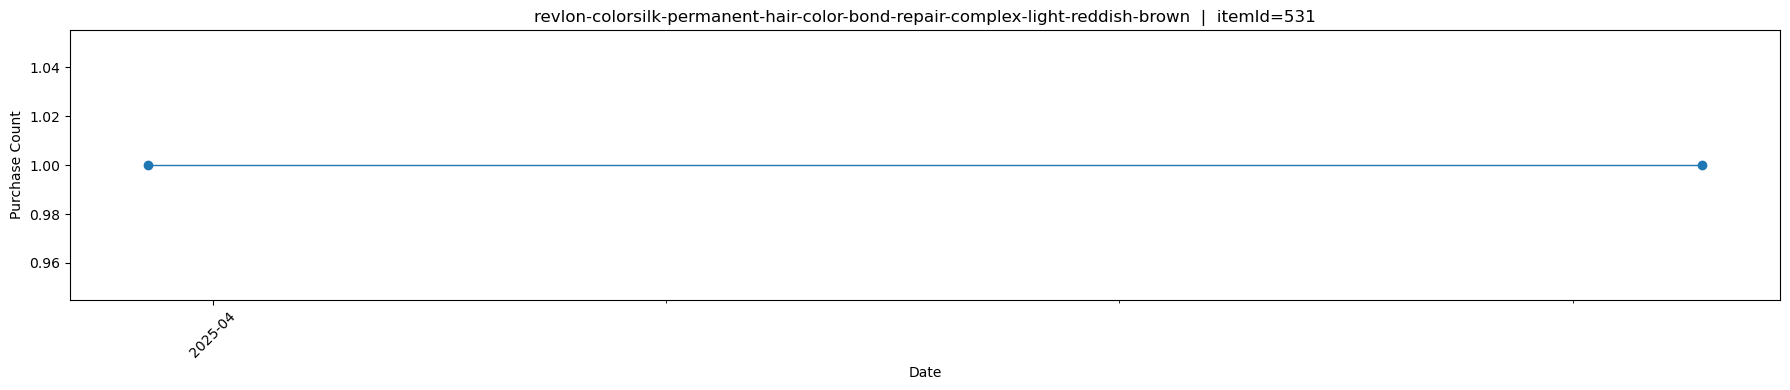

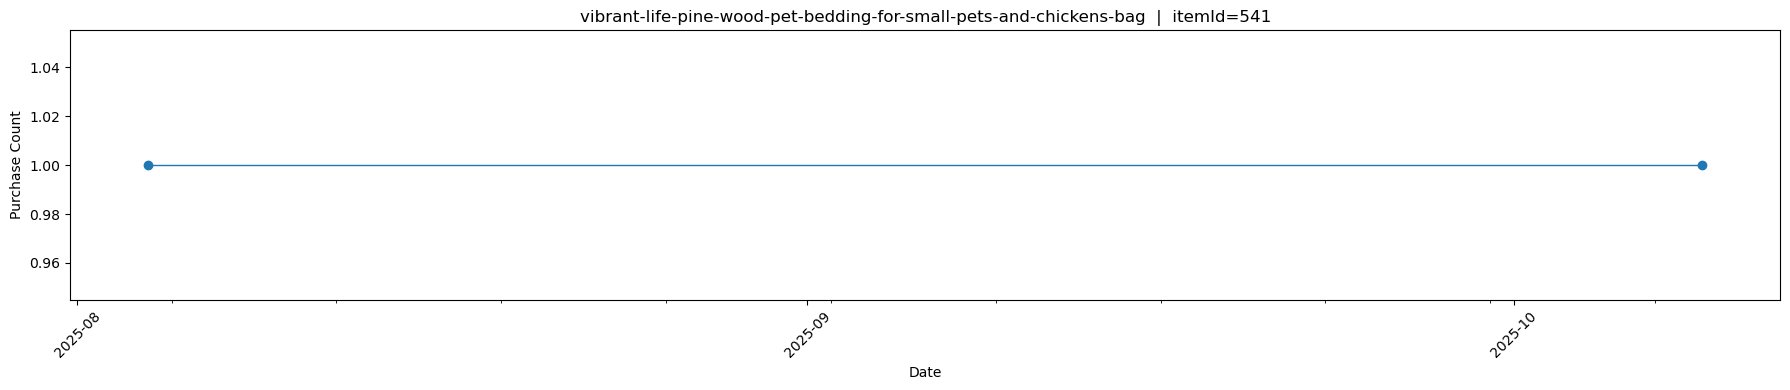

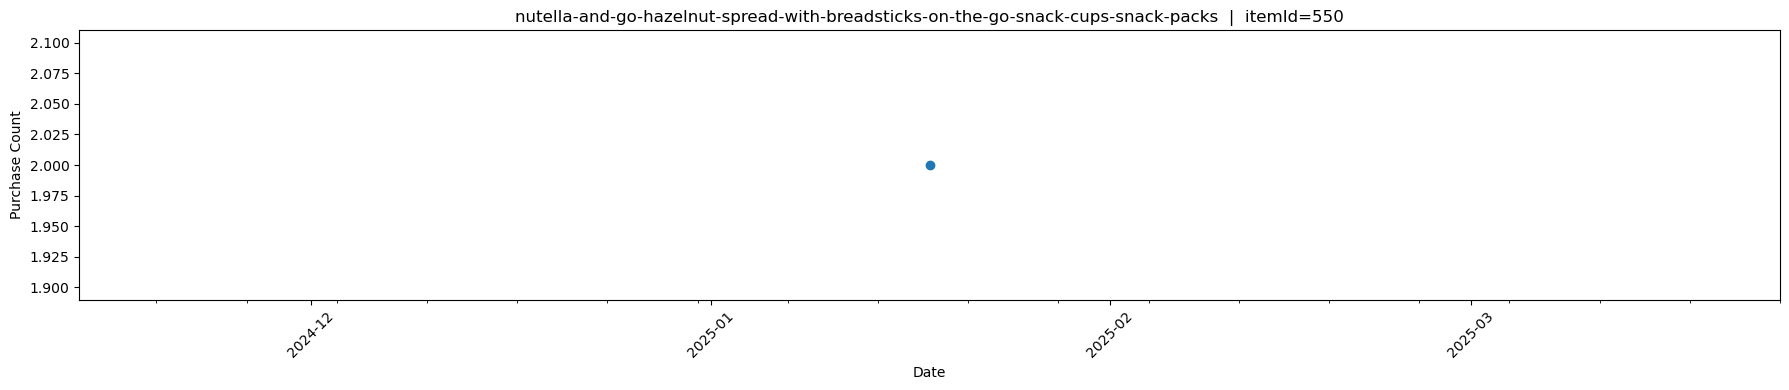

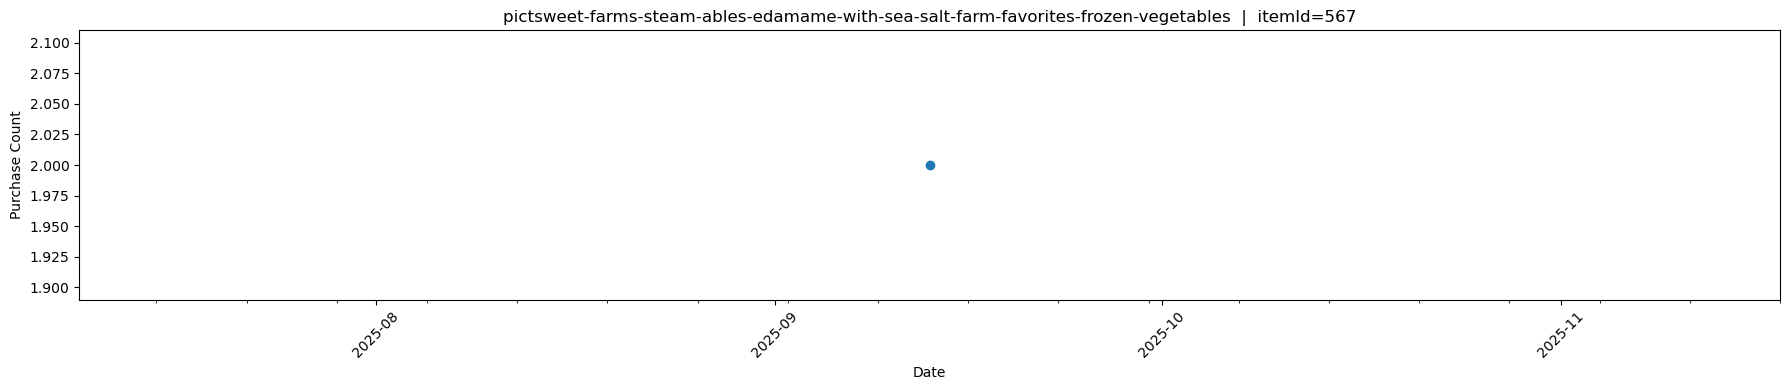

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\miniconda3\envs\grocery-ml-xgb\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\miniconda3\envs\grocery-ml-xgb\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\miniconda3\envs\grocery-ml-xgb\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\miniconda3\envs\grocery-ml-xgb\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

groceryML.training_df["date"] = pd.to_datetime(groceryML.training_df["date"])

df = groceryML.training_df[groceryML.training_df["didBuy_target"] == 1]

for itemId in df["itemId"].unique():
    df_item = df[df["itemId"] == itemId]
    itemName = df_item["item"].iloc[0]

    daily_counts = (
        df_item
        .groupby("date")
        .size()
        .sort_index()
    )

    plt.figure(figsize=(18, 4))
    plt.plot(daily_counts.index, daily_counts.values, marker="o", linewidth=1)
    plt.title(f"{itemName}  |  itemId={itemId}")
    plt.xlabel("Date")
    plt.ylabel("Purchase Count")

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()


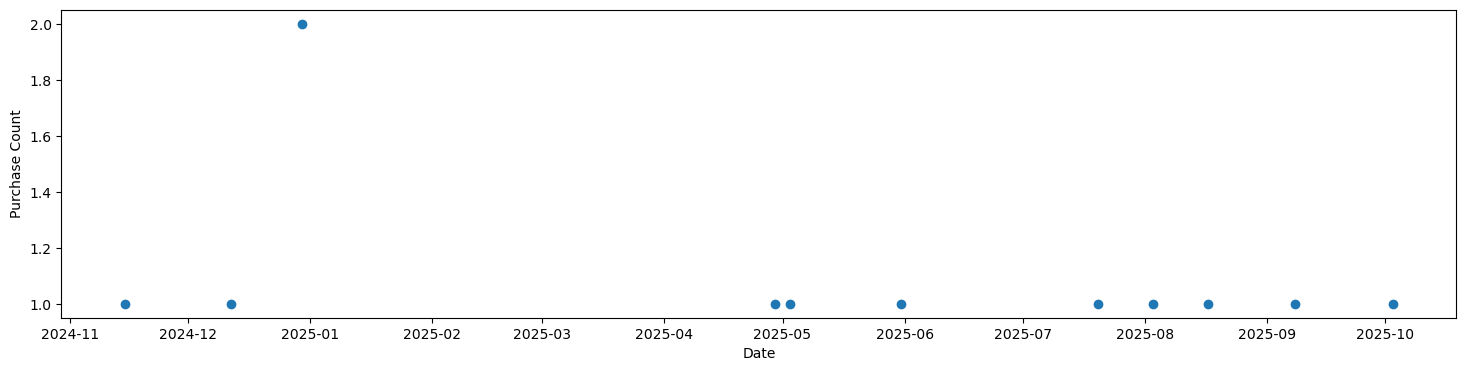

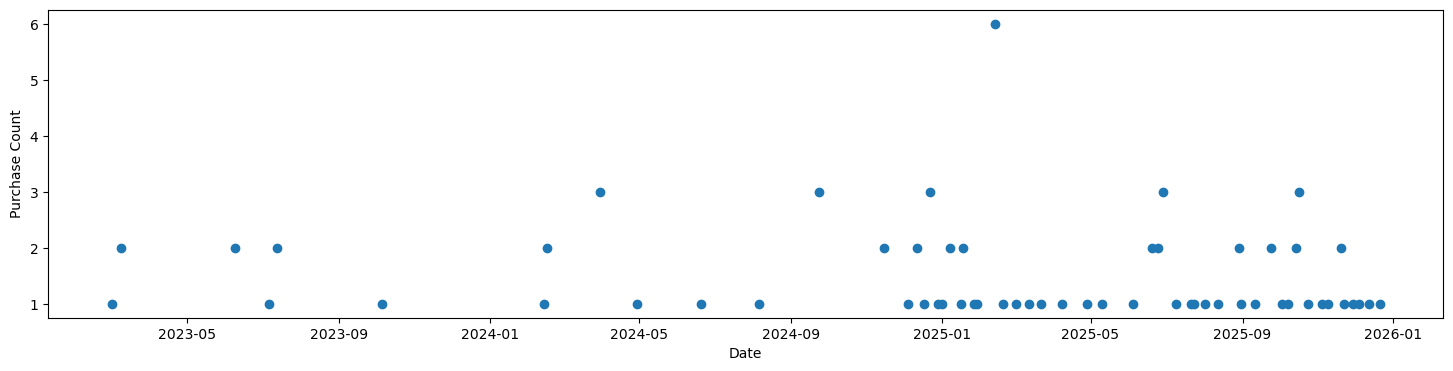

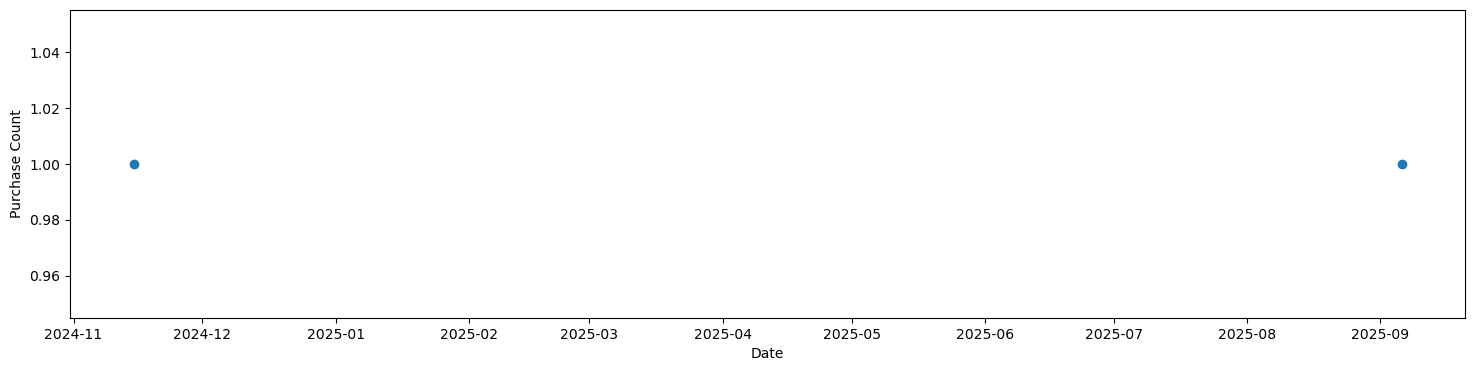

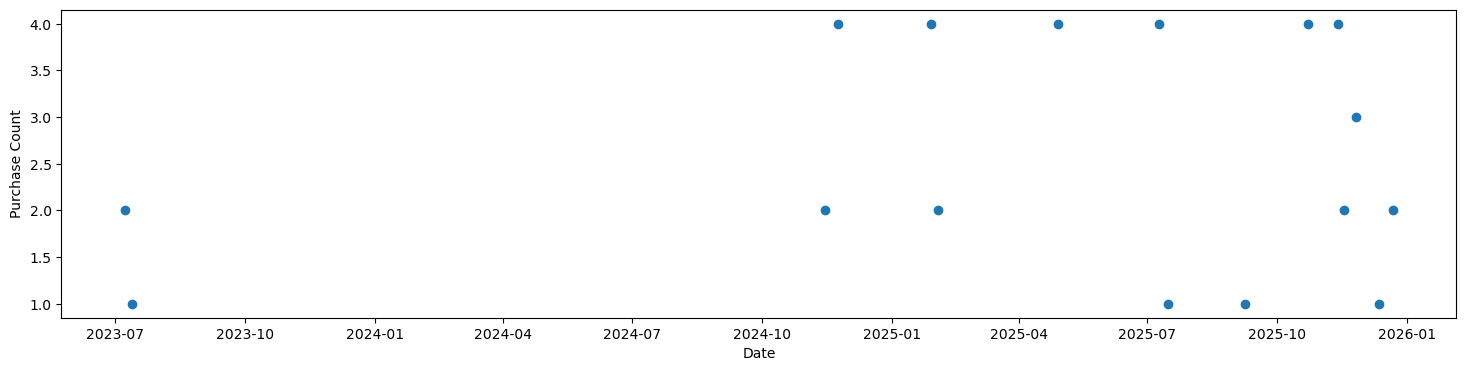

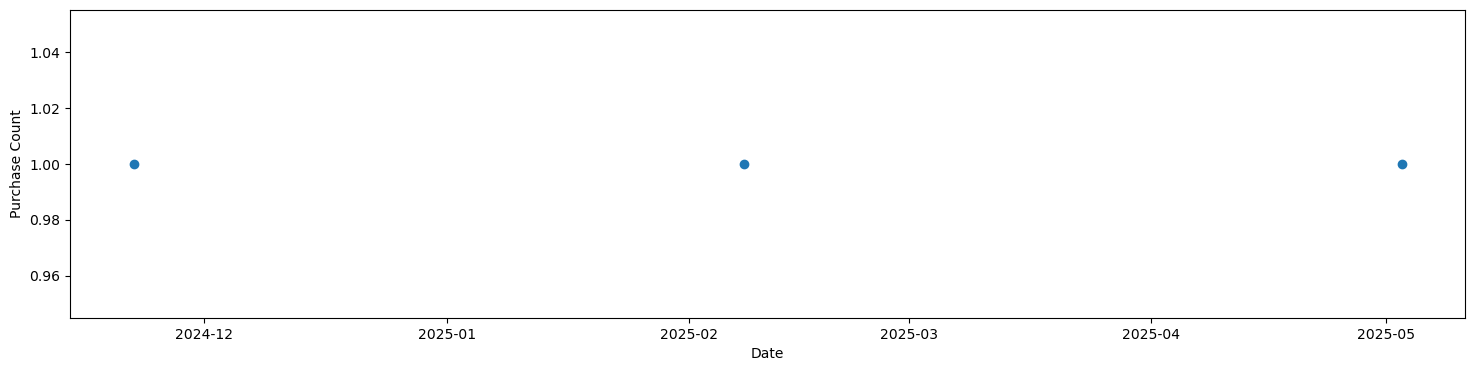

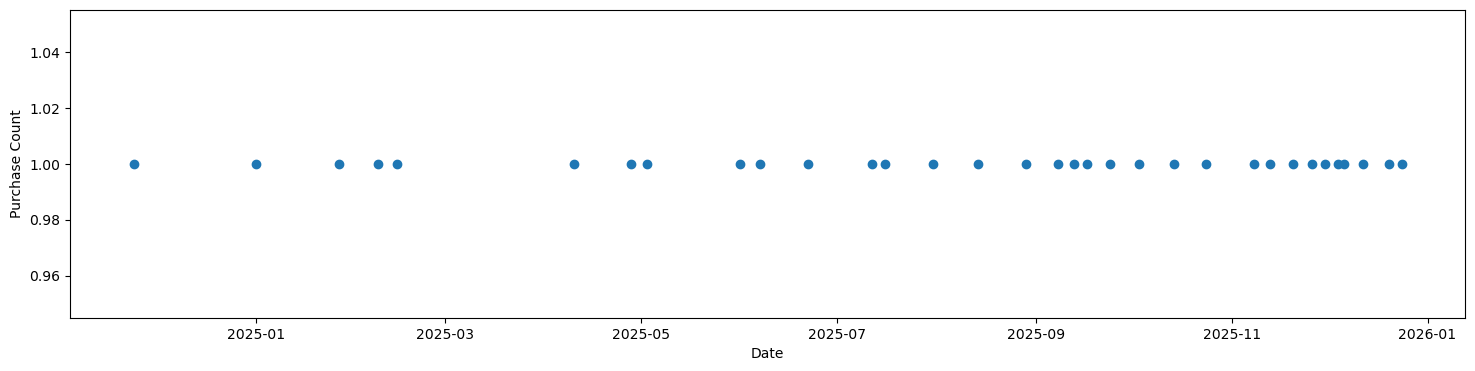

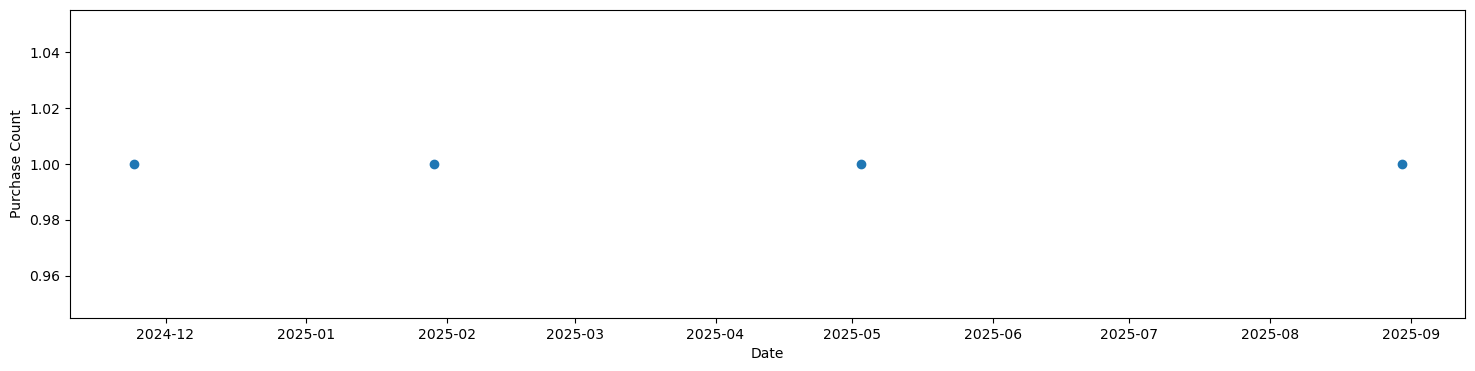

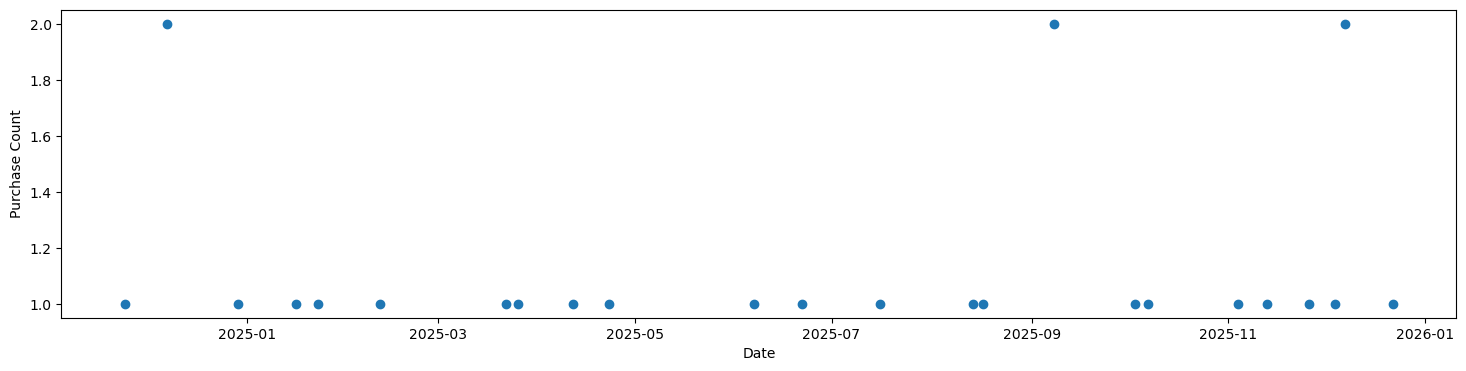

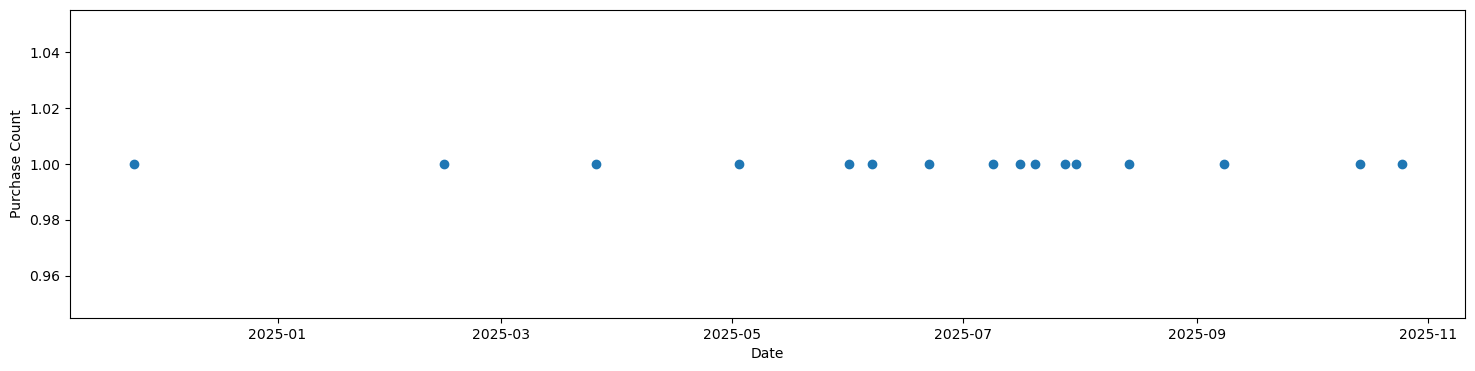

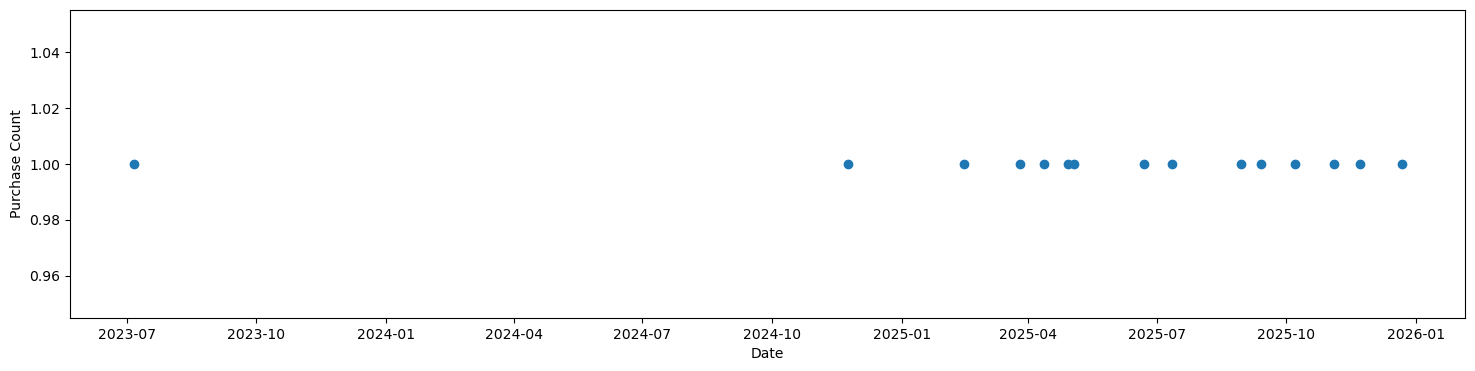

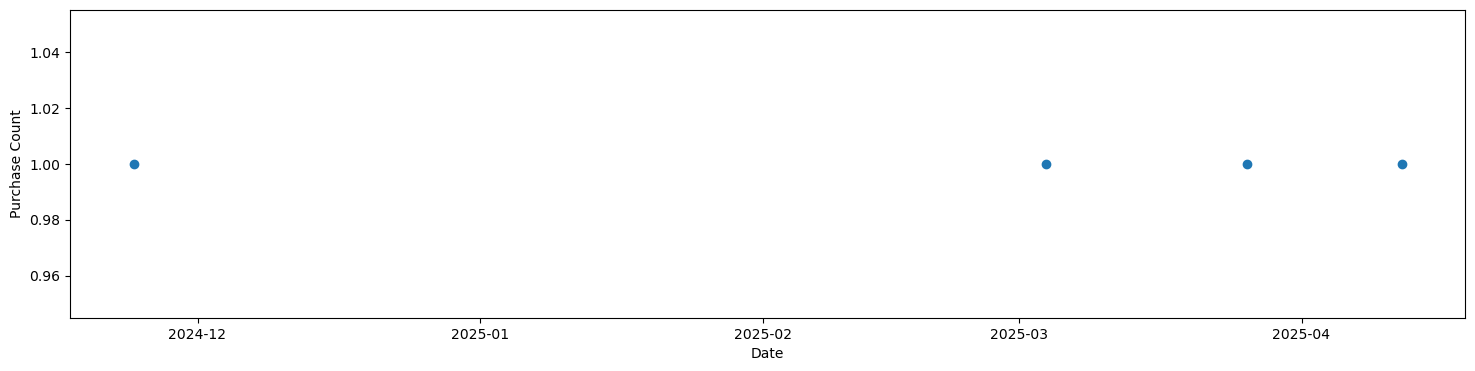

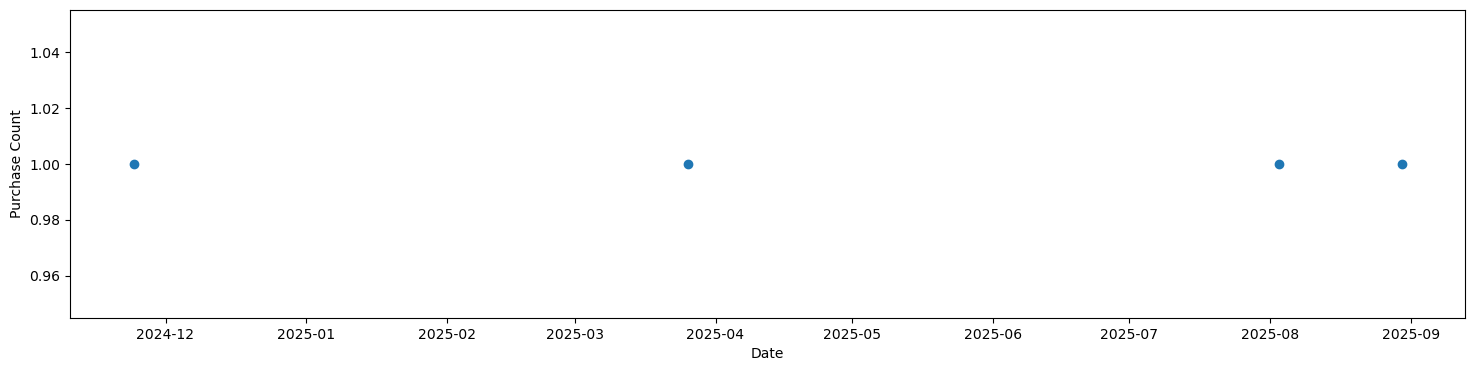

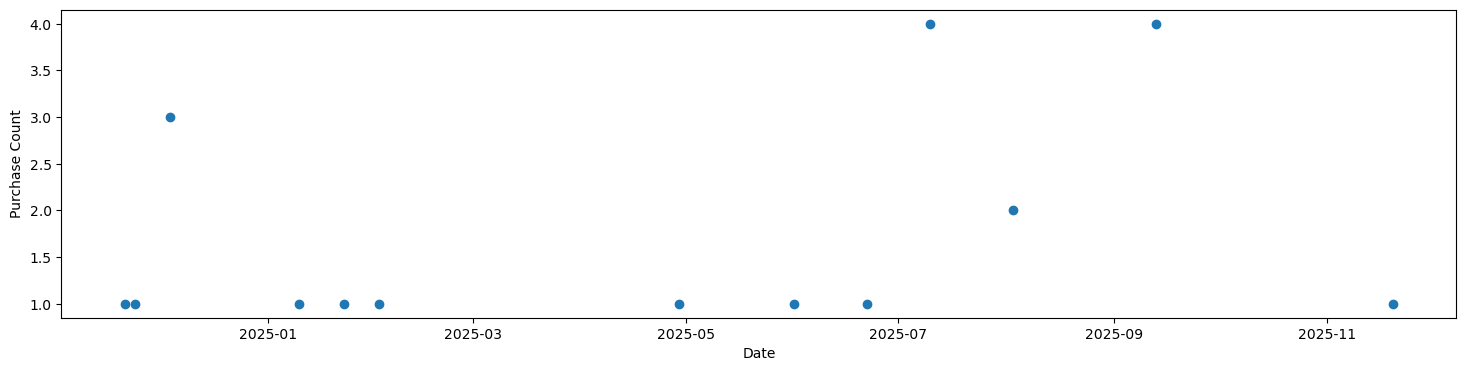

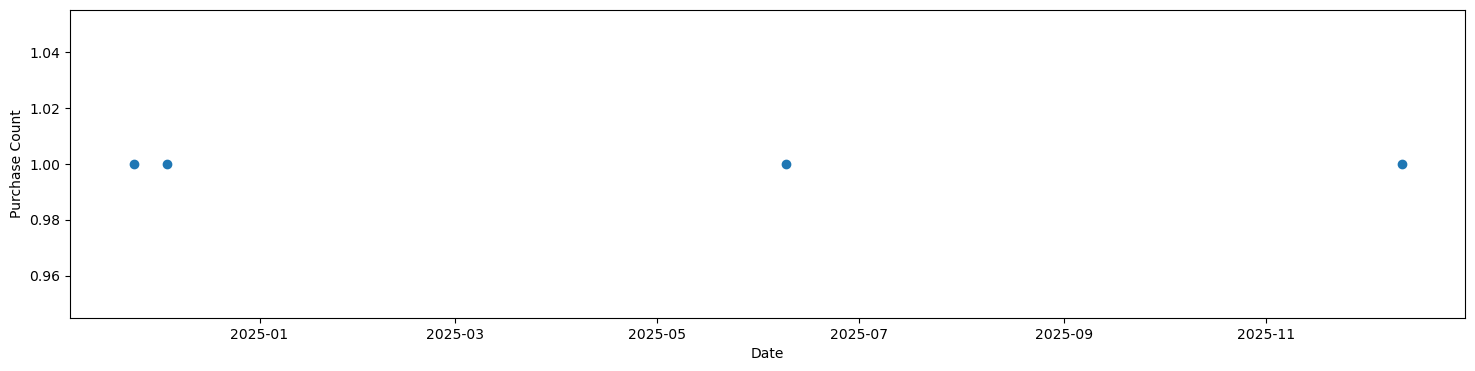

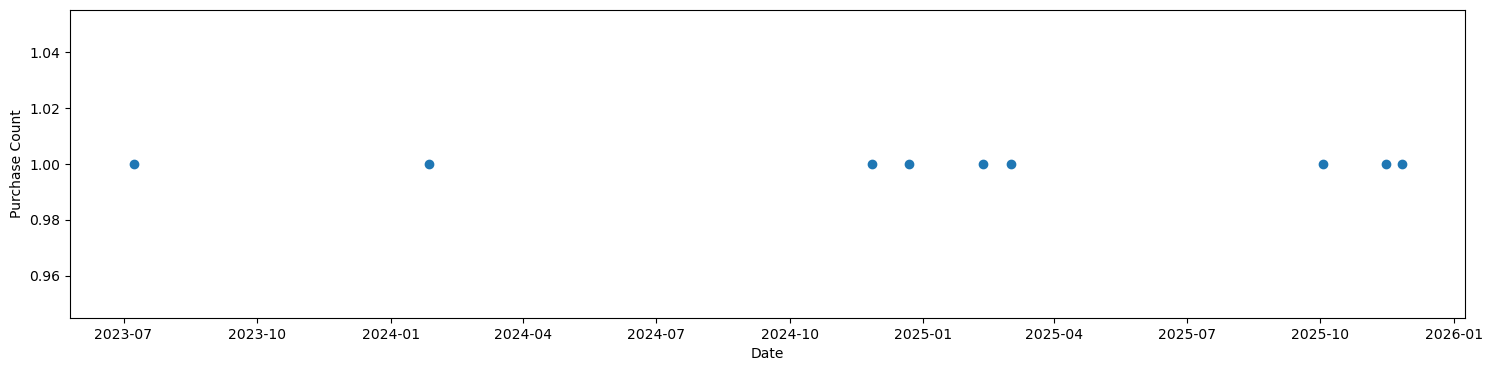

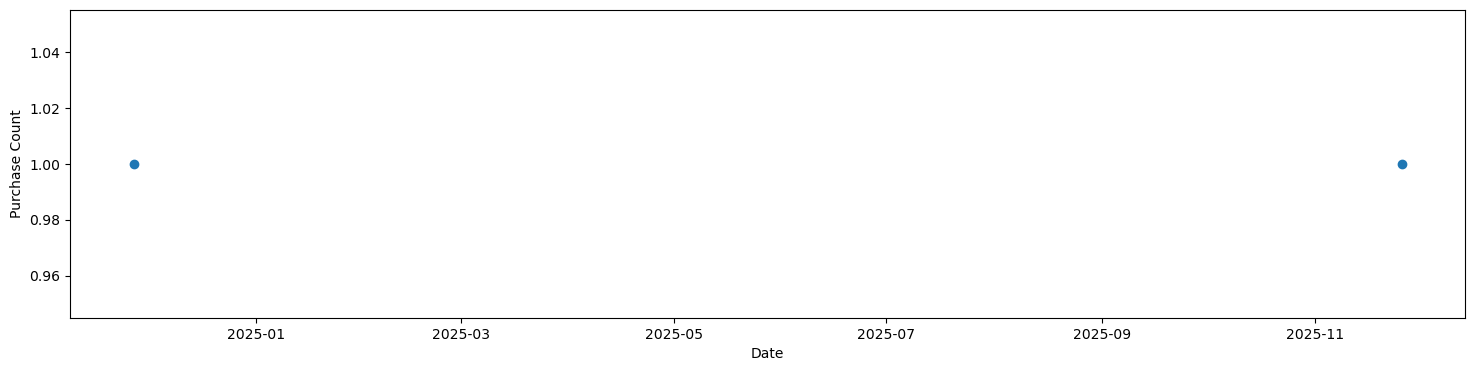

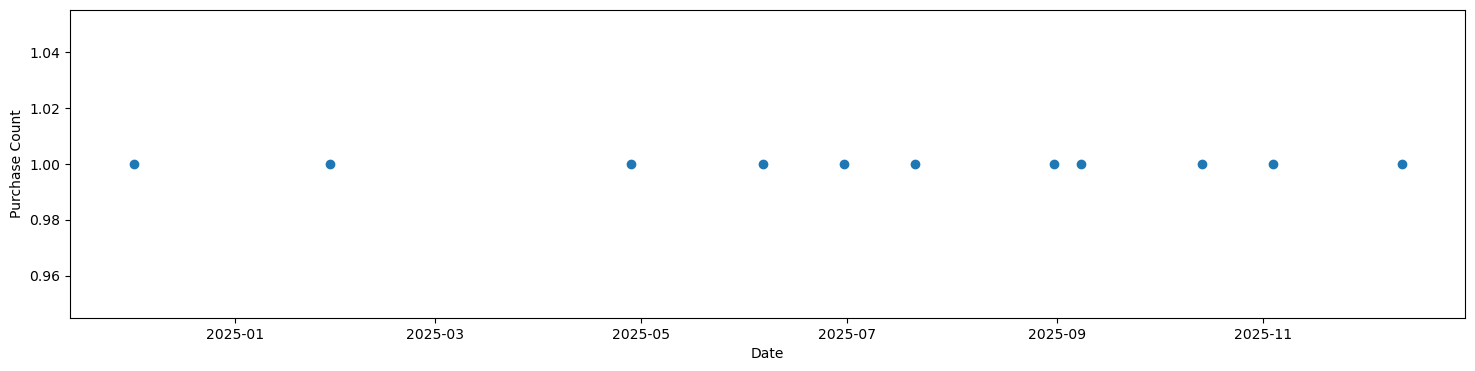

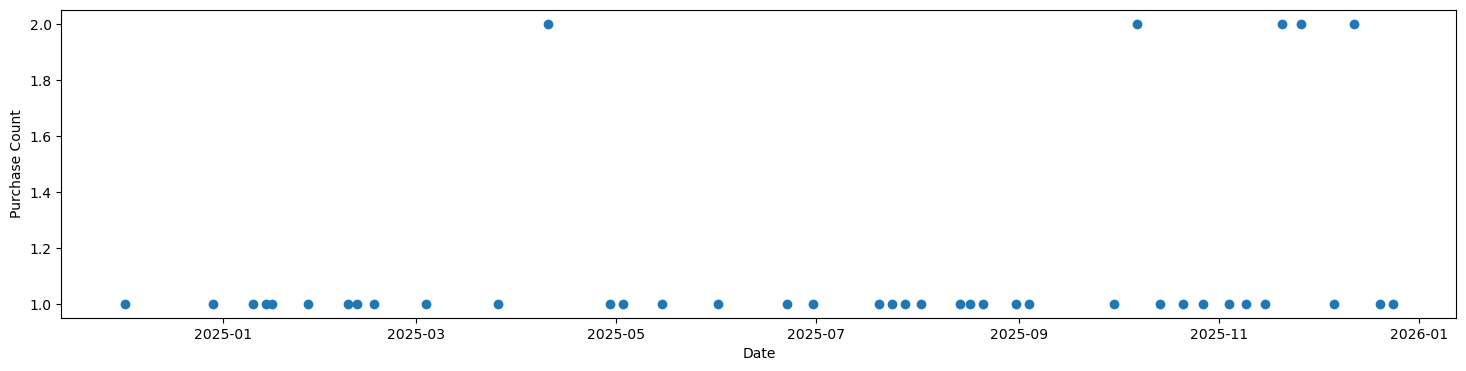

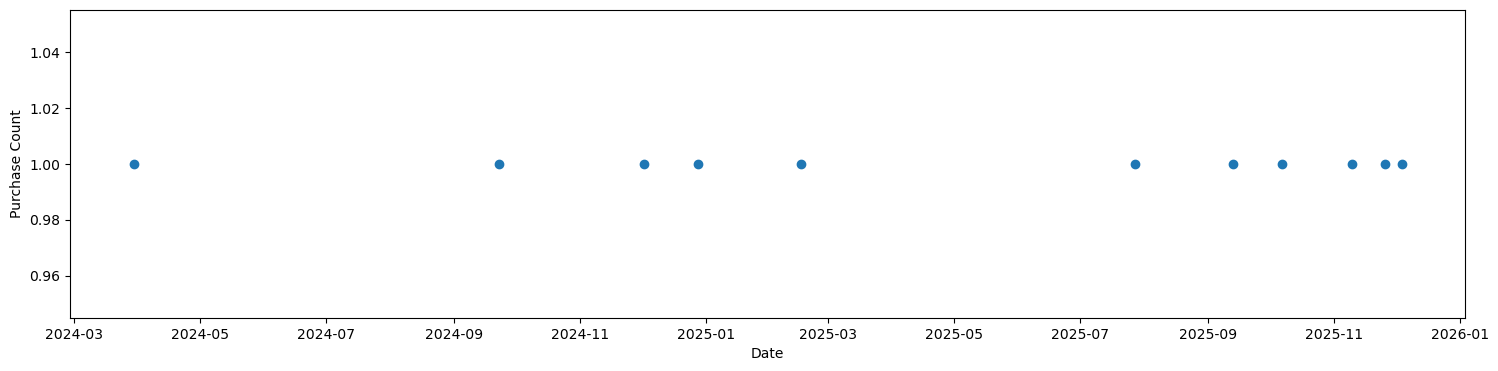

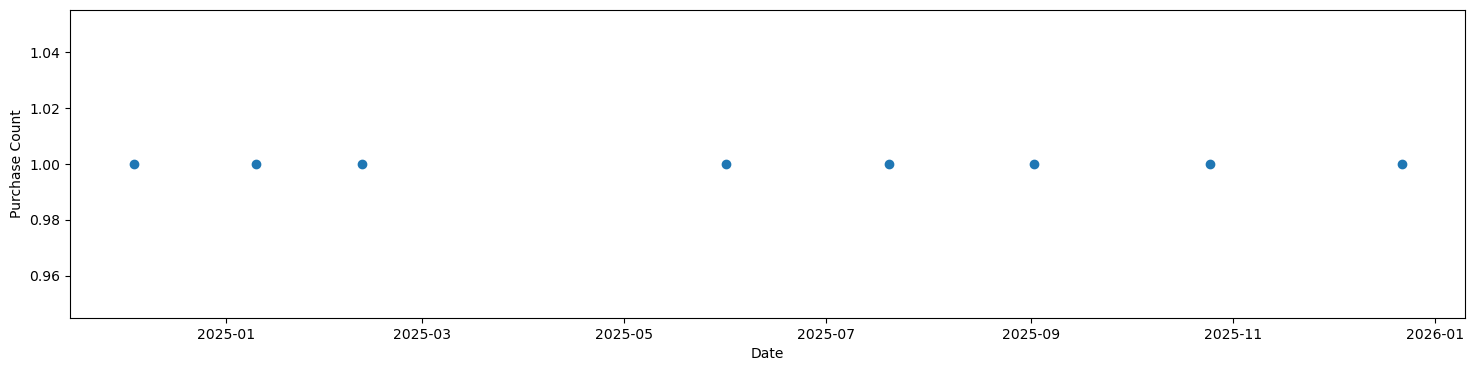

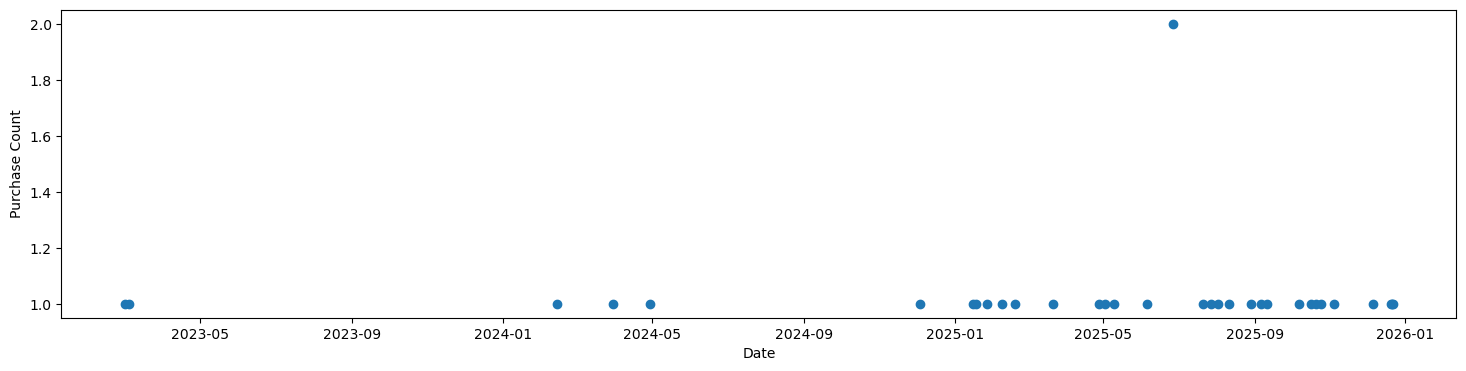

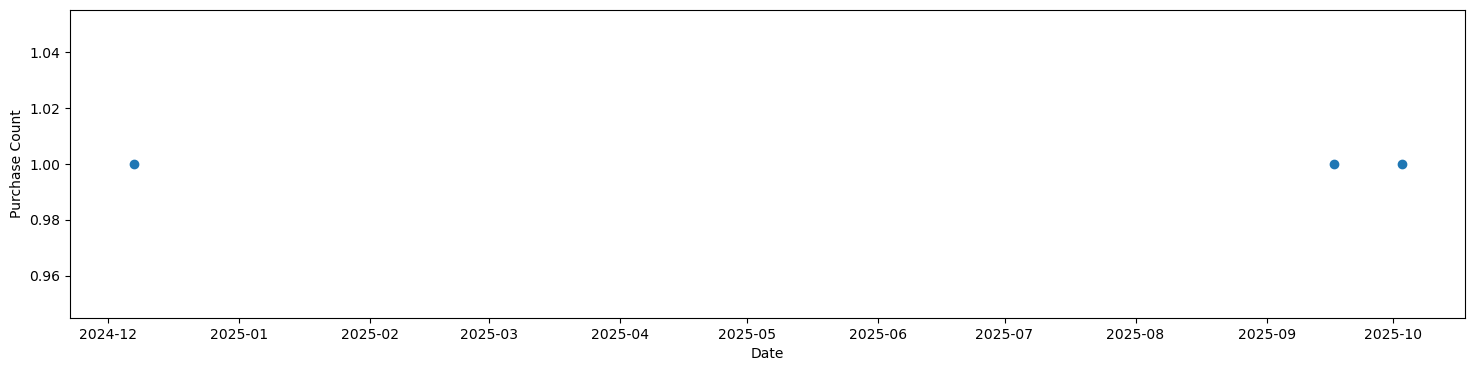

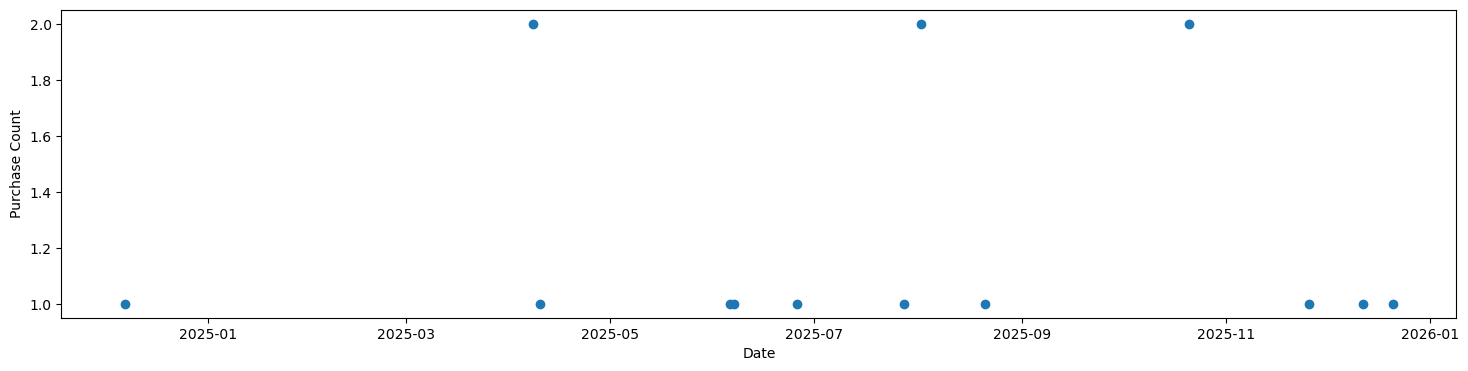

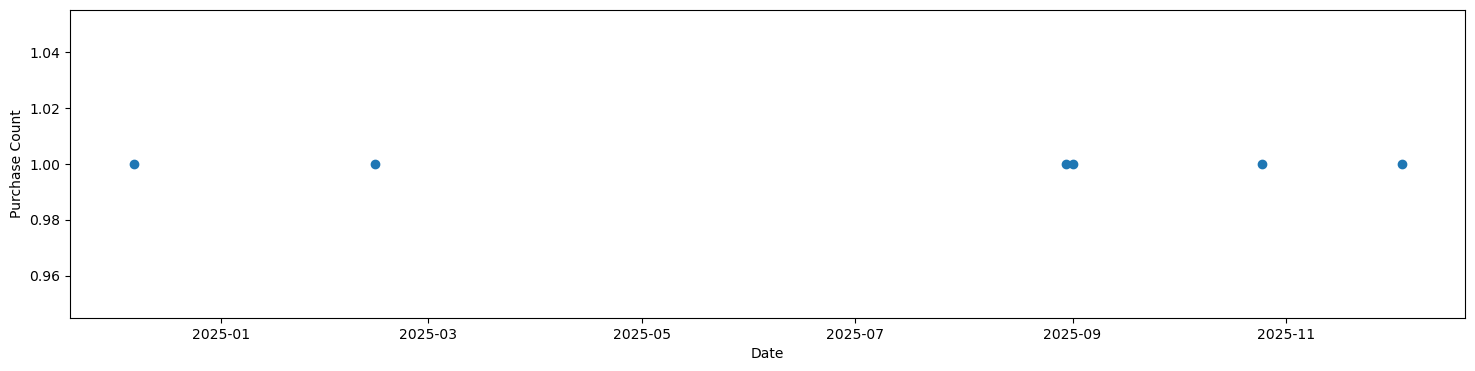

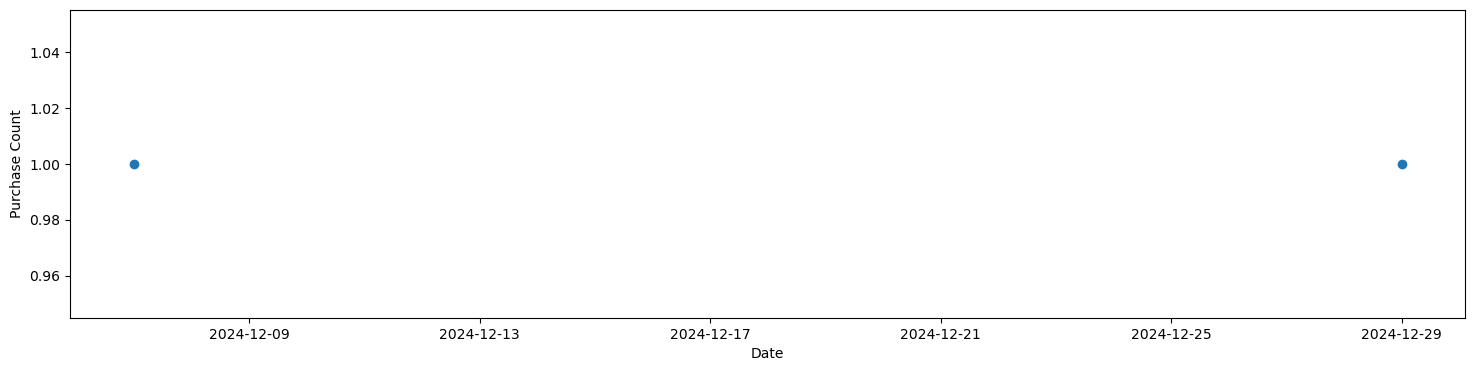

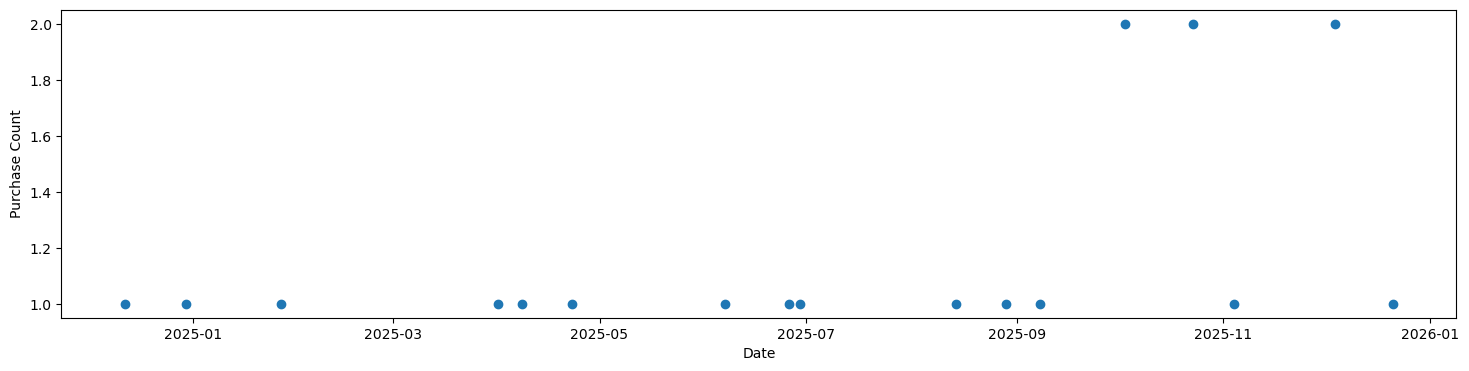

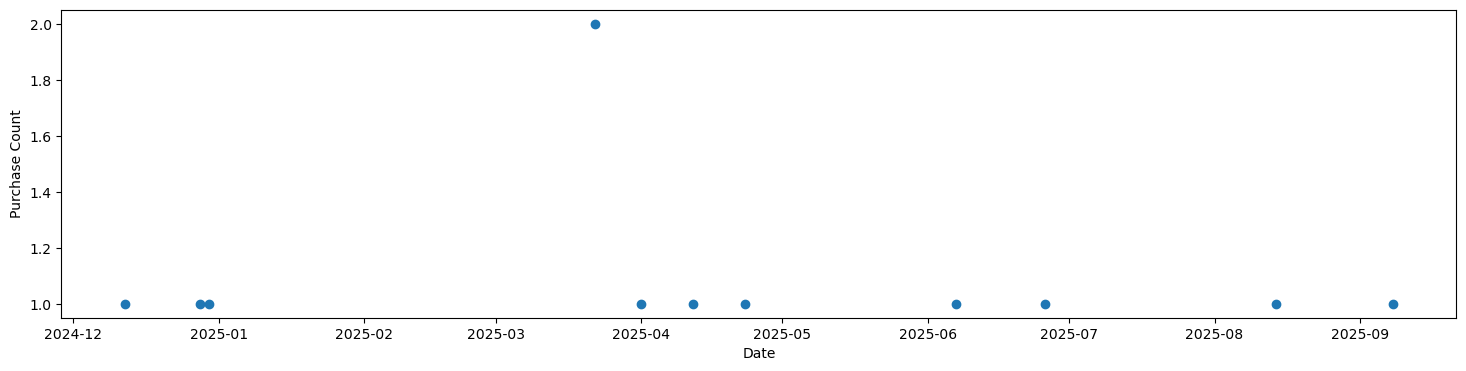

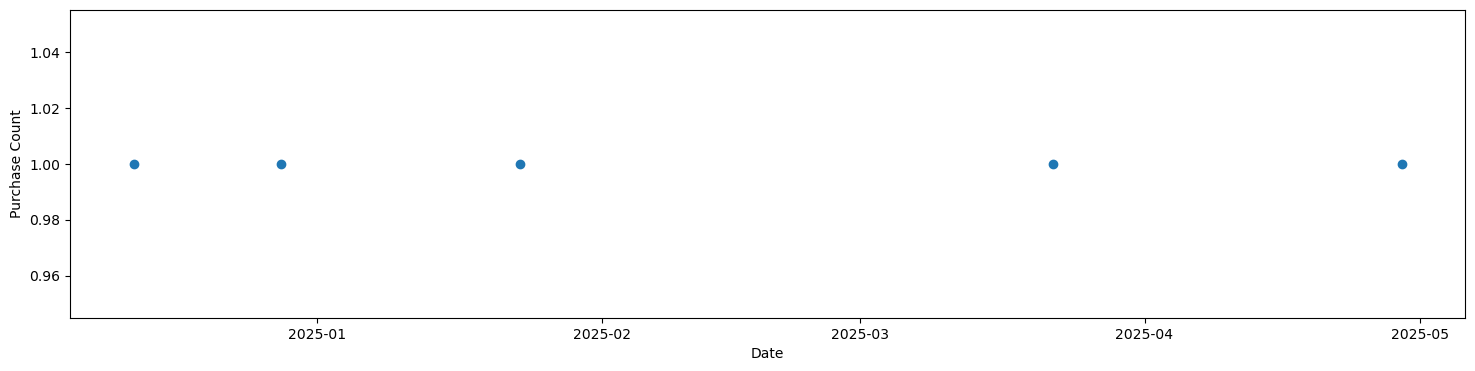

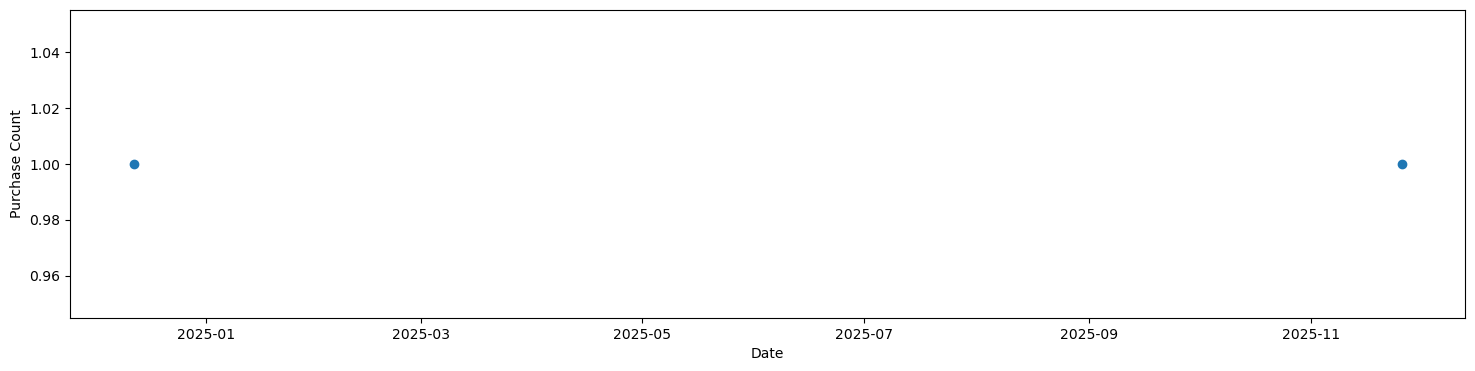

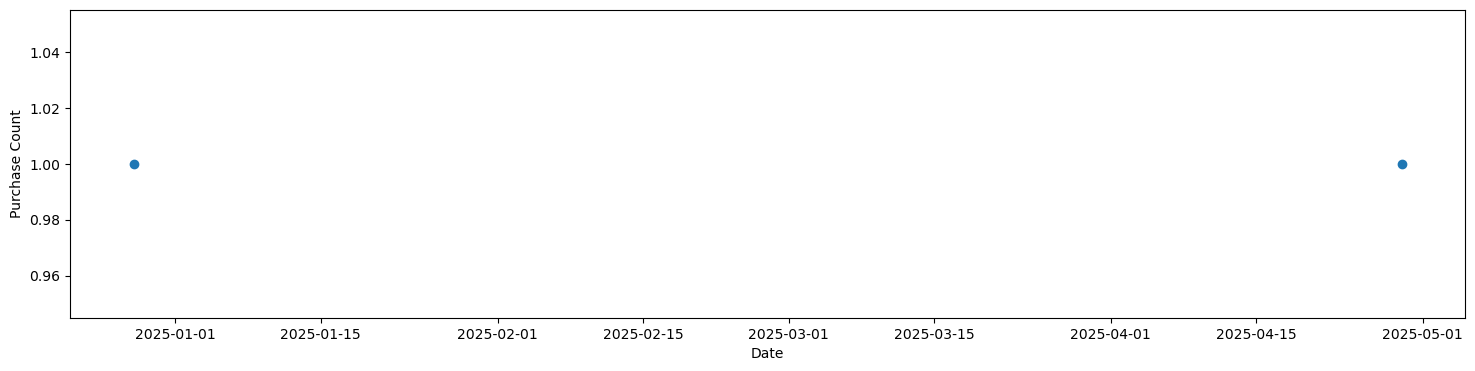

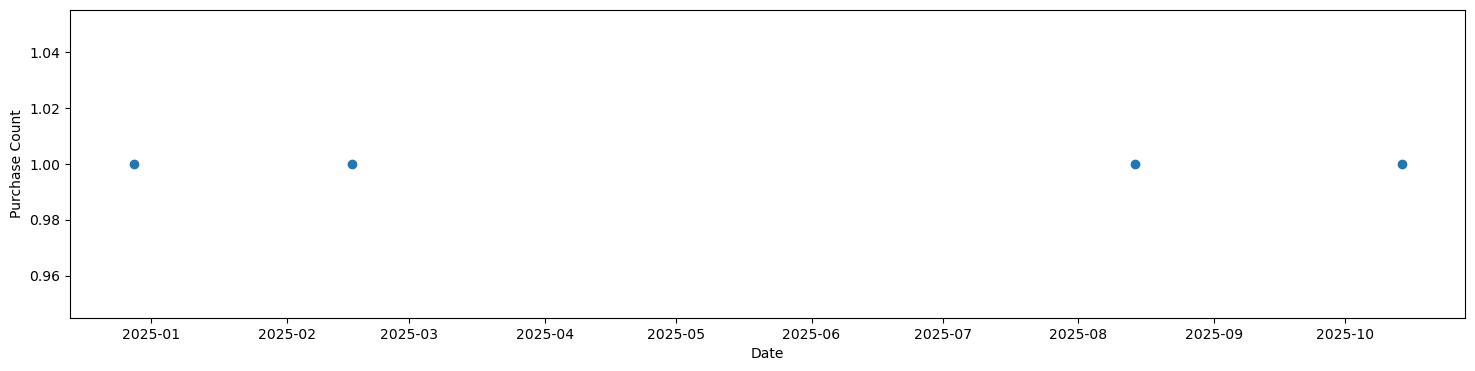

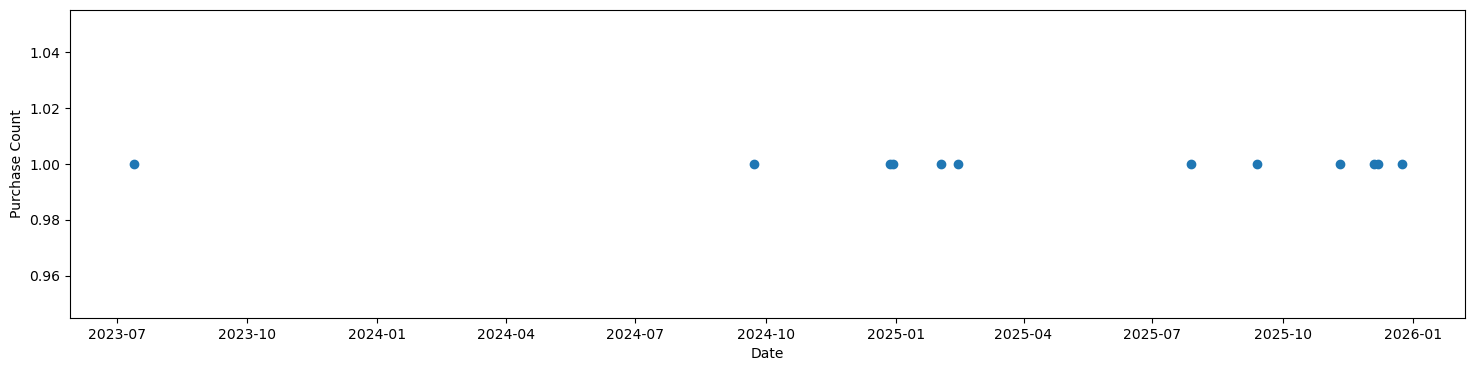

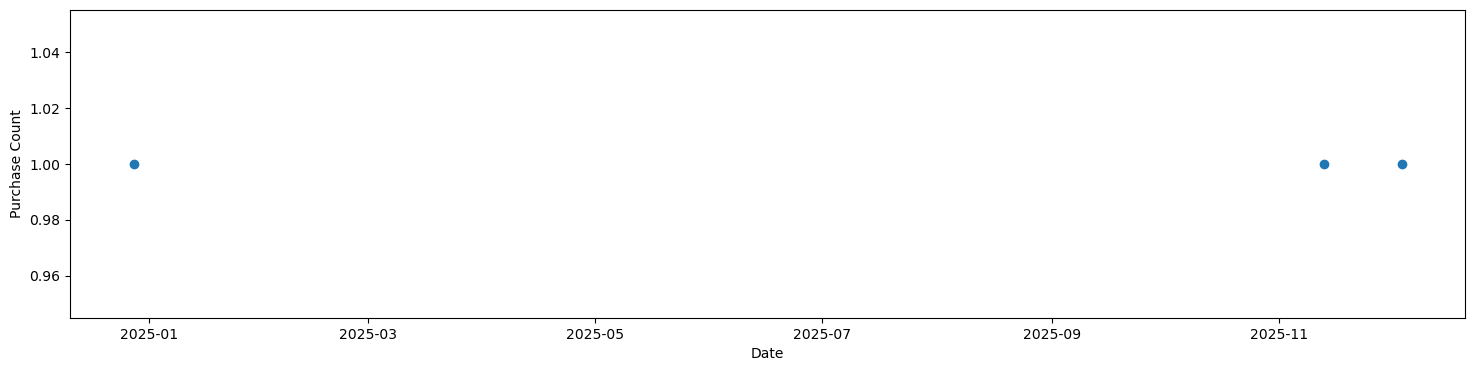

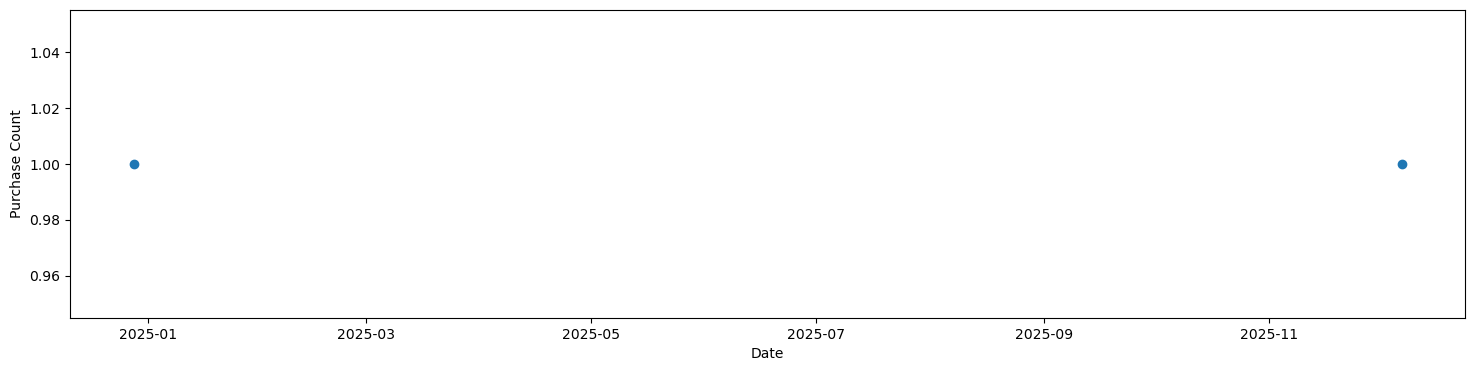

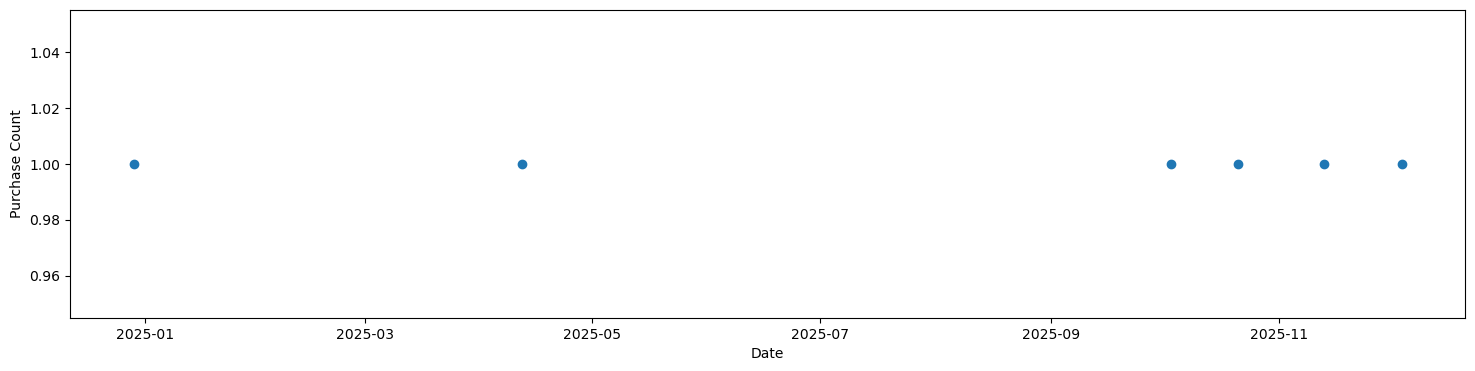

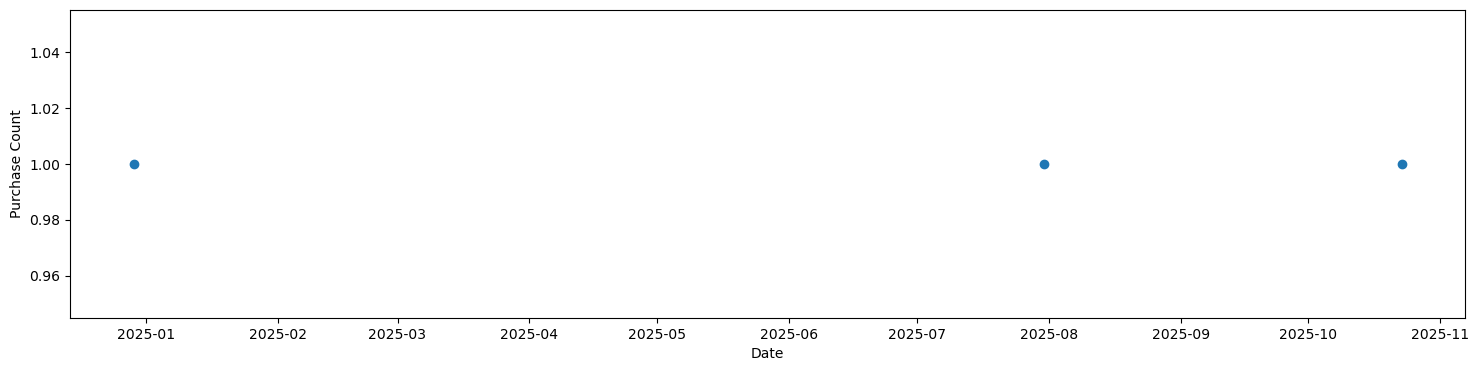

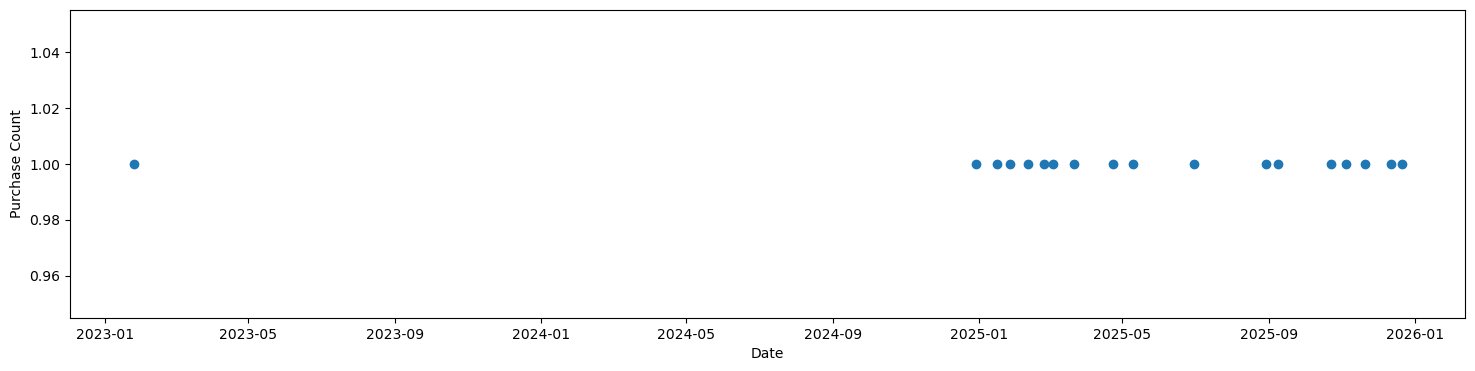

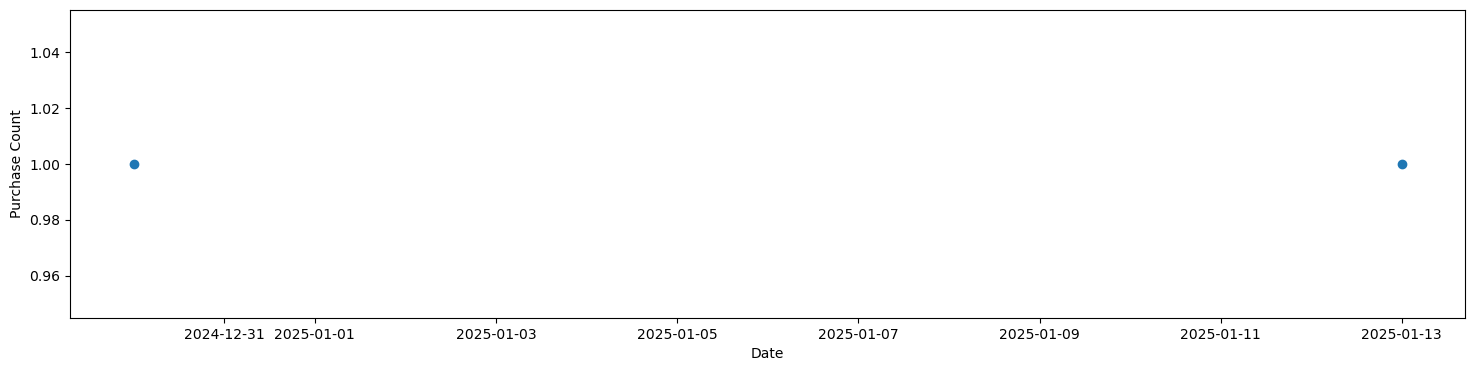

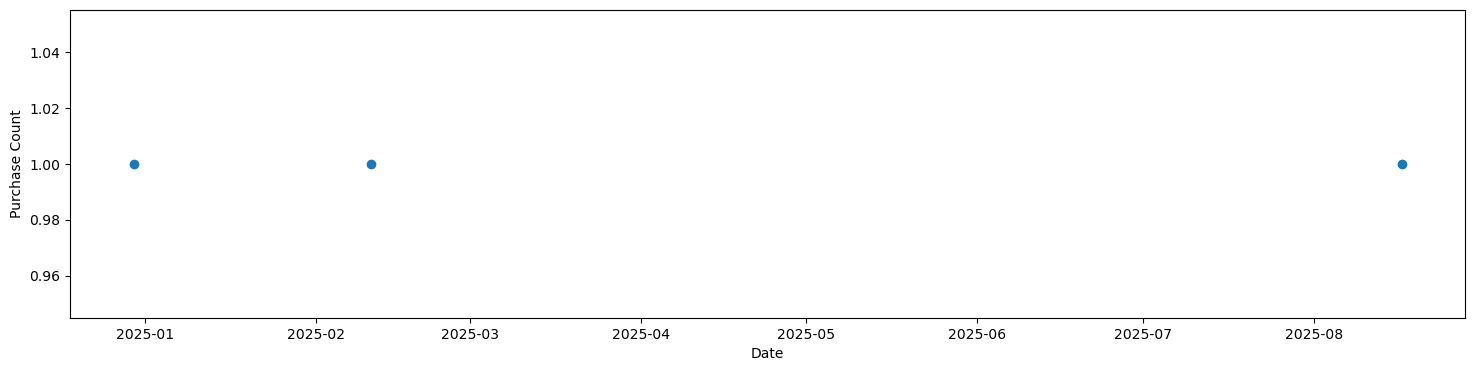

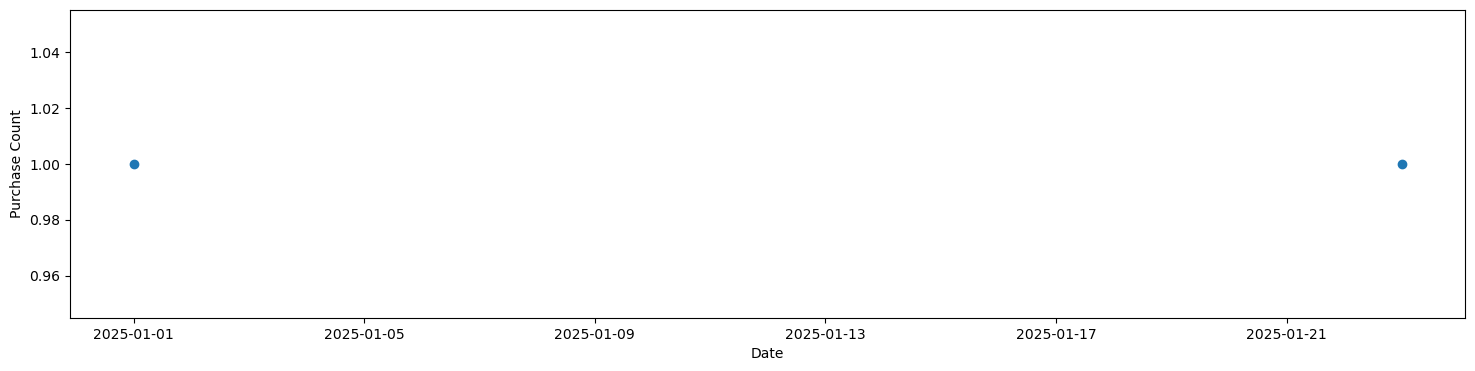

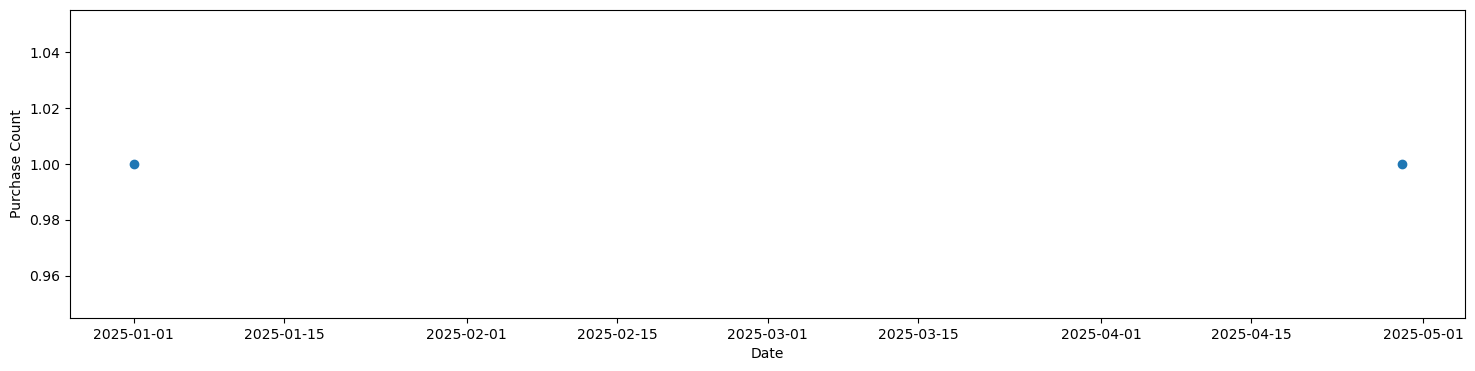

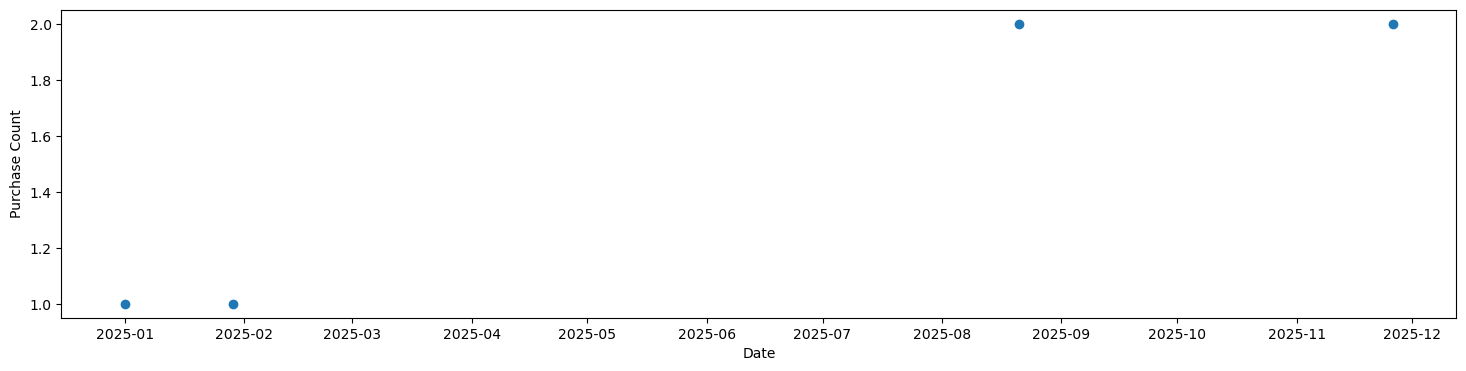

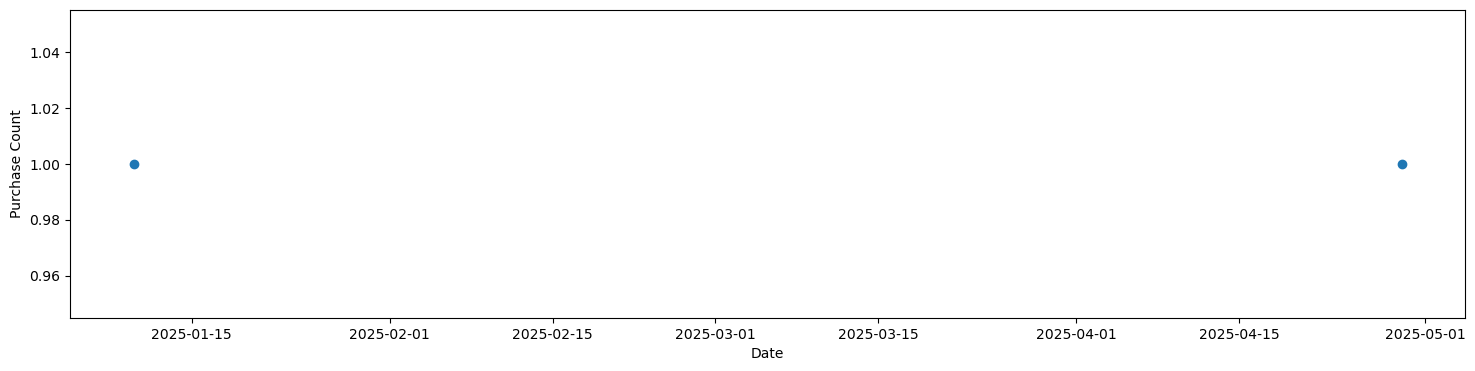

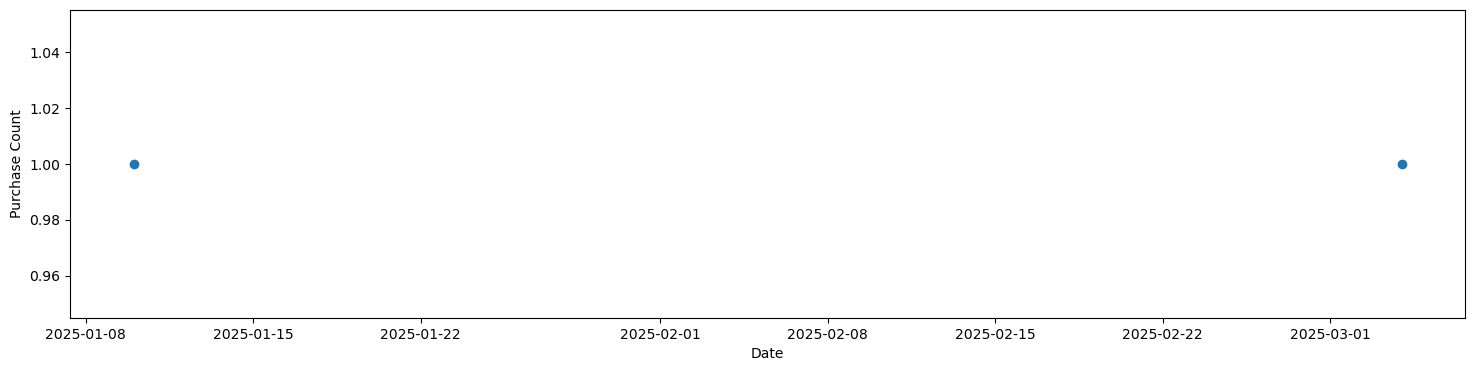

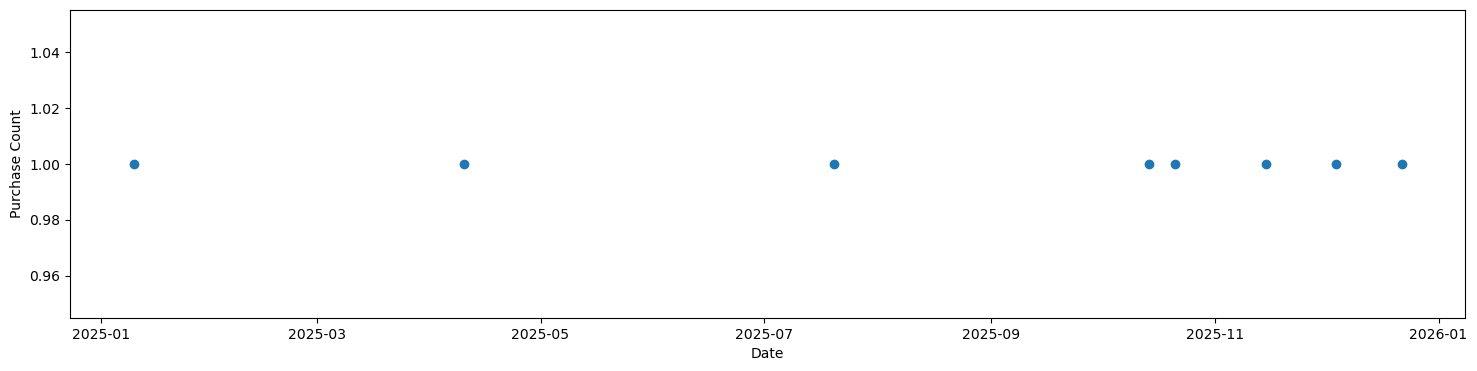

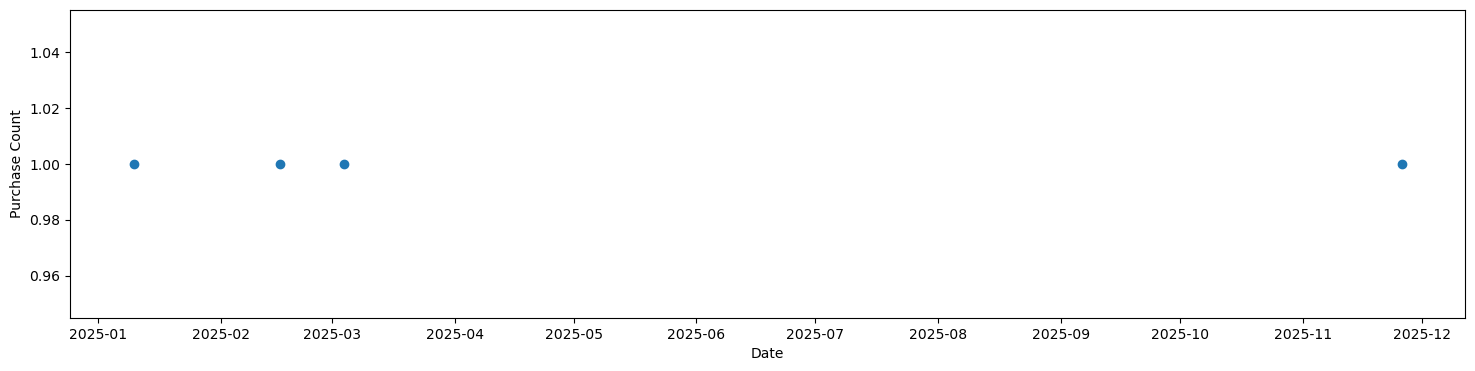

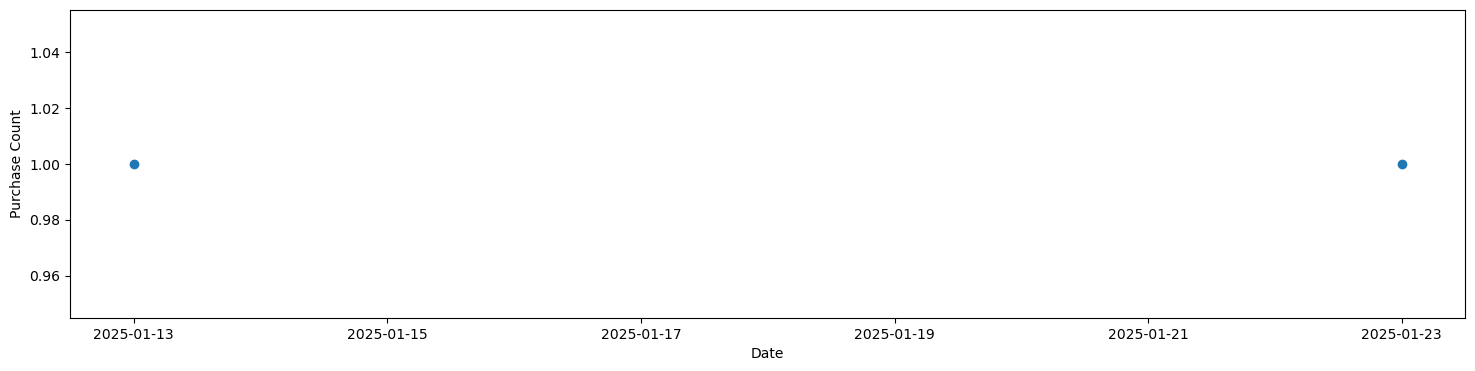

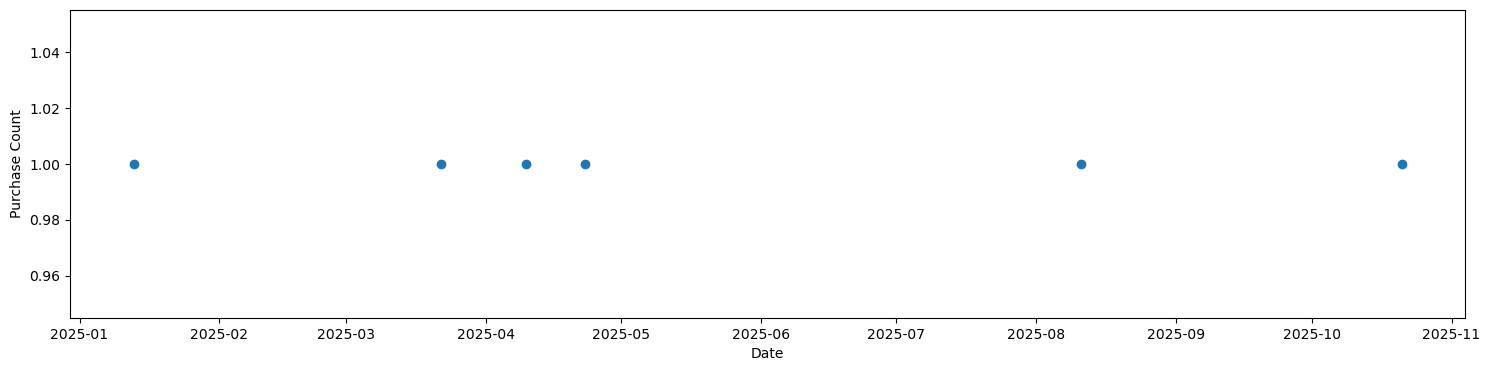

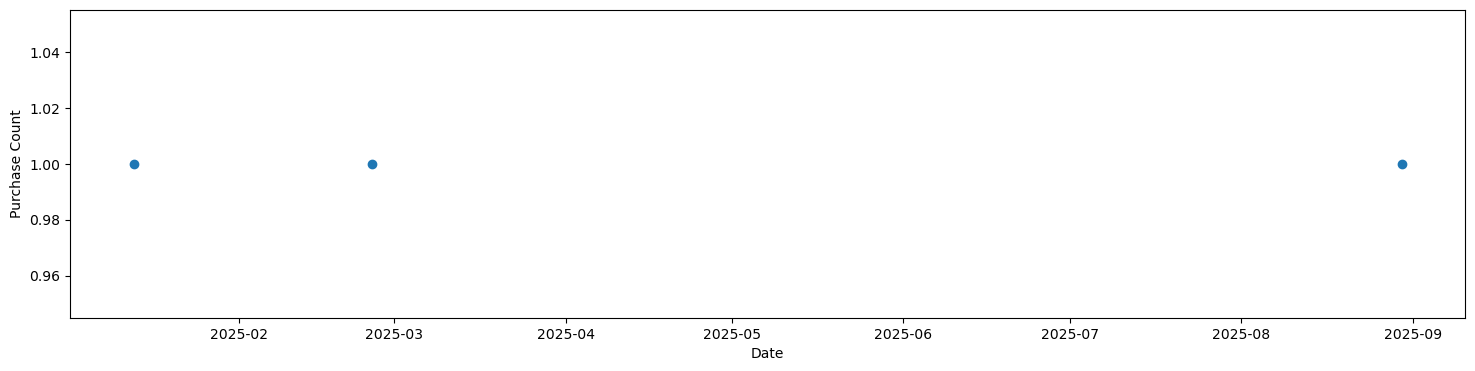

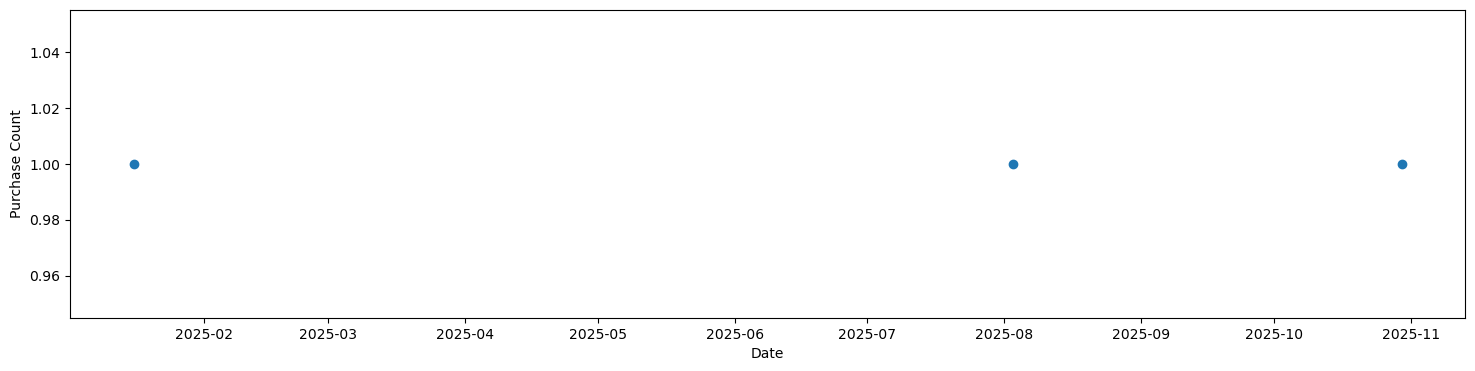

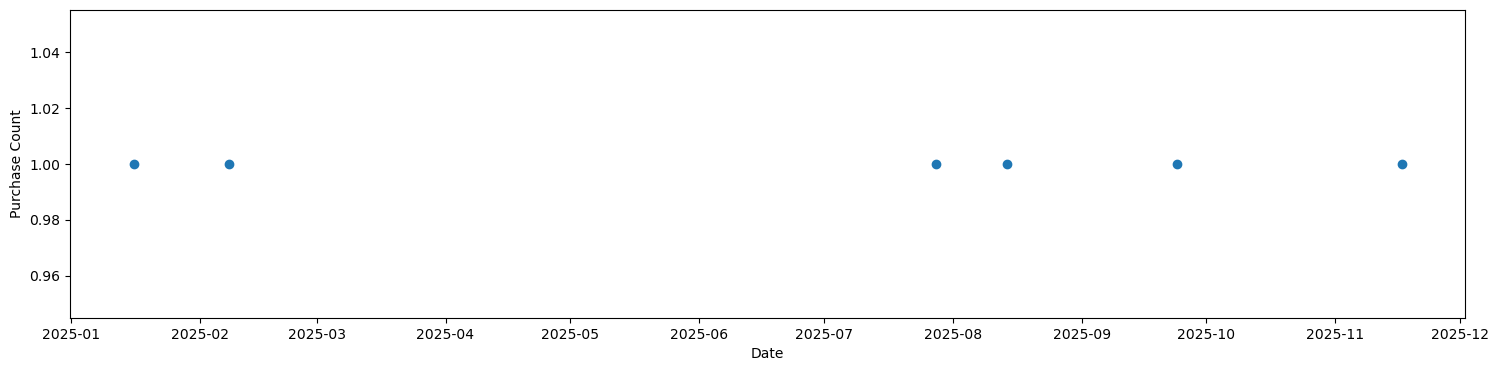

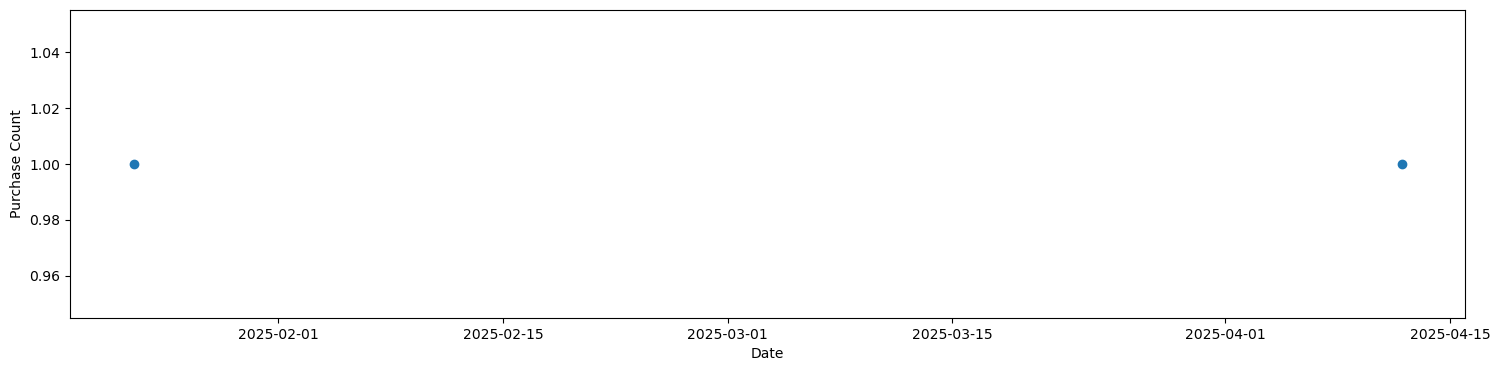

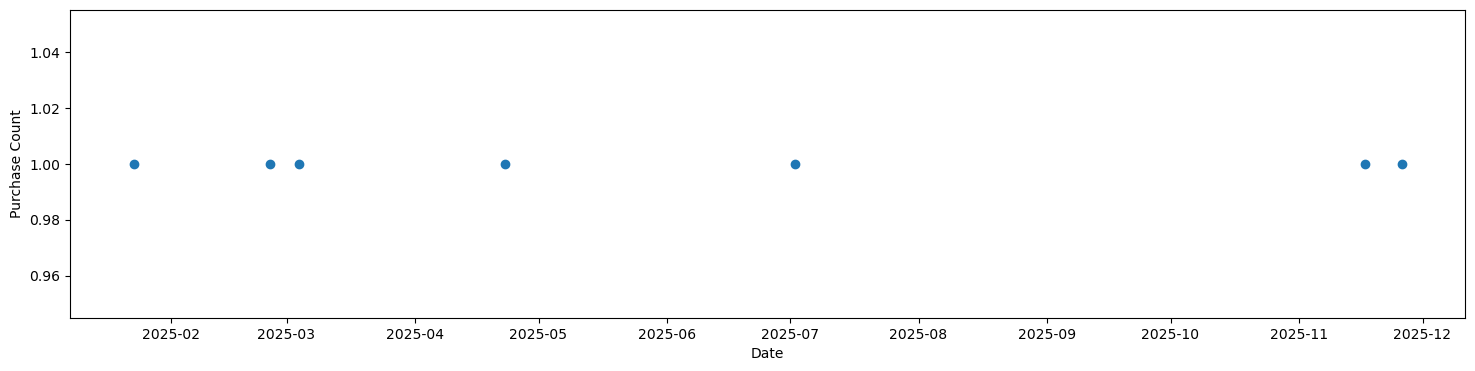

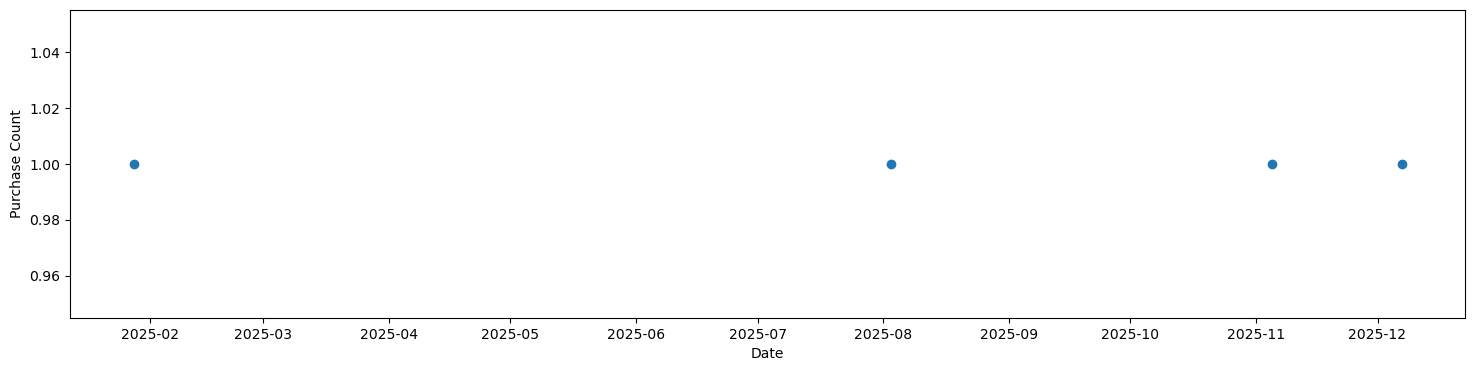

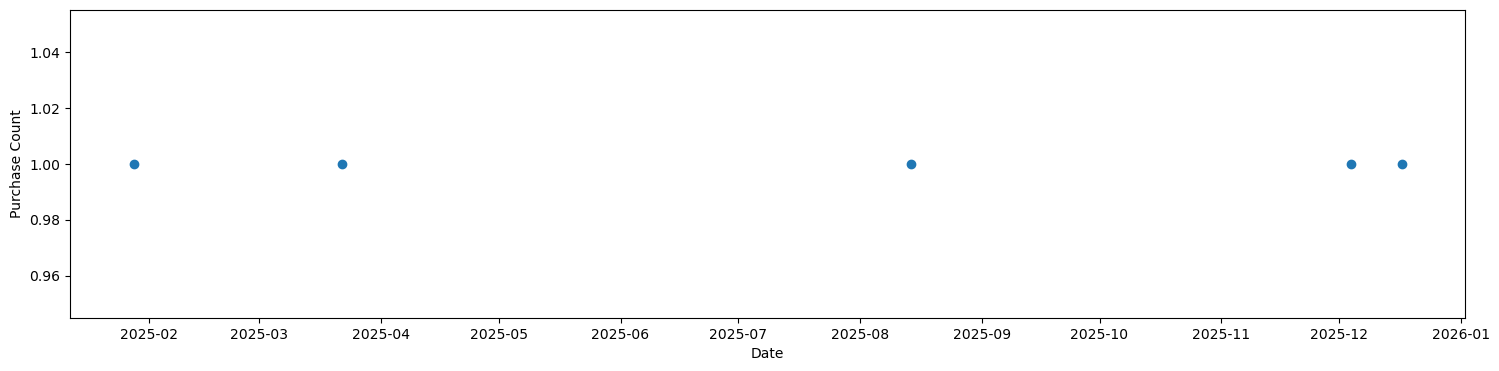

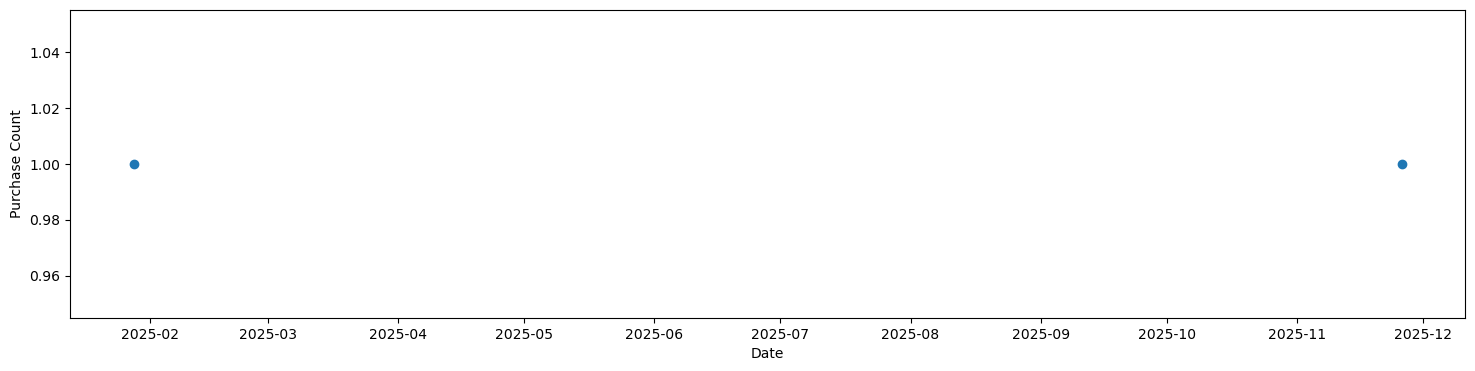

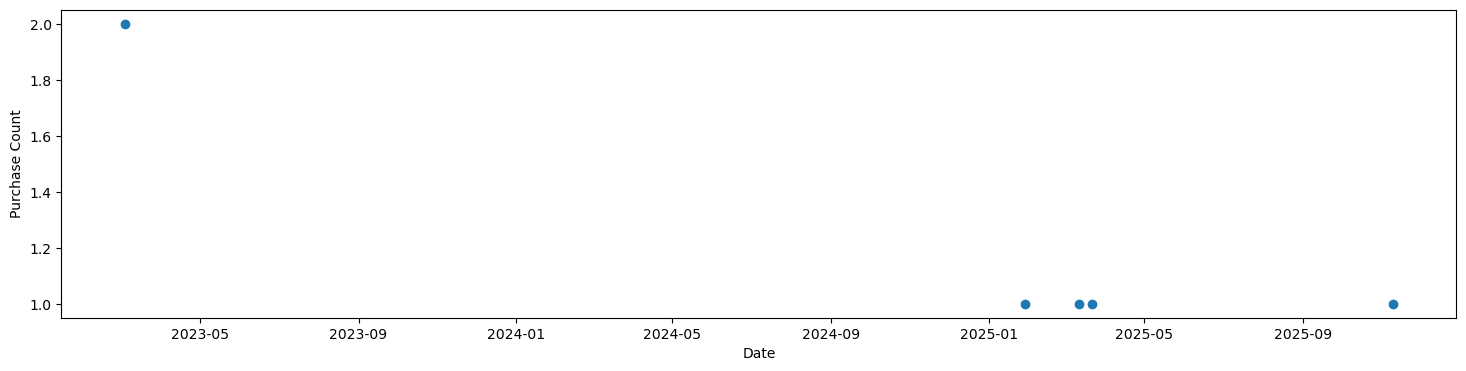

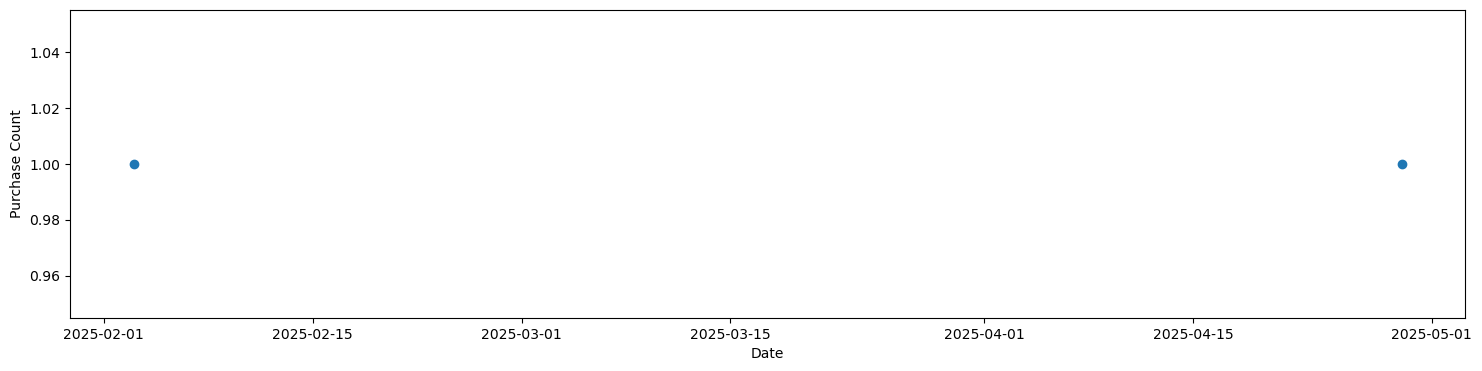

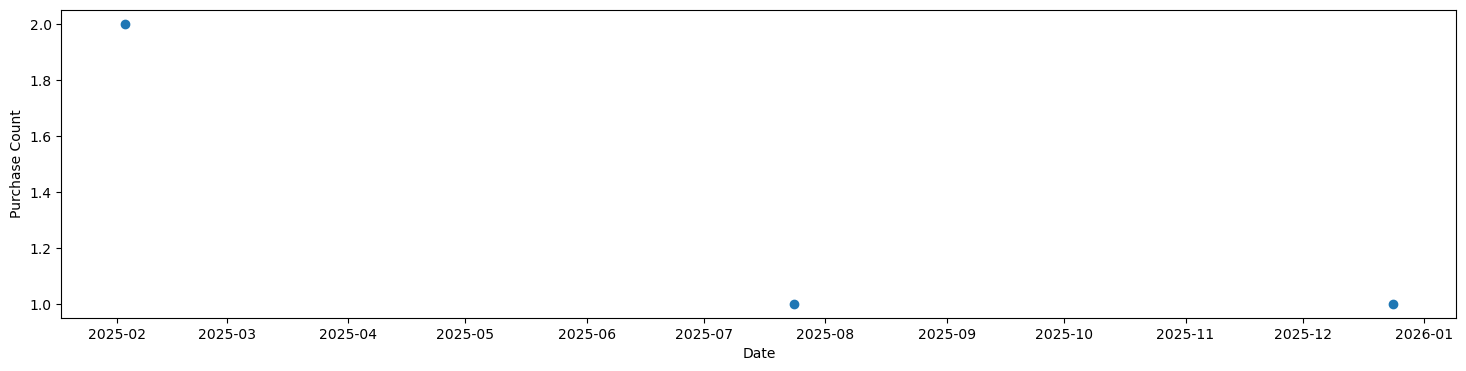

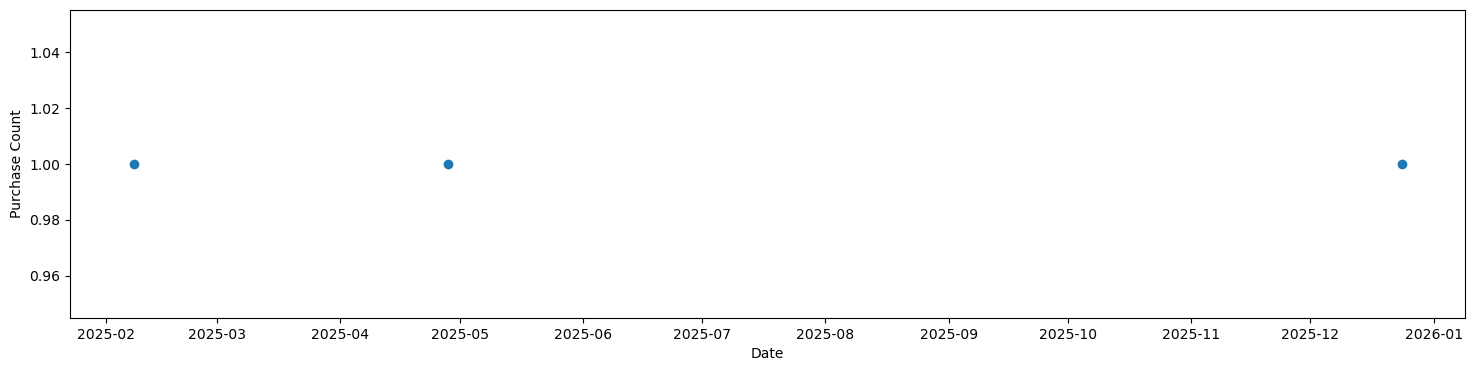

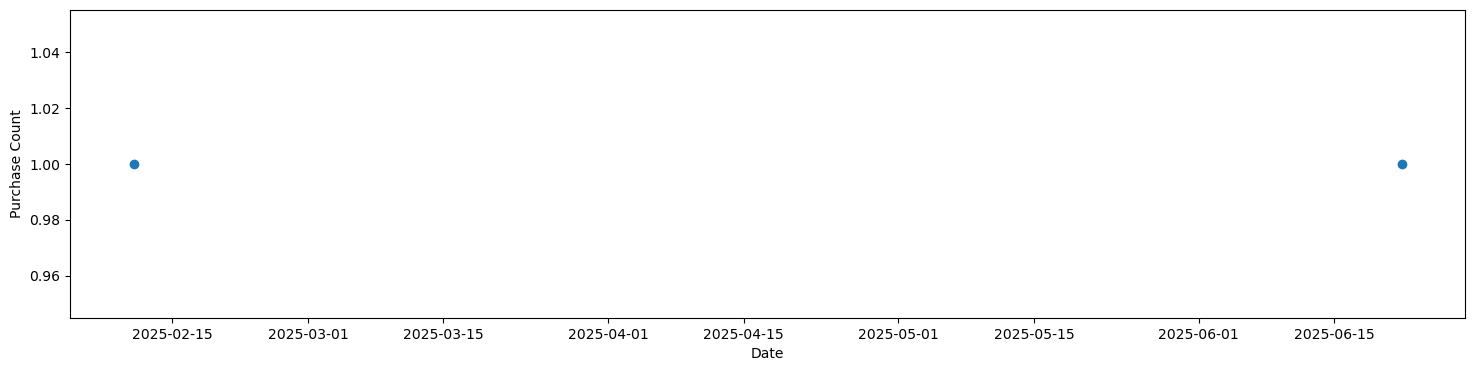

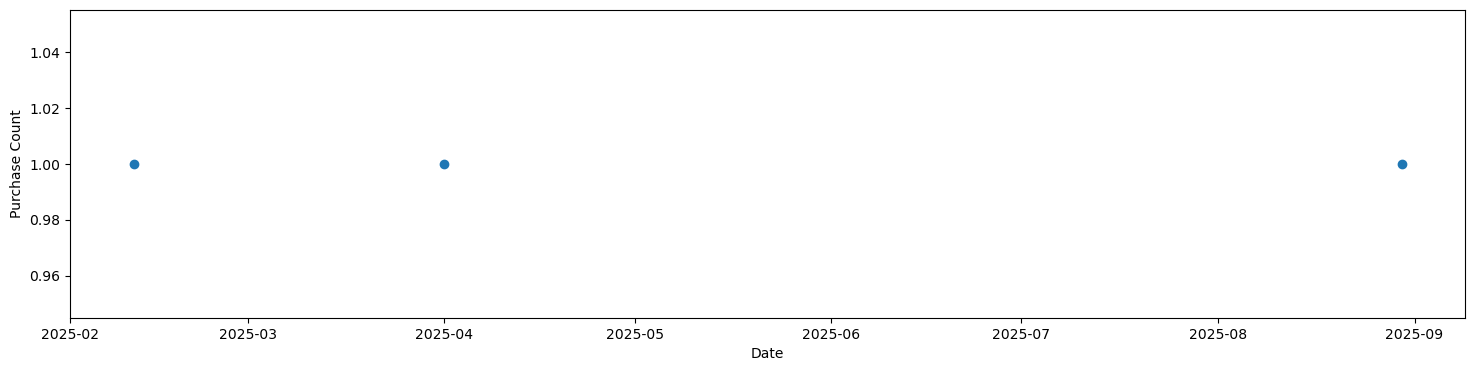

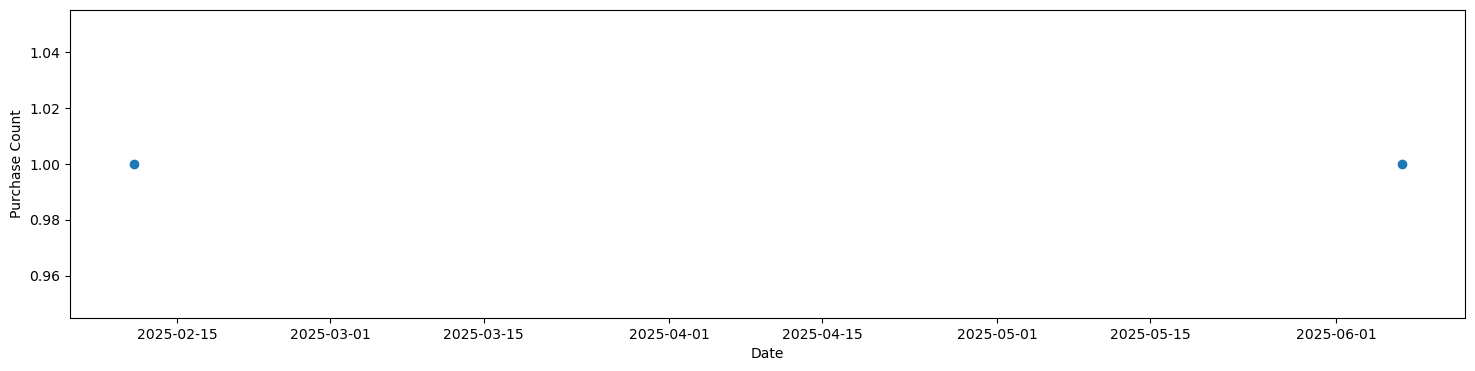

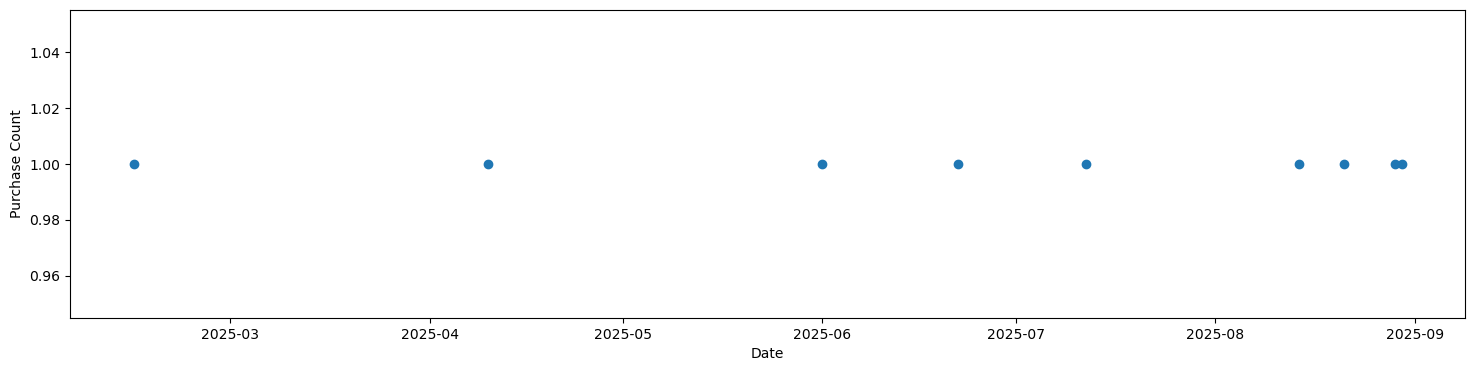

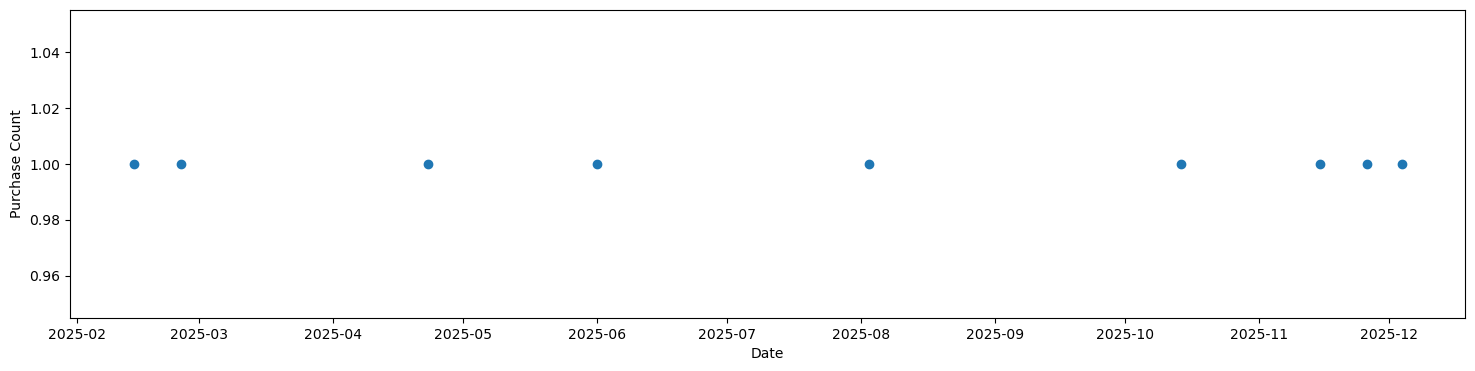

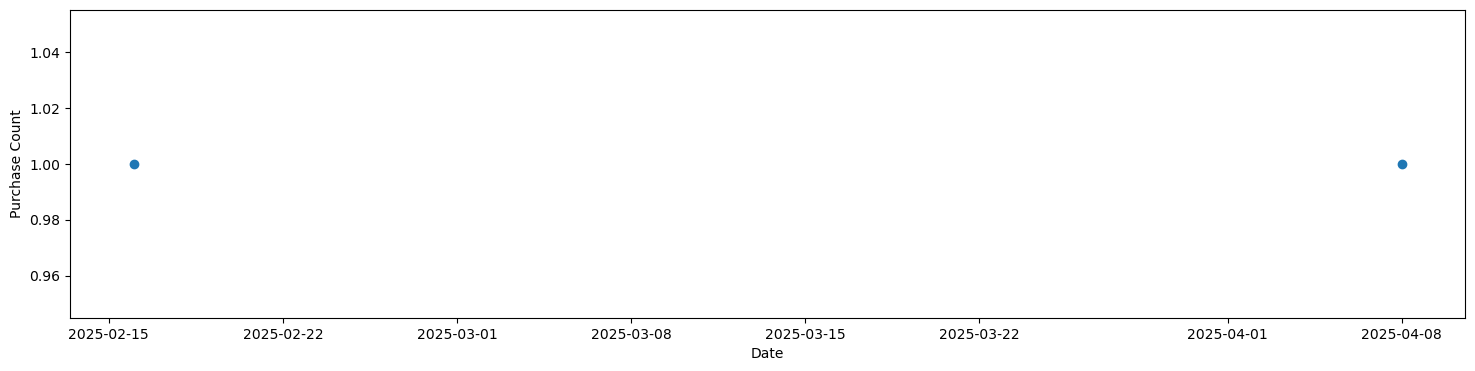

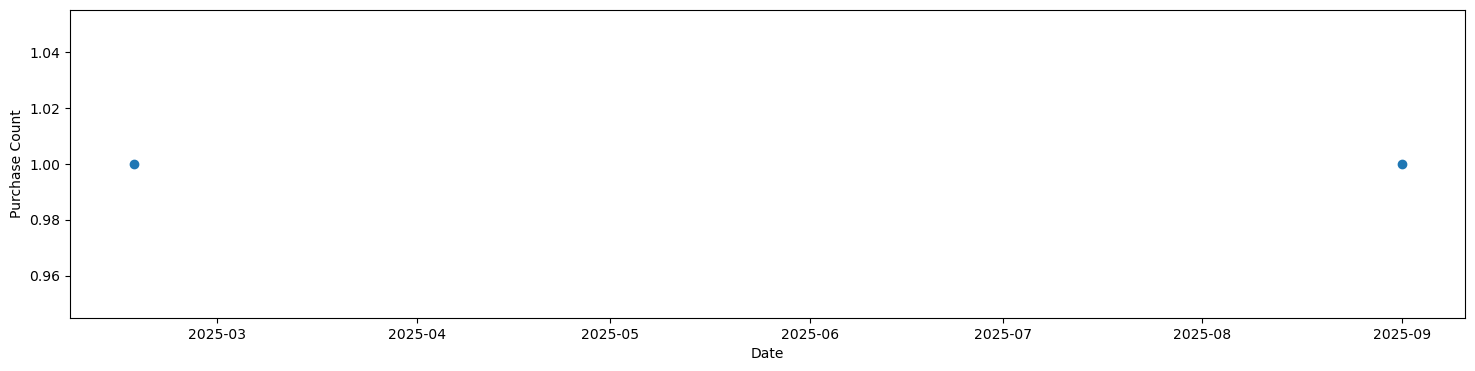

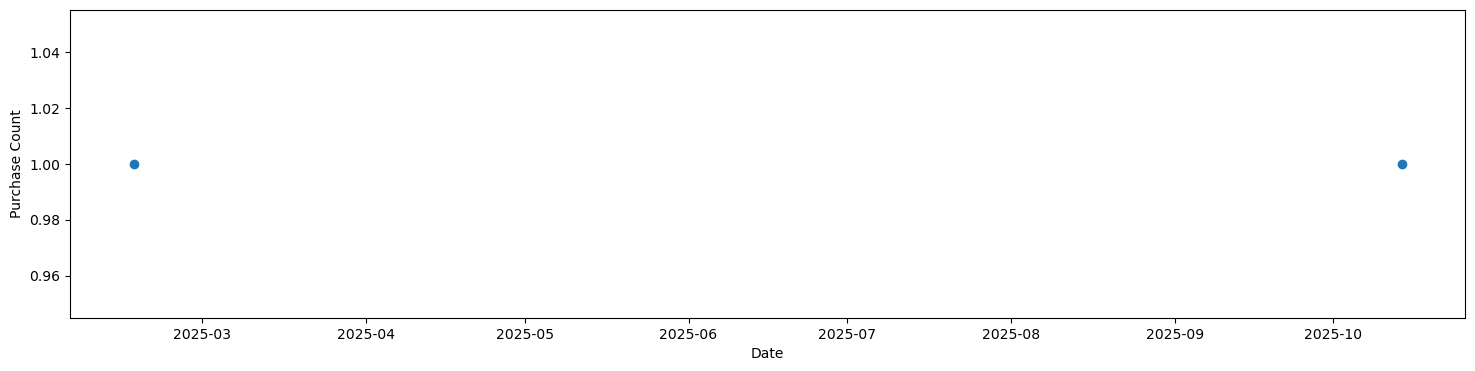

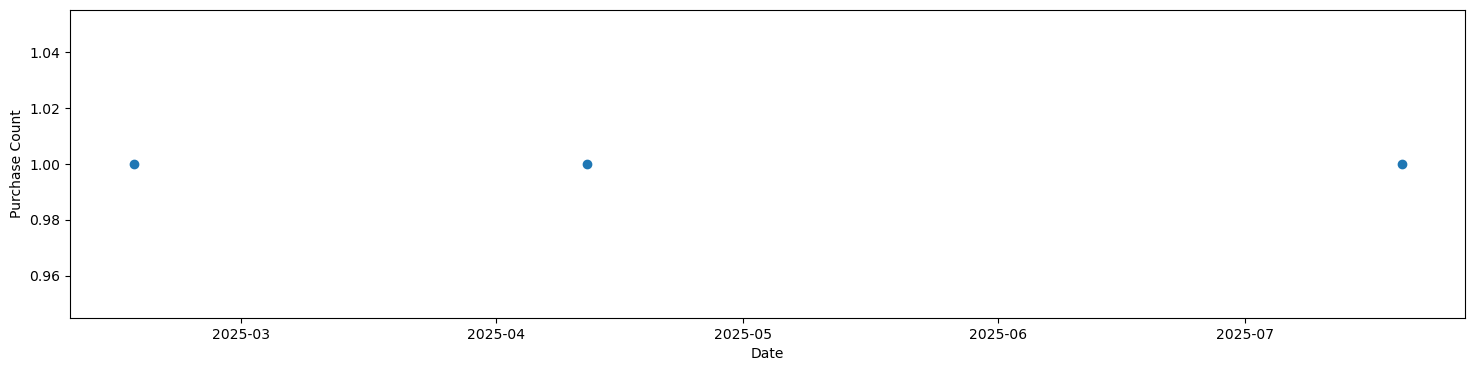

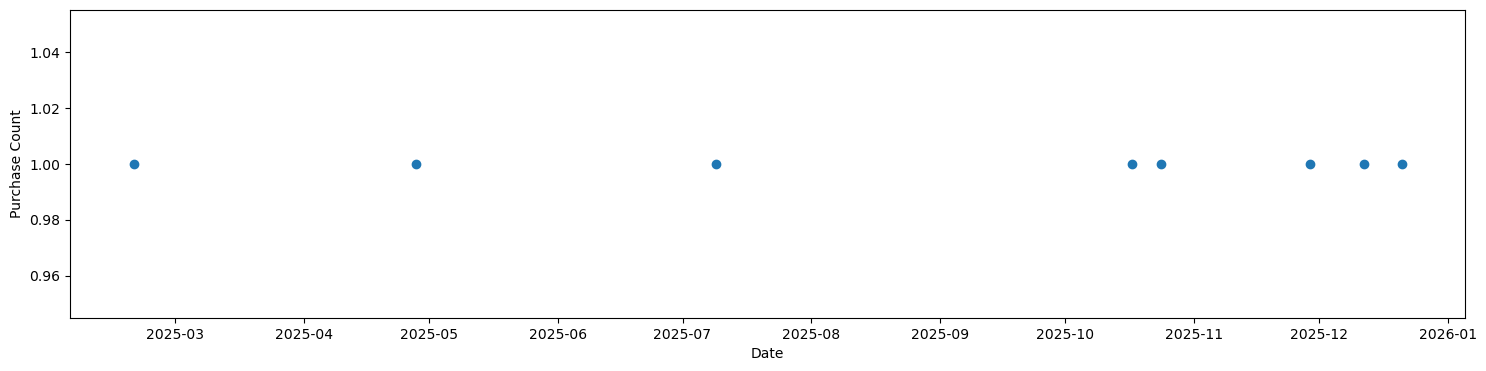

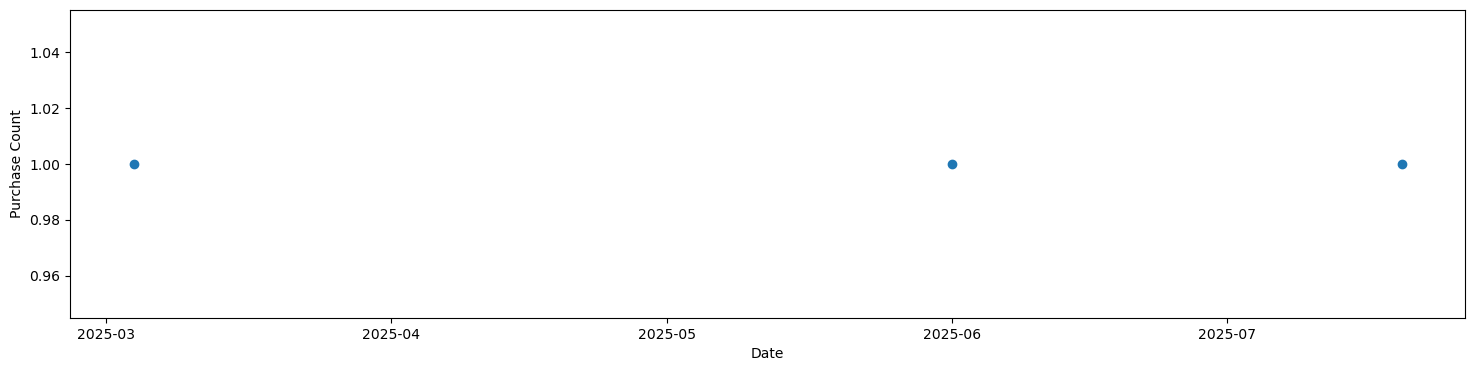

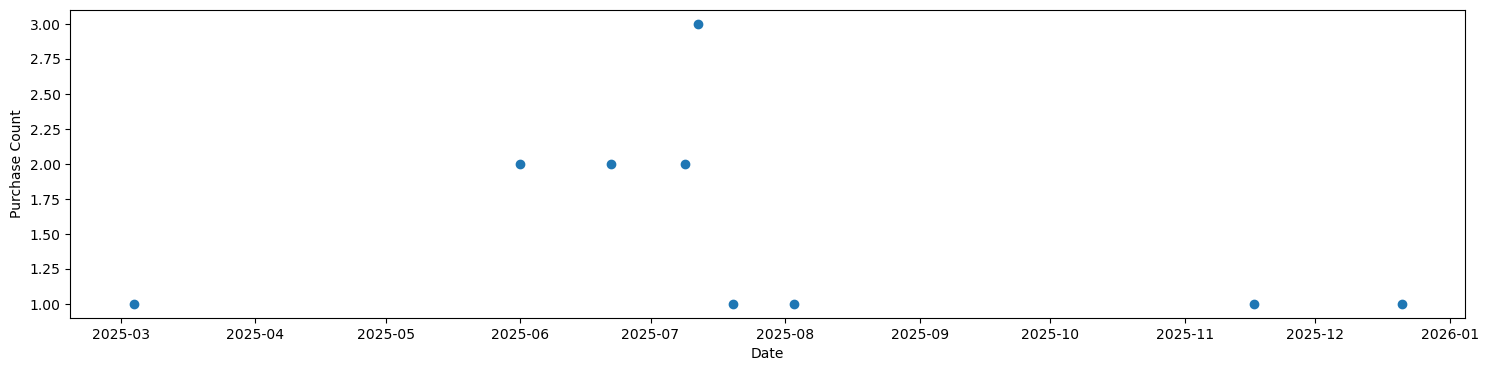

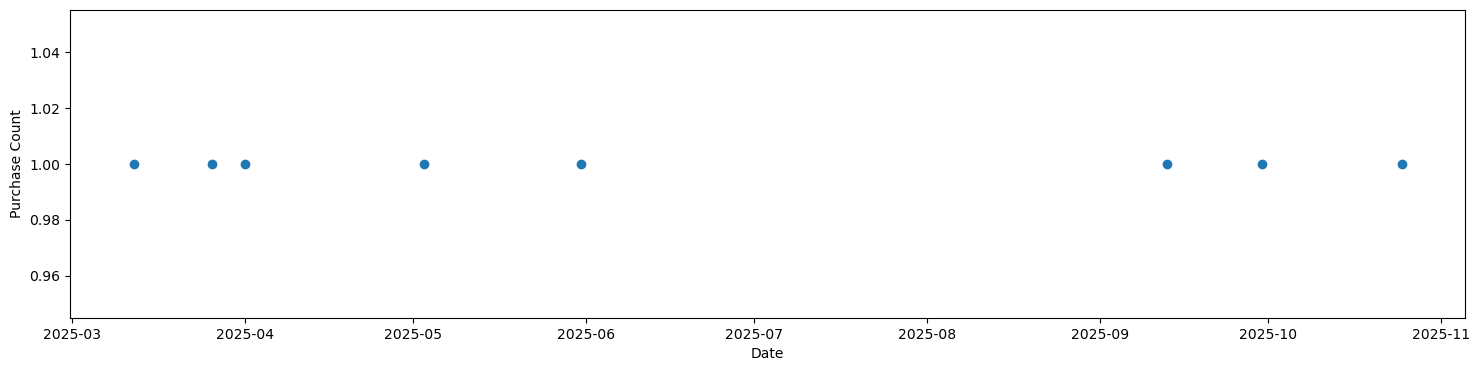

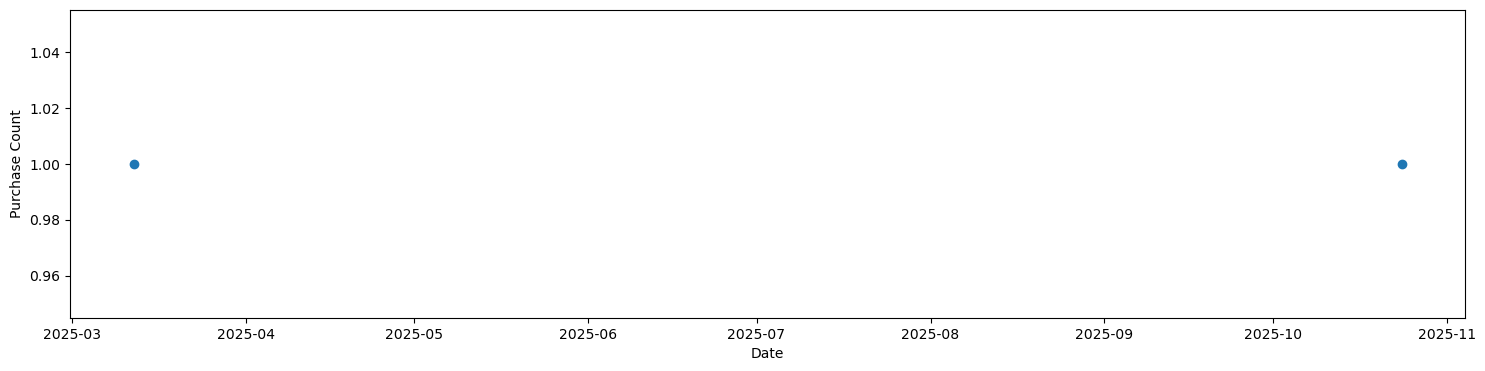

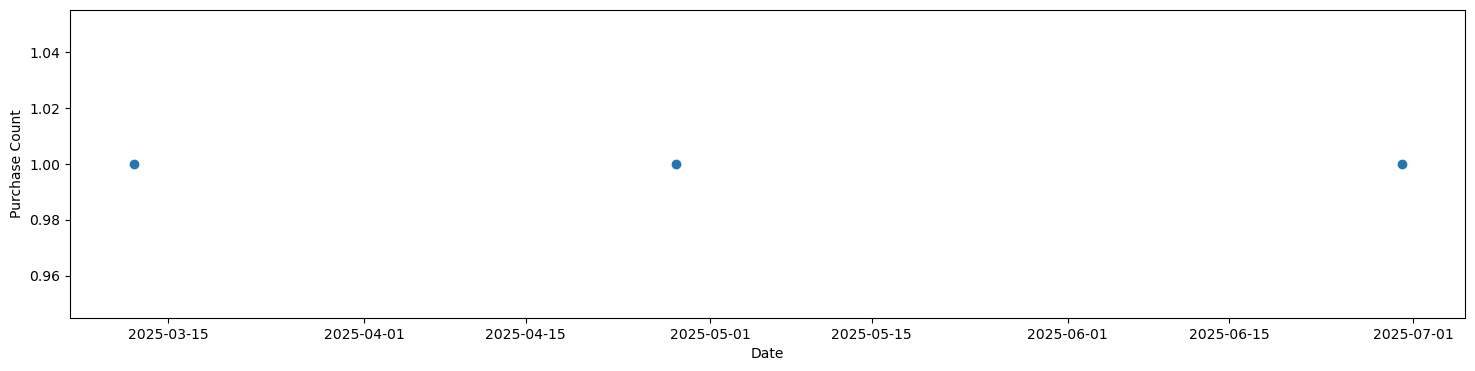

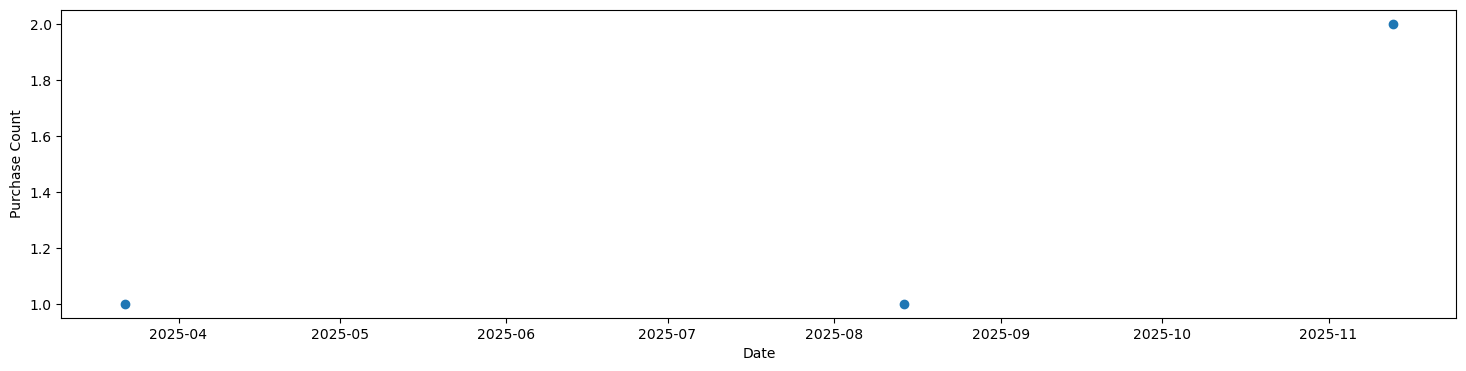

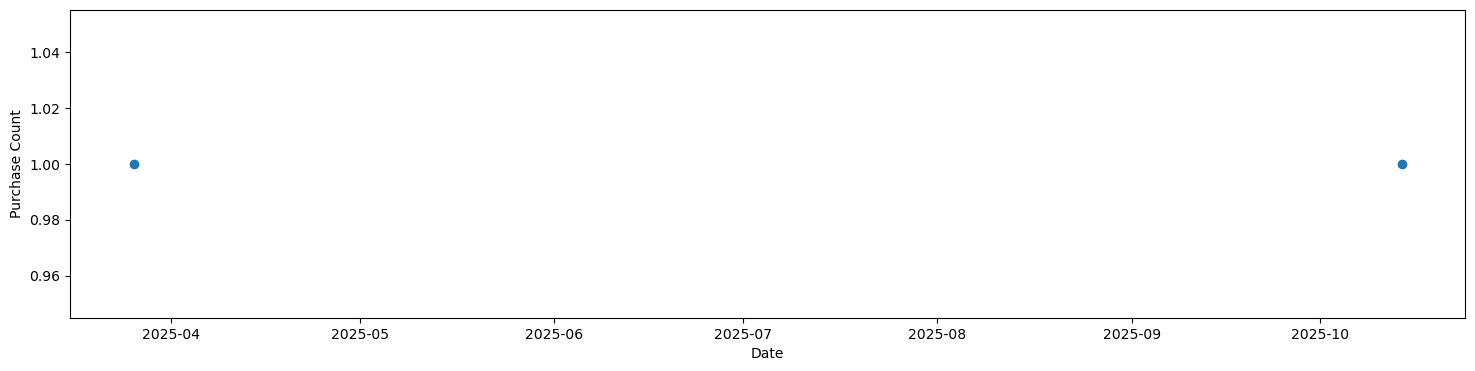

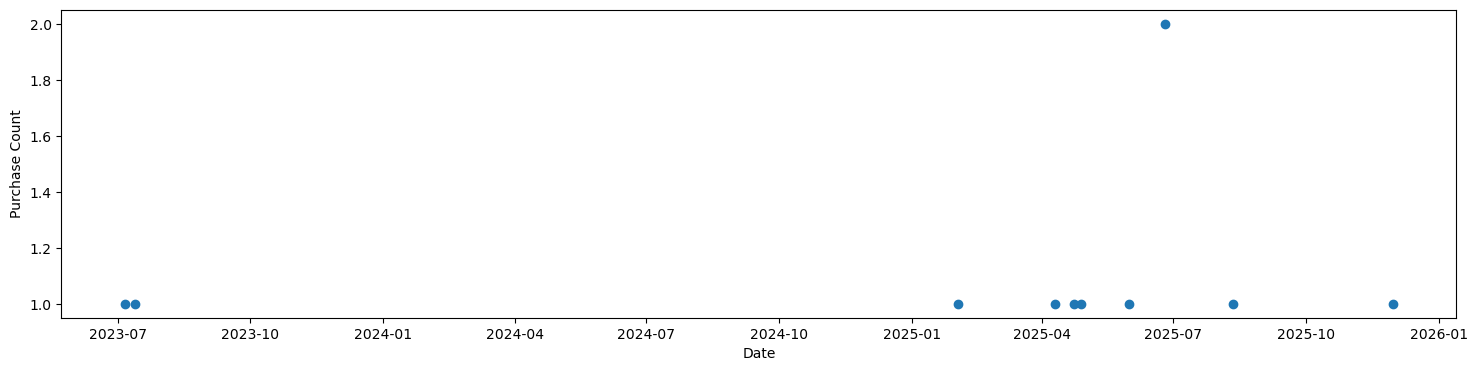

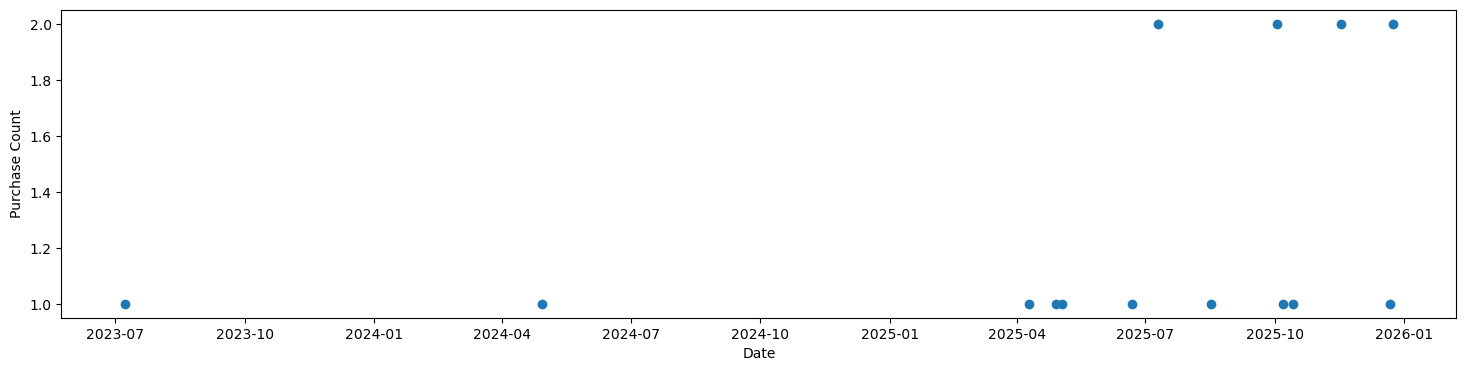

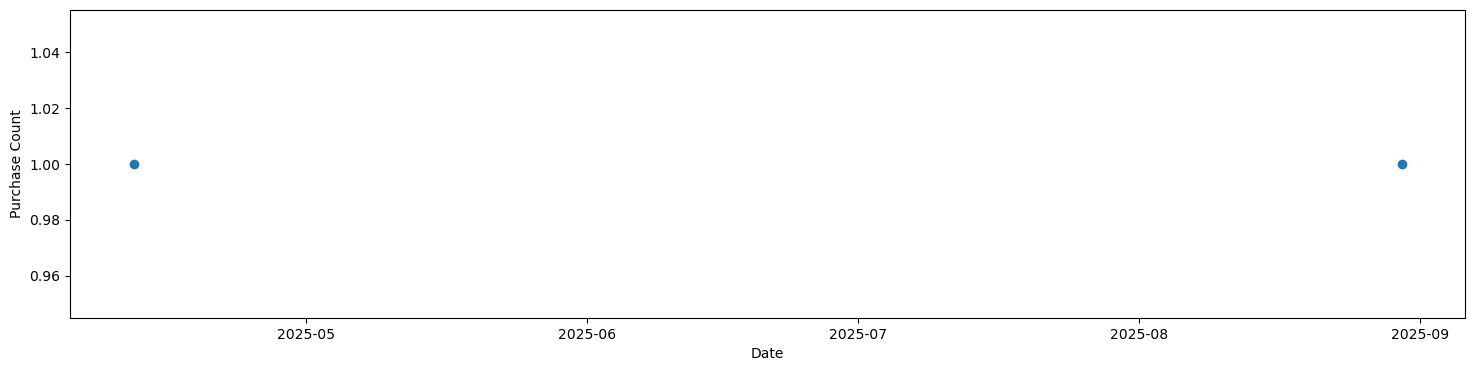

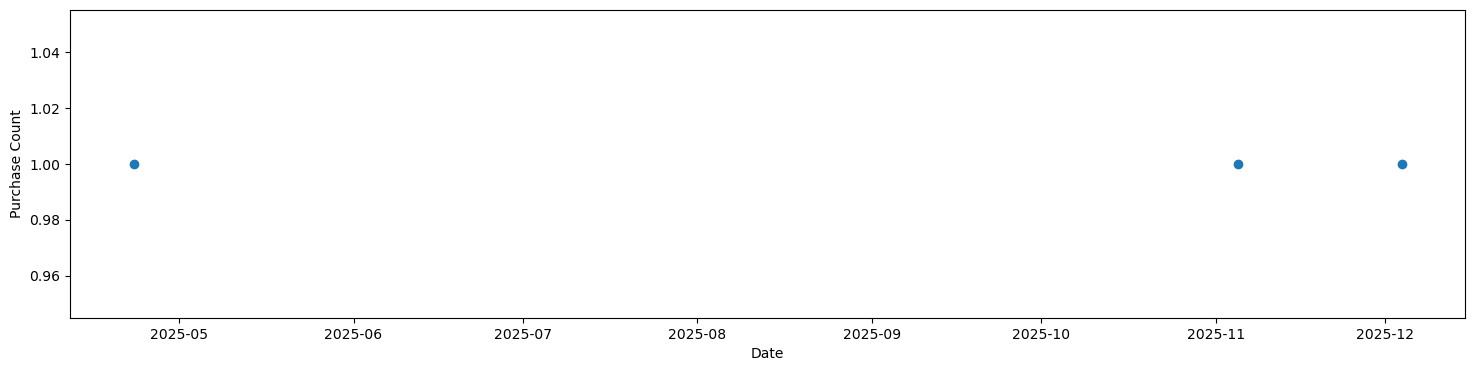

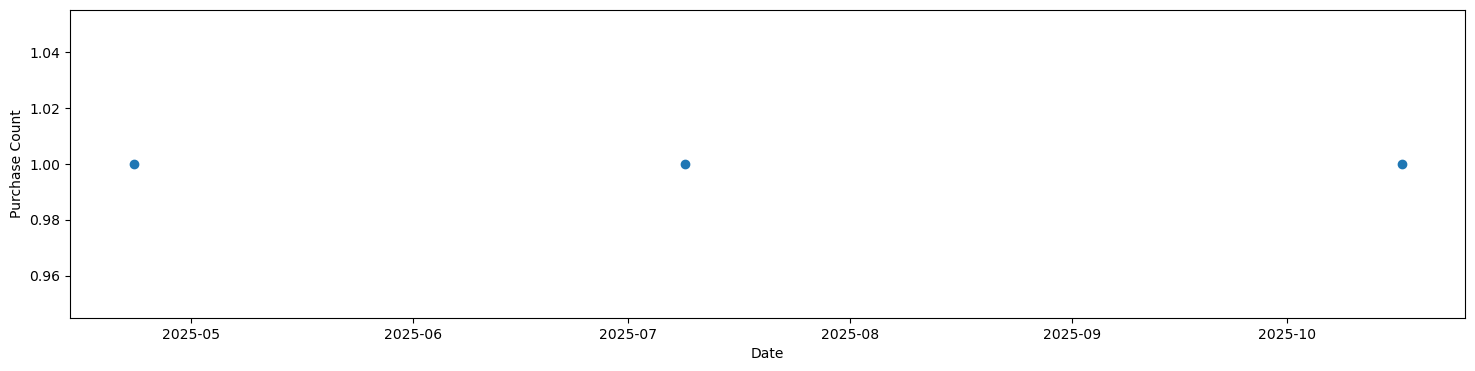

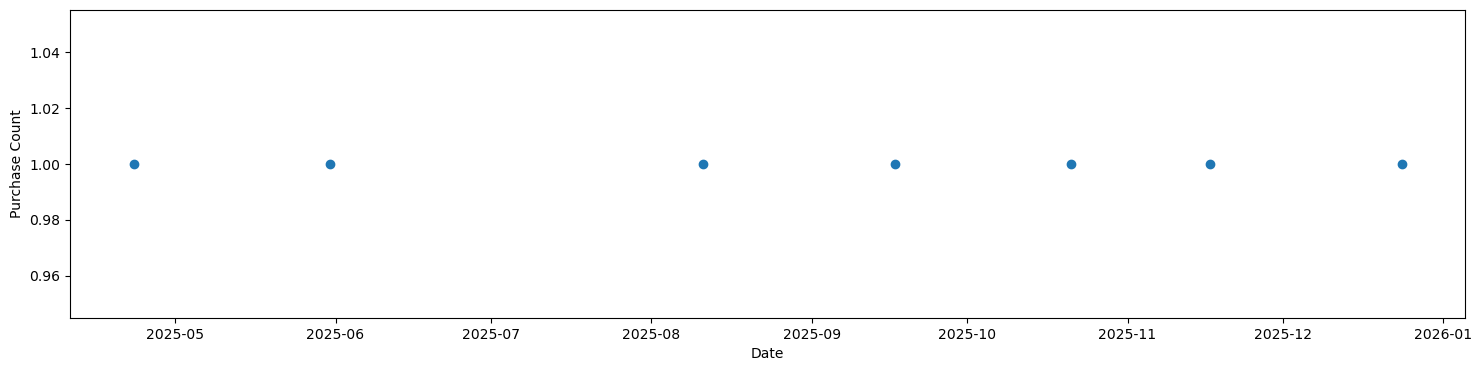

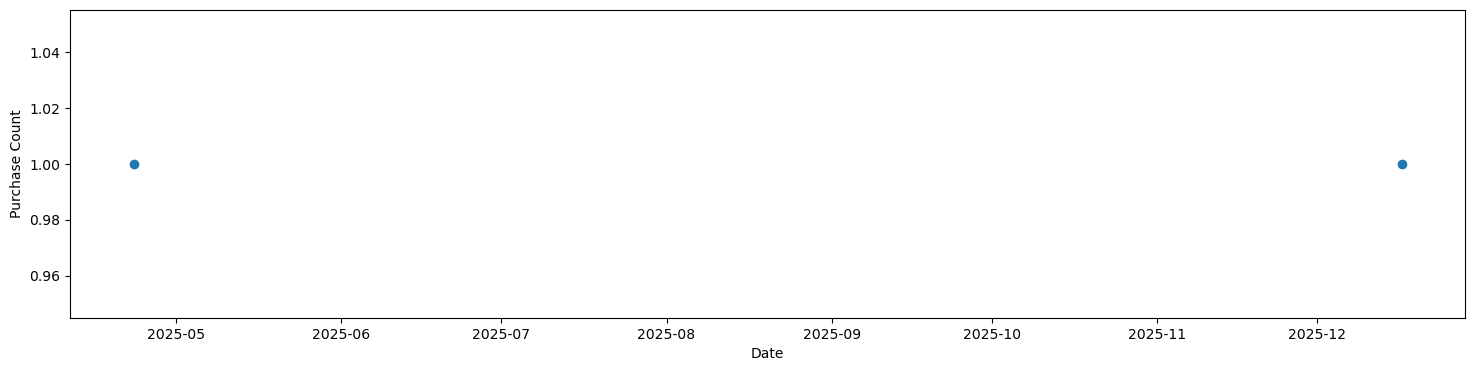

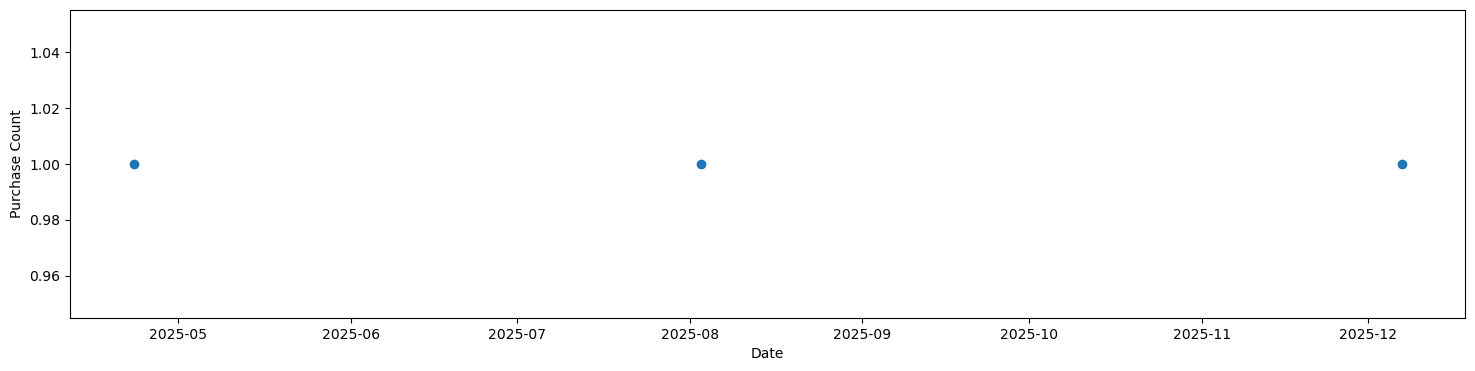

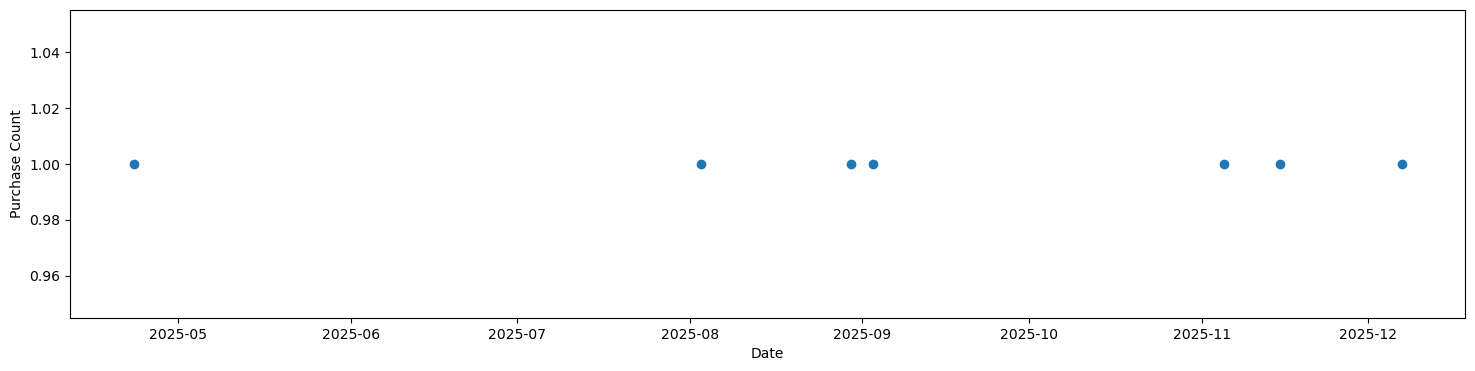

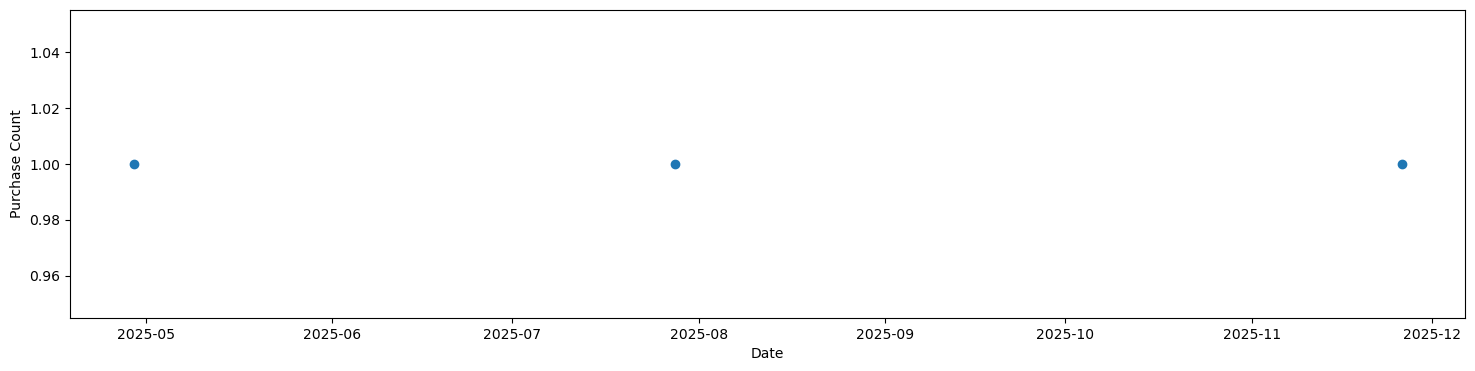

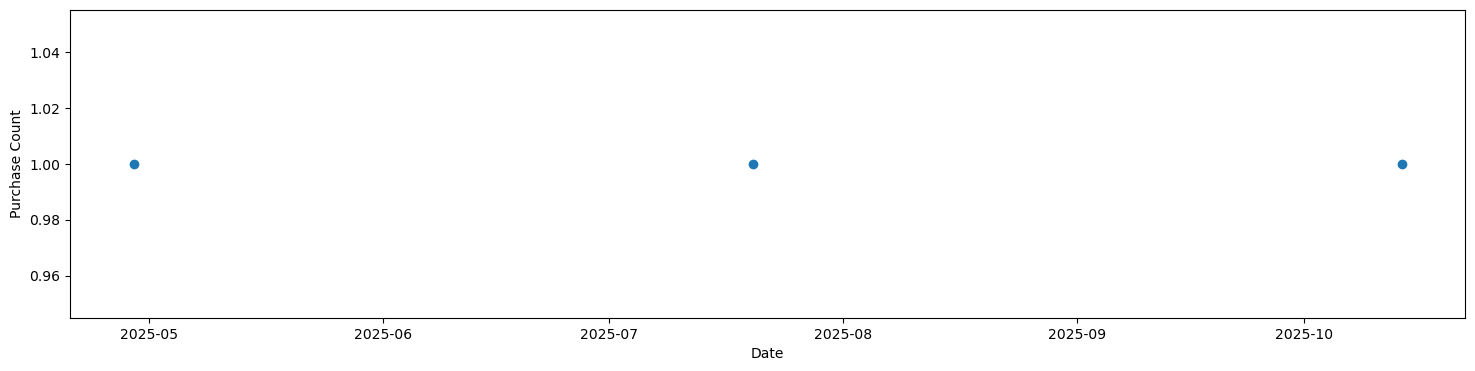

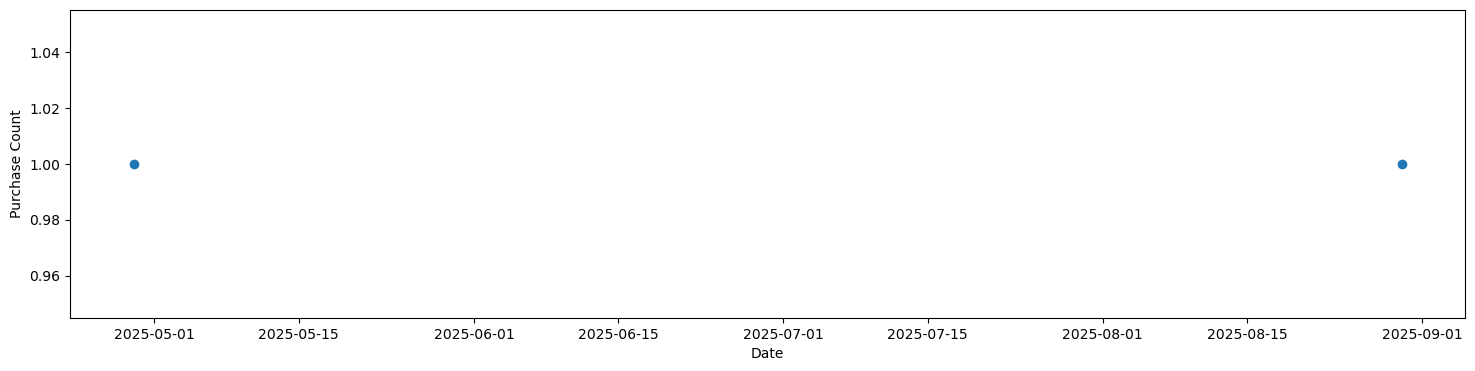

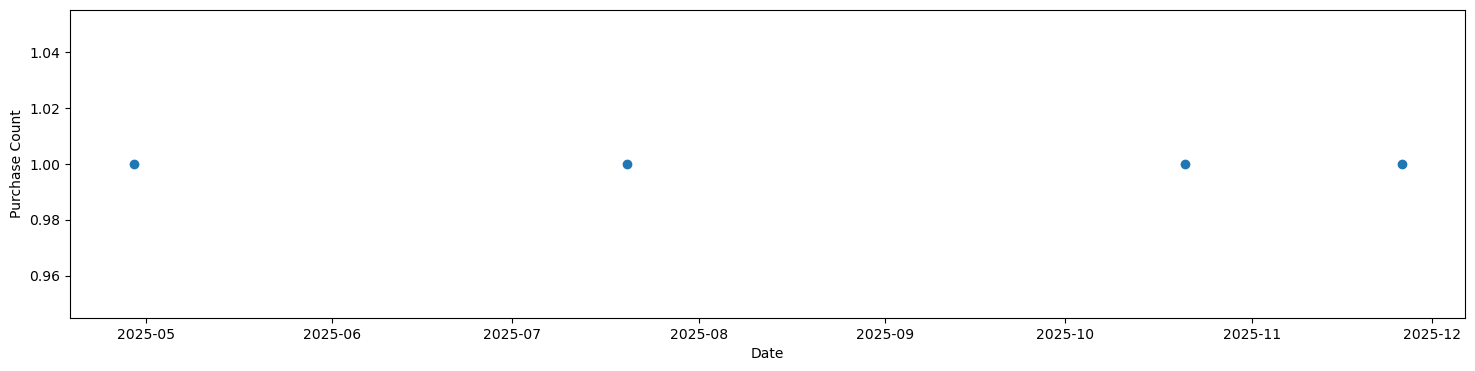

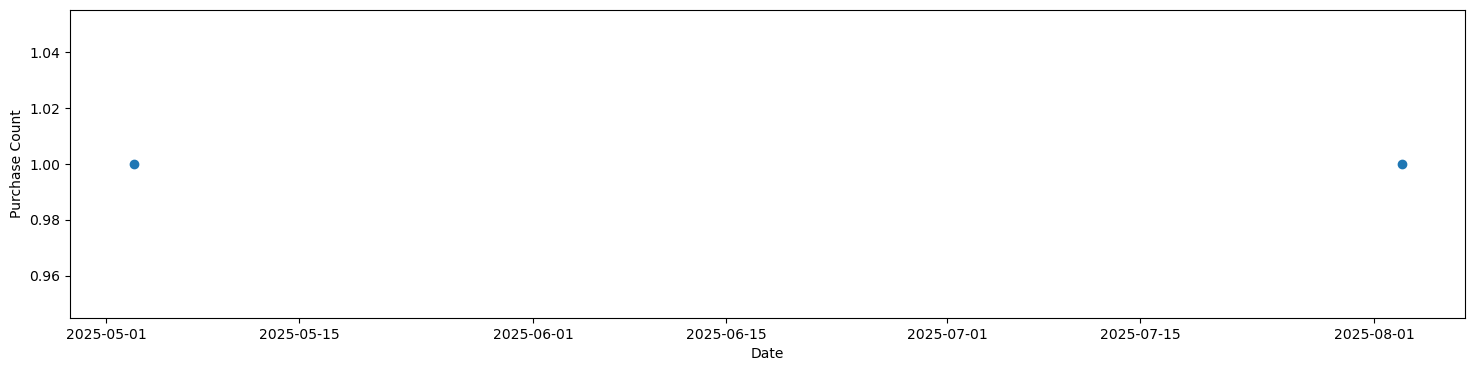

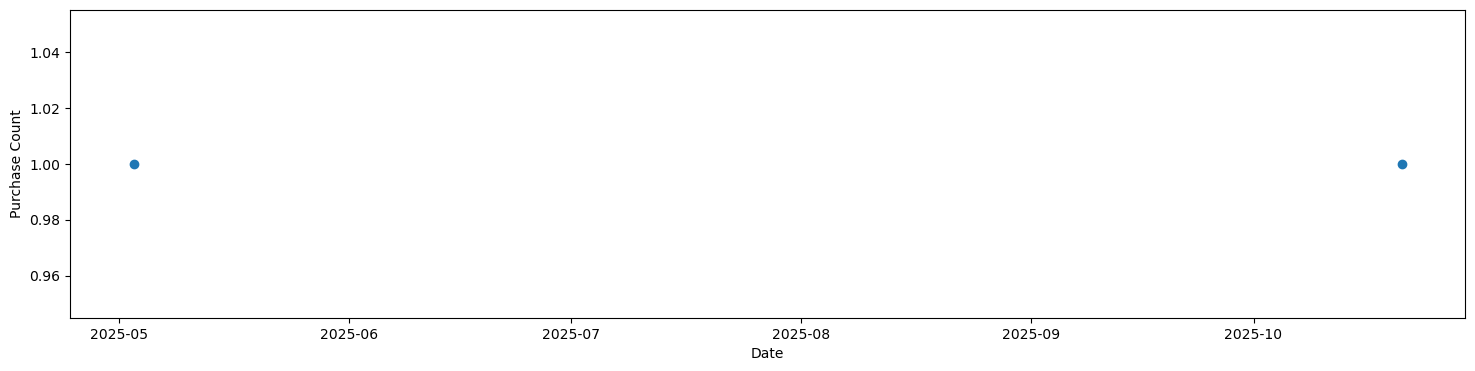

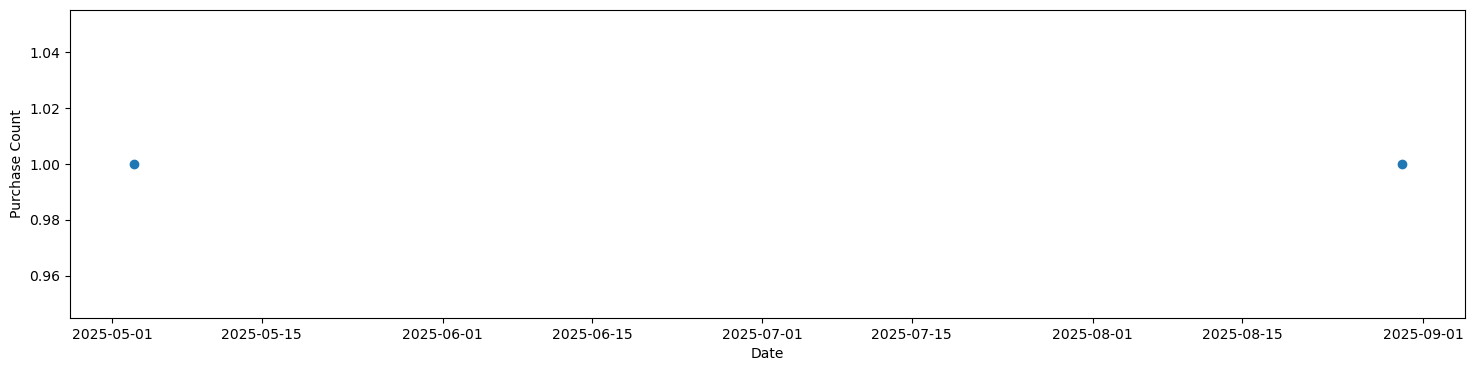

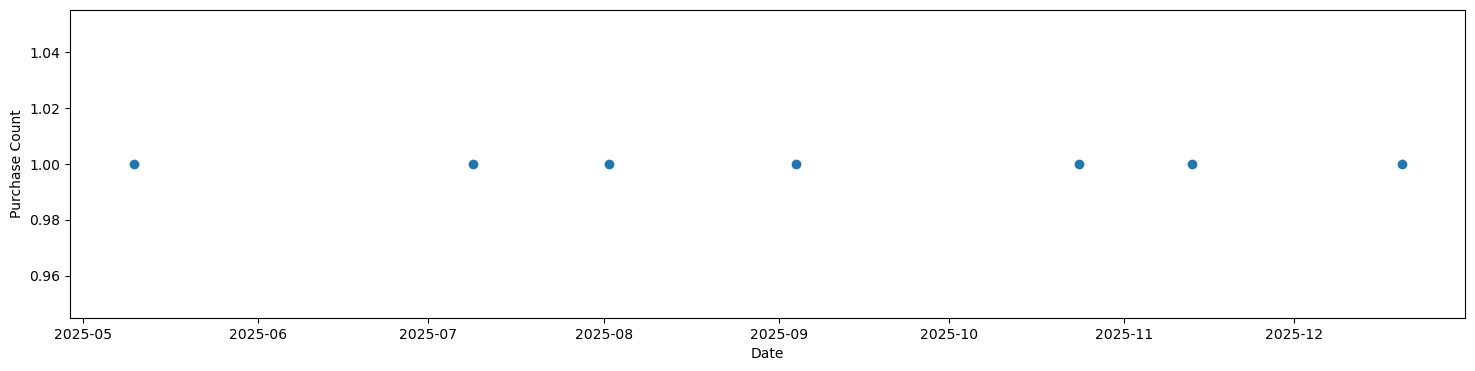

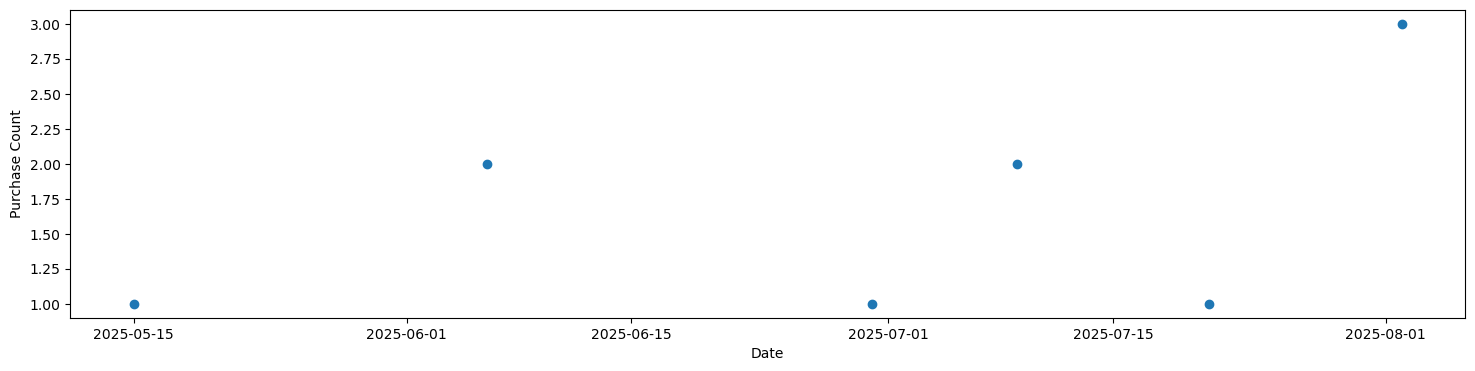

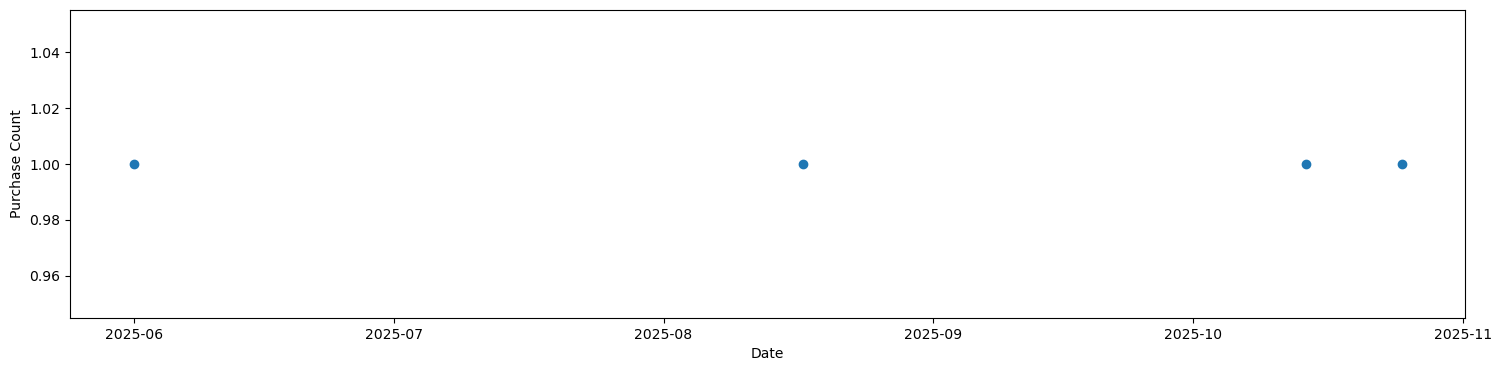

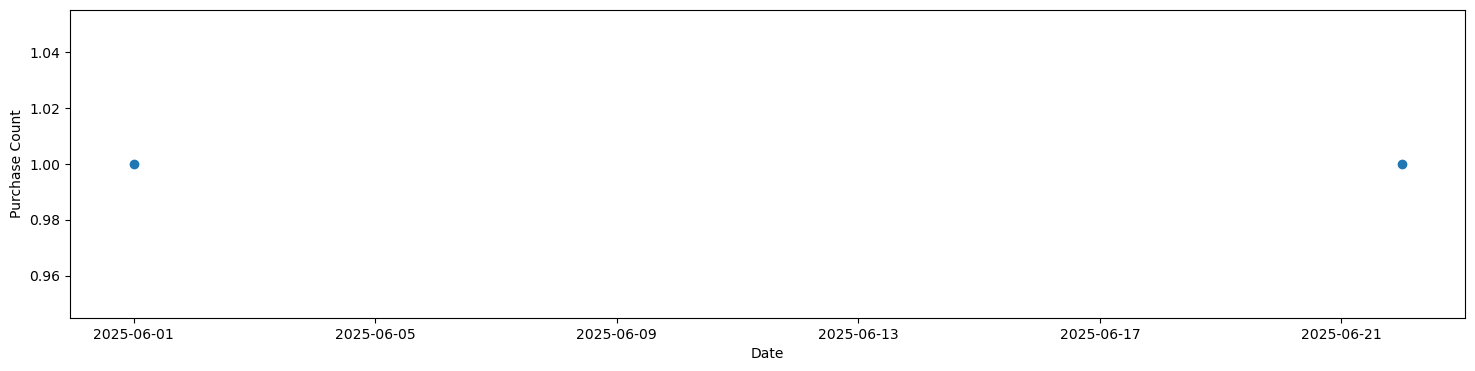

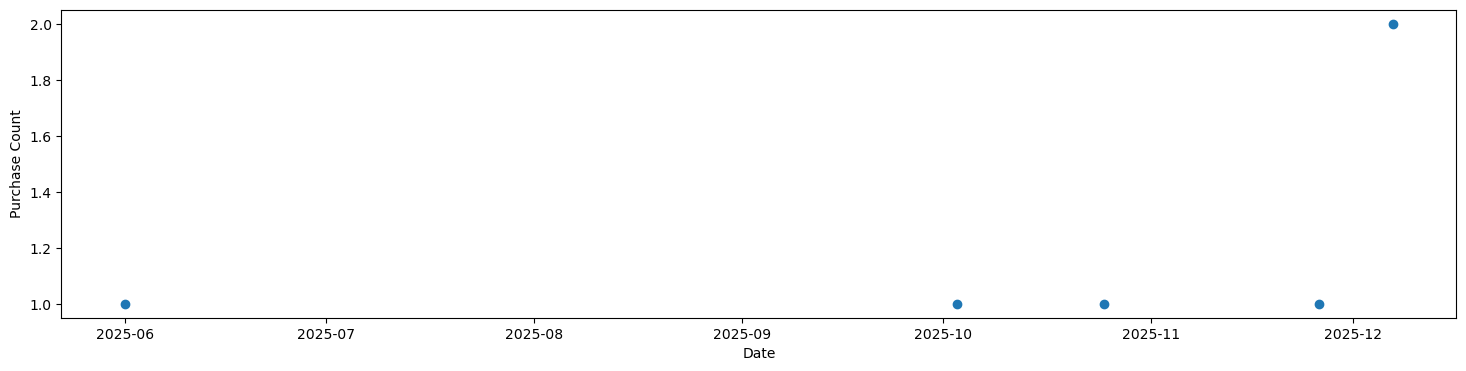

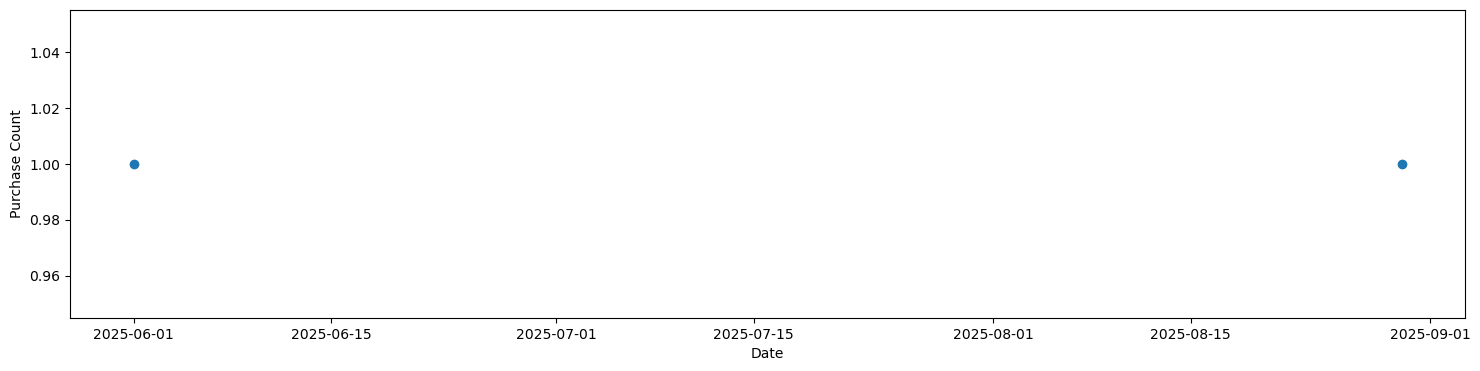

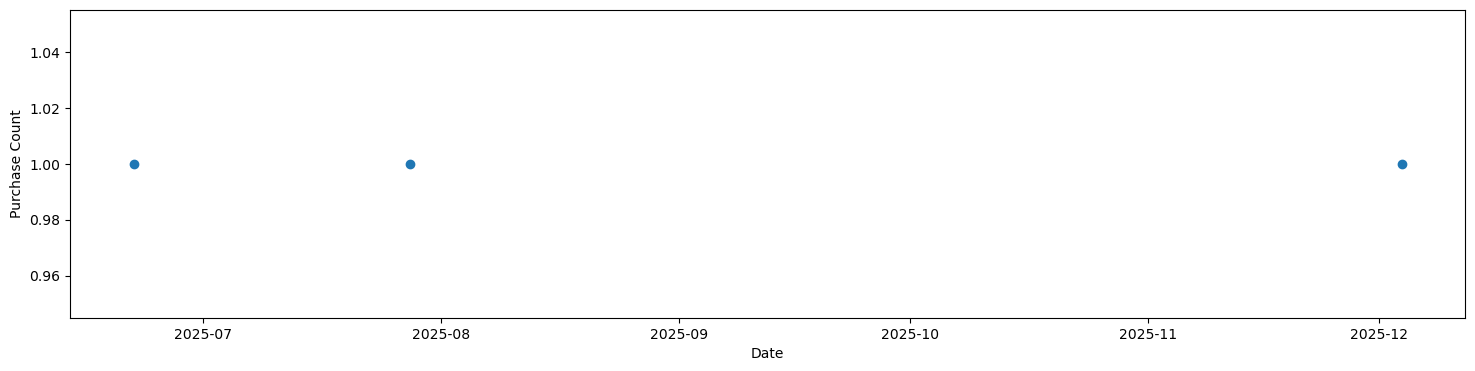

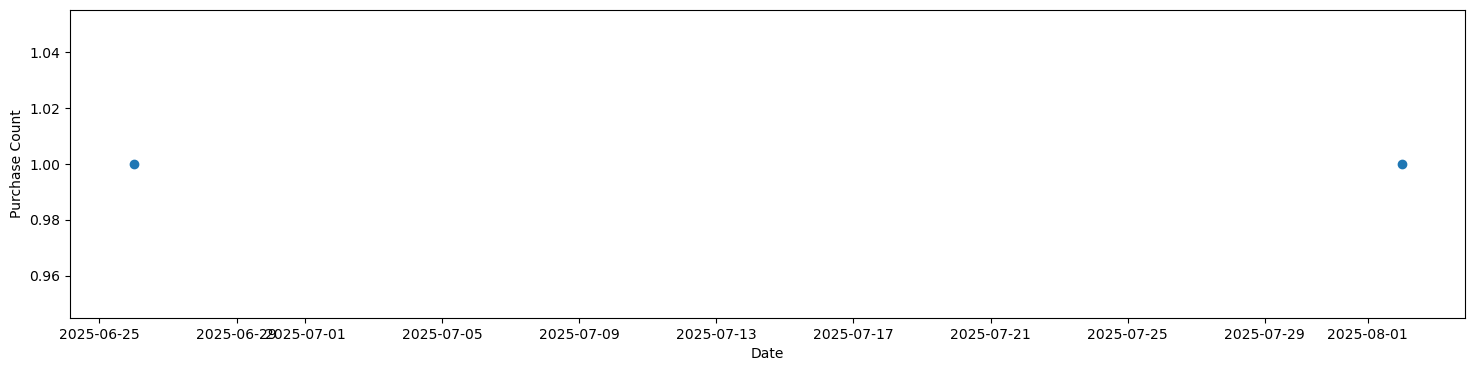

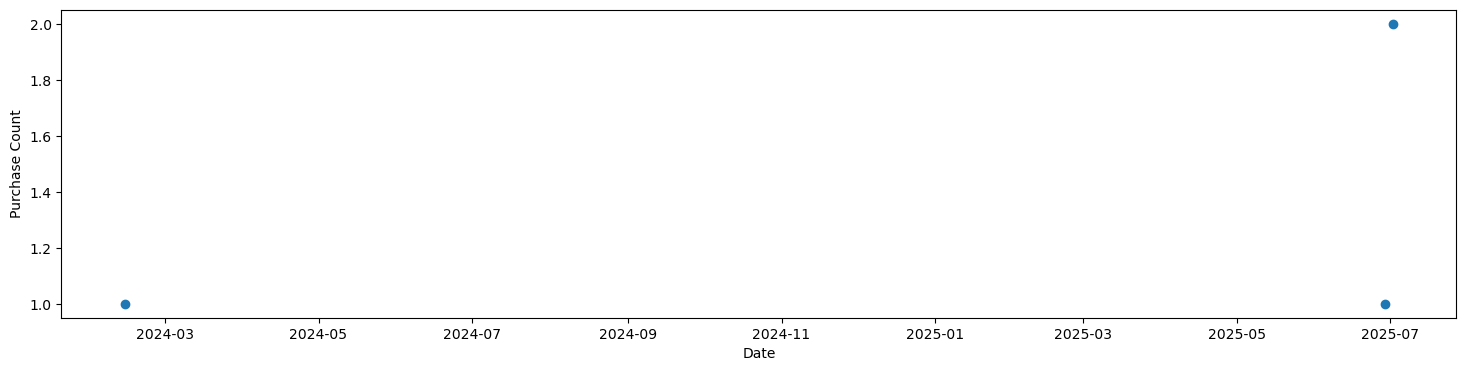

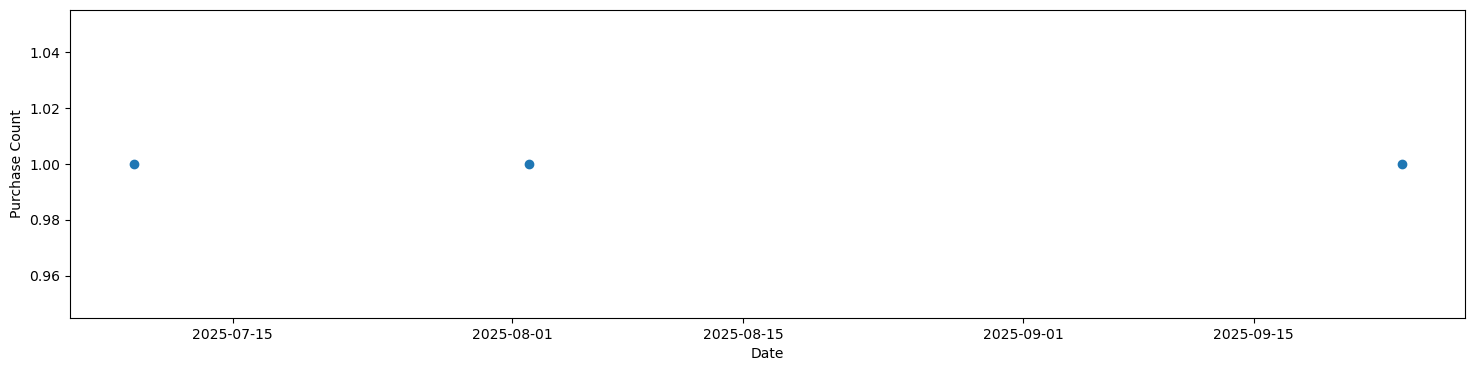

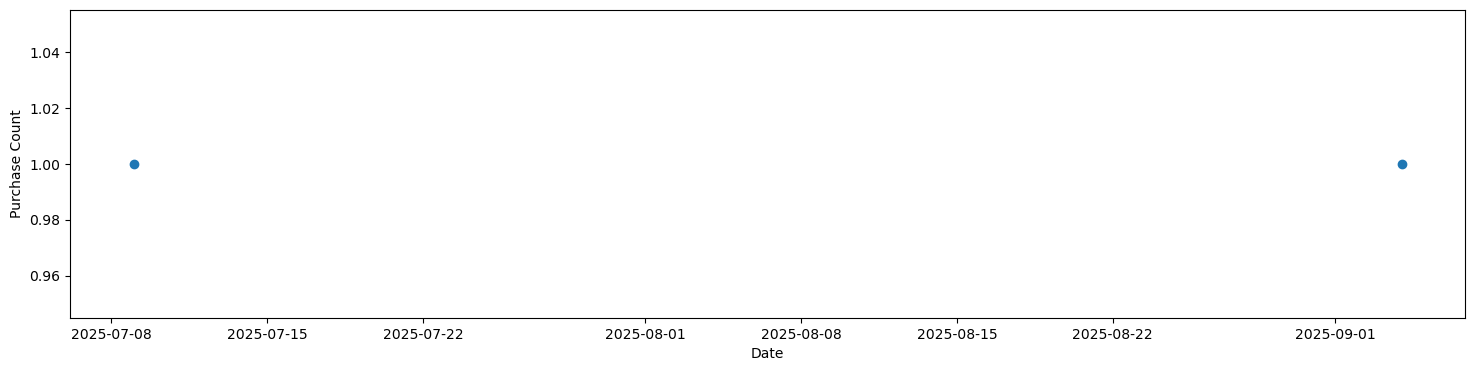

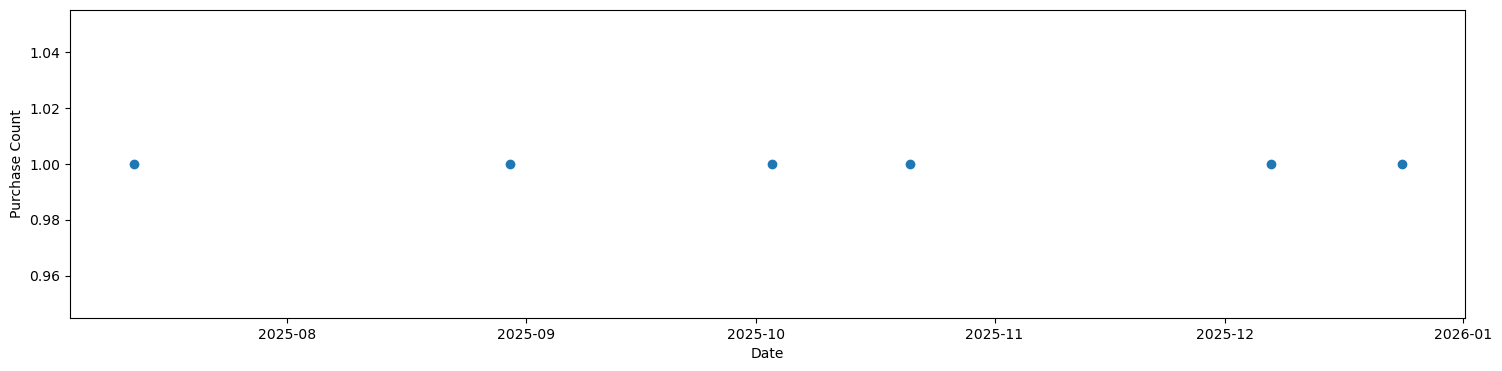

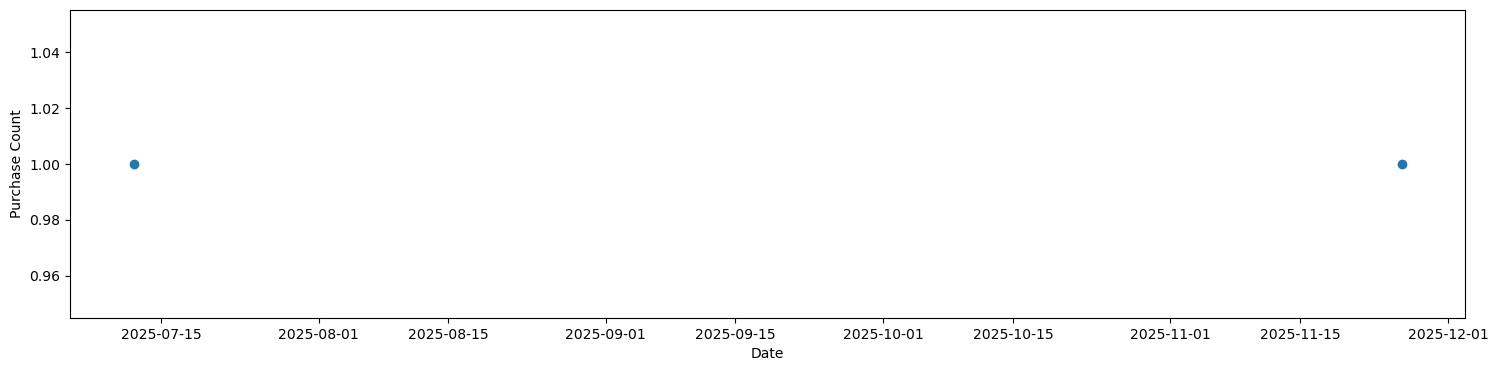

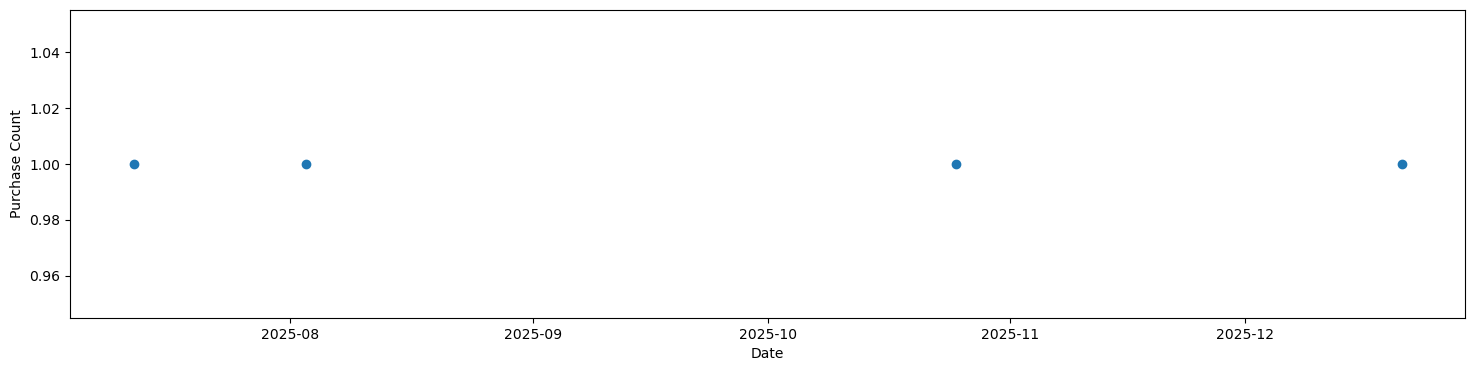

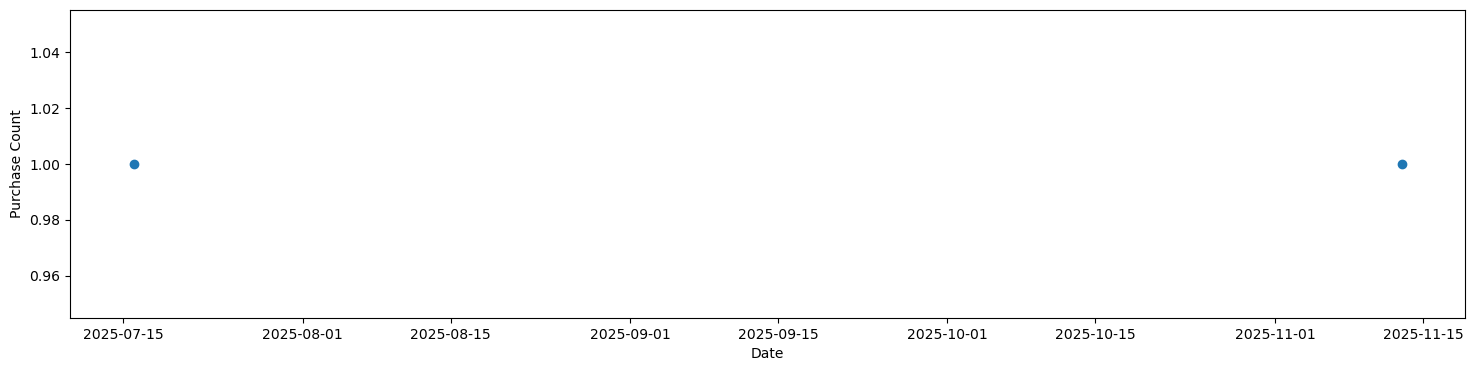

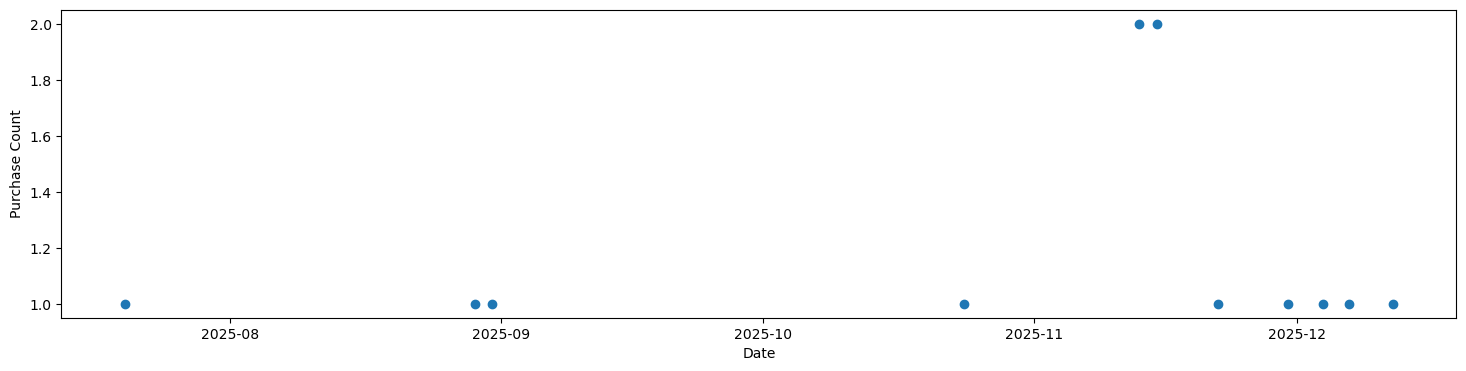

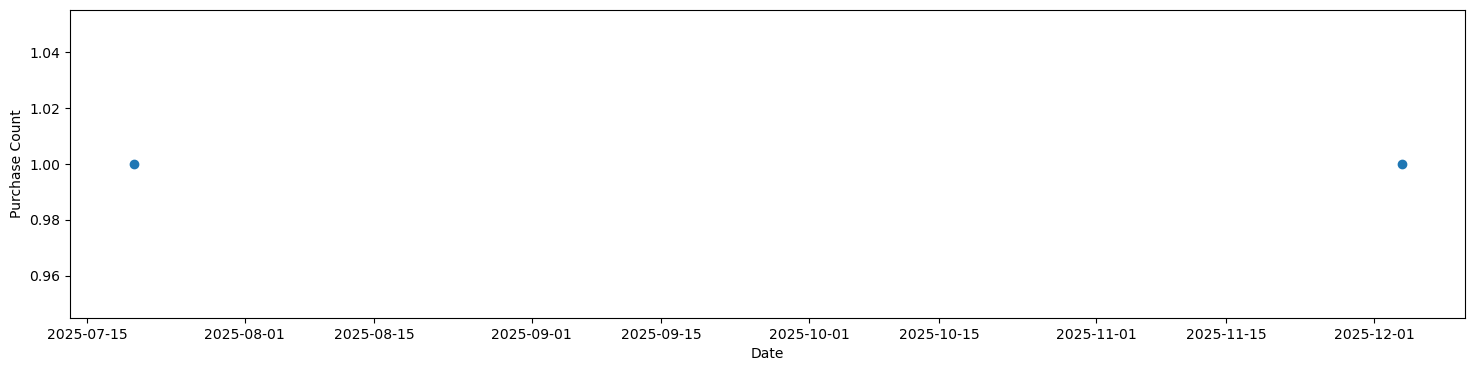

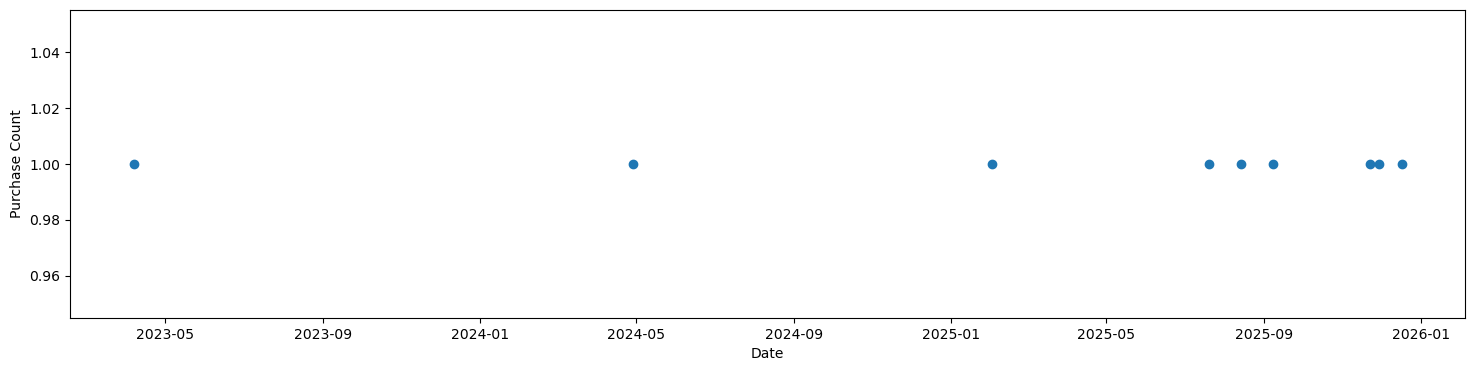

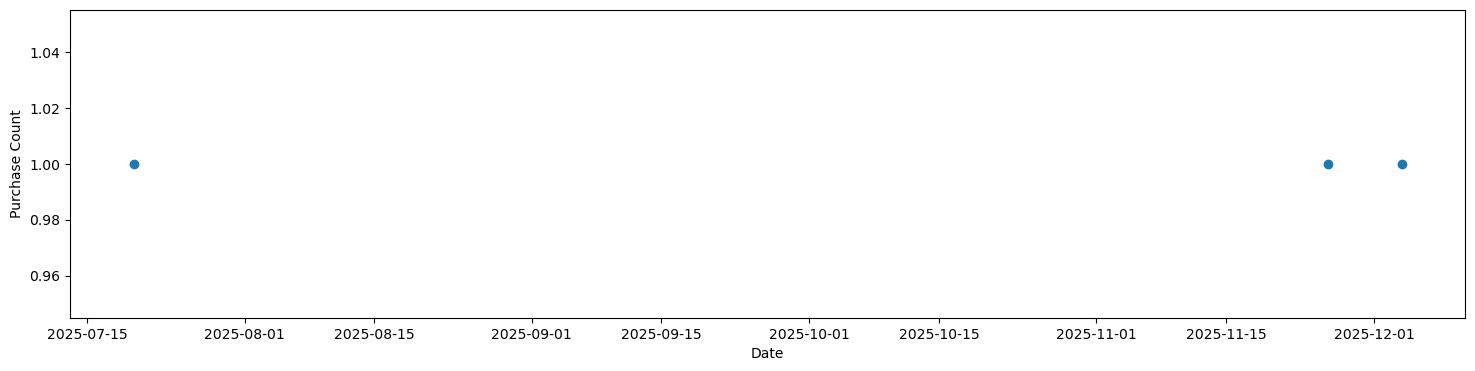

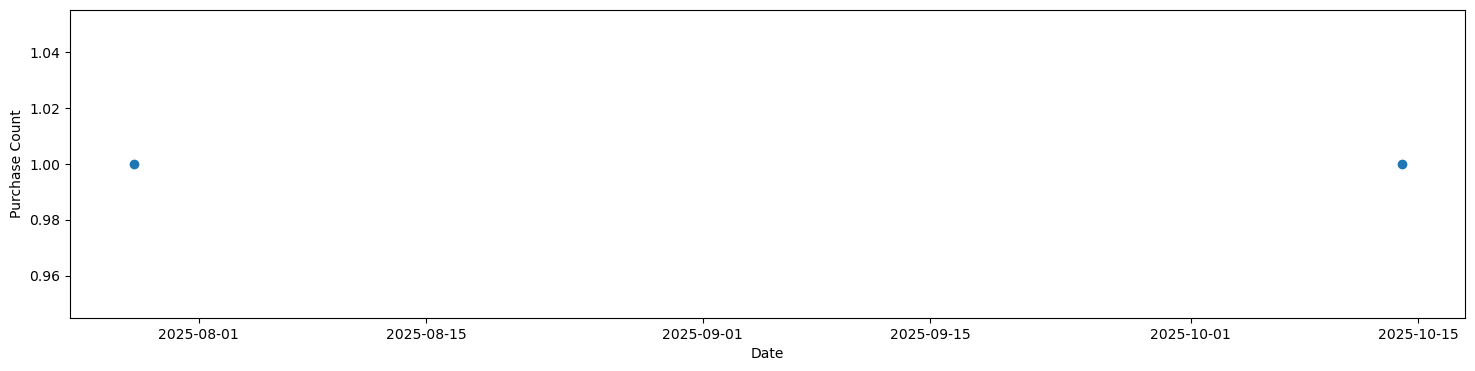

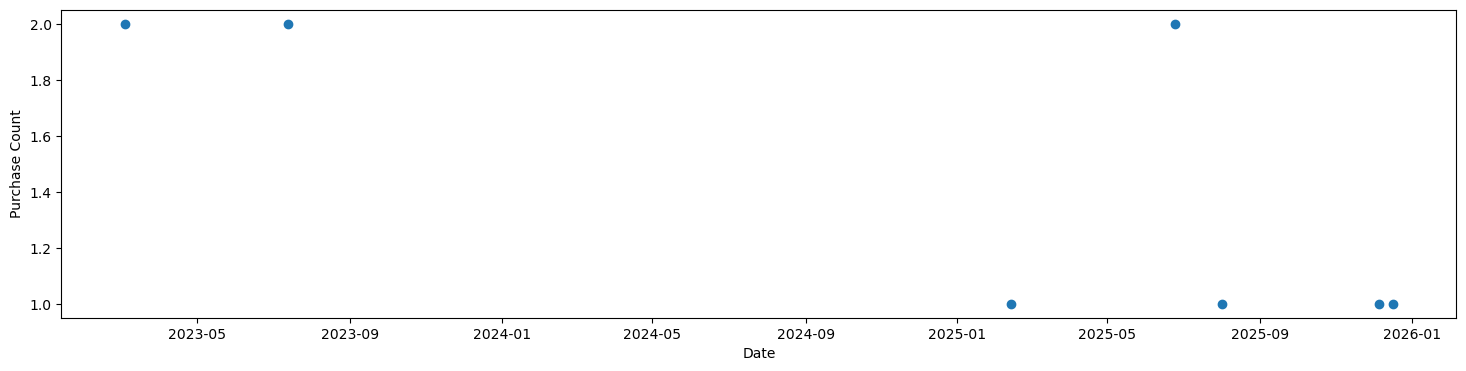

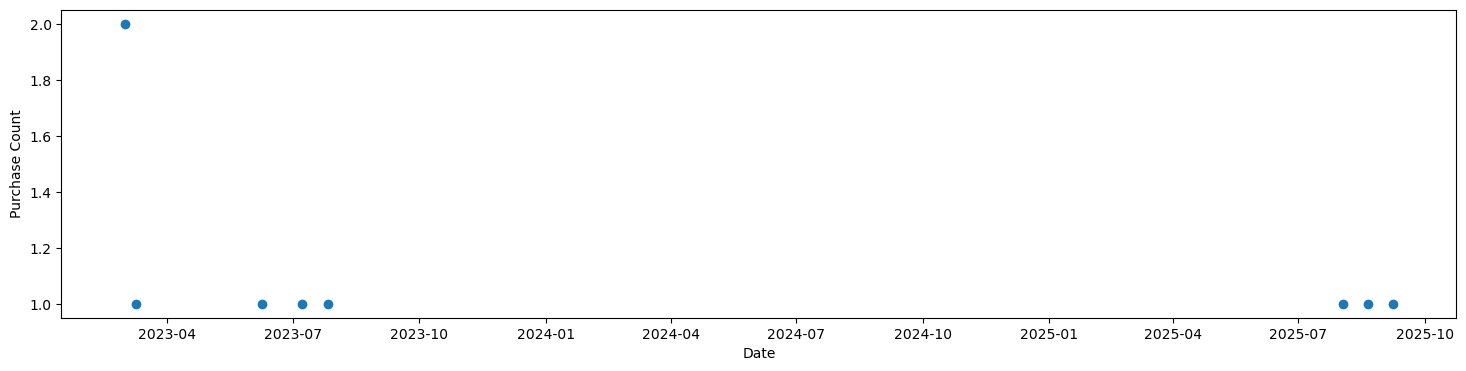

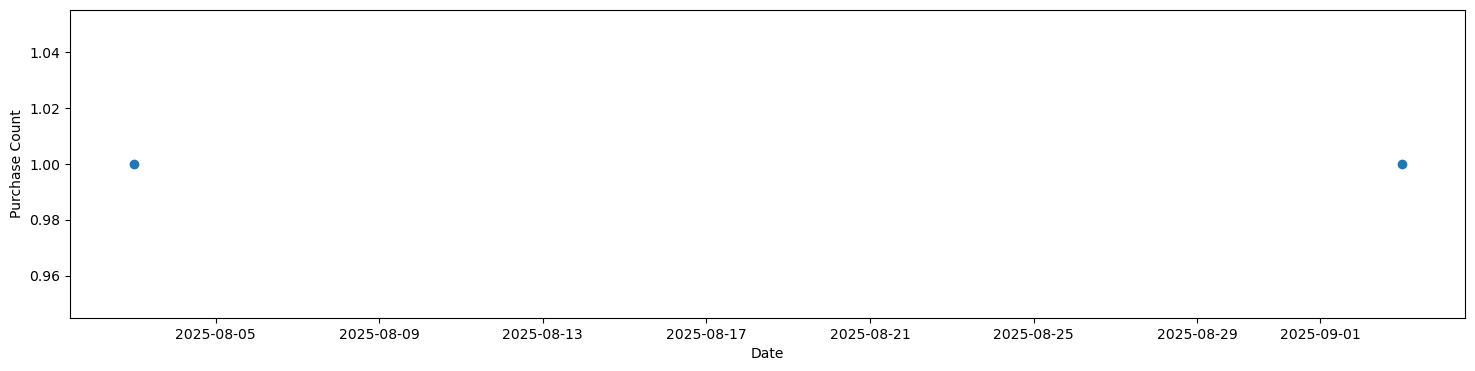

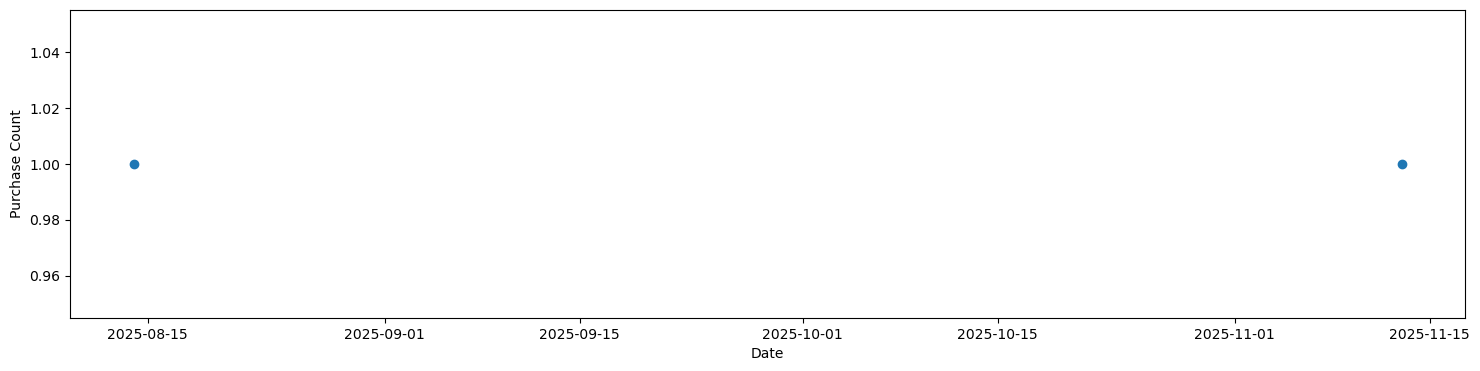

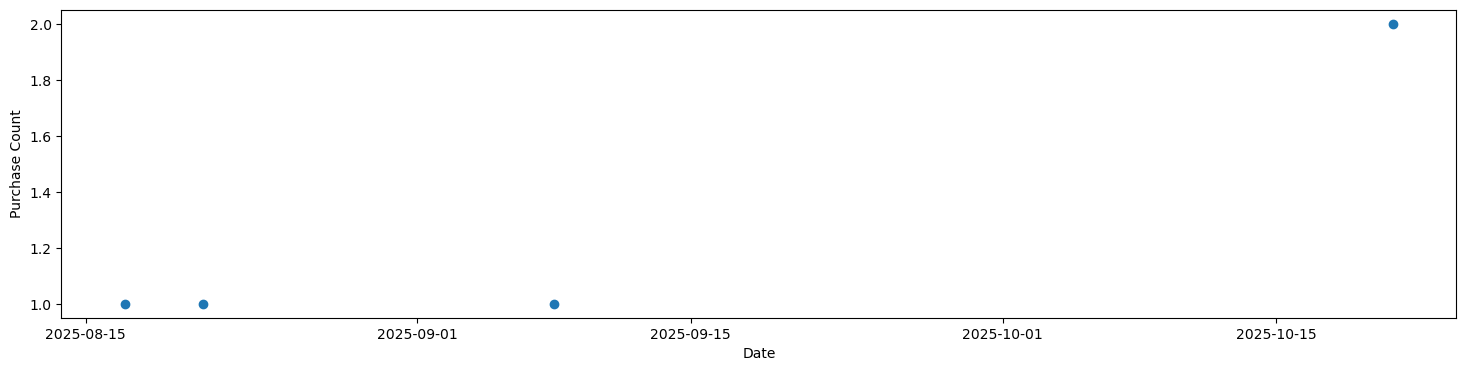

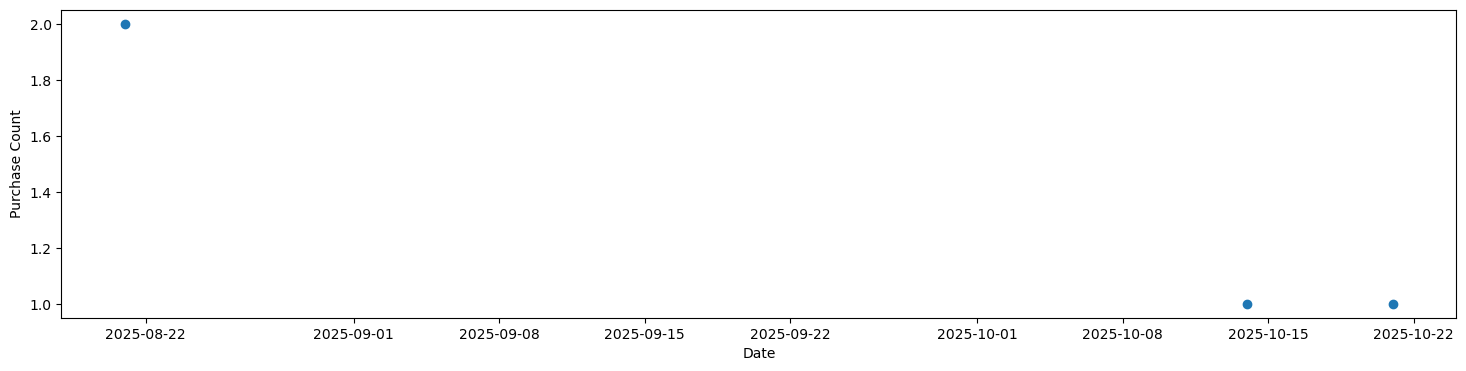

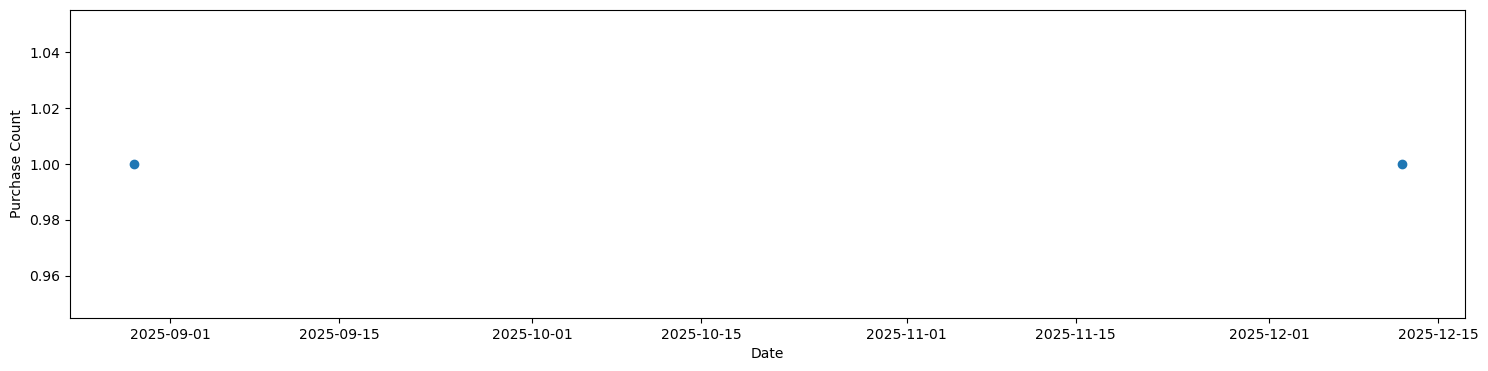

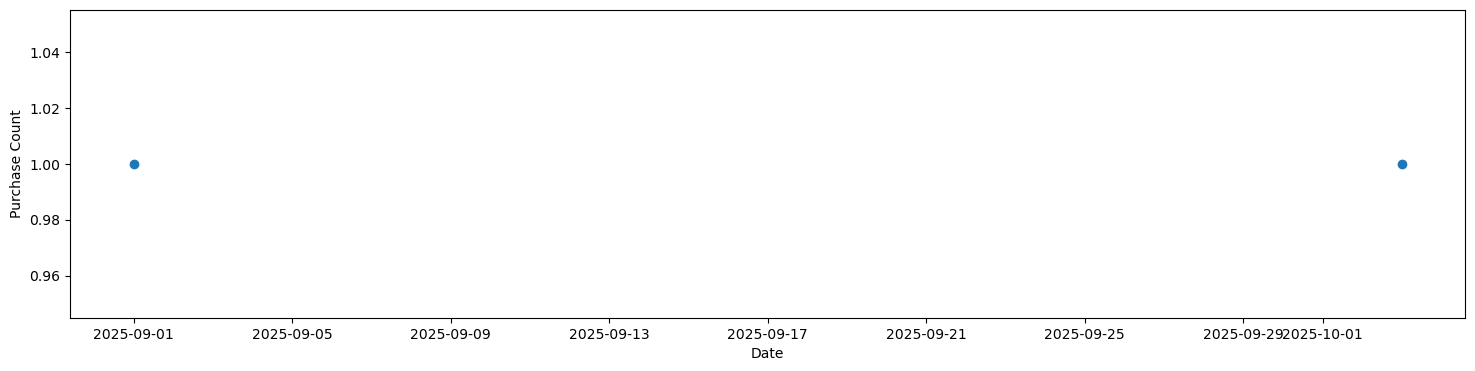

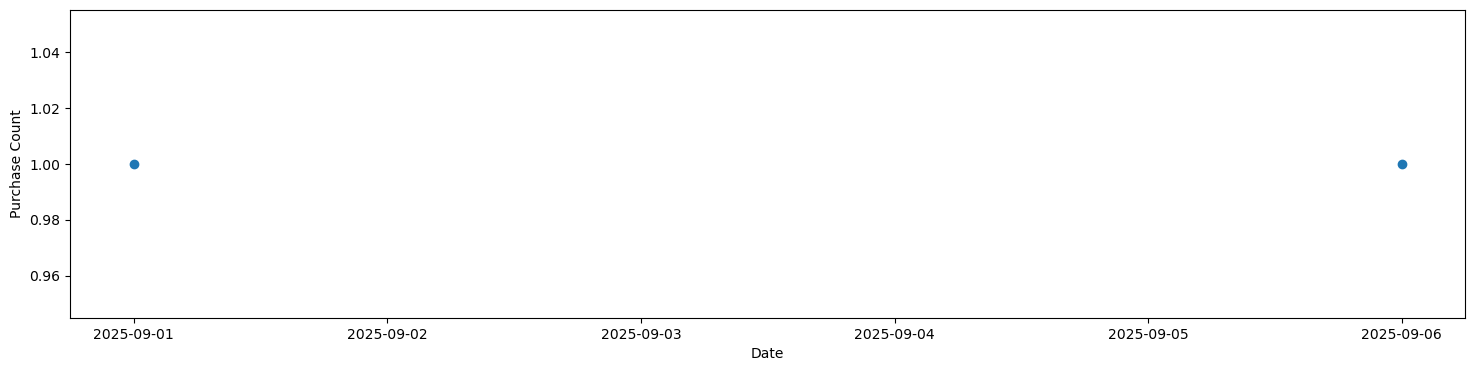

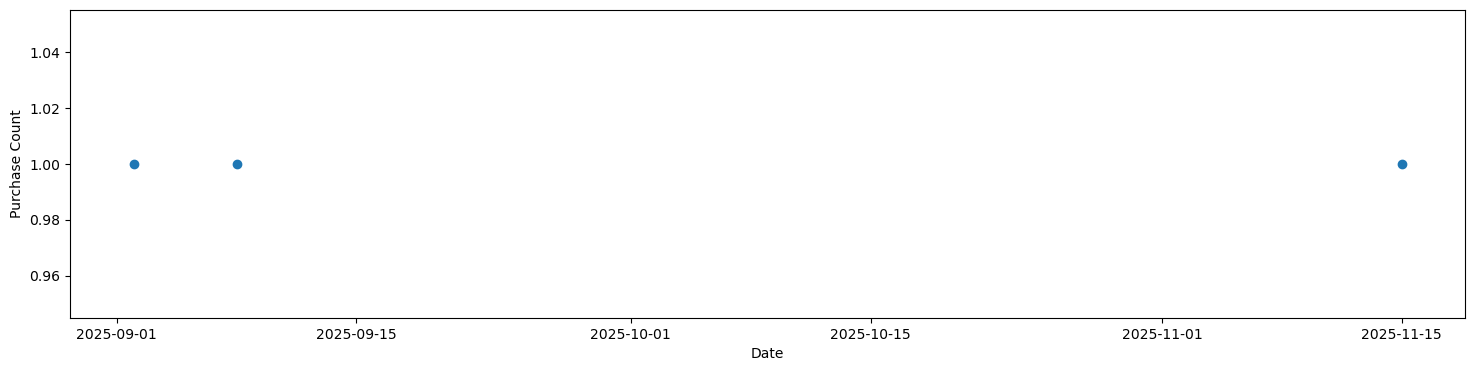

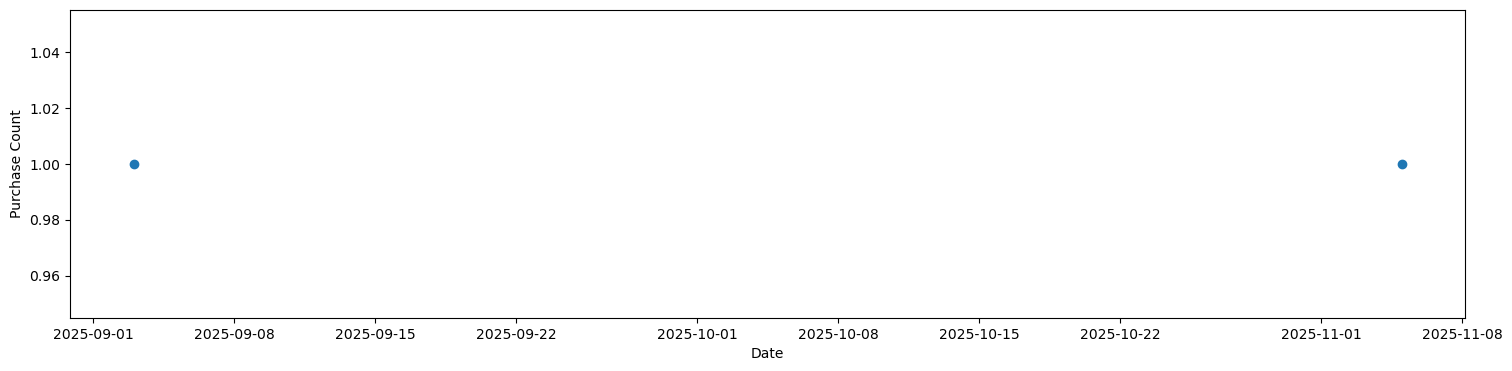

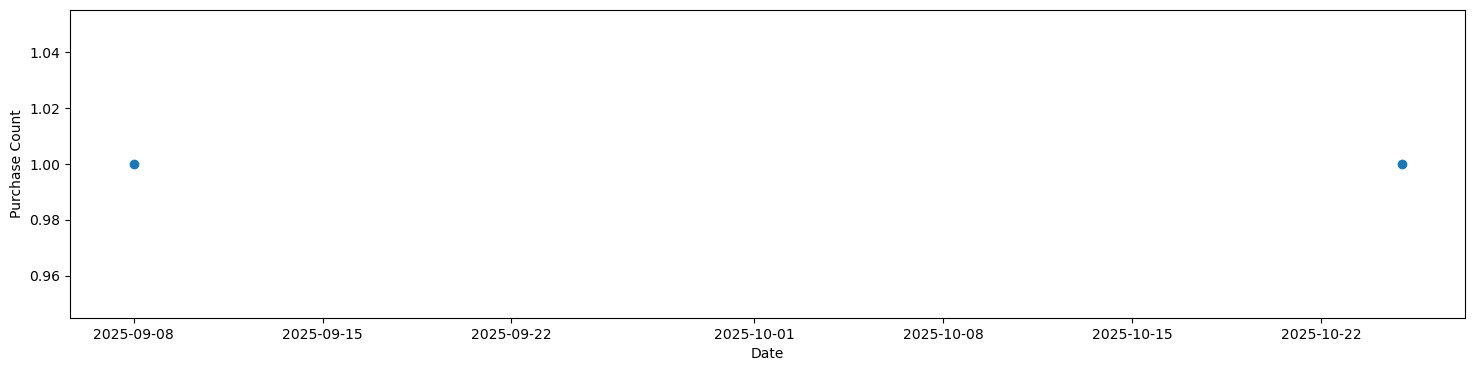

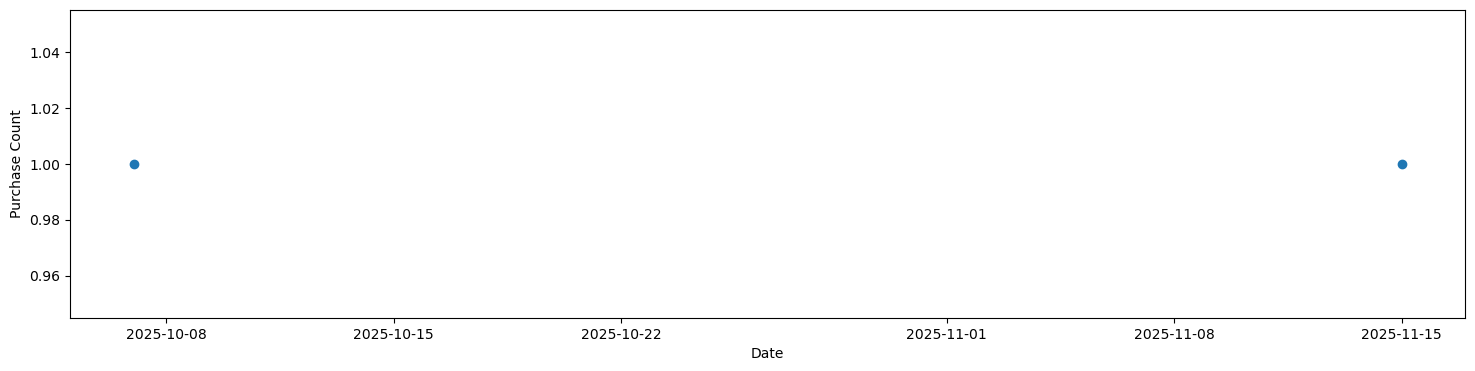

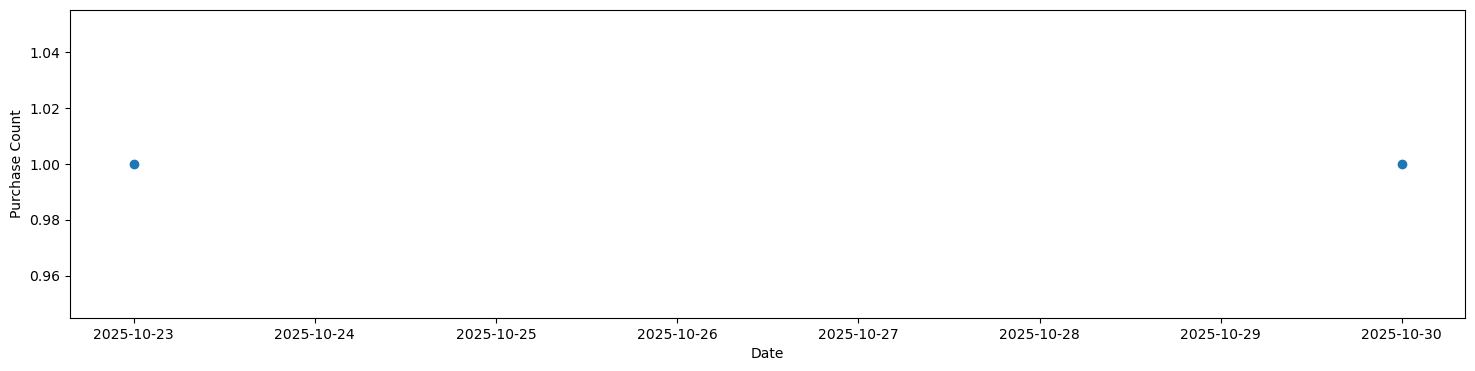

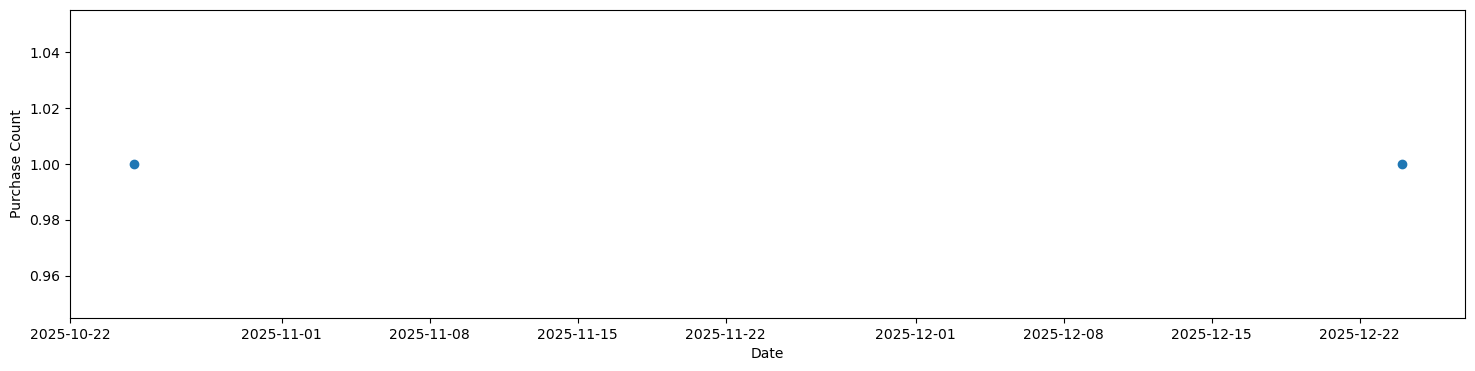

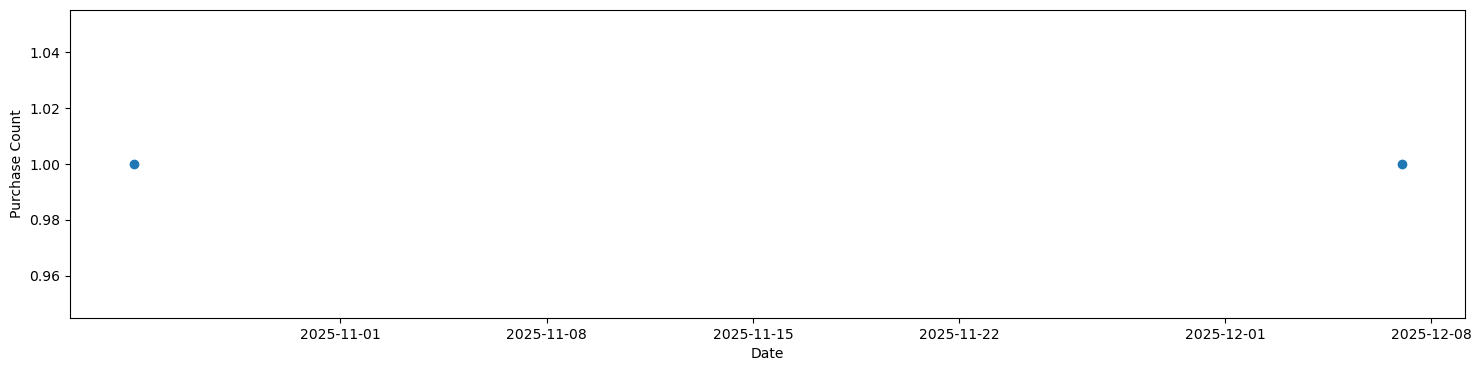

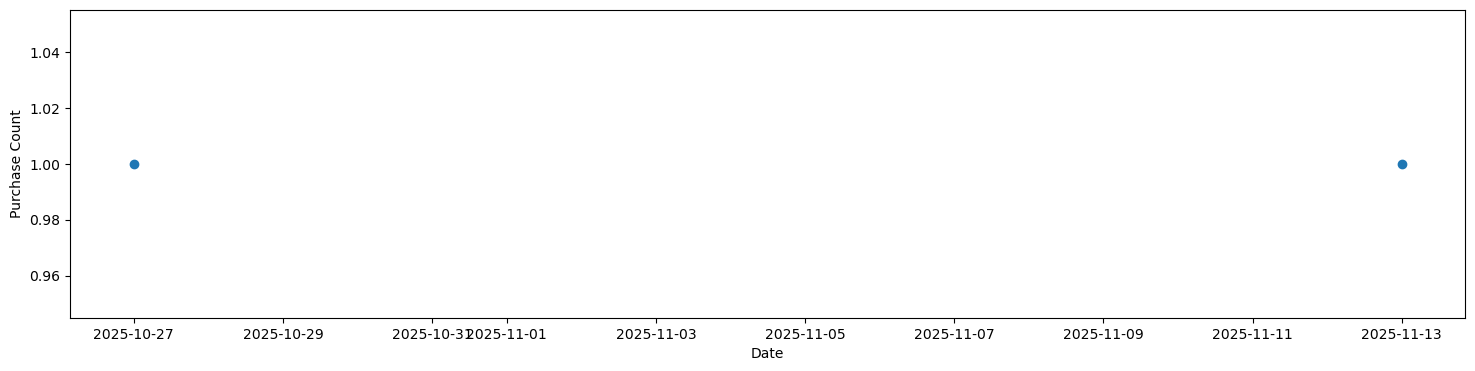

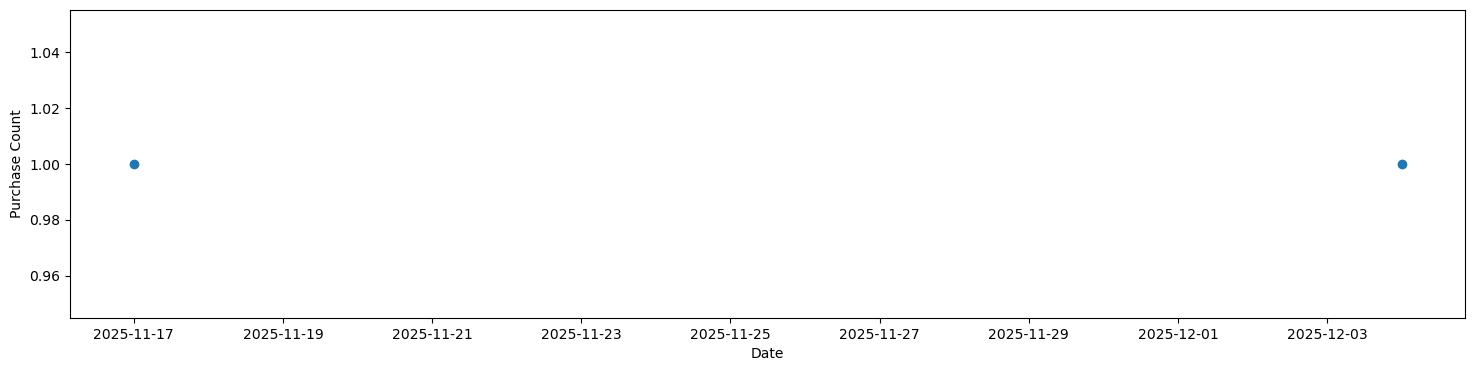

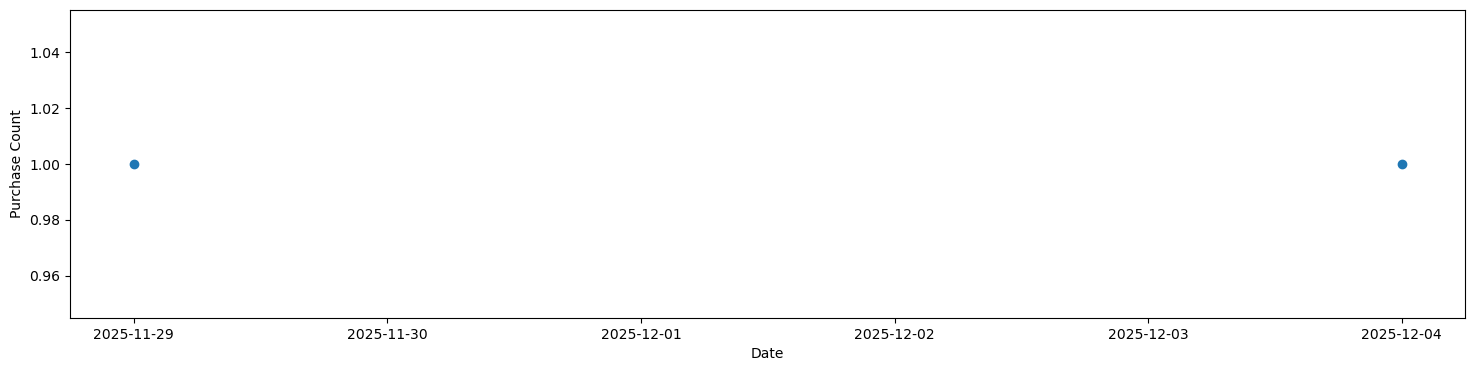

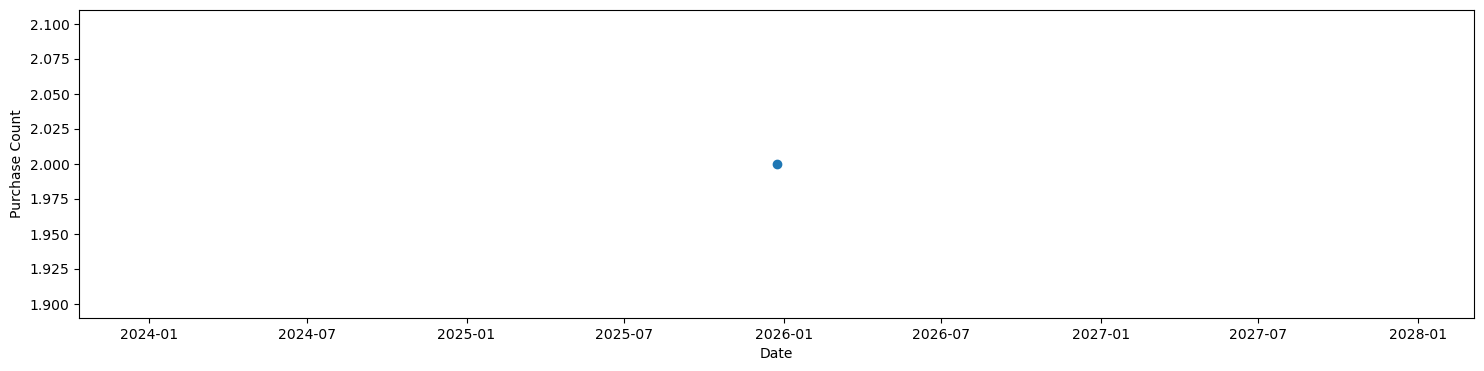

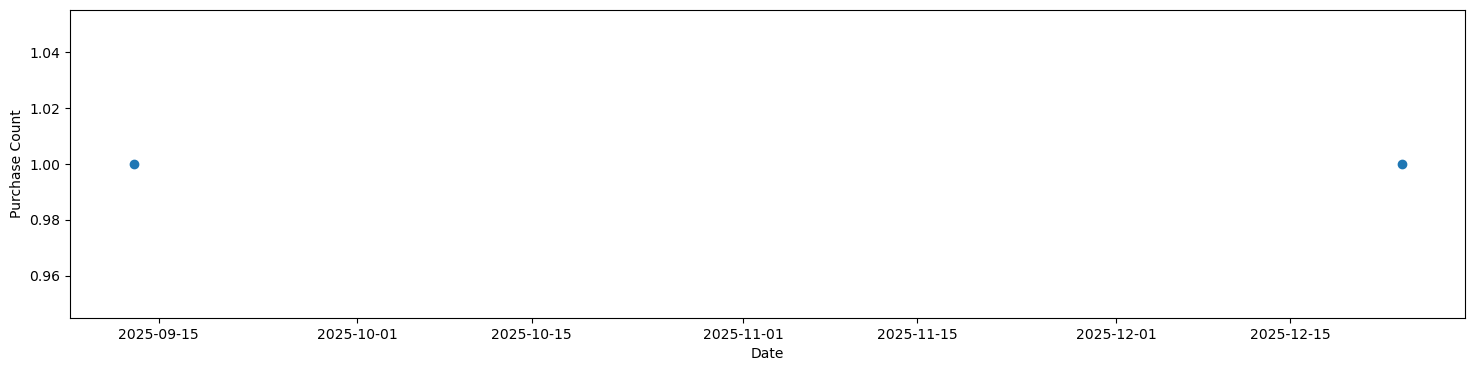

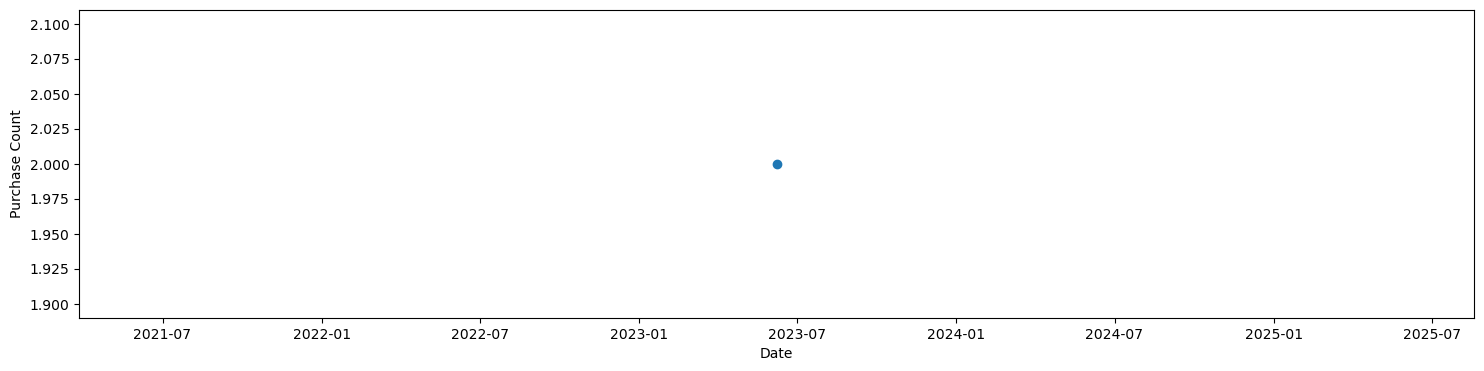

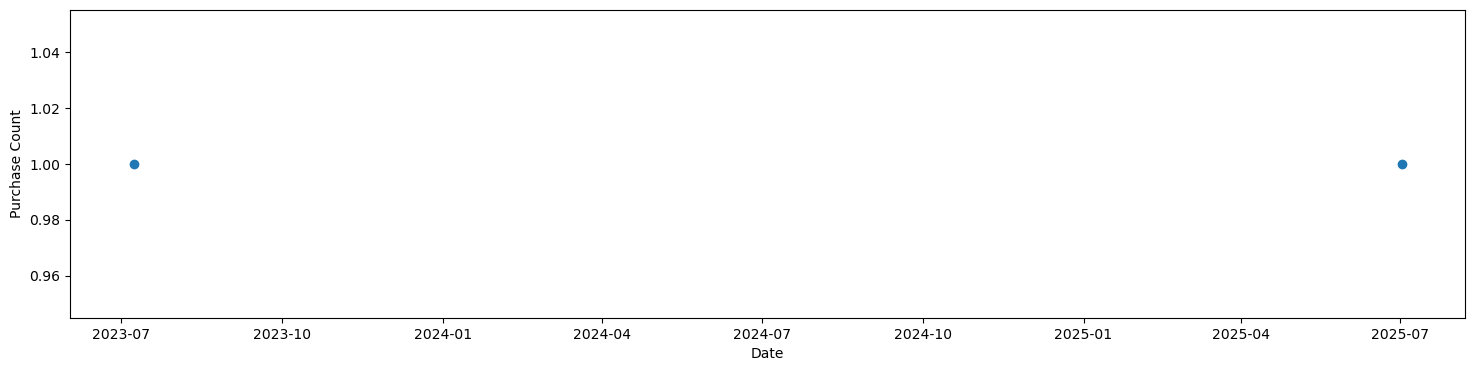

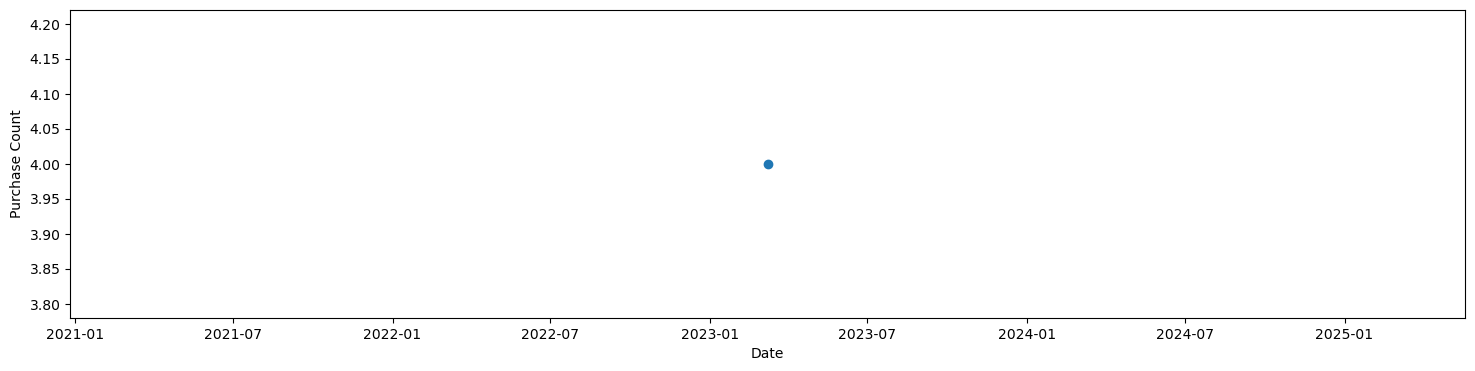

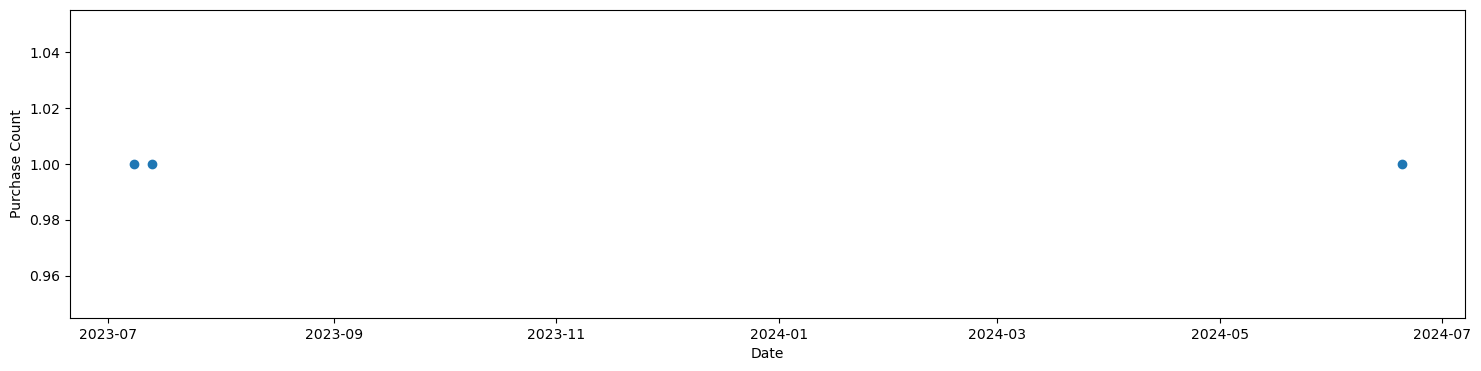

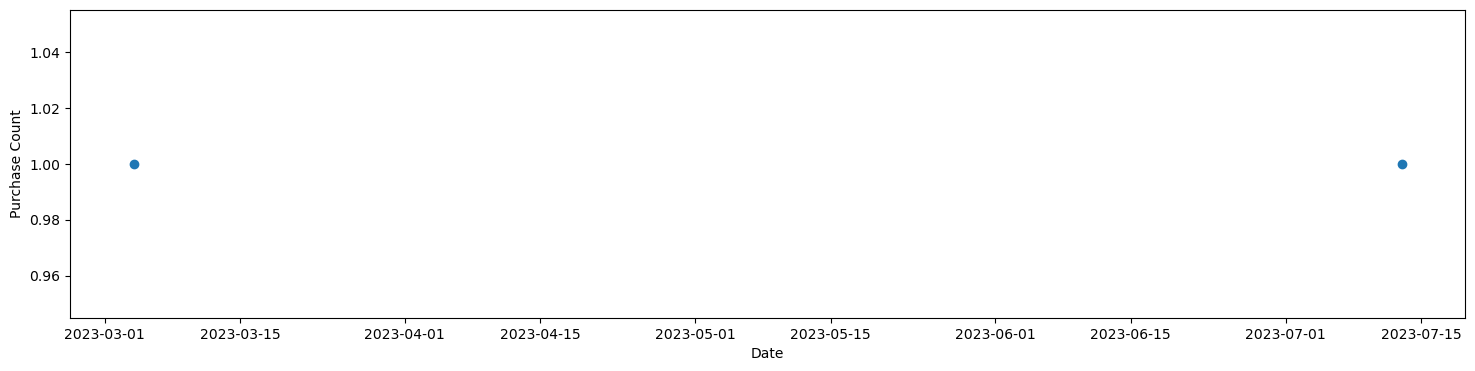

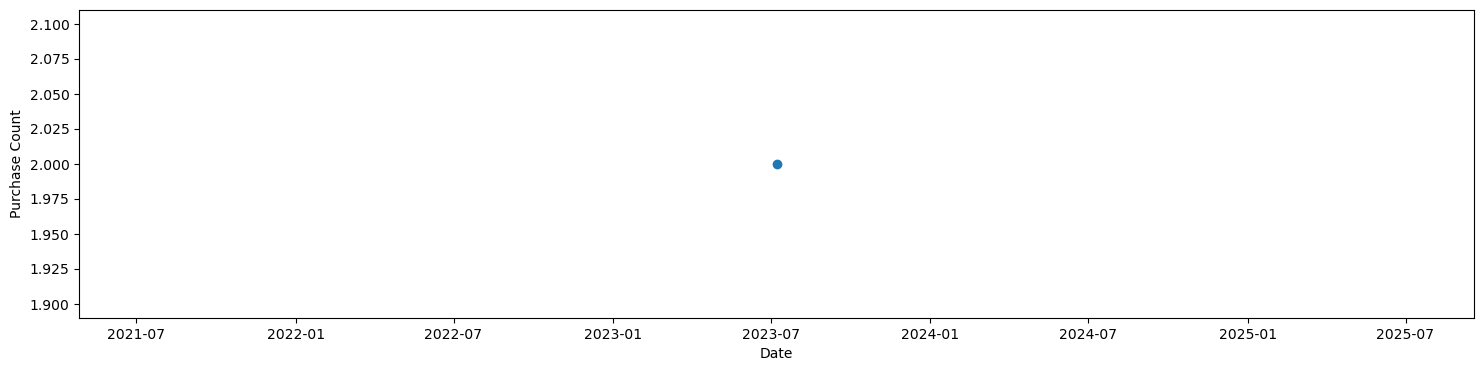

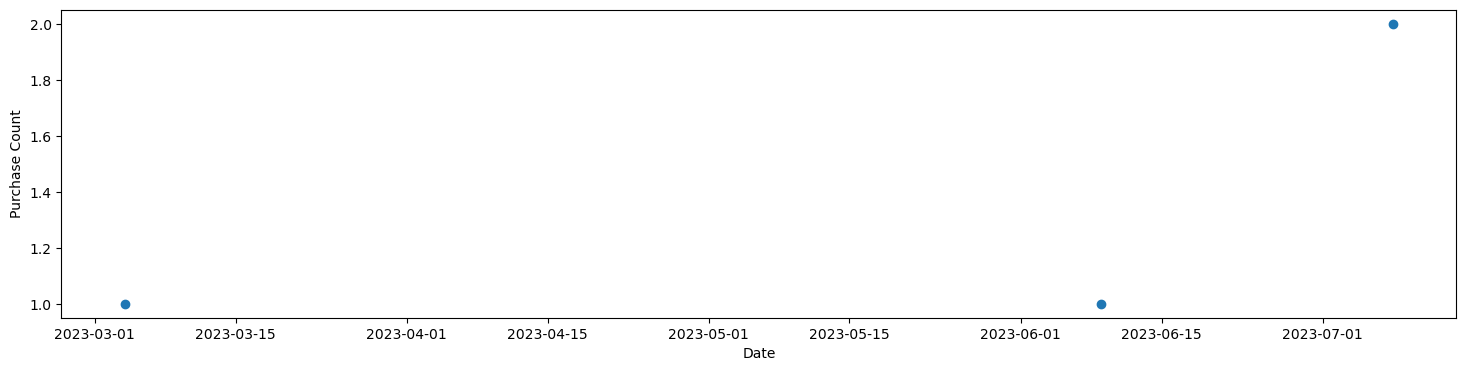

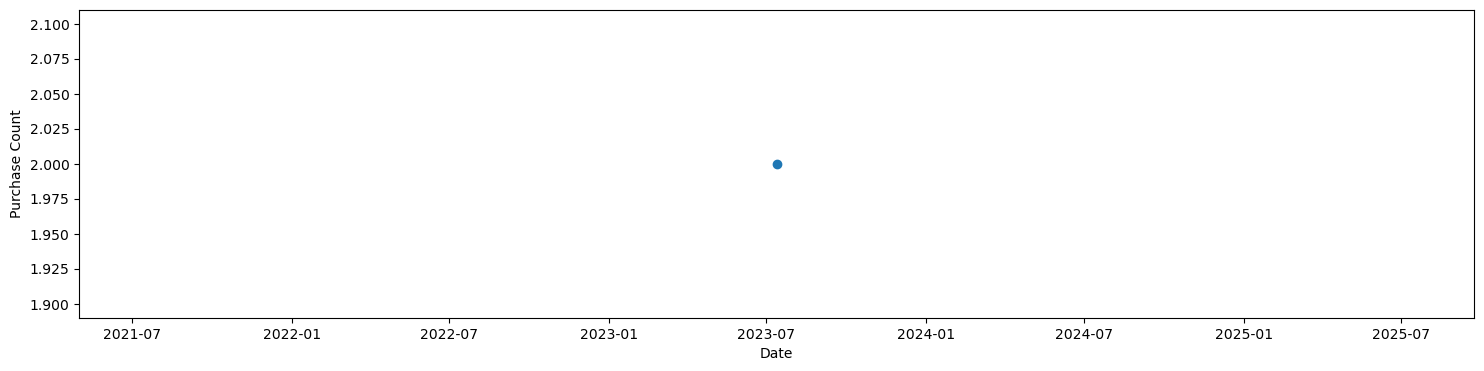

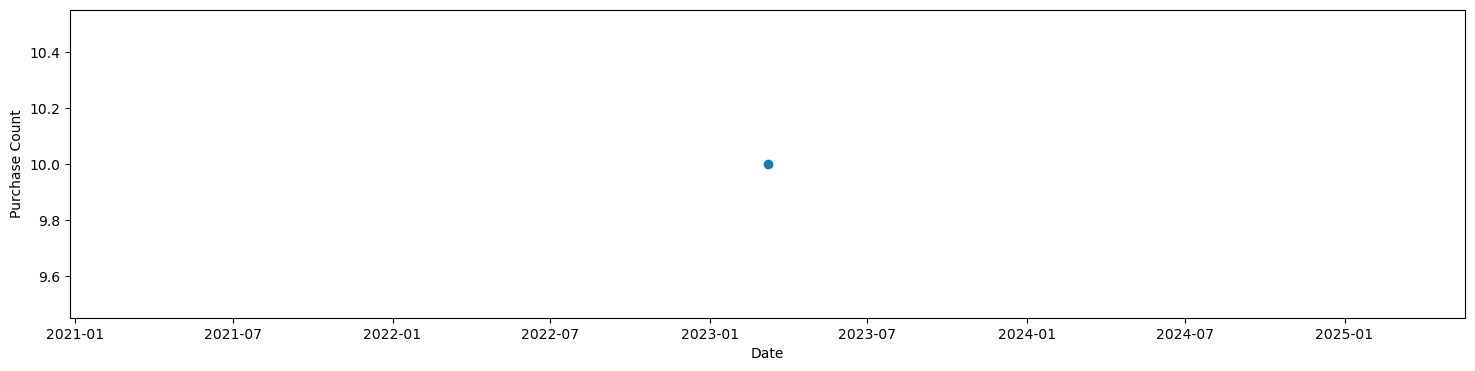

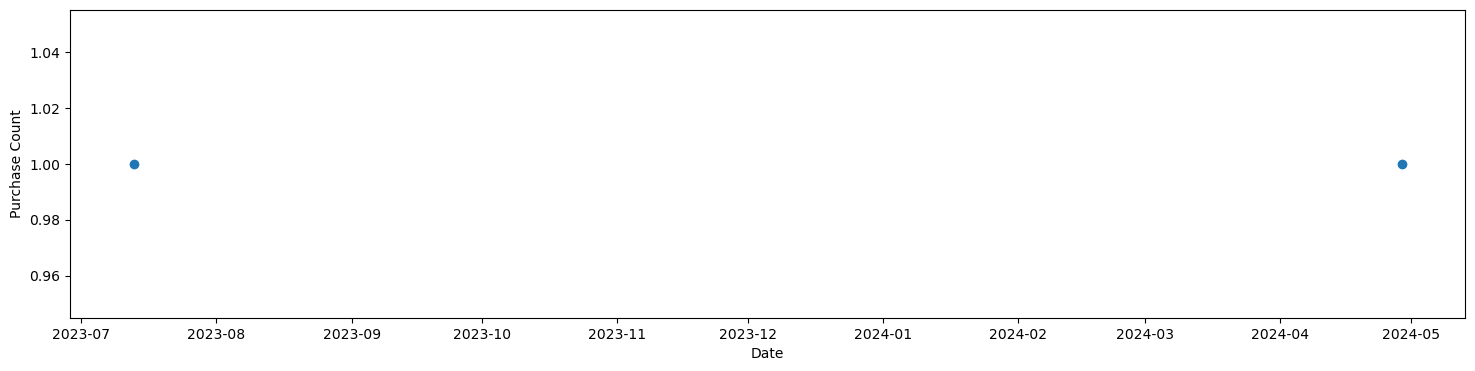

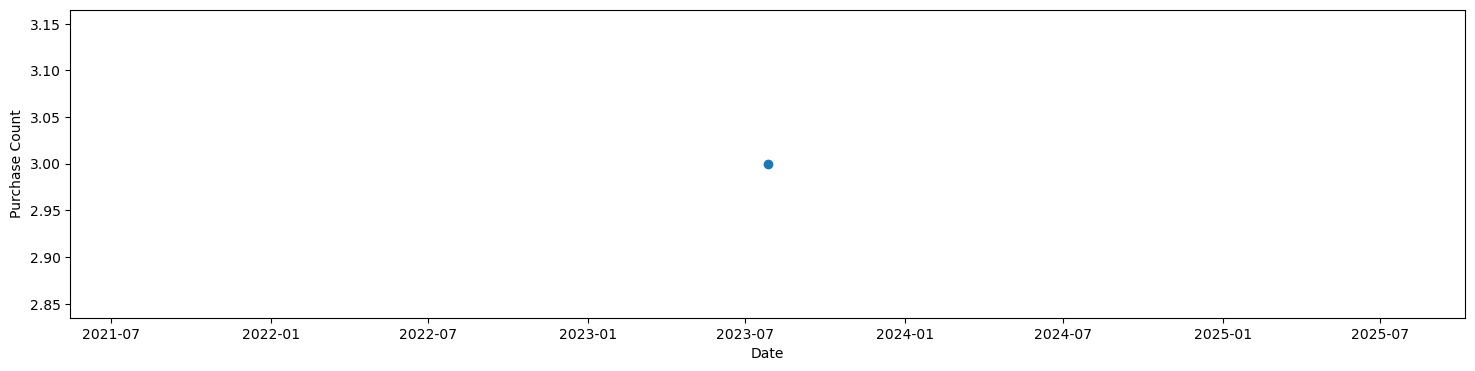

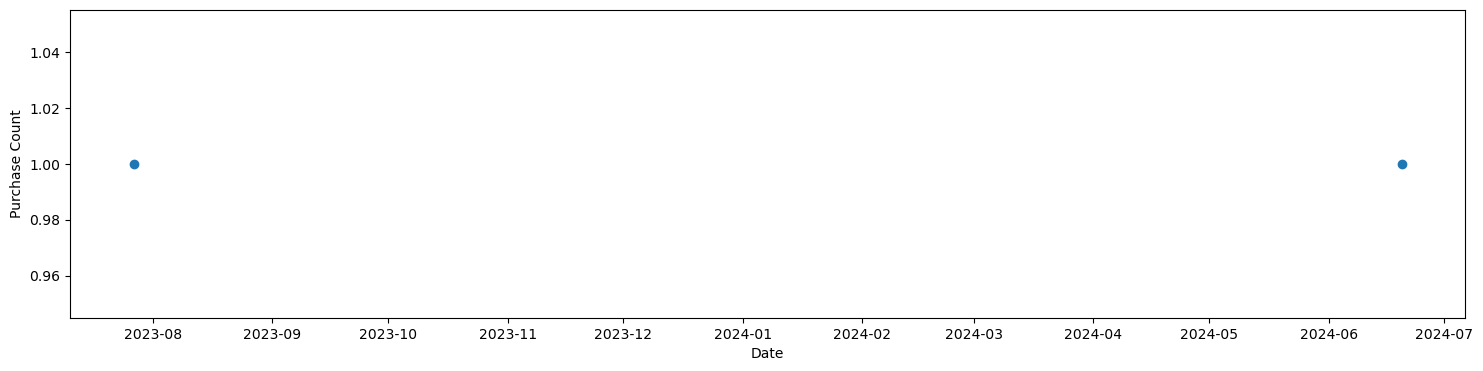

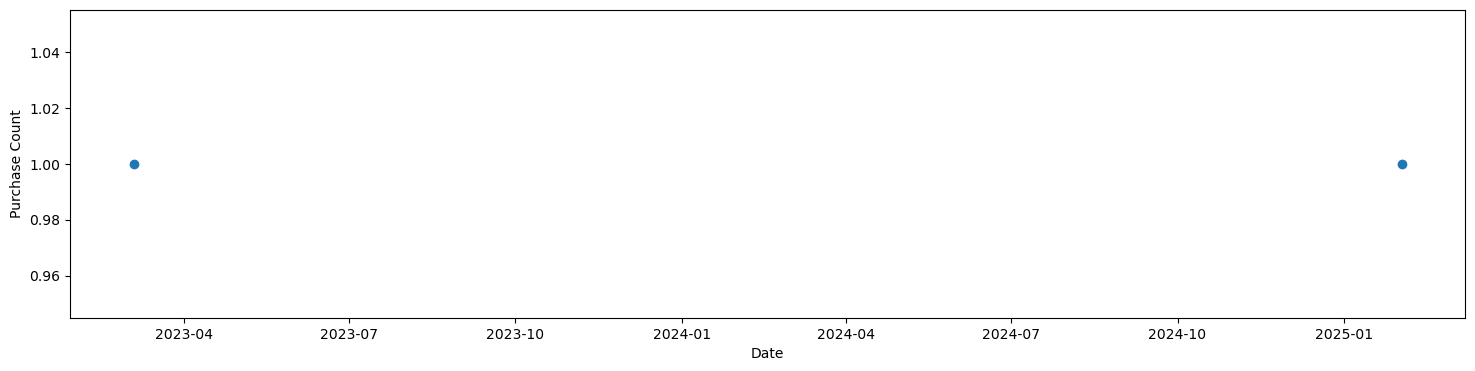

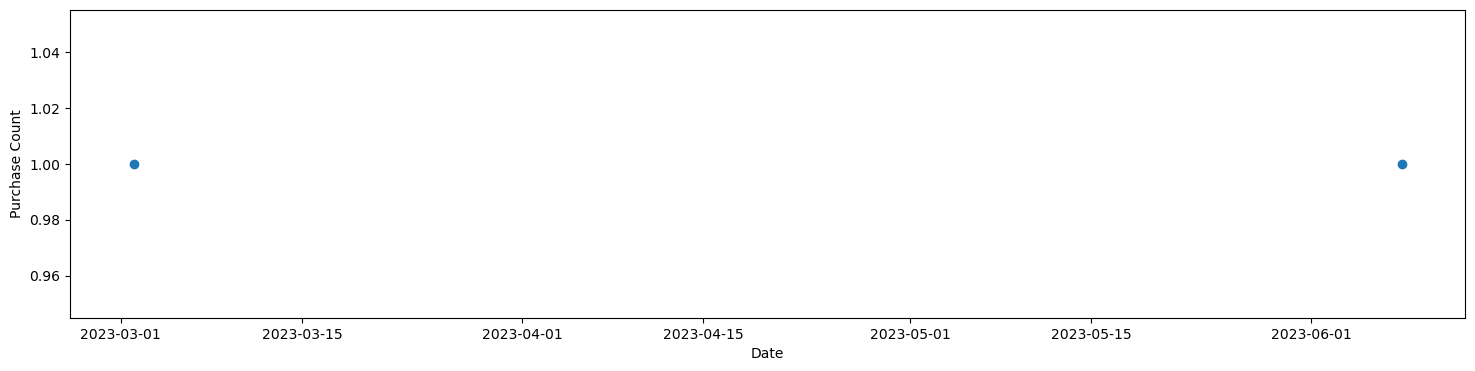

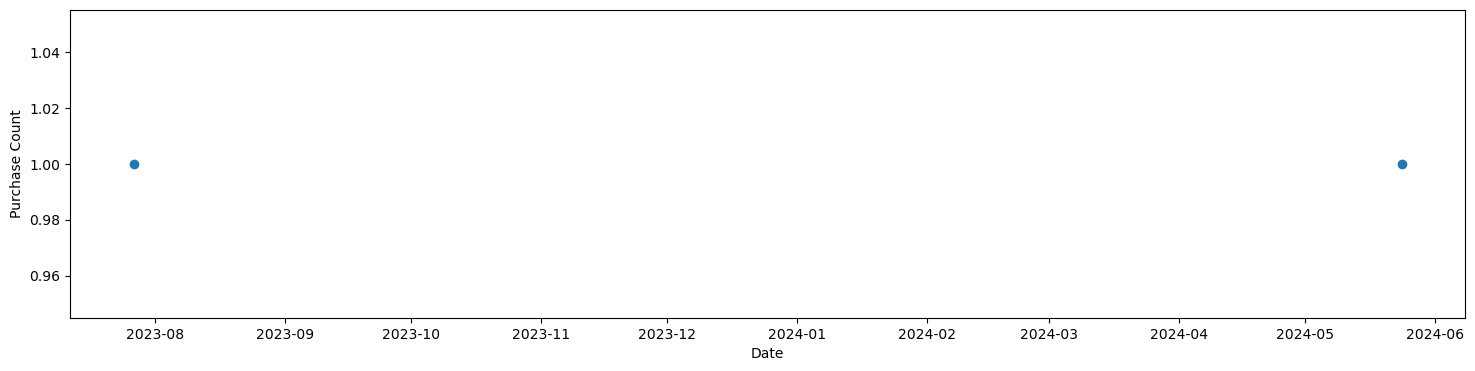

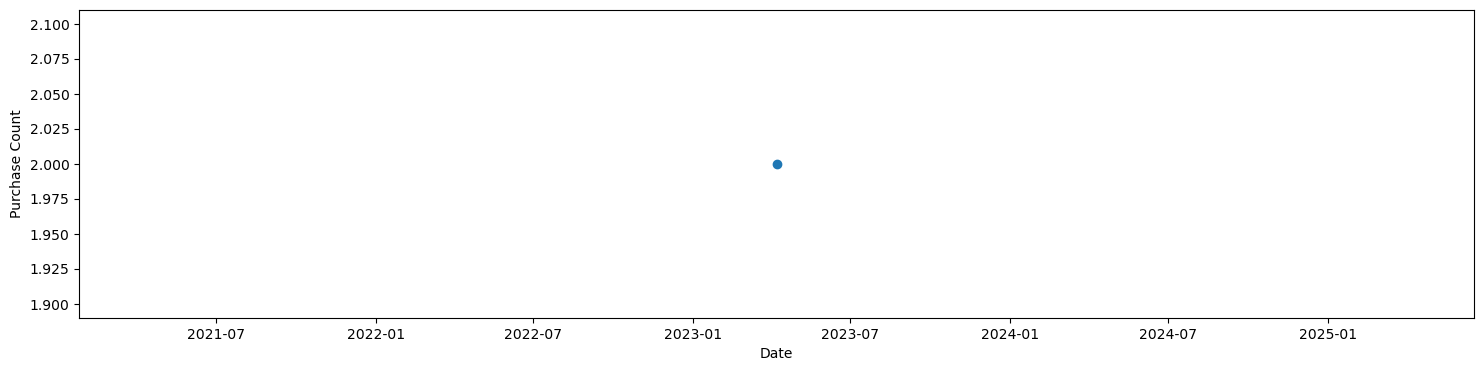

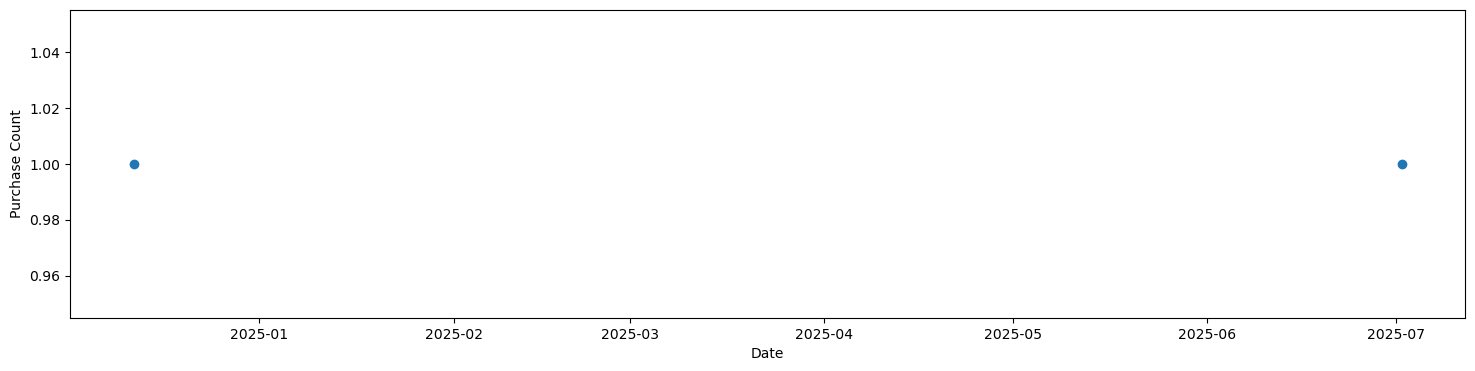

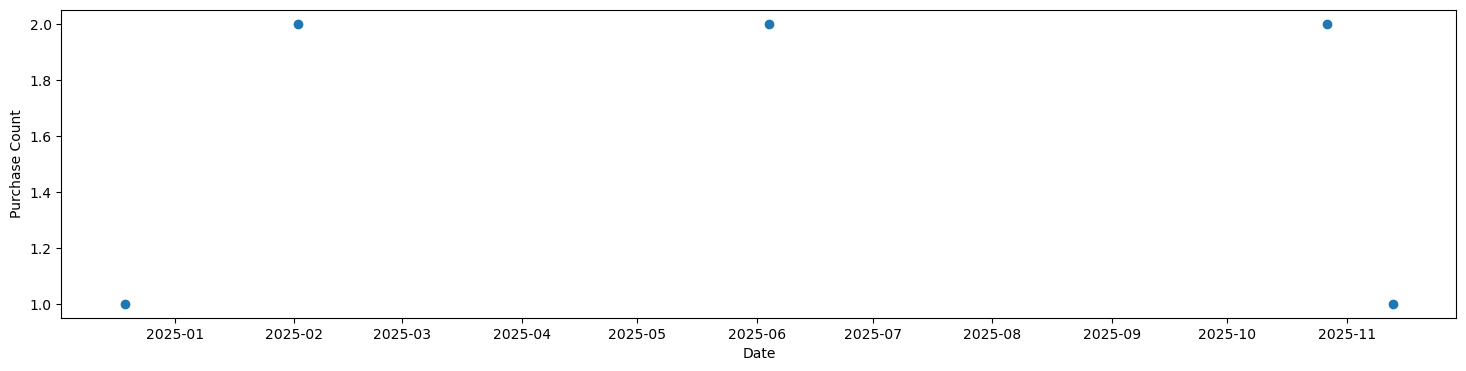

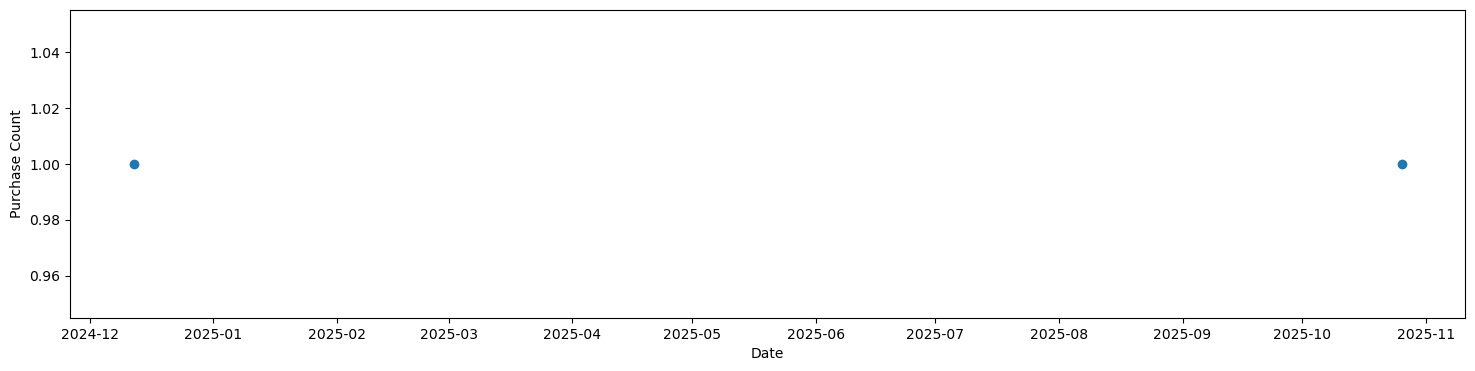

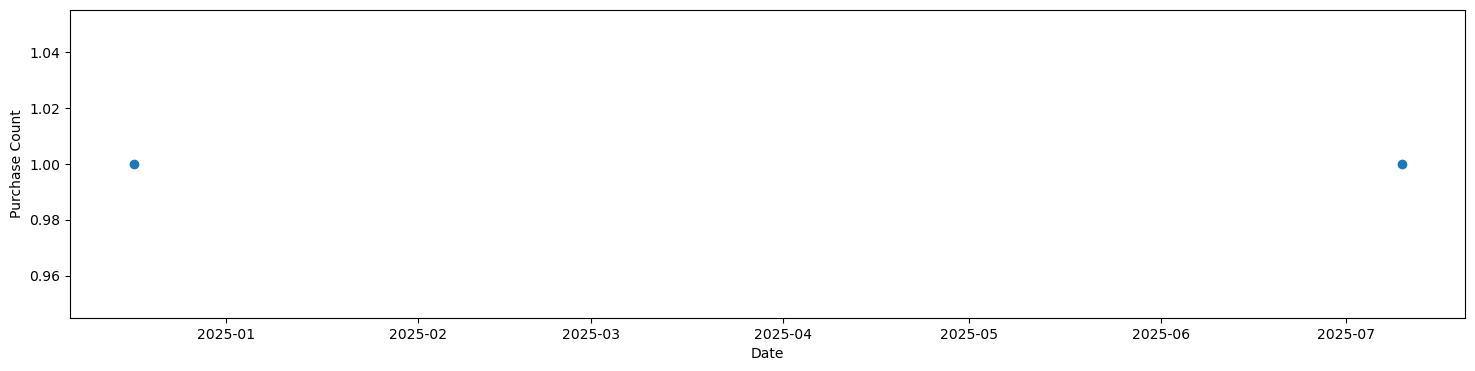

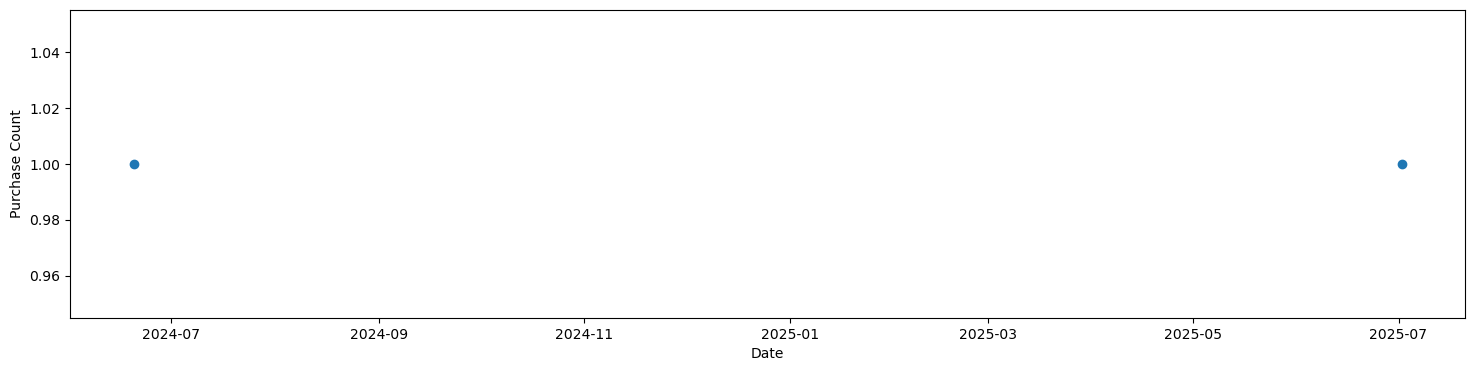

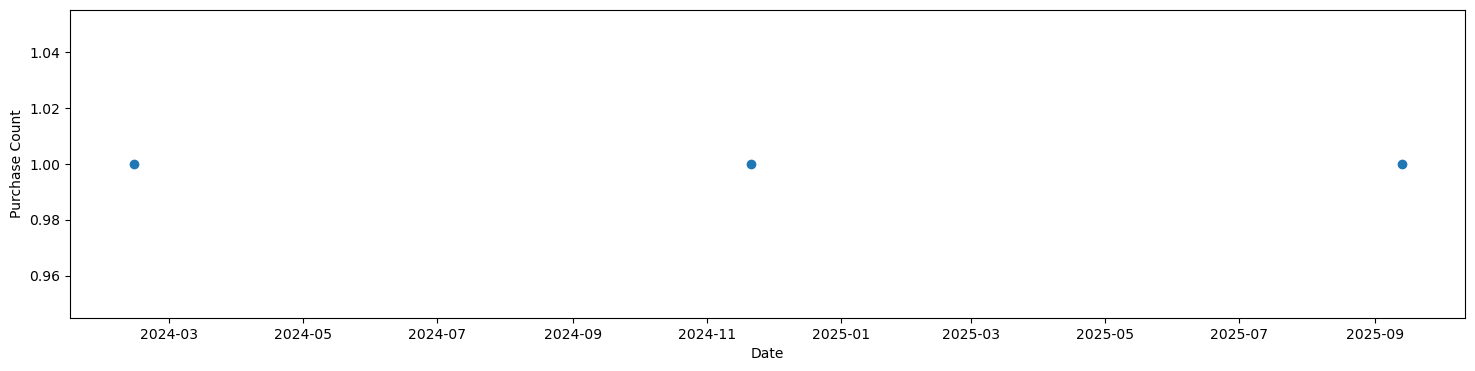

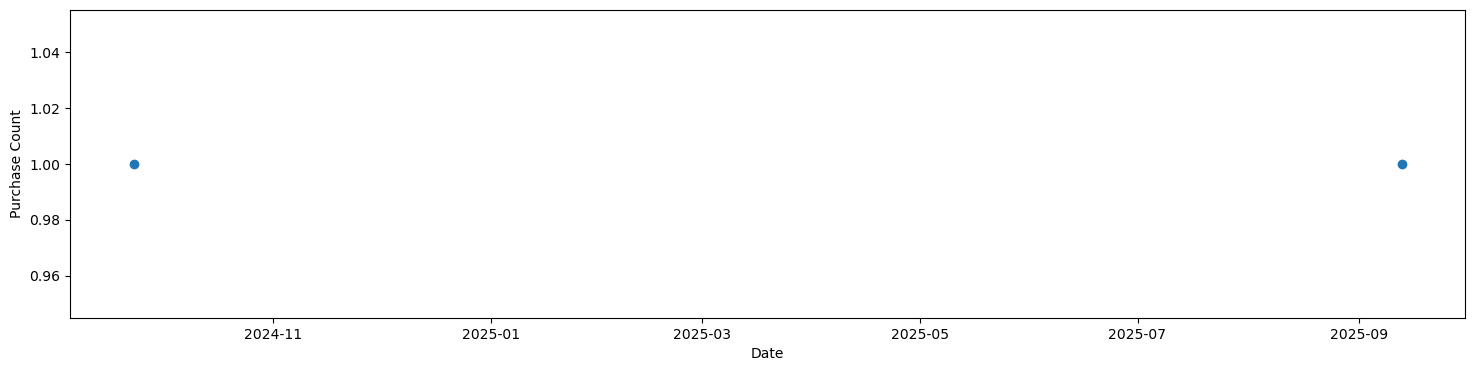

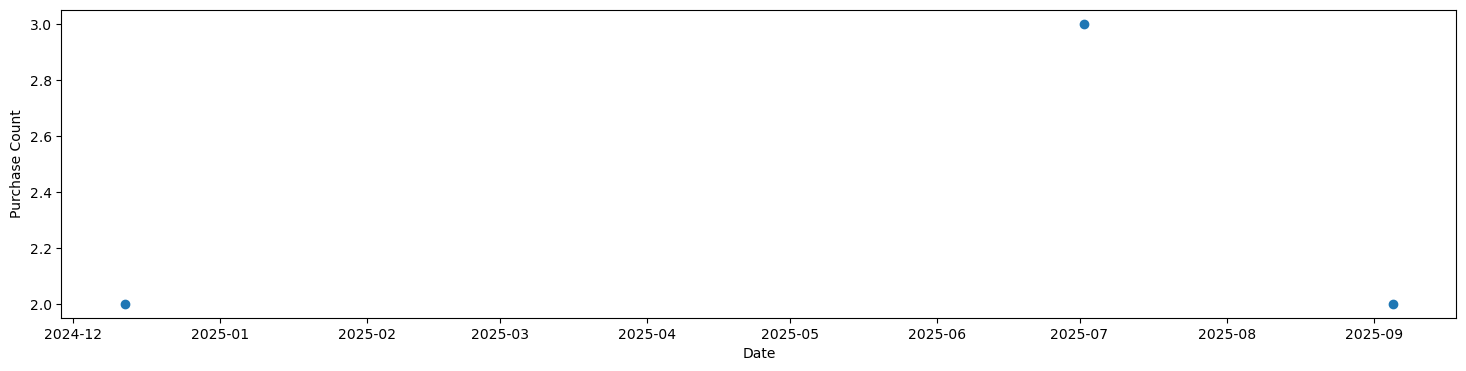

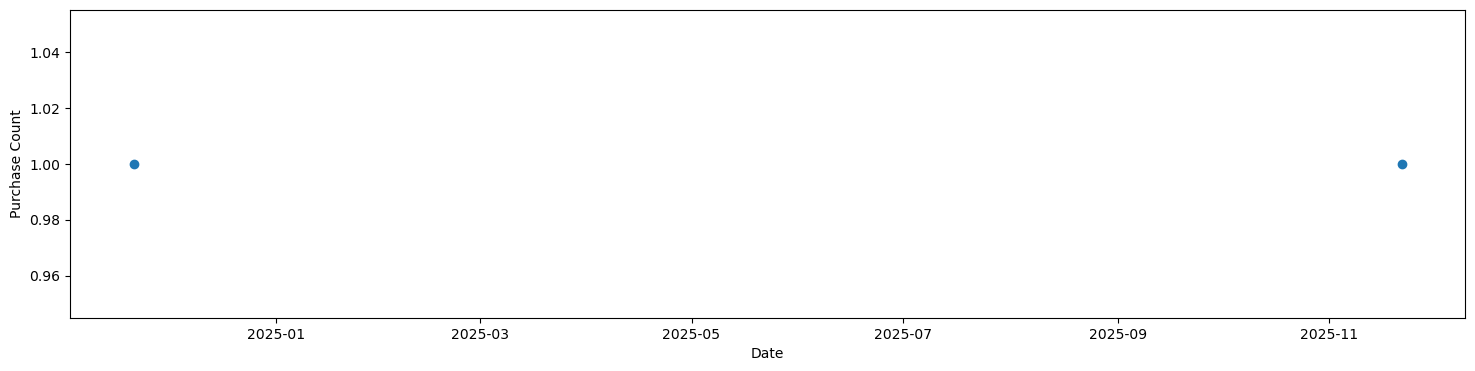

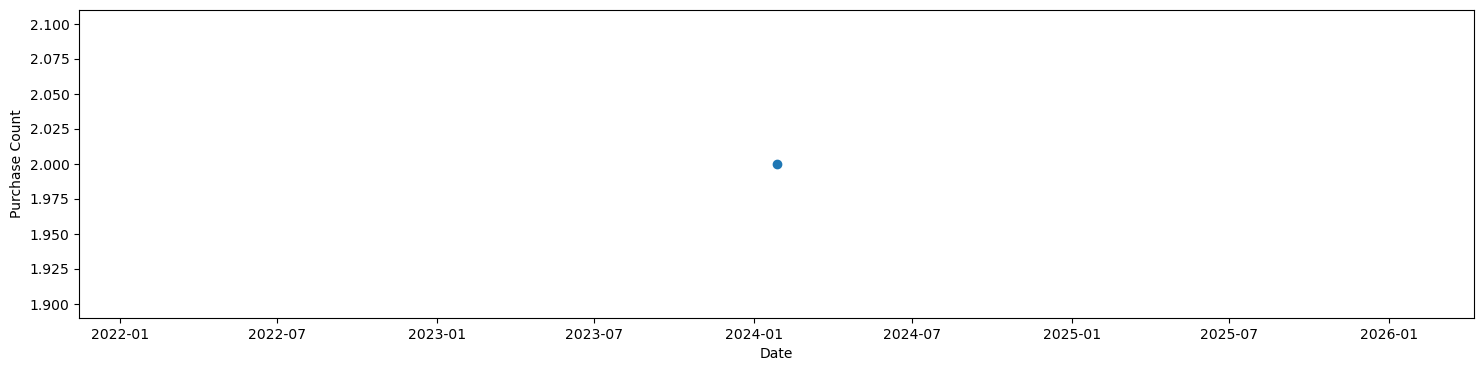

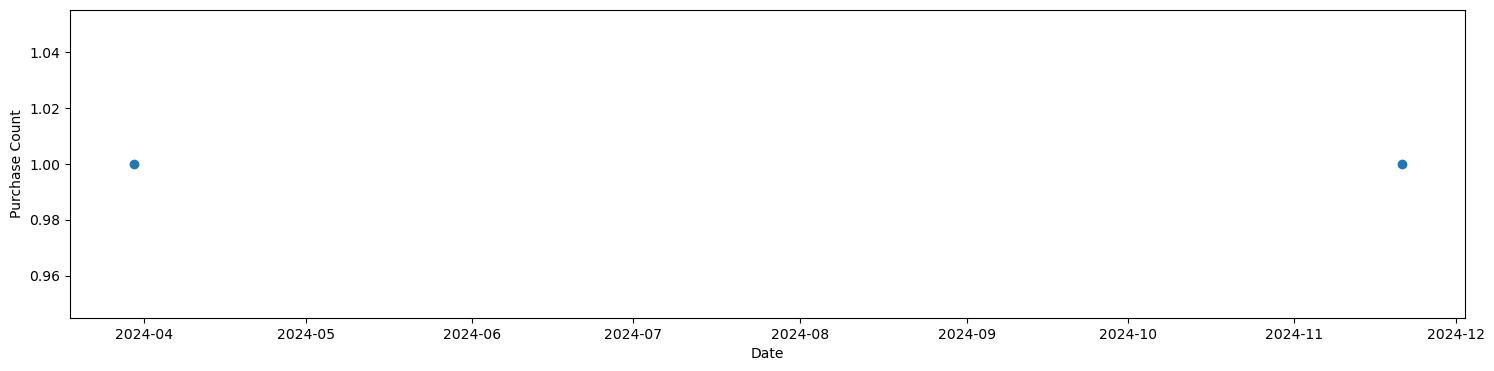

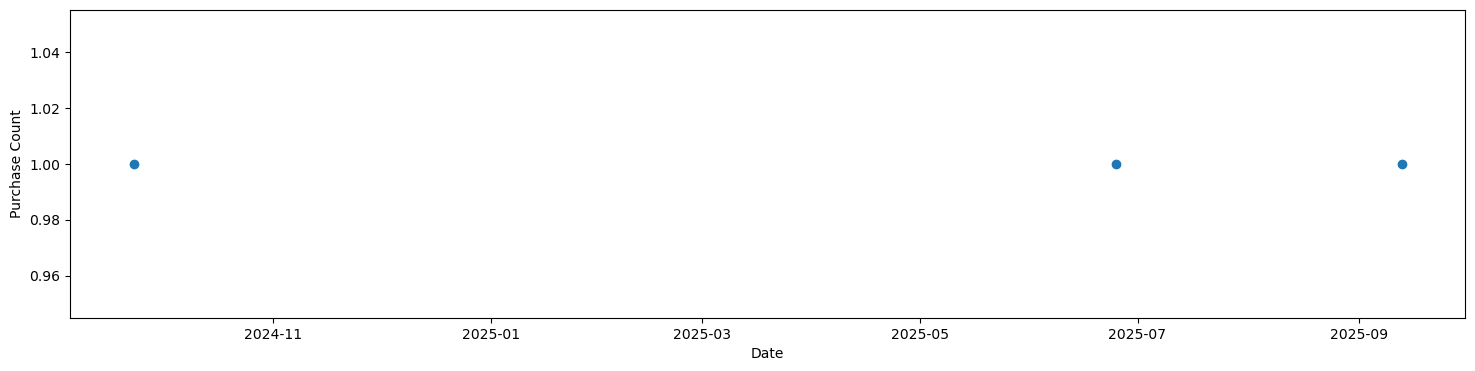

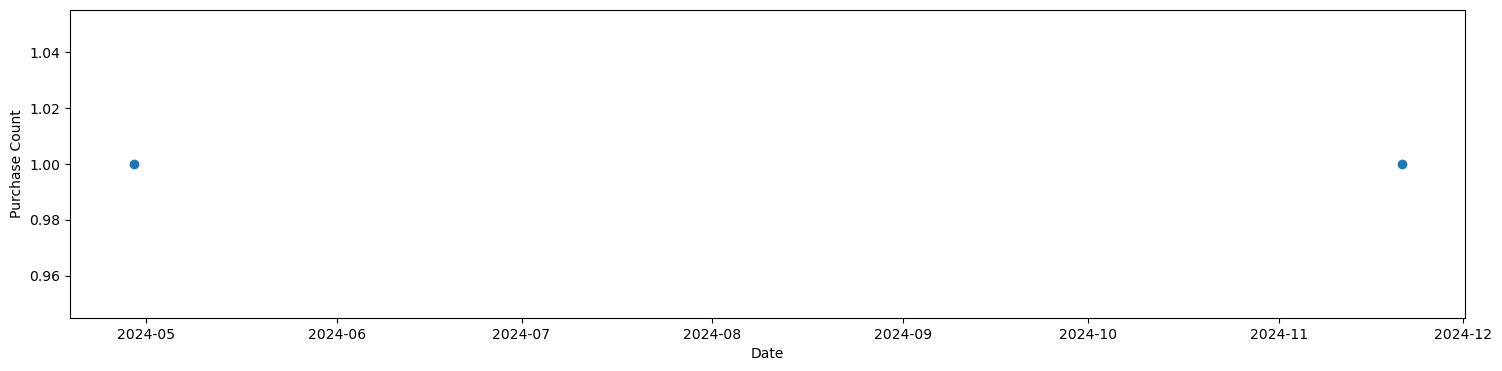

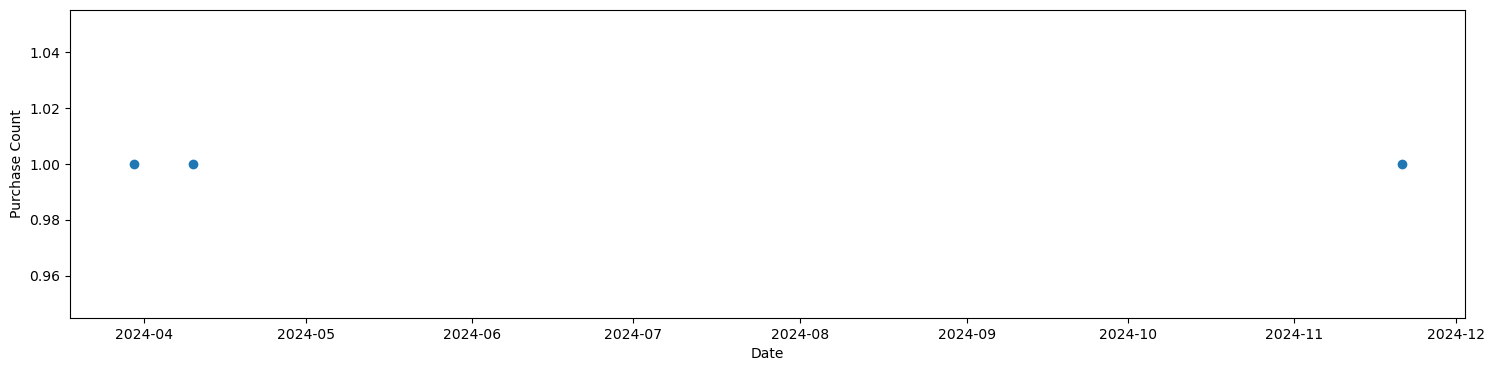

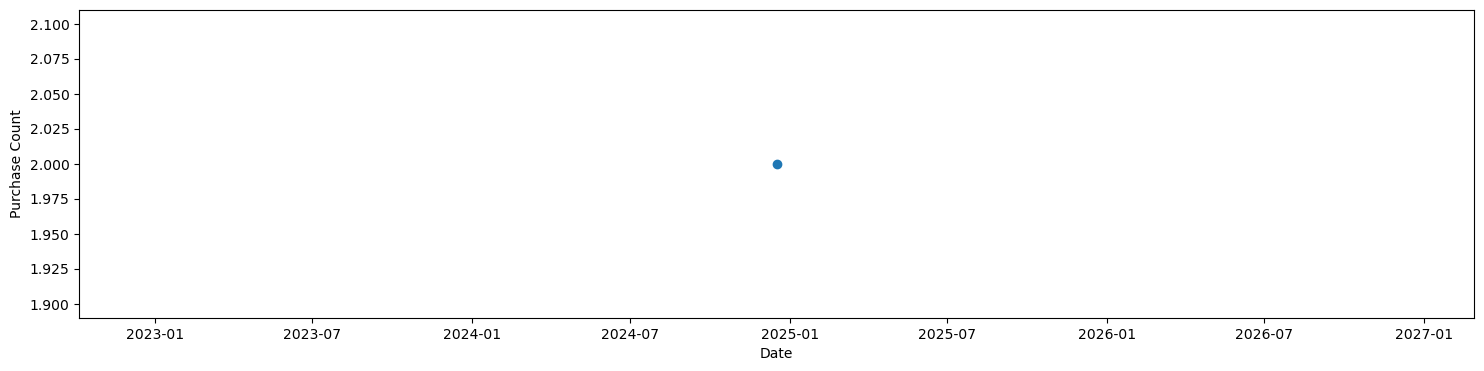

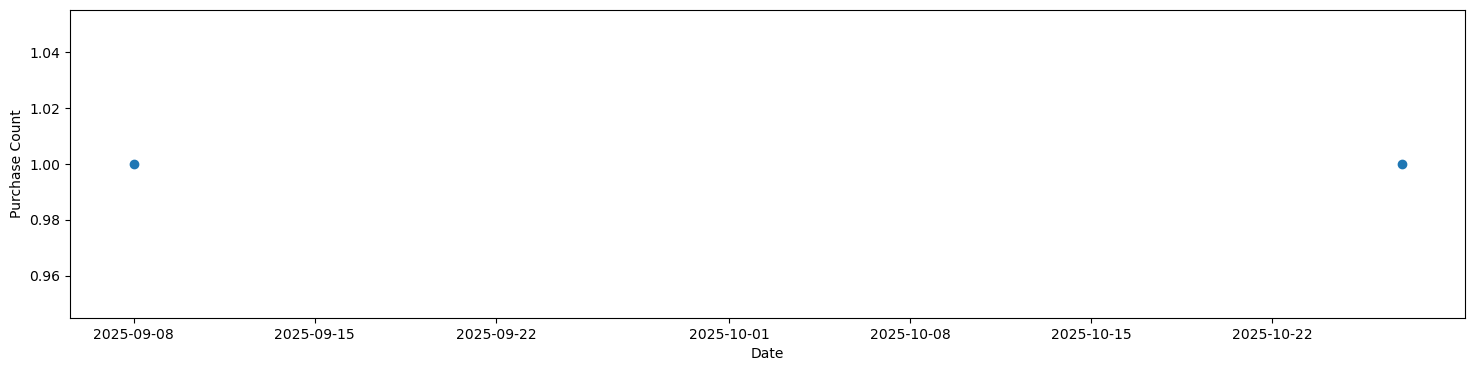

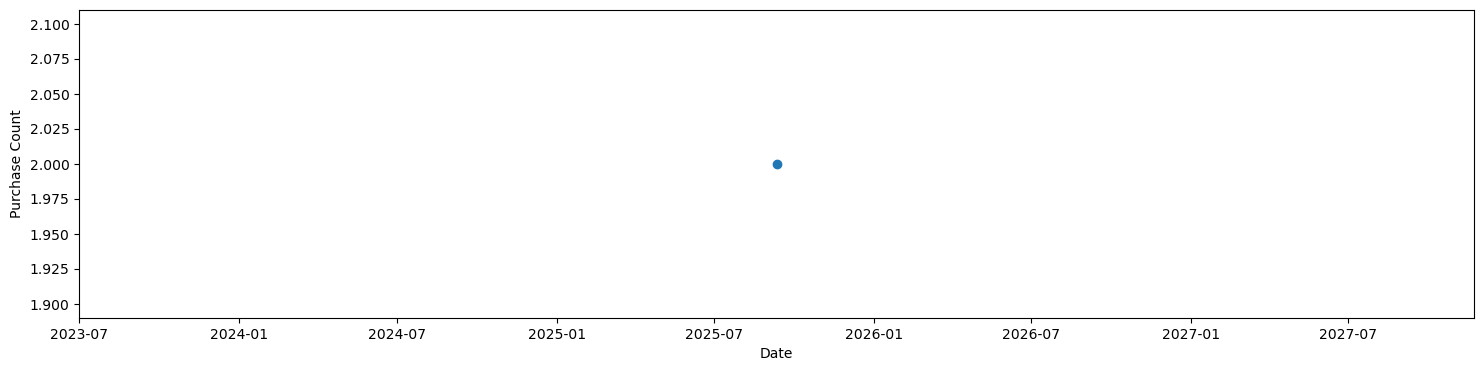

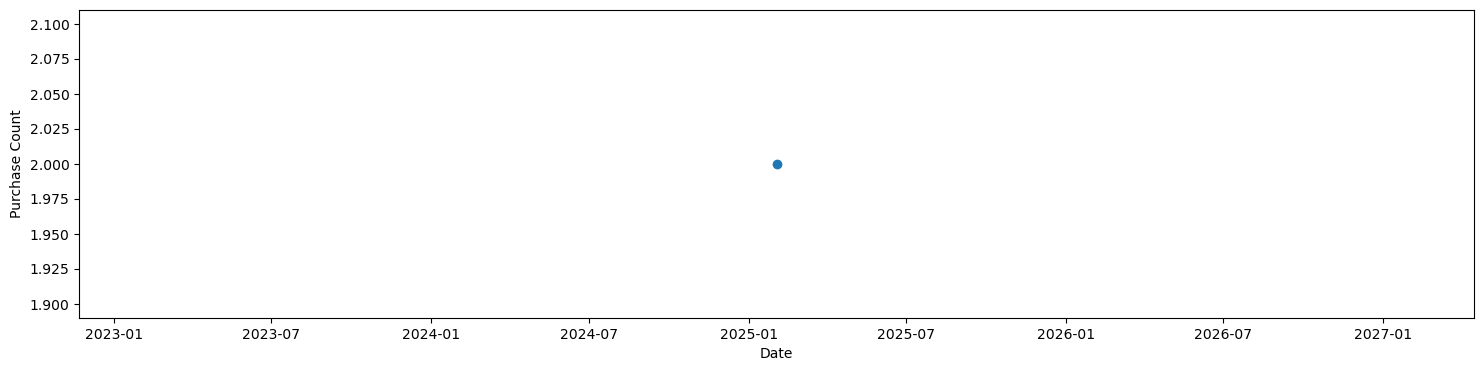

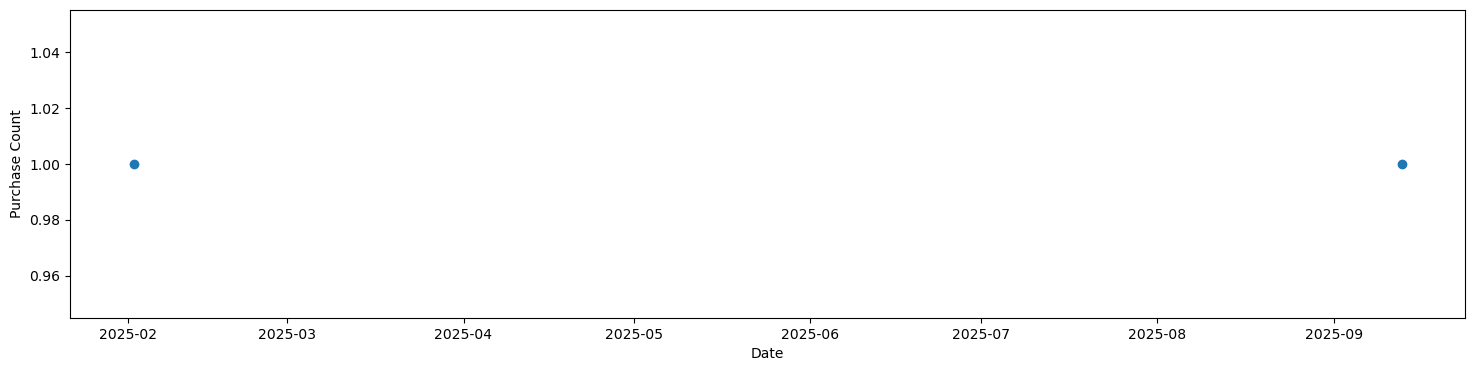

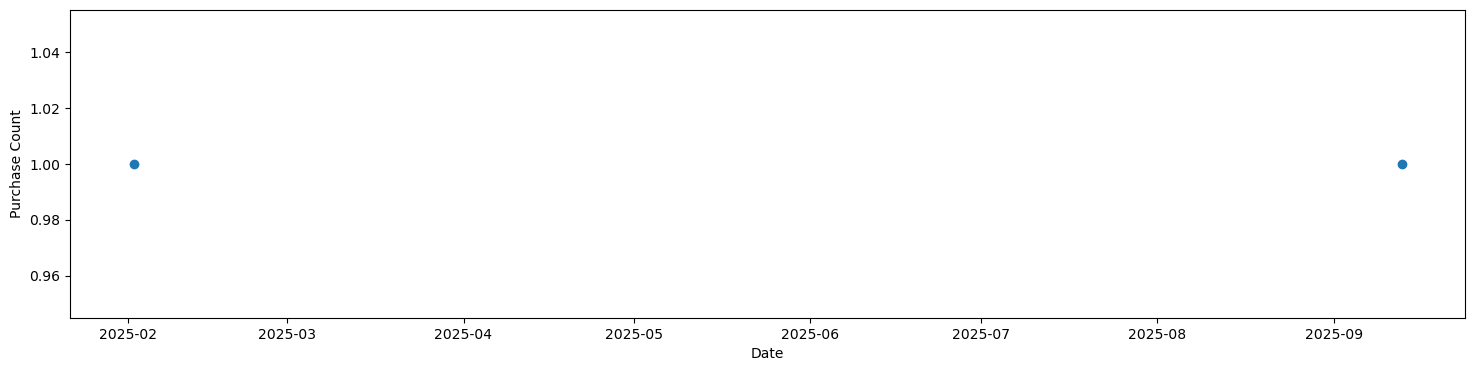

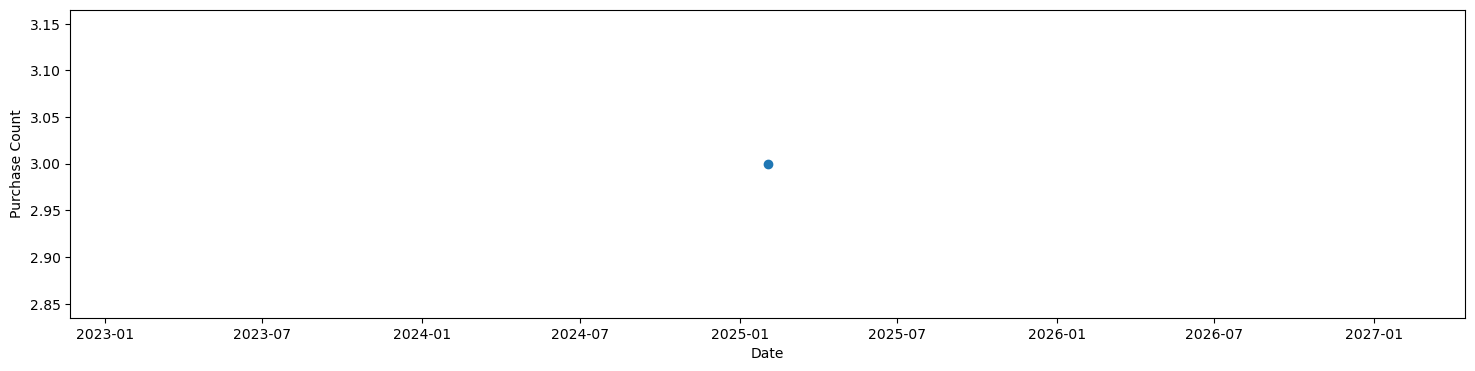

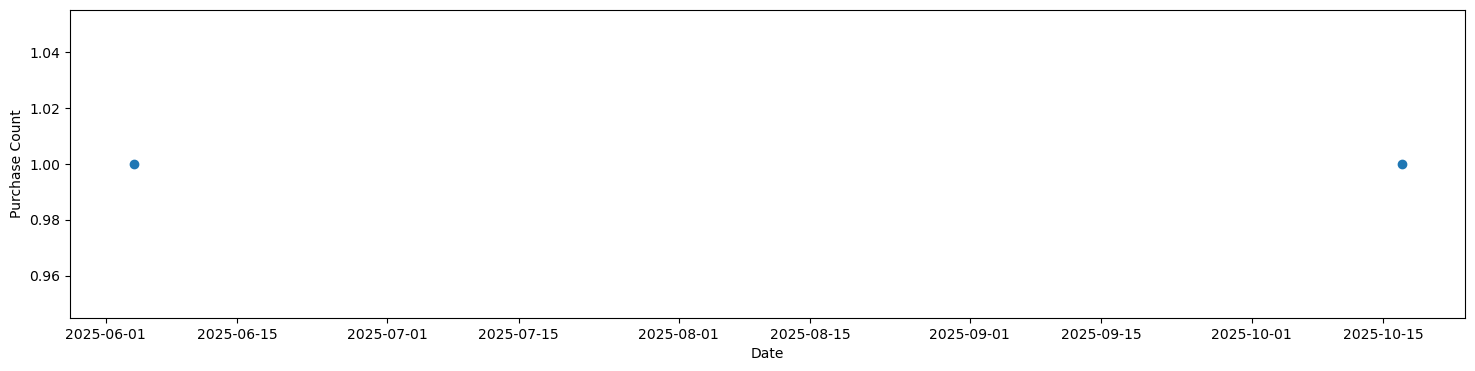

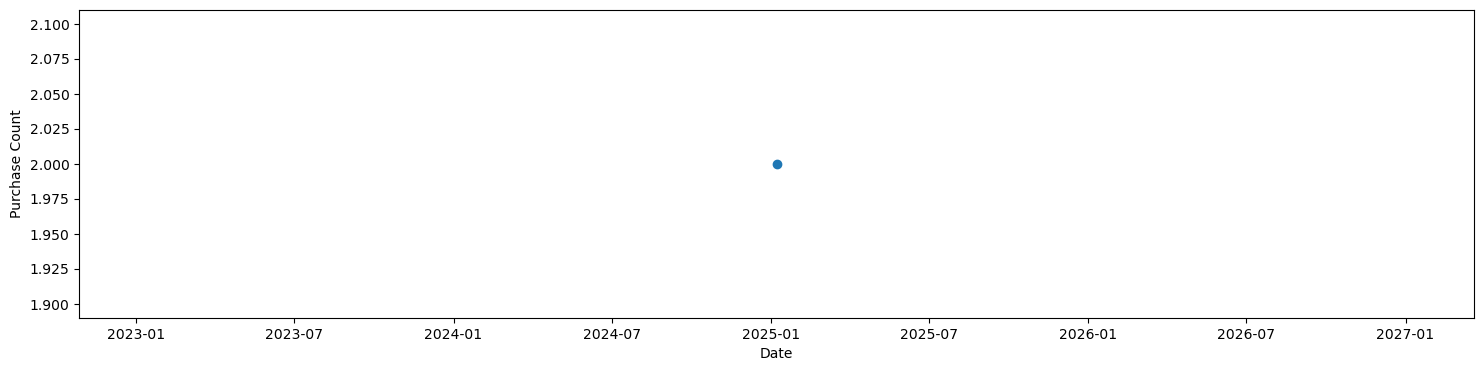

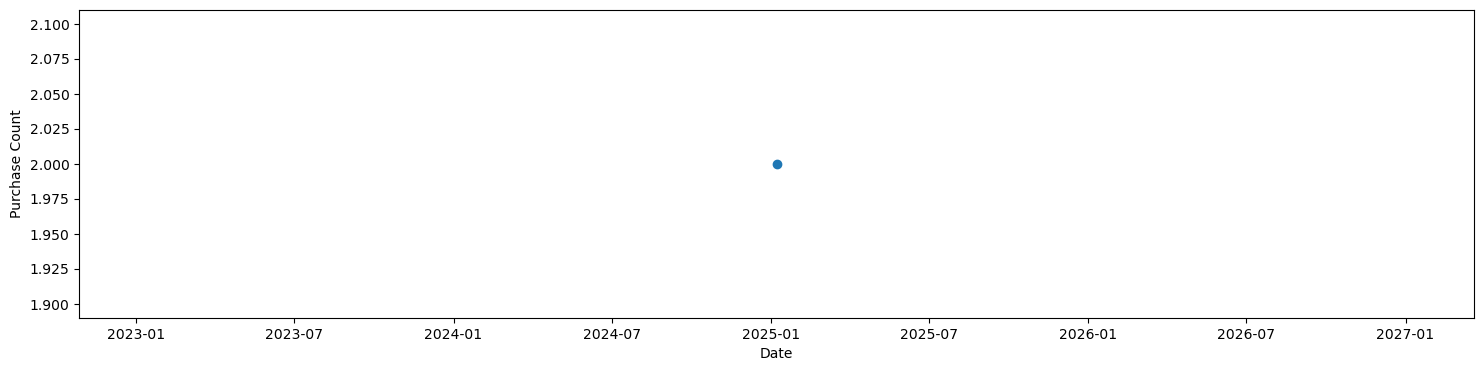

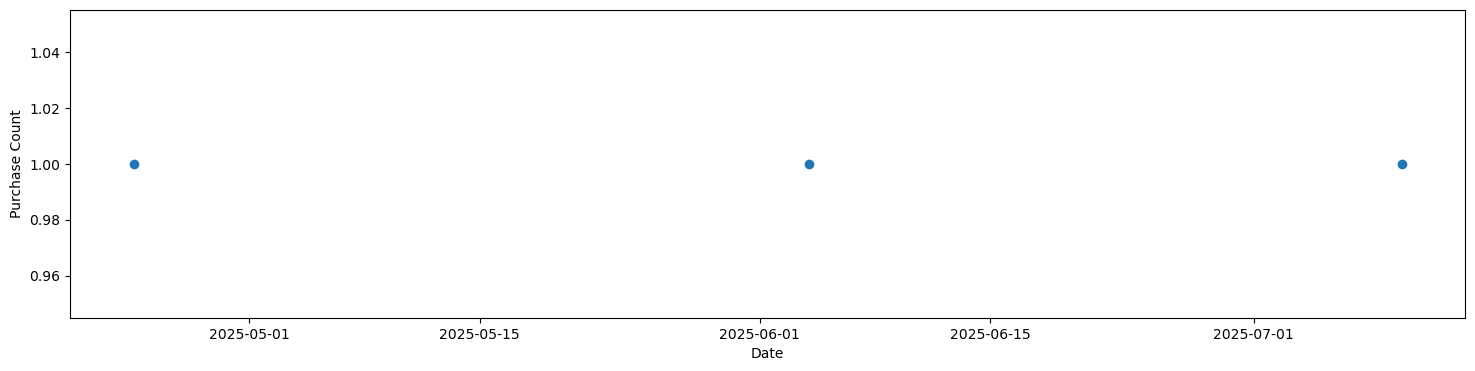

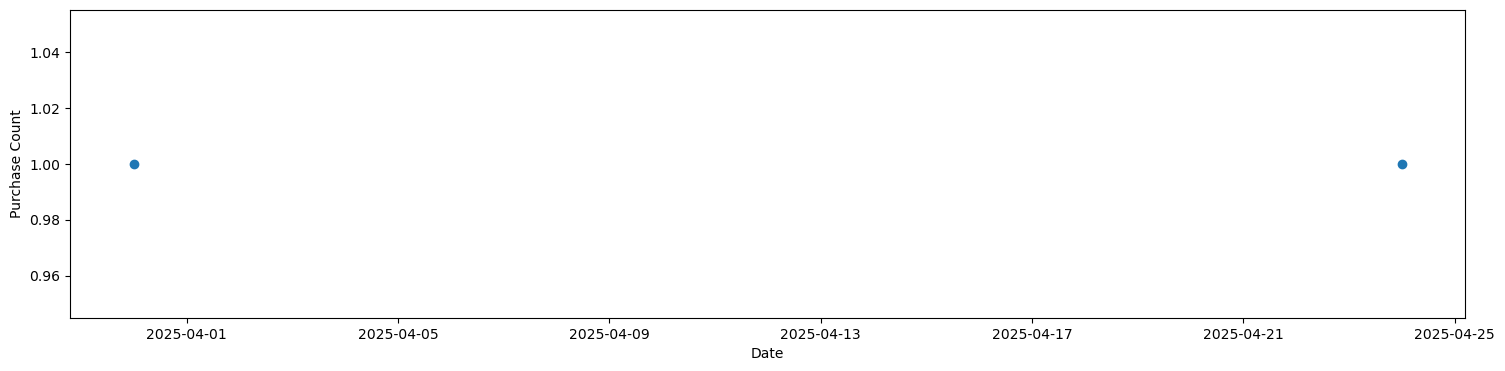

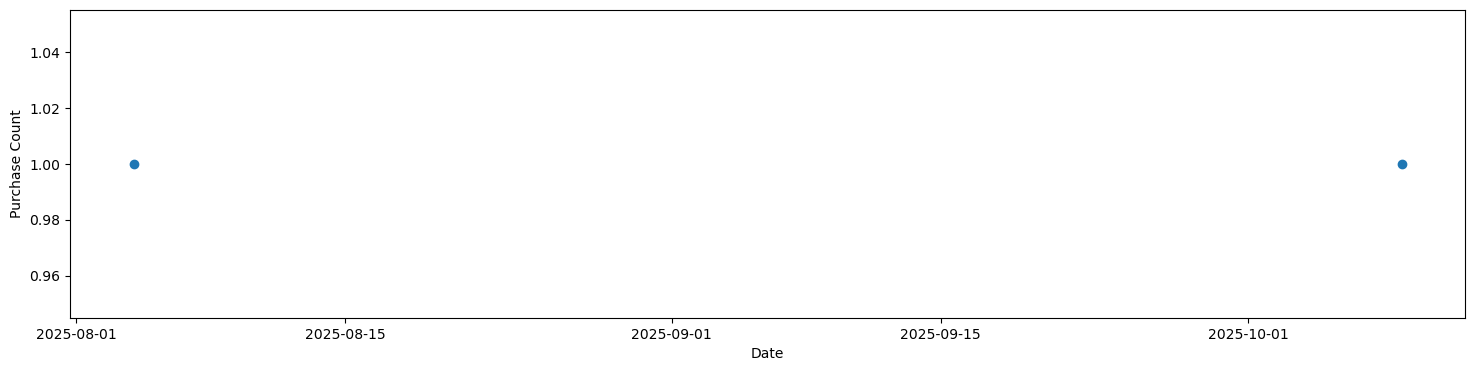

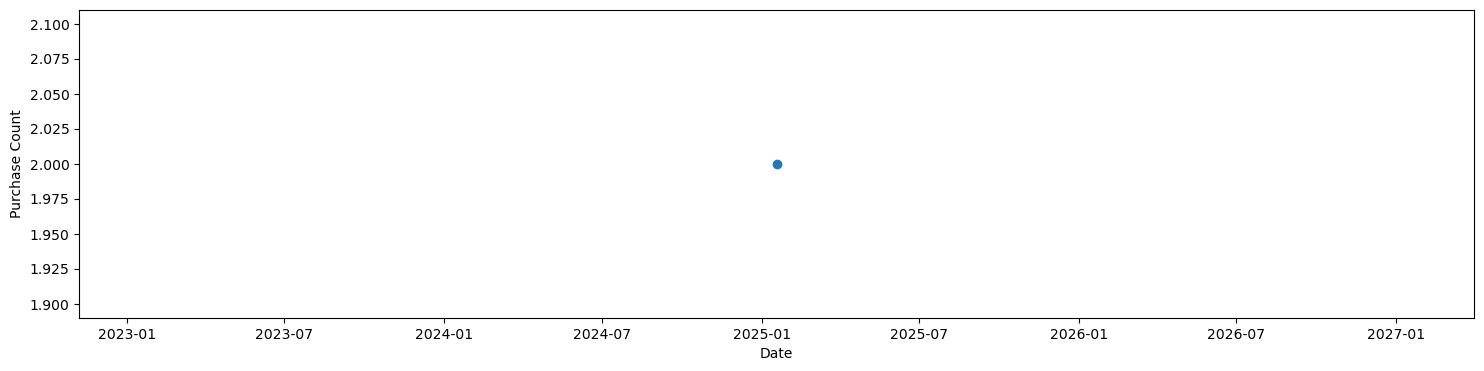

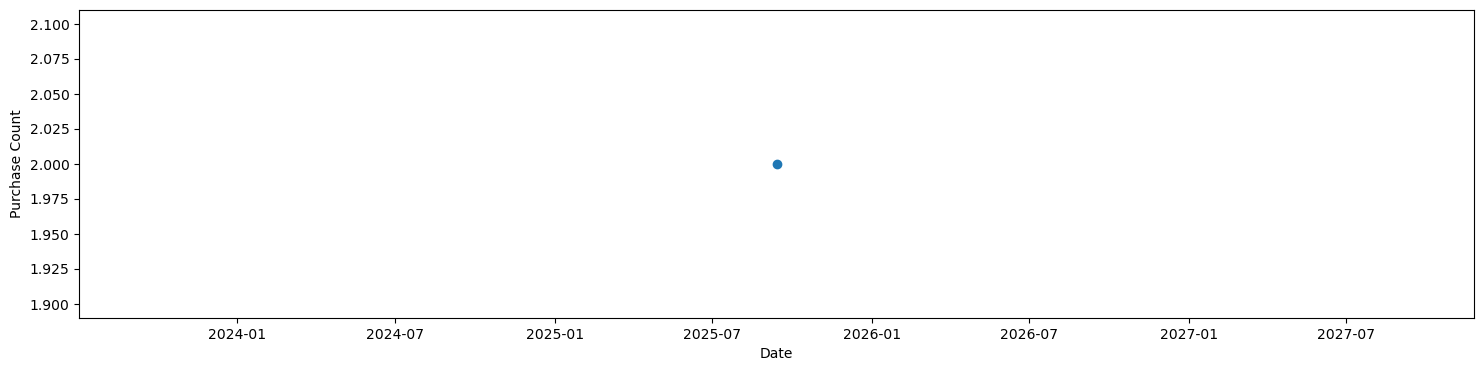

In [3]:
from IPython.display import display, HTML

for itemId in df["itemId"].unique():
    df_item = df[df["itemId"] == itemId]
    itemName = df_item["item"].iloc[0]

    display(HTML(f"<h3>{itemName} (itemId={itemId})</h3>"))

    daily_counts = (
        df_item
        .groupby("date")
        .size()
        .sort_index()
    )

    plt.figure(figsize=(18, 4))
    plt.scatter(daily_counts.index, daily_counts.values)
    plt.xlabel("Date")
    plt.ylabel("Purchase Count")
    plt.show()


In [4]:
# -----------------------------
# CONFIG
# -----------------------------
target_col = "didBuy_target"

feature_cols = groceryMLCore.get_feature_col_names(groceryML.training_df)

if "itemId" not in feature_cols:
    feature_cols = ["itemId"] + feature_cols

groceryML.training_df["itemId"] = groceryML.training_df["itemId"].astype("category")

# -----------------------------
# SPLIT
# -----------------------------
X = groceryML.training_df[feature_cols]
y = groceryML.training_df[target_col]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

binary_classification_metrics = [
    "logloss",
    "auc",
    "aucpr",
    "error",
 #   "Precision",
  #  "recall",
  #  "f1",
    "map",
    "ndcg"
]

# -----------------------------
# MODEL
# -----------------------------
model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=300,
    max_depth=50,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    enable_categorical=True,
    random_state=42
)
# model = xgb.XGBClassifier(
#     objective="binary:logistic",
#     eval_metric = binary_classification_metrics,
#     n_estimators = 600,
#     learning_rate =0.005,
#     max_depth = 1000,
#     min_child_weight = 5,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     tree_method="hist",
#     enable_categorical=True,
#     random_state=42
# )
# -----------------------------
# TRAIN
# -----------------------------
model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# -----------------------------
# VALIDATE
# -----------------------------
val_preds = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, val_preds)

print("AUC:", round(auc, 4))

model.get_booster().get_score(importance_type="gain")

prediction_date = pd.Timestamp.now().normalize()
pred_bundle = groceryML.build_prediction_input(prediction_date)
pred_df = pred_bundle["prediction_df"]
X_pred = pred_bundle["X_pred"]
pred_df.insert(4, "didBuy_pred_prob", model.predict_proba(X_pred)[:, 1])
pred_df = pred_df.sort_values("didBuy_pred_prob", ascending=False)
ts = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
groceryMLCore.export_df_to_excel_table(pred_df, f"xgb_predictions-{ts}")



AUC: 0.9025
build_prediction_input() prediction_date=2026-01-05 00:00:00
build_combined_df()


C:\Users\steve\source\repos\grocery-ml\grocery_ml_core.py:324: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  additional_rcpts_df["date"] = pd.to_datetime(additional_rcpts_df["date"])


creating target col: didBuy_target
insert_negative_samples()
compute_expected_gap_ewma()
create_item_supply_level_feat()
add_item_total_purchase_count_feat()
build_trip_level_features()
self._combined_df() done
create_item_supply_level_feat()
build_prediction_input() done
Writing XLSX: xgb_predictions-2026_01_05_20_57_26.xlsx
   XLSX Done: xgb_predictions-2026_01_05_20_57_26.xlsx
